<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#General-parameters" data-toc-modified-id="General-parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>General parameters</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Machinery" data-toc-modified-id="Machinery-1.2.0.1"><span class="toc-item-num">1.2.0.1&nbsp;&nbsp;</span>Machinery</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-1.2.0.2"><span class="toc-item-num">1.2.0.2&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Systematic" data-toc-modified-id="Systematic-1.2.0.3"><span class="toc-item-num">1.2.0.3&nbsp;&nbsp;</span>Systematic</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#An-example" data-toc-modified-id="An-example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>An example</a></span><ul class="toc-item"><li><span><a href="#Noise" data-toc-modified-id="Noise-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Noise</a></span></li></ul></li><li><span><a href="#Systematic" data-toc-modified-id="Systematic-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Systematic</a></span><ul class="toc-item"><li><span><a href="#Max-curves" data-toc-modified-id="Max-curves-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Max curves</a></span></li></ul></li></ul></div>

# Preamble

In [27]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns



from network import Protocol, Network, NetworkNMDA, NetworkManager
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## General parameters

In [28]:
%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

epsilon = 1e-7
vmin = -6.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 3.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Functions

#### Machinery

In [113]:
def calculate_total_success(manager, representation, patterns_per_sequence, T_persistence=0.050,
                            remove=remove, n_cues=2, verbose=False):
    
    T_cue = 2.0 * manager.nn.tau_s
    T_recall = n_cues * T_persistence * patterns_per_sequence

    nr1 = representation.network_representation[:patterns_per_sequence]
    nr2 = representation.network_representation[patterns_per_sequence:]

    # Success 1
    aux1 = calculate_recall_quantities(manager, nr1, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
    success1, pattern_sequence1, persistent_times1, timings1 = aux1

    # Success 2
    aux2 = calculate_recall_quantities(manager, nr2, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
    success2, pattern_sequence2, persistent_times2, timings2 = aux2
    
    total_success = 0.5 * success1 + 0.5 * success2
    
    if verbose:
        print('T_recall', T_recall)
        print('s1', success1)
        print('sequence1', pattern_sequence1)
        print('persistence1', persistent_times1)
        print('s2', success2)
        print('sequence2', pattern_sequence2)
        print('persistence2', persistent_times2)
        print('remove', remove)

    return total_success

from copy import deepcopy

def create_overalaped_representation(manager, representation_overlap, sequence_overlap):
    x = deepcopy(manager.canonical_activity_representation)

    to_modify = int(representation_overlap * len(x[0]))
    sequence_size = int(0.5 * len(x))
    sequence_overlap_size = int(sequence_overlap * sequence_size)
    start_point = int(0.5 * sequence_size + sequence_size - np.floor(sequence_overlap_size/ 2.0))
    end_point = start_point + sequence_overlap_size

    for sequence_index in range(start_point, end_point):
        pattern = x[sequence_index]
        pattern[:to_modify] = manager.canonical_activity_representation[sequence_index - sequence_size][:to_modify]

    return x

def calculate_total_recall_trials(n_samples, manager, representation, patterns_per_sequence, 
                                   T_persistence=0.100, remove=remove, n_cues=2, verbose=False):
    
    total_success_vector = np.zeros(n_samples)

    for i in range(n_samples):
        total_success_vector[i] = calculate_total_success(manager, representation, 
                                                          patterns_per_sequence, T_persistence=T_persistence, 
                                                          remove=remove, n_cues=n_cues, verbose=verbose)
    
    return total_success_vector

def run_sigma_sweep(sigma_number, n_samples, sigma_max, manager, representation, patterns_per_sequence,
                    T_persistence=0.100, remove=remove, n_cues=1):
    
    sigma_vector = np.linspace(0, sigma_max, num=sigma_number)
    successes_collection = np.zeros((sigma_number, n_samples))

    for index, sigma in enumerate(sigma_vector):
        manager.nn.sigma_out = sigma
        manager.nn.sigma_in = sigma * np.sqrt(2 / manager.nn.tau_s)
        aux = calculate_total_recall_trials(n_samples, manager, representation, patterns_per_sequence, 
                                            T_persistence=0.100, remove=remove, n_cues=n_cues)
        
        successes_collection[index, :] = aux
        
    results_dic = {'manager': manager, 'sigma_vector': sigma_vector, 'success': successes_collection}

    return results_dic



#### Plotting

In [30]:
def plot_mean_success_vs_sigma(results_dictionary, n_samples, index=0, label=0, ax=None, add_zero_axis=False):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    successes_collection = results_dictionary['success']
    sigma_vector = results_dictionary['sigma_vector']

    std = successes_collection.std(axis=1)
    mean_success = successes_collection.mean(axis=1)
    ci_low, ci_upp = sm.stats.proportion_confint(mean_success * n_samples, n_samples, alpha=0.05, method='normal')

    # Plot the mean
    ax.plot(sigma_vector, mean_success, 'o-', lw=lw, ms=ms, color=colors[index], label=label)
    
    if False:
        # Plot sigma05
        sigma09_arg = np.where(mean_success <= 0.9)[0]
        if sigma09_arg.size > 0:
            sigma09 = sigma_vector[sigma09_arg[0]]
            ax.plot(sigma09, 0.9, '*', ms=(ms + 20), color='black')

        sigma01_arg = np.where(mean_success <= 0.1)[0]
        if sigma01_arg.size > 0:
            sigma01 = sigma_vector[sigma01_arg[0]]
            ax.plot(sigma01, 0.1, '*', ms=(ms + 20), color='black')
    
    # Plot the interval
    ci_low, ci_upp = sm.stats.proportion_confint(mean_success * n_samples, n_samples, alpha=0.05, method='normal')
    low = ci_low
    low[low < 0.0] = 0.0
    high = ci_upp
    ax.fill_between(sigma_vector, low, high, color=colors[index], alpha=alpha_graph)
    
    if add_zero_axis:
        ax.axhline(0, ls='--', color='gray')
        ax.axvline(0, ls='--', color='gray')
    
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel('Success rate')
    ax.legend(frameon=False)

    return ax

def plot_persistent_time_vs_sigma(results_dictionary, index=0, label=0, ax=None, single=True, add_zero_axis=False):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    persistent_times = results_dictionary['persistent times'] 
    sigma_vector = results_dictionary['sigma_vector']
    T_persistence = results_dictionary['T_persistence']
    mean_persistent = np.zeros(sigma_vector.size)
    low = np.zeros(sigma_vector.size)
    high = np.zeros(sigma_vector.size)
    std = np.zeros(sigma_vector.size)
    
    for sigma_index in range(sigma_vector.size):
        flatted = [item for l in persistent_times[sigma_index] for item in l[1:-1]]
        mean_persistent[sigma_index] = np.mean(flatted)
        std[sigma_index] = np.std(flatted)
        low[sigma_index] = np.percentile(flatted, 25)
        high[sigma_index] = np.percentile(flatted, 75)

    ax.plot(sigma_vector, mean_persistent, 'o-', lw=lw, ms=ms, color=colors[index] , label=label)
    ax.fill_between(sigma_vector, low, high,color=colors[index], alpha=alpha_graph)
    if add_zero_axis:
        ax.axhline(0, ls='--',color='gray')
        ax.axvline(0, ls='--',color='gray')
    
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel(r'$T_{persistence} (s)$')

    if single:
        ax.axhline(T_persistence, ls='--', color=colors[index], label=r'$T_{base}$' )
        ax.axhline(tau_s, ls='--', color='red', label=r'$\tau_s$')
        ax.legend(frameon=False)
    
    return ax

#### Systematic

In [83]:
def calculate_dis_success(representation_overlap=1.0, sequence_overlap=0.5, minicolumns=20, 
                          hypercolumns=1, tt=0.100, ipi=0, tau_z_pre=0.025, tau_z_post=0.005, 
                          sigma_out=0.0, T_persistence=0.100, n_samples=1, n_cues=1.0,
                          NMDA=True, AMPA=True, remove=remove, verbose=False):
    
    sigma_out = sigma_out
    tau_z_pre = tau_z_pre
    tau_z_post = tau_z_post

    hypercolumns = hypercolumns
    minicolumns = minicolumns
    n_patterns = minicolumns

    # Training protocol
    training_times_base = tt
    training_times = [training_times_base for i in range(n_patterns)]
    ipi_base = ipi
    inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
    inter_sequence_interval = 1.0
    resting_time = 1.0
    epochs = 1
    T_persistence = T_persistence

    # Manager properties
    values_to_save = ['o']

    # Neural Network
    nn = NetworkNMDA(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                     tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                     strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

    # Build the representation
    patterns_per_sequence = int(n_patterns / 2)
    
    activity_representation = create_overalaped_representation(manager, representation_overlap, sequence_overlap)
    representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
    inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval

    if verbose:
        print('representation')
        print(representation.activity_representation)
        print('------')
        
        
    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol, NMDA=NMDA)
    # Set the persistent time
    # If AMPA Is False, don't show the weights
    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, NMDA=NMDA)
    
   # Calculate total success
    if not AMPA:
        manager.nn.g_AMPA = 0.0
    total_success_vector = calculate_total_recall_trials(n_samples, manager, representation, patterns_per_sequence, 
                                                         T_persistence=T_persistence, remove=remove, 
                                                         n_cues=n_cues, verbose=verbose)
    
    return total_success_vector, manager

# An example

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [ 4]
 [ 5]
 [ 6]
 [17]
 [18]
 [19]]
CPU times: user 444 ms, sys: 36 ms, total: 480 ms
Wall time: 159 ms


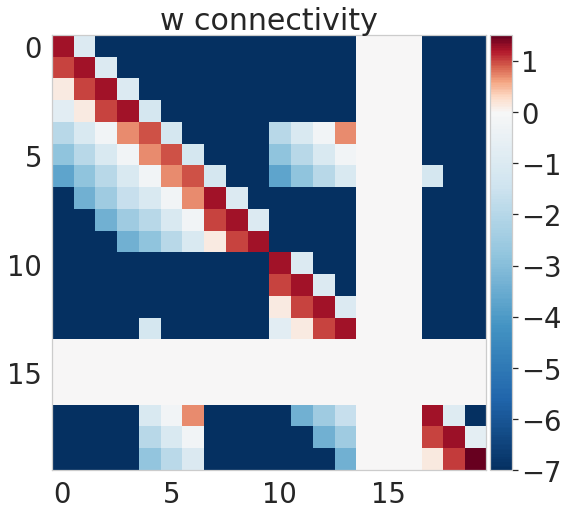

In [74]:
%%time 
sigma_out = 0.1
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 1.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

# Manager properties
values_to_save = ['o']

# Neural Network
nn = NetworkNMDA(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the representation
representation_overlap = 1.0
sequence_overlap = 0.3
patterns_per_sequence = 10
activity_representation = create_overalaped_representation(manager, representation_overlap, sequence_overlap)
representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval

print(activity_representation)

    
# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
nn.g_AMPA = 0.0
NMDA = True
timed_input = manager.run_network_protocol_offline(protocol=protocol, NMDA=NMDA)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, NMDA=NMDA)
plot_weight_matrix(manager)

1.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8]
[0.025, 0.015, 0.015, 0.014, 0.017, 0.013000000000000001, 0.019, 0.014, 0.016, 0.021, 0.01, 0.013000000000000001, 0.015, 0.01]


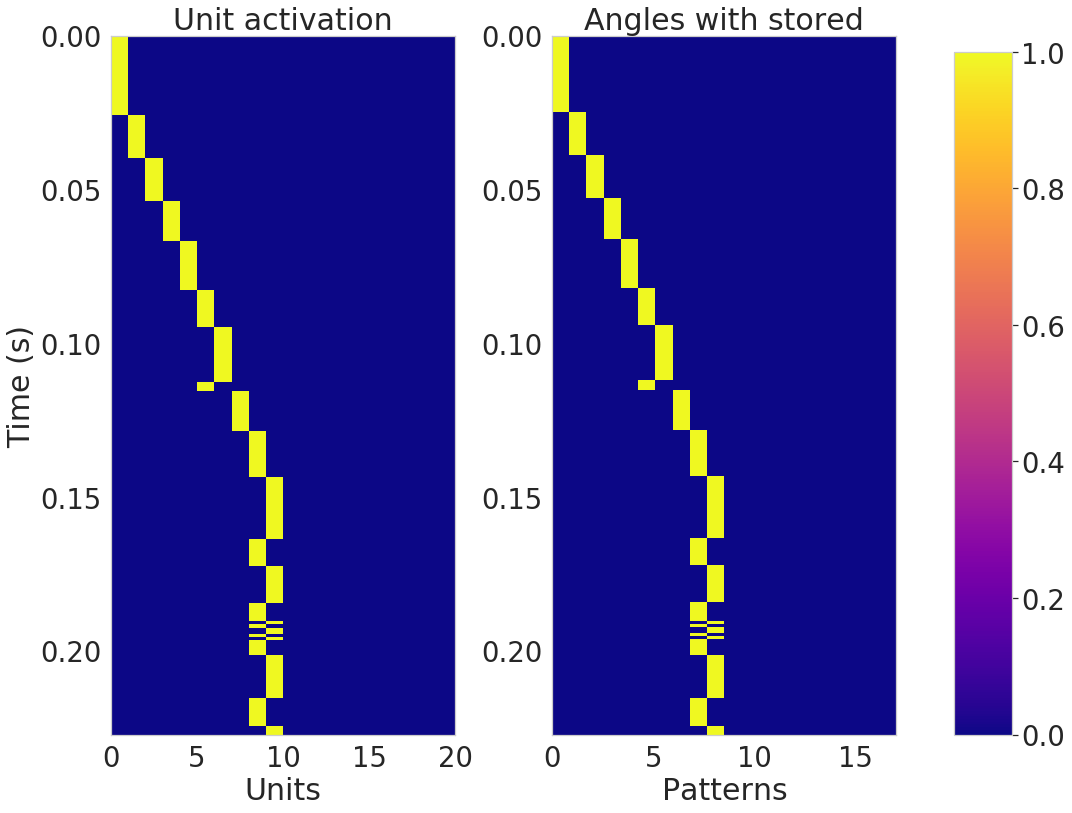

In [75]:
T_cue = 2 * manager.nn.tau_s
T_recall = 0.75 * T_persistence * patterns_per_sequence + T_cue

nr1 = representation.network_representation[:patterns_per_sequence]
nr2 = representation.network_representation[patterns_per_sequence:]

# Success 1
aux1 = calculate_recall_quantities(manager, nr1, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success1, pattern_sequence1, persistent_times1, timings1 = aux1
print(success1)
print(pattern_sequence1)
print(persistent_times1)

plot_network_activity_angle(manager, time_y=True);

1.0
[10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18]
[0.024, 0.014, 0.015, 0.016, 0.015, 0.014, 0.018000000000000002, 0.015, 0.014, 0.01, 0.011, 0.013000000000000001, 0.013000000000000001]


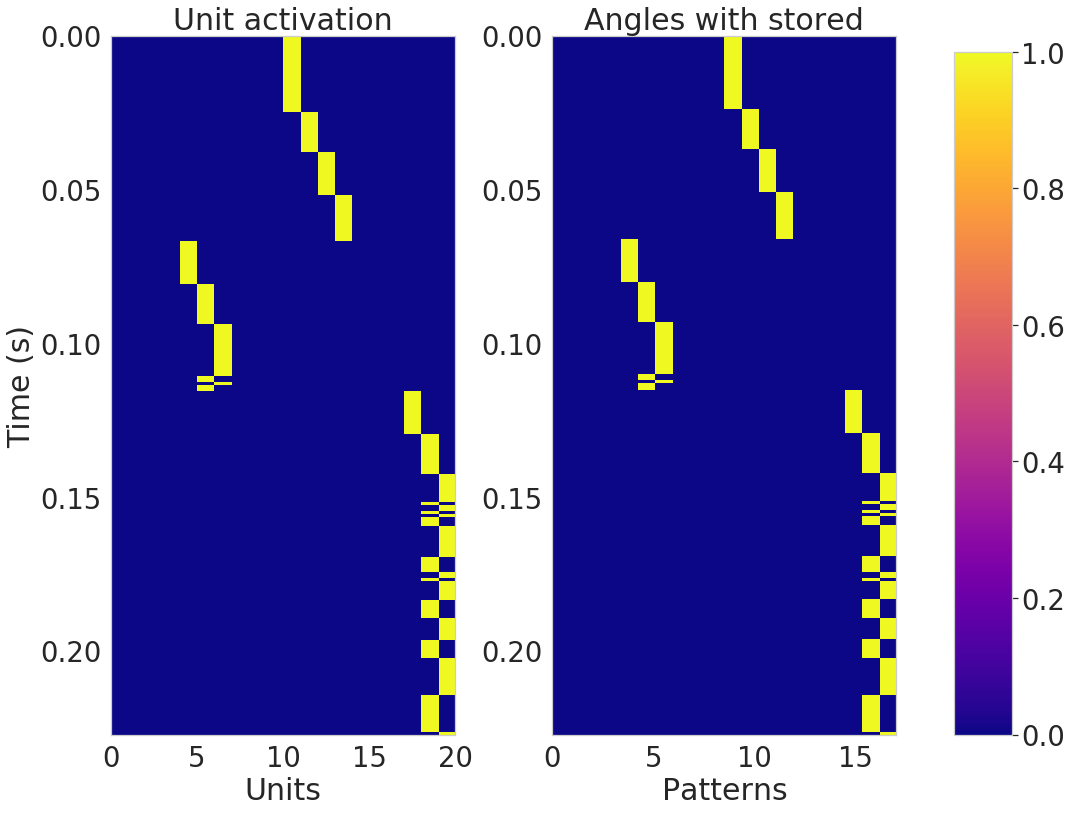

In [76]:
T_cue = 2 * manager.nn.tau_s
T_recall = 0.75 * T_persistence * patterns_per_sequence + T_cue

nr1 = representation.network_representation[:patterns_per_sequence]
nr2 = representation.network_representation[patterns_per_sequence:]

# Success 1
aux1 = calculate_recall_quantities(manager, nr2, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success1, pattern_sequence1, persistent_times1, timings1 = aux1
print(success1)
print(pattern_sequence1)
print(persistent_times1)

plot_network_activity_angle(manager, time_y=True);

## Noise

In [23]:
%%time 
sigma_out = 0.2
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 1.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

# Manager properties
values_to_save = ['o']

# Neural Network
nn = NetworkNMDA(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the representation
representation_overlap = 1.0
sequence_overlap = 0.3
patterns_per_sequence = 10
activity_representation = create_overalaped_representation(manager, representation_overlap, sequence_overlap)
representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
NMDA = True
timed_input = manager.run_network_protocol_offline(protocol=protocol, NMDA=NMDA)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, NMDA=NMDA)

sigma_number = 20
n_samples = 20
sigma_max = 1.0

results_dic = run_sigma_sweep(sigma_number, n_samples, sigma_max, manager, representation, 
                              patterns_per_sequence, T_persistence=T_persistence, remove=remove, n_cues=2)

CPU times: user 2min 13s, sys: 84 ms, total: 2min 13s
Wall time: 2min 12s


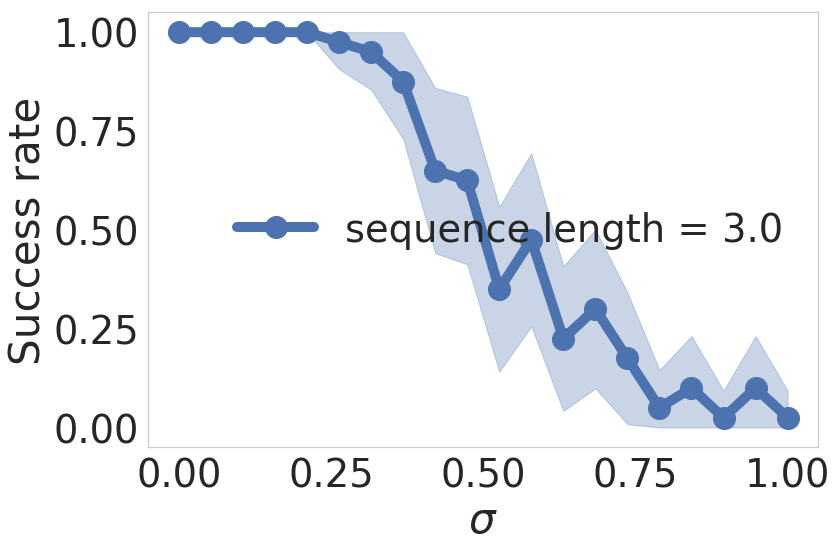

In [25]:
index = 0
ax = None
label = r'sequence length = ' + str(sequence_overlap * 10)
results_dictionary = results_dic
ax = plot_mean_success_vs_sigma(results_dictionary, n_samples=n_samples, index=index, label=label, ax=ax)

# Systematic

In [96]:
%%time 
sigma_out = 0.1
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
T_persistence = 0.025
NMDA = True
AMPA = False

tau_z_pre_set = [0.030, 0.060, 0.090]
tau_z_pre_set = [0.025, 0.075, 0.125]
# tau_z_pre_set = [0.060]
verbose = False
sequence_overlaps = np.linspace(0.1, 0.8, 8)
n_samples = 500
n_samples = 50
success_list_nmda = []

for tau_z_pre in tau_z_pre_set:
    print(tau_z_pre)
    success_vector = np.zeros(sequence_overlaps.size)

    for index, sequence_overlap in enumerate(sequence_overlaps):
        aux = calculate_dis_success(representation_overlap=1.0, sequence_overlap=sequence_overlap, minicolumns=minicolumns, 
                                    hypercolumns=hypercolumns, tt=0.100, ipi=0, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,  
                                    sigma_out=sigma_out, T_persistence=T_persistence, n_samples=n_samples, n_cues=1.0, 
                                    NMDA=NMDA, AMPA=AMPA, remove=remove, verbose=True)

        success, manager = aux
        success_vector[index] = np.mean(success)
    print(success_vector)
    success_list_nmda.append(success_vector)

0.025
representation
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [ 5]
 [16]
 [17]
 [18]
 [19]]
------
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.02, 0.015, 0.015, 0.018000000000000002, 0.02, 0.019, 0.019, 0.019, 0.029]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19]
persistence2 [0.025, 0.019, 0.019, 0.021, 0.017, 0.021, 0.02, 0.02, 0.019, 0.03]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.017, 0.02, 0.02, 0.019, 0.02, 0.019, 0.021, 0.02, 0.034]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19]
persistence2 [0.025, 0.018000000000000002, 0.02, 0.021, 0.018000000000000002, 0.018000000000000002, 0.02, 0.018000000000000002, 0.02, 0.031]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.017, 0.016, 0.021, 0.019, 0.02, 0.02, 0.019, 0.019, 0.028

T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.02, 0.018000000000000002, 0.02, 0.019, 0.02, 0.02, 0.021, 0.018000000000000002, 0.025]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19]
persistence2 [0.025, 0.016, 0.016, 0.022, 0.02, 0.02, 0.017, 0.019, 0.02, 0.03]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.017, 0.018000000000000002, 0.022, 0.018000000000000002, 0.021, 0.018000000000000002, 0.018000000000000002, 0.019, 0.032]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19]
persistence2 [0.024, 0.019, 0.019, 0.023, 0.019, 0.018000000000000002, 0.018000000000000002, 0.02, 0.019, 0.026000000000000002]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.018000000000000002, 0.018000000000000002, 0.021, 0.018000000000000002, 0.019, 0.018000000000000002, 0.02, 0.019, 0.027]
s2 1.0
sequence2 [10, 11, 

T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.017, 0.017, 0.022, 0.018000000000000002, 0.02, 0.02, 0.019, 0.019, 0.031]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19]
persistence2 [0.024, 0.019, 0.018000000000000002, 0.021, 0.017, 0.02, 0.02, 0.02, 0.019, 0.031]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.024, 0.018000000000000002, 0.017, 0.021, 0.019, 0.02, 0.018000000000000002, 0.019, 0.018000000000000002, 0.031, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19]
persistence2 [0.025, 0.019, 0.019, 0.022, 0.019, 0.021, 0.019, 0.018000000000000002, 0.02, 0.032]
remove 0.01
representation
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [ 4]
 [ 5]
 [16]
 [17]
 [18]
 [19]]
------
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.017, 0.02, 0.023, 0.019, 0.02, 0.018

T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.019, 0.017, 0.021, 0.019, 0.021, 0.019, 0.019, 0.018000000000000002, 0.026000000000000002]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19]
persistence2 [0.025, 0.02, 0.017, 0.021, 0.018000000000000002, 0.021, 0.018000000000000002, 0.021, 0.019, 0.025]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.024, 0.018000000000000002, 0.018000000000000002, 0.022, 0.019, 0.019, 0.02, 0.018000000000000002, 0.019, 0.028, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19]
persistence2 [0.025, 0.017, 0.017, 0.021, 0.019, 0.018000000000000002, 0.02, 0.019, 0.019, 0.028]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.018000000000000002, 0.019, 0.021, 0.02, 0.02, 0.02, 0.019, 0.018000000000000002, 0.03]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19]
persi

T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.019, 0.02, 0.02, 0.017, 0.022, 0.019, 0.018000000000000002, 0.018000000000000002, 0.024]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19]
persistence2 [0.024, 0.018000000000000002, 0.018000000000000002, 0.021, 0.019, 0.019, 0.019, 0.019, 0.019, 0.033]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.02, 0.019, 0.022, 0.018000000000000002, 0.02, 0.018000000000000002, 0.019, 0.019, 0.033]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18]
persistence2 [0.024, 0.019, 0.017, 0.022, 0.017, 0.021, 0.019, 0.018000000000000002, 0.019, 0.031, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.018000000000000002, 0.018000000000000002, 0.019, 0.019, 0.022, 0.016, 0.018000000000000002, 0.018000000000000002, 0.031, 0.013000000000000001]
s2 1.0
sequence2 

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19]
persistence1 [0.025, 0.017, 0.02, 0.02, 0.02, 0.018000000000000002, 0.02, 0.018000000000000002, 0.019, 0.031]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 7, 8, 9, 8]
persistence2 [0.024, 0.018000000000000002, 0.018000000000000002, 0.021, 0.018000000000000002, 0.018000000000000002, 0.02, 0.018000000000000002, 0.02, 0.031, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.019, 0.018000000000000002, 0.02, 0.019, 0.02, 0.019, 0.019, 0.02, 0.03]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 7, 8, 9, 8]
persistence2 [0.024, 0.018000000000000002, 0.018000000000000002, 0.021, 0.018000000000000002, 0.019, 0.021, 0.018000000000000002, 0.018000000000000002, 0.029, 0.013000000000000001]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19]
persistence1 [0.024, 0.018000000000000002, 0.019, 0.021, 0.019, 0.02, 0.022, 0.

T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.019, 0.018000000000000002, 0.021, 0.018000000000000002, 0.02, 0.021, 0.018000000000000002, 0.018000000000000002, 0.026000000000000002, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19]
persistence2 [0.024, 0.02, 0.019, 0.021, 0.019, 0.018000000000000002, 0.021, 0.02, 0.019, 0.029]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19]
persistence1 [0.024, 0.017, 0.018000000000000002, 0.02, 0.018000000000000002, 0.02, 0.021, 0.019, 0.019, 0.034]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 7, 8, 9, 8]
persistence2 [0.025, 0.018000000000000002, 0.017, 0.021, 0.018000000000000002, 0.016, 0.021, 0.019, 0.018000000000000002, 0.03, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19]
persistence1 [0.025, 0.017, 0.018000000000000002, 0.022, 0.018000000000000002, 0.019, 0.021, 0.019, 0.019, 0.03]
s2 0

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19]
persistence1 [0.023, 0.016, 0.017, 0.019, 0.017, 0.018000000000000002, 0.021, 0.017, 0.018000000000000002, 0.025]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 8, 9]
persistence2 [0.024, 0.019, 0.017, 0.019, 0.017, 0.019, 0.018000000000000002, 0.017, 0.017, 0.022]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19]
persistence1 [0.024, 0.015, 0.018000000000000002, 0.02, 0.016, 0.018000000000000002, 0.019, 0.017, 0.017, 0.023, 0.01]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18]
persistence2 [0.024, 0.017, 0.018000000000000002, 0.02, 0.017, 0.018000000000000002, 0.019, 0.018000000000000002, 0.018000000000000002, 0.029, 0.014]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.023, 0.017, 0.017, 0.02, 0.017, 0.018000000000000002, 0.02, 0.016, 0.018000000000000002, 0.025, 0.01, 0.013000000000000001]
s2

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19]
persistence1 [0.024, 0.016, 0.016, 0.021, 0.018000000000000002, 0.018000000000000002, 0.019, 0.017, 0.019, 0.026000000000000002]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19]
persistence2 [0.023, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.019, 0.018000000000000002, 0.018000000000000002, 0.017, 0.018000000000000002, 0.027, 0.011, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.024, 0.018000000000000002, 0.017, 0.019, 0.017, 0.017, 0.02, 0.017, 0.018000000000000002, 0.027, 0.012]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19]
persistence2 [0.024, 0.018000000000000002, 0.018000000000000002, 0.02, 0.018000000000000002, 0.017, 0.018000000000000002, 0.019, 0.017, 0.025, 0.012, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 18]
persistence1 [0.024, 0.018000000000000002, 0.017, 0.021, 0.019, 0.018000000000000002, 0.019, 0.019, 0.018000000000000002, 0.028, 0.016]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 18]
persistence2 [0.024, 0.018000000000000002, 0.019, 0.02, 0.018000000000000002, 0.018000000000000002, 0.017, 0.019, 0.017, 0.028, 0.014]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 18]
persistence1 [0.023, 0.018000000000000002, 0.017, 0.02, 0.018000000000000002, 0.019, 0.017, 0.018000000000000002, 0.018000000000000002, 0.029, 0.017]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 8, 9, 8]
persistence2 [0.023, 0.017, 0.018000000000000002, 0.02, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.019, 0.019, 0.027, 0.013000000000000001]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.023, 0.017, 0.017

T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.024, 0.017, 0.016, 0.021, 0.017, 0.018000000000000002, 0.016, 0.019, 0.018000000000000002, 0.026000000000000002, 0.011]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 8, 9, 8]
persistence2 [0.024, 0.018000000000000002, 0.019, 0.02, 0.017, 0.016, 0.017, 0.02, 0.017, 0.026000000000000002, 0.015]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.024, 0.016, 0.018000000000000002, 0.019, 0.017, 0.017, 0.019, 0.018000000000000002, 0.017, 0.026000000000000002, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19]
persistence2 [0.024, 0.017, 0.018000000000000002, 0.019, 0.017, 0.019, 0.017, 0.018000000000000002, 0.017, 0.025]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 18]
persistence1 [0.023, 0.018000000000000002, 0.016, 0.02, 0.018000000000000002, 0.017, 0.018000000000000002,

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19]
persistence1 [0.024, 0.017, 0.018000000000000002, 0.02, 0.017, 0.019, 0.017, 0.019, 0.017, 0.024]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 8, 9, 8]
persistence2 [0.023, 0.018000000000000002, 0.017, 0.019, 0.017, 0.019, 0.017, 0.02, 0.018000000000000002, 0.026000000000000002, 0.013000000000000001]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.024, 0.017, 0.017, 0.021, 0.018000000000000002, 0.016, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.028, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19]
persistence2 [0.024, 0.017, 0.017, 0.02, 0.017, 0.018000000000000002, 0.018000000000000002, 0.017, 0.017, 0.026000000000000002]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.024, 0.017, 0.018000000000000002, 0.02, 0.017, 0.017, 0.018000000000000002, 0.019, 0

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19]
persistence1 [0.025, 0.018000000000000002, 0.017, 0.02, 0.02, 0.018000000000000002, 0.019, 0.02, 0.018000000000000002, 0.026000000000000002]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 18]
persistence2 [0.024, 0.019, 0.02, 0.019, 0.019, 0.019, 0.02, 0.021, 0.017, 0.029, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.018000000000000002, 0.017, 0.021, 0.022, 0.019, 0.016, 0.021, 0.015, 0.029]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 9]
persistence2 [0.025, 0.019, 0.019, 0.021, 0.02, 0.019, 0.019, 0.02, 0.019, 0.031]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19]
persistence1 [0.024, 0.018000000000000002, 0.017, 0.02, 0.02, 0.019, 0.019, 0.02, 0.017, 0.026000000000000002]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 18]
persistence2 [0.024, 0.018000000000000002, 0.017, 0.021, 0

T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.018000000000000002, 0.017, 0.023, 0.019, 0.019, 0.018000000000000002, 0.021, 0.02, 0.032]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 18]
persistence2 [0.024, 0.017, 0.019, 0.02, 0.018000000000000002, 0.018000000000000002, 0.019, 0.021, 0.017, 0.028, 0.013000000000000001]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 18]
persistence1 [0.024, 0.019, 0.017, 0.021, 0.019, 0.019, 0.018000000000000002, 0.02, 0.019, 0.03, 0.01]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 9]
persistence2 [0.024, 0.019, 0.019, 0.023, 0.019, 0.021, 0.017, 0.021, 0.019, 0.03]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19]
persistence1 [0.025, 0.019, 0.019, 0.022, 0.017, 0.018000000000000002, 0.02, 0.019, 0.019, 0.031]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 9]
persistence2 [0.025, 0.017, 0.018000000000000002,

T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.017, 0.018000000000000002, 0.021, 0.018000000000000002, 0.019, 0.018000000000000002, 0.018000000000000002, 0.021, 0.031, 0.011]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 19, 8]
persistence2 [0.025, 0.018000000000000002, 0.019, 0.02, 0.019, 0.02, 0.018000000000000002, 0.019, 0.019, 0.028, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 19]
persistence1 [0.025, 0.02, 0.018000000000000002, 0.021, 0.018000000000000002, 0.018000000000000002, 0.02, 0.019, 0.019, 0.031]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 19, 8]
persistence2 [0.024, 0.017, 0.019, 0.02, 0.018000000000000002, 0.018000000000000002, 0.019, 0.016, 0.02, 0.031, 0.015]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.019, 0.016, 0.022, 0.017, 0.018000000000000002, 0.02, 0.02, 0.019, 0.027, 0.013000000000000

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 19, 8]
persistence1 [0.025, 0.017, 0.018000000000000002, 0.021, 0.018000000000000002, 0.018000000000000002, 0.017, 0.018000000000000002, 0.02, 0.028, 0.015]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 19, 8]
persistence2 [0.025, 0.018000000000000002, 0.019, 0.02, 0.018000000000000002, 0.019, 0.018000000000000002, 0.019, 0.02, 0.029, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.017, 0.019, 0.022, 0.017, 0.02, 0.02, 0.018000000000000002, 0.02, 0.028, 0.01]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence2 [0.024, 0.018000000000000002, 0.017, 0.02, 0.019, 0.018000000000000002, 0.02, 0.019, 0.02, 0.031, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 19]
persistence1 [0.025, 0.018000000000000002, 0.017, 0.022, 0.019, 0.017, 0.019, 0.018000000000000002, 0.021, 0.032]
s2 0.0
seque

T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.019, 0.019, 0.022, 0.019, 0.02, 0.018000000000000002, 0.018000000000000002, 0.02, 0.029]
s2 1.0
sequence2 [10, 1, 2, 3, 4, 5, 6, 7, 8, 19]
persistence2 [0.025, 0.019, 0.018000000000000002, 0.021, 0.019, 0.018000000000000002, 0.018000000000000002, 0.019, 0.021, 0.034]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.018000000000000002, 0.021, 0.021, 0.019, 0.018000000000000002, 0.019, 0.019, 0.02, 0.029]
s2 1.0
sequence2 [10, 1, 2, 3, 4, 5, 6, 7, 8, 19, 8]
persistence2 [0.024, 0.018000000000000002, 0.019, 0.021, 0.018000000000000002, 0.018000000000000002, 0.02, 0.019, 0.02, 0.03, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 19]
persistence1 [0.024, 0.019, 0.019, 0.023, 0.017, 0.017, 0.017, 0.019, 0.021, 0.033]
s2 1.0
sequence2 [10, 1, 2, 3, 4, 5, 6, 7, 8, 19]
persistence2 [0.025, 

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 19]
persistence1 [0.024, 0.019, 0.019, 0.019, 0.02, 0.02, 0.018000000000000002, 0.019, 0.022, 0.029]
s2 0.0
sequence2 [10, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence2 [0.024, 0.019, 0.018000000000000002, 0.021, 0.021, 0.019, 0.017, 0.018000000000000002, 0.02, 0.028]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.019, 0.019, 0.02, 0.02, 0.019, 0.019, 0.018000000000000002, 0.021, 0.029]
s2 1.0
sequence2 [10, 1, 2, 3, 4, 5, 6, 7, 8, 19]
persistence2 [0.025, 0.02, 0.018000000000000002, 0.022, 0.018000000000000002, 0.018000000000000002, 0.019, 0.019, 0.02, 0.031]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 19]
persistence1 [0.026000000000000002, 0.019, 0.018000000000000002, 0.02, 0.018000000000000002, 0.02, 0.018000000000000002, 0.02, 0.02, 0.028]
s2 0.0
sequence2 [10, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence2 [0.025, 

T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8]
persistence1 [0.024, 0.015, 0.013000000000000001, 0.016, 0.011, 0.014, 0.011, 0.011, 0.011, 0.022, 0.011, 0.015, 0.01]
s2 0.0
sequence2 [10, 11, 16, 17, 18, 19, 18]
persistence2 [0.025, 0.013000000000000001, 0.012, 0.011, 0.011, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.024, 0.01, 0.012, 0.012, 0.012, 0.014, 0.01, 0.012, 0.013000000000000001, 0.02, 0.012, 0.011, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 12, 14, 5, 16, 18, 19, 18]
persistence2 [0.025, 0.016, 0.014, 0.012, 0.017, 0.015, 0.012, 0.014, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.012, 0.014, 0.01, 0.01, 0.012, 0.014, 0.012, 0.012]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 19, 18, 19]
persistence2 [0.025, 0.012, 0.014, 0.014

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 3, 4, 5, 9, 8, 9, 8, 9, 8]
persistence1 [0.025, 0.013000000000000001, 0.012, 0.013000000000000001, 0.01, 0.014, 0.013000000000000001, 0.02, 0.014, 0.018000000000000002, 0.011]
s2 0.0
sequence2 [10, 11, 12, 13, 5, 16, 17, 18, 19, 18]
persistence2 [0.024, 0.011, 0.014, 0.013000000000000001, 0.015, 0.014, 0.01, 0.01, 0.015, 0.011, 0.016, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 9]
persistence1 [0.024, 0.011, 0.01, 0.014, 0.012, 0.012, 0.013000000000000001, 0.014, 0.012, 0.012]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 18, 19, 18, 19, 18, 17]
persistence2 [0.024, 0.012, 0.015, 0.011, 0.012, 0.014, 0.01, 0.012, 0.013000000000000001, 0.012, 0.02, 0.011, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.012, 0.011, 0.013000000000000001, 0.015, 0.011, 0.012, 0.016, 0.013

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 7, 9, 8]
persistence1 [0.025, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.011, 0.012, 0.016, 0.014, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19]
persistence2 [0.025, 0.012, 0.011, 0.014, 0.011, 0.012, 0.013000000000000001, 0.015, 0.011, 0.017, 0.011, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 7, 8, 9]
persistence1 [0.025, 0.011, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.011, 0.013000000000000001, 0.01, 0.012, 0.01]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 16, 19]
persistence2 [0.025, 0.013000000000000001, 0.012, 0.012, 0.01, 0.012, 0.021, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 7, 8, 9, 8, 7]
persistence1 [0.025, 0.013000000000000001, 0.012, 0.015, 0.011, 0.014, 0.013000000000000001, 0.014, 0.017, 0.01, 0.013000000000000001, 0.012, 0.01]
s2 

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9]
persistence1 [0.025, 0.014, 0.011, 0.012, 0.015, 0.012, 0.014, 0.01, 0.01, 0.016, 0.012, 0.014, 0.012, 0.012]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 17, 19, 18, 19, 18, 19]
persistence2 [0.025, 0.012, 0.011, 0.016, 0.01, 0.014, 0.01, 0.011, 0.01, 0.014, 0.01, 0.01, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7]
persistence1 [0.025, 0.012, 0.012, 0.01, 0.016, 0.013000000000000001, 0.011, 0.012, 0.01, 0.011, 0.01, 0.012, 0.01, 0.016, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 12, 13, 16, 17, 18, 19, 18, 19, 18]
persistence2 [0.025, 0.01, 0.011, 0.012, 0.013000000000000001, 0.012, 0.014, 0.018000000000000002, 0.011, 0.015, 0.013000000000000001, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 7, 8, 9]
persistence1 [0.024, 0.011, 0.012, 0.012, 0.012, 0.011, 0.014, 0.013000000000000001, 0.012, 0.014, 0.0

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 7, 8, 9, 8, 9, 8, 7]
persistence1 [0.024, 0.01, 0.015, 0.013000000000000001, 0.014, 0.013000000000000001, 0.011, 0.014, 0.019, 0.011, 0.016, 0.012, 0.011]
s2 0.0
sequence2 [10, 11, 13, 4, 5, 17, 18, 19]
persistence2 [0.025, 0.01, 0.013000000000000001, 0.014, 0.012, 0.012, 0.012, 0.016, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 4, 5, 6, 7, 9, 8, 9]
persistence1 [0.025, 0.012, 0.012, 0.014, 0.013000000000000001, 0.013000000000000001, 0.012, 0.015, 0.011, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18]
persistence2 [0.024, 0.014, 0.014, 0.012, 0.012, 0.012, 0.014, 0.012, 0.012, 0.015, 0.011, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 9]
persistence1 [0.025, 0.012, 0.012, 0.012, 0.013000000000000001, 0.012, 0.011, 0.01, 0.014, 0.011]
s2 0.0
sequence2 [10, 11, 12, 13, 5, 16, 17, 19, 18, 19, 18]
persistence2 [0.024, 0.012, 0.012, 0

T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9]
persistence1 [0.024, 0.014, 0.012, 0.013000000000000001, 0.01, 0.012, 0.013000000000000001, 0.01, 0.013000000000000001, 0.014, 0.011, 0.018000000000000002, 0.012, 0.01]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 18, 19, 18, 19, 18, 19]
persistence2 [0.024, 0.011, 0.01, 0.011, 0.013000000000000001, 0.015, 0.01, 0.014, 0.022, 0.014, 0.01, 0.011, 0.015]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.025, 0.012, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.011, 0.011, 0.012, 0.02, 0.015, 0.017]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18]
persistence2 [0.024, 0.012, 0.01, 0.011, 0.012, 0.011, 0.014, 0.011, 0.012, 0.019, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 9, 8]
persistence1 [0.024, 0.012, 0.014, 0.012, 0.013000000000000001, 0.015, 

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 8, 9, 8]
persistence1 [0.025, 0.011, 0.01, 0.011, 0.012, 0.015, 0.011, 0.01, 0.012, 0.01, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19]
persistence2 [0.025, 0.01, 0.01, 0.01, 0.013000000000000001, 0.015, 0.014, 0.013000000000000001, 0.014, 0.022, 0.011, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.012, 0.011, 0.015, 0.011, 0.01, 0.017, 0.012, 0.012, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18]
persistence2 [0.025, 0.014, 0.012, 0.017, 0.011, 0.012, 0.014, 0.011, 0.013000000000000001, 0.018000000000000002, 0.014, 0.019, 0.015]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 8, 9, 8, 9]
persistence1 [0.025, 0.014, 0.012, 0.013000000000000001, 0.011, 0.01, 0.017, 0.013000000000000001, 0.015]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18]
pe

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 5, 6, 7, 8, 9, 8]
persistence1 [0.023, 0.011, 0.011, 0.012, 0.01, 0.013000000000000001, 0.013000000000000001, 0.011, 0.016, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 17]
persistence2 [0.024, 0.011, 0.01, 0.013000000000000001, 0.01, 0.011, 0.011, 0.011, 0.01, 0.014, 0.013000000000000001, 0.013000000000000001, 0.014]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 6, 8, 9, 8, 9]
persistence1 [0.024, 0.012, 0.01, 0.01, 0.011, 0.013000000000000001, 0.01, 0.01, 0.011]
s2 0.0
sequence2 [10, 3, 6, 17, 18, 19]
persistence2 [0.024, 0.011, 0.012, 0.014, 0.014, 0.02]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 7, 9, 8]
persistence1 [0.023, 0.012, 0.014, 0.012, 0.012, 0.011, 0.013000000000000001, 0.01]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 18, 19, 18, 19]
persistence2 [0.024, 0.011, 0.013000000000000001, 0.011, 0.013000000000000001, 0.011, 0.012, 0.01800000000000

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 4, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.024, 0.012, 0.011, 0.011, 0.012, 0.015, 0.012, 0.013000000000000001, 0.017, 0.012, 0.012]
s2 0.0
sequence2 [10, 12, 4, 5, 6, 17, 19]
persistence2 [0.023, 0.01, 0.012, 0.012, 0.01, 0.011, 0.01, 0.014]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 9, 8]
persistence1 [0.024, 0.013000000000000001, 0.012, 0.011, 0.012, 0.013000000000000001, 0.013000000000000001, 0.011, 0.015, 0.01]
s2 0.0
sequence2 [10, 11, 12, 3, 6, 17, 18, 19, 18, 19, 18, 17]
persistence2 [0.023, 0.011, 0.014, 0.012, 0.014, 0.01, 0.011, 0.015, 0.012, 0.011, 0.01, 0.013000000000000001, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 6, 9, 8, 9]
persistence1 [0.024, 0.011, 0.012, 0.011, 0.014, 0.011, 0.013000000000000001, 0.01, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19]
persistence2 [0.025, 0.011, 0.01, 0.011, 0.011, 0.011, 0.0130

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 5, 6, 7, 8, 9]
persistence1 [0.023, 0.012, 0.01, 0.011, 0.01, 0.011, 0.012, 0.012, 0.018000000000000002, 0.012]
s2 0.0
sequence2 [10, 11, 7, 19, 18, 19]
persistence2 [0.024, 0.012, 0.016, 0.011, 0.013000000000000001, 0.011, 0.01, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 8, 9, 8, 9]
persistence1 [0.024, 0.012, 0.01, 0.01, 0.011, 0.012, 0.011, 0.016, 0.012, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 12, 3, 5, 18, 19, 18, 7, 19, 18]
persistence2 [0.024, 0.011, 0.013000000000000001, 0.01, 0.01, 0.012, 0.014, 0.013000000000000001, 0.011, 0.01, 0.012, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 4, 7, 8, 9]
persistence1 [0.024, 0.012, 0.01, 0.011, 0.012, 0.017]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19]
persistence2 [0.024, 0.012, 0.014, 0.012, 0.011, 0.01, 0.01, 0.01, 0.013000000000000001, 0.018000000000000002, 0.011]
remove 0.01
T_recall 0.18750000

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 6, 7, 8, 9]
persistence1 [0.024, 0.012, 0.014, 0.011, 0.011, 0.011, 0.012, 0.013000000000000001, 0.011]
s2 0.0
sequence2 [10, 11, 3, 4, 5, 6, 7, 18, 19]
persistence2 [0.023, 0.011, 0.013000000000000001, 0.012, 0.011, 0.012, 0.014, 0.012, 0.014, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.023, 0.011, 0.01, 0.012, 0.013000000000000001, 0.011, 0.013000000000000001, 0.013000000000000001, 0.012, 0.014, 0.011]
s2 0.0
sequence2 [10, 11, 4, 7, 18, 19]
persistence2 [0.024, 0.01, 0.011, 0.013000000000000001, 0.011, 0.012, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 2, 3, 4, 5, 7, 8, 9]
persistence1 [0.023, 0.011, 0.013000000000000001, 0.01, 0.01, 0.012, 0.011, 0.014]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 18]
persistence2 [0.024, 0.01, 0.011, 0.011, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.012, 0.021, 0.017]
remove 0.01

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 7, 8, 9]
persistence1 [0.025, 0.013000000000000001, 0.011, 0.011, 0.011, 0.011, 0.013000000000000001, 0.013000000000000001, 0.012]
s2 0.0
sequence2 [10, 11, 4, 5, 6, 7, 18, 19, 18, 19]
persistence2 [0.025, 0.014, 0.014, 0.014, 0.011, 0.015, 0.011, 0.016, 0.01, 0.01, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 9, 8, 9, 8]
persistence1 [0.025, 0.01, 0.012, 0.013000000000000001, 0.012, 0.011, 0.011, 0.012, 0.011, 0.01, 0.014, 0.01]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 5, 18, 19, 18, 19]
persistence2 [0.025, 0.012, 0.014, 0.014, 0.011, 0.014, 0.012, 0.013000000000000001, 0.011, 0.012, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 2, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.025, 0.013000000000000001, 0.011, 0.012, 0.015, 0.011, 0.015, 0.01, 0.01, 0.011, 0.01]
s2 0.0
sequence2 [10, 11, 2, 3, 6, 7, 18, 19]
persistence2 [0.024, 0.012, 0.011, 0.011, 0.012, 0.012, 0.011, 0.

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 6, 7, 8, 9, 8, 9, 8, 7]
persistence1 [0.025, 0.01, 0.013000000000000001, 0.013000000000000001, 0.01, 0.012, 0.012, 0.013000000000000001, 0.014, 0.012, 0.014, 0.01, 0.012, 0.01]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 7, 18, 19, 18, 19]
persistence2 [0.024, 0.013000000000000001, 0.01, 0.014, 0.01, 0.014, 0.012, 0.02, 0.014, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.012, 0.015, 0.013000000000000001, 0.011, 0.012, 0.013000000000000001, 0.022, 0.014]
s2 0.0
sequence2 [10, 3, 4, 5, 6, 7, 18, 19, 18, 19]
persistence2 [0.025, 0.01, 0.013000000000000001, 0.013000000000000001, 0.01, 0.016, 0.012, 0.014, 0.01, 0.011, 0.013000000000000001]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.011, 0.01, 0.011, 0.012, 0.014, 0.013000000000000001, 0.013000000000000001, 0.012, 0.014, 0.015, 0.01]
s2 0.0
sequence2 [

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 4, 5, 7, 8, 9, 19]
persistence1 [0.025, 0.012, 0.012, 0.01, 0.013000000000000001, 0.016, 0.018000000000000002, 0.011]
s2 0.0
sequence2 [10, 11, 2, 3, 6, 7, 8, 19, 8, 9, 8, 9]
persistence2 [0.025, 0.014, 0.011, 0.013000000000000001, 0.013000000000000001, 0.011, 0.011, 0.013000000000000001, 0.012, 0.011, 0.016, 0.01, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 5, 6, 8, 9, 19]
persistence1 [0.023, 0.015, 0.013000000000000001, 0.014, 0.01, 0.012, 0.01, 0.011, 0.01, 0.01, 0.015]
s2 0.0
sequence2 [10, 11, 2, 4, 7, 8, 19, 9, 8]
persistence2 [0.024, 0.016, 0.01, 0.01, 0.014, 0.014, 0.015, 0.01, 0.019, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 4, 5, 6, 7, 8, 9, 19]
persistence1 [0.024, 0.013000000000000001, 0.012, 0.014, 0.011, 0.012, 0.013000000000000001, 0.011, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 19, 8, 19, 9]
persistence2 [0.025, 0.016, 0.013000000000000

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 4, 5, 6, 8, 9, 8, 9, 19]
persistence1 [0.025, 0.013000000000000001, 0.015, 0.011, 0.013000000000000001, 0.016, 0.013000000000000001, 0.021, 0.012, 0.012, 0.019]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 8, 19, 9]
persistence2 [0.024, 0.013000000000000001, 0.014, 0.014, 0.011, 0.01, 0.013000000000000001, 0.011, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 5, 6, 7, 8, 9, 8, 19]
persistence1 [0.025, 0.014, 0.014, 0.01, 0.012, 0.015, 0.01, 0.014, 0.01, 0.014, 0.01]
s2 0.0
sequence2 [10, 2, 5, 8, 19, 8, 19, 9]
persistence2 [0.026000000000000002, 0.015, 0.011, 0.012, 0.013000000000000001, 0.014, 0.019, 0.015, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 5, 6, 7, 8, 9, 8]
persistence1 [0.024, 0.013000000000000001, 0.01, 0.011, 0.014, 0.015, 0.01, 0.011, 0.015, 0.011]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 19]
persistence2 [0.025, 0.013000000000000001, 0.011, 0.011

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 7, 8, 9, 8, 19]
persistence1 [0.024, 0.013000000000000001, 0.012, 0.014, 0.011, 0.014, 0.012, 0.013000000000000001, 0.012, 0.017, 0.024]
s2 1.0
sequence2 [10, 1, 2, 3, 4, 5, 6, 7, 8, 19, 8, 19, 9]
persistence2 [0.024, 0.011, 0.012, 0.011, 0.012, 0.012, 0.011, 0.012, 0.016, 0.02, 0.012, 0.015, 0.02]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 19]
persistence1 [0.023, 0.011, 0.013000000000000001, 0.014, 0.01, 0.013000000000000001, 0.011, 0.012, 0.012, 0.013000000000000001, 0.01, 0.01]
s2 0.0
sequence2 [10, 1, 2, 4, 5, 6, 7, 8, 19, 8, 9]
persistence2 [0.025, 0.013000000000000001, 0.01, 0.012, 0.012, 0.014, 0.014, 0.016, 0.021, 0.013000000000000001, 0.015, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 9, 19]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.012, 0.012, 0.01, 0.012, 0.01, 0.011, 0.012]
s2 0.0
sequence2 [10

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 7, 8, 9, 8, 19]
persistence1 [0.024, 0.013000000000000001, 0.012, 0.013000000000000001, 0.015, 0.013000000000000001, 0.01, 0.014, 0.015, 0.011, 0.013000000000000001, 0.021]
s2 0.0
sequence2 [10, 1, 2, 4, 5, 6, 7, 8, 19, 8, 19, 9]
persistence2 [0.024, 0.011, 0.011, 0.014, 0.014, 0.012, 0.012, 0.01, 0.014, 0.011, 0.012, 0.01, 0.013000000000000001]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 19]
persistence1 [0.024, 0.015, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.013000000000000001, 0.014, 0.014, 0.018000000000000002, 0.012, 0.01, 0.013000000000000001]
s2 0.0
sequence2 [10, 1, 2, 3, 4, 5, 7, 19, 8, 19, 9]
persistence2 [0.024, 0.013000000000000001, 0.011, 0.013000000000000001, 0.014, 0.014, 0.01, 0.019, 0.012, 0.014, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 19]
persistence1 [0.026000000000000002, 0.01, 

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 7, 8, 9, 19]
persistence1 [0.025, 0.012, 0.013000000000000001, 0.016, 0.01, 0.01, 0.016, 0.02]
s2 1.0
sequence2 [10, 1, 2, 3, 4, 5, 6, 7, 8, 19, 8, 9, 8, 9]
persistence2 [0.024, 0.01, 0.012, 0.013000000000000001, 0.013000000000000001, 0.011, 0.011, 0.015, 0.016, 0.02, 0.014, 0.01, 0.011, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 3, 4, 5, 6, 8, 9, 19, 8]
persistence1 [0.025, 0.012, 0.012, 0.01, 0.012, 0.012, 0.011, 0.011, 0.012, 0.014, 0.014]
s2 0.0
sequence2 [10, 1, 2, 4, 5, 7, 19, 8, 9, 8]
persistence2 [0.025, 0.01, 0.012, 0.011, 0.014, 0.014, 0.014, 0.012, 0.01, 0.026000000000000002, 0.013000000000000001]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 5, 6, 9, 19]
persistence1 [0.024, 0.011, 0.013000000000000001, 0.014, 0.012, 0.012, 0.014, 0.014, 0.017]
s2 0.0
sequence2 [10, 1, 2, 6, 7, 8, 19, 9]
persistence2 [0.025, 0.013000000000000001, 0.014, 0.012, 0.01300000000000000

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 7, 9, 8, 9]
persistence1 [0.025, 0.014, 0.011, 0.011, 0.015, 0.015]
s2 0.0
sequence2 [10, 13, 5, 19, 18, 19]
persistence2 [0.024, 0.013000000000000001, 0.011, 0.011, 0.01, 0.015, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 4, 8, 9, 8]
persistence1 [0.025, 0.01, 0.011, 0.019, 0.01, 0.011, 0.012]
s2 0.0
sequence2 [10, 12, 5, 18, 19, 18, 19]
persistence2 [0.024, 0.011, 0.014, 0.012, 0.012, 0.012, 0.013000000000000001]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.024, 0.011, 0.01, 0.011, 0.011, 0.01, 0.01, 0.011, 0.01, 0.011, 0.012]
s2 0.0
sequence2 [10, 11, 16, 17, 19]
persistence2 [0.024, 0.011, 0.012, 0.011, 0.01, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 7, 8, 9, 8]
persistence1 [0.024, 0.011, 0.011, 0.01, 0.012, 0.011, 0.012, 0.015, 0.012]
s2 0.0
sequence2 [10, 11, 18, 19, 18]
persistence2 [0.025, 0.011, 0.011, 0.01,

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 3, 4, 5, 6, 9]
persistence1 [0.024, 0.011, 0.013000000000000001, 0.014, 0.01, 0.017]
s2 0.0
sequence2 [10, 12, 19, 18, 19]
persistence2 [0.024, 0.011, 0.016, 0.014, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 7, 8, 9, 8]
persistence1 [0.024, 0.012, 0.01, 0.01, 0.012, 0.016, 0.011, 0.011, 0.012]
s2 0.0
sequence2 [10, 12, 19, 18]
persistence2 [0.025, 0.012, 0.011, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 4, 5, 8, 9, 8, 9, 8, 9]
persistence1 [0.024, 0.013000000000000001, 0.013000000000000001, 0.01, 0.011, 0.017, 0.017, 0.016, 0.013000000000000001, 0.01]
s2 0.0
sequence2 [10, 11, 12, 16, 17, 18, 19, 18, 19]
persistence2 [0.025, 0.013000000000000001, 0.013000000000000001, 0.011, 0.01, 0.013000000000000001, 0.018000000000000002, 0.012, 0.01, 0.013000000000000001]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 8, 9]
persistence1 [0.024, 0.01, 0.011, 0.012, 0.016, 

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 9, 8, 9]
persistence1 [0.025, 0.011, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.011, 0.016]
s2 0.0
sequence2 [10, 4, 5, 17, 18, 19]
persistence2 [0.025, 0.011, 0.012, 0.01, 0.01, 0.012, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 4, 6, 7, 9, 8, 9]
persistence1 [0.025, 0.011, 0.012, 0.013000000000000001, 0.014, 0.01, 0.013000000000000001, 0.01, 0.014, 0.015]
s2 0.0
sequence2 [10, 19]
persistence2 [0.025, 0.013000000000000001]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 9]
persistence1 [0.025, 0.012]
s2 0.0
sequence2 [10, 18, 19, 17, 19, 18, 19]
persistence2 [0.025, 0.011, 0.016, 0.012, 0.01, 0.015, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 5, 9, 8, 9, 8]
persistence1 [0.024, 0.011, 0.014, 0.013000000000000001, 0.013000000000000001, 0.01]
s2 0.0
sequence2 [10, 12, 13, 5, 16, 19, 18, 19, 18]
persistence2 [0.025, 0.01, 0.01, 0.012, 0

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 3, 4, 6, 7, 8, 9, 8, 9]
persistence1 [0.025, 0.01, 0.01, 0.011, 0.012, 0.01, 0.015, 0.01, 0.01]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 19, 18, 19]
persistence2 [0.025, 0.011, 0.012, 0.012, 0.01, 0.011, 0.011, 0.01, 0.01, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 7, 9]
persistence1 [0.025, 0.011, 0.01, 0.01]
s2 0.0
sequence2 [10, 12, 4, 6, 19]
persistence2 [0.025, 0.013000000000000001, 0.01, 0.014, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 5, 6, 8, 9, 8, 9, 8]
persistence1 [0.025, 0.01, 0.01, 0.011, 0.018000000000000002, 0.012, 0.012, 0.011]
s2 0.0
sequence2 [10, 5, 18, 19, 18, 19]
persistence2 [0.025, 0.01, 0.01, 0.014, 0.012, 0.01, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 9, 8, 9]
persistence1 [0.025, 0.01, 0.015, 0.012, 0.01, 0.012]
s2 0.0
sequence2 [10, 5, 18, 19, 18]
persistence2 [0.025, 0.01, 0.01, 0.012, 0.011, 0.01, 0.01, 0.01]
remove 0.01


T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 9]
persistence1 [0.023, 0.01, 0.01, 0.013000000000000001]
s2 0.0
sequence2 [10, 18, 19]
persistence2 [0.024, 0.011, 0.015, 0.013000000000000001]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 5, 8, 9]
persistence1 [0.023, 0.012, 0.011, 0.01, 0.013000000000000001]
s2 0.0
sequence2 [10, 19]
persistence2 [0.023, 0.013000000000000001, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 9]
persistence1 [0.023, 0.011, 0.011]
s2 0.0
sequence2 [10, 19, 17]
persistence2 [0.023, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 5, 6, 9]
persistence1 [0.024, 0.01, 0.011, 0.014, 0.013000000000000001, 0.011]
s2 0.0
sequence2 [10, 19, 18, 19]
persistence2 [0.024, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 9]
persistence1 [0.023, 0.011, 0.01, 0.012]
s2 0.0
sequence2 [10, 3, 4, 5, 18, 19, 6]
persistence2 [0.024, 0.011, 0.011, 0.012, 0.01, 

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 9, 8]
persistence1 [0.024, 0.016, 0.01]
s2 0.0
sequence2 [10, 12, 4, 5, 17]
persistence2 [0.024, 0.011, 0.01, 0.01, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 9, 3]
persistence1 [0.023, 0.011, 0.012, 0.01]
s2 0.0
sequence2 [10, 3, 17, 18, 19, 18, 19, 18]
persistence2 [0.025, 0.011, 0.01, 0.01, 0.014, 0.011, 0.01, 0.013000000000000001, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 3, 4, 6, 7]
persistence1 [0.024, 0.01, 0.012, 0.013000000000000001, 0.01]
s2 0.0
sequence2 [10, 4, 5, 6, 19]
persistence2 [0.023, 0.011, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 3, 4, 8, 9]
persistence1 [0.024, 0.011, 0.01, 0.01, 0.01, 0.01]
s2 0.0
sequence2 [10, 19, 18]
persistence2 [0.023, 0.012, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 7]
persistence1 [0.023, 0.011]
s2 0.0
sequence2 [10, 11, 6, 17, 19, 18, 19]
persistence2 [0.024, 0.012, 0.01

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 6, 9]
persistence1 [0.024, 0.012, 0.014, 0.012, 0.01]
s2 0.0
sequence2 [10, 11, 4, 5, 7, 18, 19]
persistence2 [0.024, 0.012, 0.01, 0.01, 0.013000000000000001, 0.01, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 3, 5]
persistence1 [0.023, 0.012, 0.011, 0.011]
s2 0.0
sequence2 [10, 4, 5, 6, 18]
persistence2 [0.024, 0.012, 0.013000000000000001, 0.01, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 4, 6, 8]
persistence1 [0.024, 0.01, 0.011, 0.011, 0.01]
s2 0.0
sequence2 [10, 7, 19]
persistence2 [0.023, 0.011, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 7, 9]
persistence1 [0.023, 0.012, 0.014]
s2 0.0
sequence2 [10, 12, 6, 7, 19]
persistence2 [0.023, 0.012, 0.011, 0.01, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 6, 9]
persistence1 [0.024, 0.011, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 5, 6, 19, 7, 19]
persistence2 [0.023, 0.01, 0.011, 0.

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 3, 5, 8, 9, 6]
persistence1 [0.026000000000000002, 0.01, 0.01, 0.01, 0.012, 0.018000000000000002, 0.015, 0.012]
s2 0.0
sequence2 [10, 11, 3, 19, 18]
persistence2 [0.026000000000000002, 0.012, 0.013000000000000001, 0.01, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 2, 6, 7, 9, 8]
persistence1 [0.025, 0.011, 0.013000000000000001, 0.012, 0.017, 0.011]
s2 0.0
sequence2 [10, 11, 2, 3, 6, 7, 18, 19, 18, 19, 18, 19]
persistence2 [0.025, 0.013000000000000001, 0.01, 0.01, 0.012, 0.011, 0.013000000000000001, 0.019, 0.013000000000000001, 0.011, 0.011, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 4, 5, 9, 8, 7, 9, 8]
persistence1 [0.024, 0.01, 0.013000000000000001, 0.01, 0.011, 0.013000000000000001, 0.011, 0.01, 0.012, 0.015, 0.01]
s2 0.0
sequence2 [10, 6, 7, 18, 7, 18, 19, 18]
persistence2 [0.025, 0.01, 0.01, 0.012, 0.011, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
se

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 2, 3, 4, 5, 9, 8, 9]
persistence1 [0.025, 0.012, 0.01, 0.01, 0.011, 0.013000000000000001, 0.011, 0.011]
s2 0.0
sequence2 [10, 11, 5, 18, 19, 18]
persistence2 [0.025, 0.011, 0.01, 0.01, 0.016, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 6, 7, 8, 9]
persistence1 [0.024, 0.012, 0.011, 0.012, 0.014, 0.014, 0.011, 0.014, 0.014]
s2 0.0
sequence2 [10, 11, 2, 3, 7, 19, 7, 19, 18]
persistence2 [0.025, 0.01, 0.013000000000000001, 0.01, 0.011, 0.011, 0.01, 0.011, 0.011, 0.01]
remove 0.01
representation
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [19]]
------
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 4, 5, 8, 9]
persistence1 [0.025, 0.013000000000000001, 0.012, 0.01, 0.012, 0.01]
s2 0.0
sequence2 [10, 11, 2, 3, 6, 7, 8, 19]
persistence2 [0.025, 0.01, 0.01, 0.012, 0.012, 0.011, 0.013000000000000001, 0.014, 0.014]
remove 0.01
T_recall 0.187

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 3, 4, 9, 8, 9]
persistence1 [0.025, 0.011, 0.013000000000000001, 0.016, 0.01, 0.011]
s2 0.0
sequence2 [10, 11, 8, 19, 8, 19]
persistence2 [0.024, 0.011, 0.01, 0.015, 0.01, 0.011, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 5, 9, 8]
persistence1 [0.024, 0.012, 0.013000000000000001, 0.012]
s2 0.0
sequence2 [10, 6, 19, 8]
persistence2 [0.025, 0.011, 0.013000000000000001, 0.01, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 9]
persistence1 [0.025, 0.01, 0.01, 0.011, 0.015, 0.011]
s2 0.0
sequence2 [10, 11, 5, 8, 19, 8, 7, 8]
persistence2 [0.024, 0.012, 0.011, 0.012, 0.016, 0.011, 0.011, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 4, 7, 8, 9]
persistence1 [0.025, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
s2 0.0
sequence2 [10, 2, 19, 8, 19]
persistence2 [0.025, 0.011, 0.011, 0.017, 0.013000000000000001]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 3, 5, 6, 7, 8, 9, 8]
persistence1 [0.024, 0.01, 0.01, 0.01, 0.011, 0.011, 0.014, 0.021, 0.011]
s2 0.0
sequence2 [10, 1, 8, 19, 9]
persistence2 [0.024, 0.01, 0.011, 0.011, 0.011]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 8, 9]
persistence1 [0.026000000000000002, 0.013000000000000001, 0.012]
s2 0.0
sequence2 [10, 4, 6]
persistence2 [0.025, 0.013000000000000001, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 2, 3, 5, 8, 9]
persistence1 [0.025, 0.01, 0.012, 0.01, 0.012, 0.016]
s2 0.0
sequence2 [10, 1, 2, 4, 5, 7, 8]
persistence2 [0.025, 0.011, 0.014, 0.01, 0.011, 0.01, 0.012]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 4, 5, 6, 8, 9]
persistence1 [0.025, 0.011, 0.013000000000000001, 0.01, 0.011, 0.012]
s2 0.0
sequence2 [10, 3, 4, 19, 8]
persistence2 [0.024, 0.013000000000000001, 0.013000000000000001, 0.01, 0.011, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0,

T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 5, 6, 7, 9]
persistence1 [0.024, 0.01, 0.01, 0.01, 0.011, 0.015, 0.01]
s2 0.0
sequence2 [10, 1, 2, 3, 8, 19]
persistence2 [0.024, 0.011, 0.013000000000000001, 0.01, 0.011, 0.01, 0.013000000000000001]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 2, 3, 5, 7, 8, 9, 8, 9, 8]
persistence1 [0.025, 0.012, 0.011, 0.011, 0.01, 0.013000000000000001, 0.011, 0.012, 0.01, 0.016, 0.01, 0.01]
s2 0.0
sequence2 [10, 1, 2, 3, 4, 5, 6, 8, 19, 8]
persistence2 [0.025, 0.013000000000000001, 0.01, 0.01, 0.011, 0.011, 0.01, 0.013000000000000001, 0.011, 0.012, 0.01, 0.01, 0.01]
remove 0.01
T_recall 0.18750000000000003
s1 0.0
sequence1 [0, 1, 4, 8, 9, 8, 2]
persistence1 [0.025, 0.014, 0.011, 0.013000000000000001, 0.015, 0.018000000000000002, 0.01]
s2 0.0
sequence2 [10, 6, 19, 8]
persistence2 [0.025, 0.011, 0.01, 0.011]
remove 0.01
[0.   0.   0.   0.   0.   0.   0.   0.01]
CPU times: user 1min 59s, sys: 3.13 s, total: 2min 3s
Wall time: 1mi

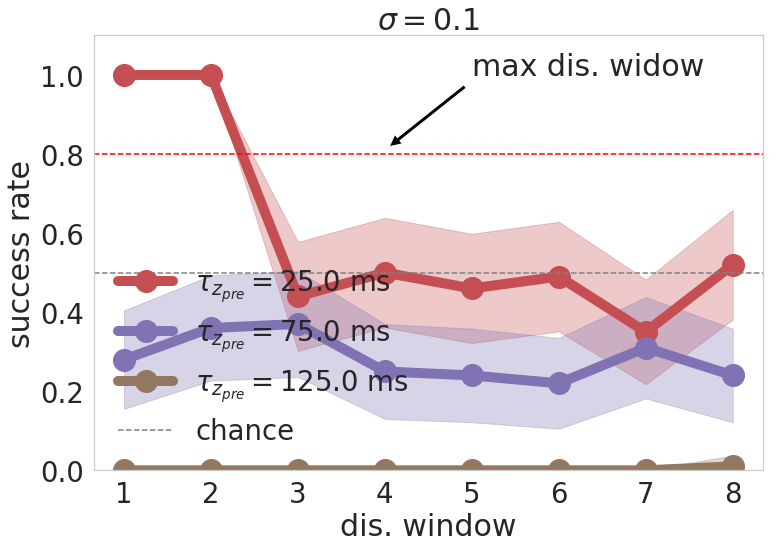

In [97]:
success_list = success_list_nmda

sns.set(font_scale=2.5)
sns.set_style("whitegrid", {'axes.grid': False})

fig = plt.figure()
ax = fig.add_subplot(111)

for index, tau_z_pre in enumerate(tau_z_pre_set):
    label = r'$\tau_{z_{pre}} = $' + str(tau_z_pre * 1000) + ' ms'
    ax.plot(sequence_overlaps * 10, success_list[index], 'o-', color=colors[index + 3], ms=ms, lw=lw, label=label)
    # INTERVAL
    ci_low, ci_upp = sm.stats.proportion_confint(success_list[index] * n_samples, n_samples, alpha=0.05, method='normal')
    low = ci_low
    low[low < 0.0] = 0.0
    high = ci_upp
    ax.fill_between(sequence_overlaps * 10, low, high, color=colors[index + 3], alpha=alpha_graph)
     
ax.set_xlabel('dis. window')
ax.set_ylabel('success rate')
ax.set_title(r'$\sigma = $' + str(sigma_out))

ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.5, ls='--', color='gray', label='chance')
ax.set_ylim([0, 1.1])
ax.legend(frameon=False, loc='lower left')

ax.annotate('max dis. widow', xy=(4, 0.81), xytext=(5, 1.0),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

if False:
    directory = '../plot_producers/'
    file_name = 'noise_nmda_normal' 
    format_string = '.svg'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight', transparent=True)

## Max curves

In [117]:
%%time 
sigma_out = 0.1
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
T_persistence = 0.025
NMDA = True
AMPA = True

sys_number = 15
sigma_out_set = [0.05, 0.1, 0.15]
# sigma_out_set = [0.1]
n_samples = 500
n_samples = 50
tolerance = 0.8
tau_z_pre_set_sys = np.linspace(0.025, 0.150, num=sys_number)
sequence_overlaps = np.linspace(0.1, 0.8, 8)
max_seq_array = np.ones((sys_number, len(sigma_out_set))) * sequence_overlaps[-1] * 10.0

verbose = True

for tau_index, tau_z_pre in enumerate(tau_z_pre_set_sys):
    print('tau_z_pre', tau_z_pre)
    for sigma_index, sigma_out in enumerate(sigma_out_set):
        if verbose:
            print('sigma out', sigma_out)
        for index, sequence_overlap in enumerate(sequence_overlaps):
            if verbose:
                print('seq. overlap', sequence_overlap)
            aux = calculate_dis_success(representation_overlap=1.0, sequence_overlap=sequence_overlap, minicolumns=minicolumns, 
                                        hypercolumns=hypercolumns, tt=0.100, ipi=0, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,  
                                        sigma_out=sigma_out, T_persistence=T_persistence, n_samples=n_samples, n_cues=3.0, 
                                        NMDA=NMDA, AMPA=AMPA, remove=remove, verbose=False)

            success, manager = aux
            if verbose:
                print('success', np.mean(success))
            if np.mean(success) < tolerance:
                max_seq_array[tau_index, sigma_index] = sequence_overlap*10.0 - 1.0
                if verbose: 
                    print('filling max seq array', tau_index, sequence_overlap)
                    print(max_seq_array)
                    print('Broke')
                    print('******')
                break
    if verbose:
        print('----------')
        
nmda_array = np.copy(max_seq_array)

tau_z_pre 0.025
sigma out 0.05
seq. overlap 0.1
success 1.0
seq. overlap 0.2
success 1.0
seq. overlap 0.30000000000000004
success 0.48
filling max seq array 0 0.30000000000000004
[[2. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]]
Broke
******
sigma out 0.1
seq. overlap 0.1
success 1.0
seq. overlap 0.2
success 1.0
seq. overlap 0.30000000000000004
success 0.47
filling max seq array 0 0.30000000000000004
[[2. 2. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]]
Broke
******
sigma out 0.15
seq. overlap 0.1
success 1.0
seq. overlap 0.2
success 1.0
seq. overlap 0.30000000000000004
success 0.49
filling max seq array 0 0.30000000000000004
[[2. 2. 2.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]


success 1.0
seq. overlap 0.30000000000000004
success 1.0
seq. overlap 0.4
success 0.99
seq. overlap 0.5
success 1.0
seq. overlap 0.6
success 1.0
seq. overlap 0.7000000000000001
success 1.0
seq. overlap 0.8
success 1.0
sigma out 0.15
seq. overlap 0.1
success 0.96
seq. overlap 0.2
success 0.98
seq. overlap 0.30000000000000004
success 0.95
seq. overlap 0.4
success 0.94
seq. overlap 0.5
success 0.96
seq. overlap 0.6
success 0.98
seq. overlap 0.7000000000000001
success 0.96
seq. overlap 0.8
success 0.93
----------
tau_z_pre 0.0875
sigma out 0.05
seq. overlap 0.1
success 1.0
seq. overlap 0.2
success 1.0
seq. overlap 0.30000000000000004
success 1.0
seq. overlap 0.4
success 1.0
seq. overlap 0.5
success 1.0
seq. overlap 0.6
success 1.0
seq. overlap 0.7000000000000001
success 1.0
seq. overlap 0.8
success 1.0
sigma out 0.1
seq. overlap 0.1
success 0.99
seq. overlap 0.2
success 1.0
seq. overlap 0.30000000000000004
success 1.0
seq. overlap 0.4
success 1.0
seq. overlap 0.5
success 0.99
seq. overlap 

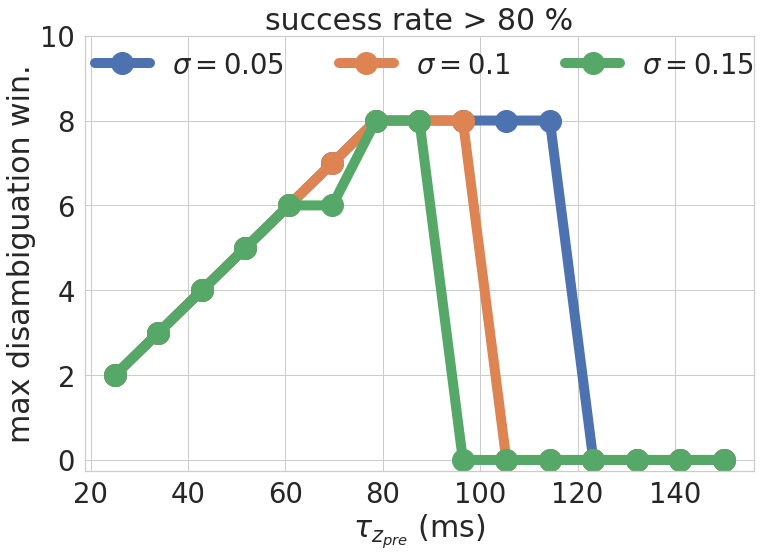

In [118]:
max_seq_array = nmda_array

sns.set(font_scale=2.5)
sns.set_style("whitegrid", {'axes.grid': False})

fig = plt.figure()
ax = fig.add_subplot(111)

for index, max_seq in enumerate(max_seq_array.T):
    label = r'$\sigma = $' + str(sigma_out_set[index])
    ax.plot(tau_z_pre_set_sys * 1000.0, max_seq, 'o-', ms=ms, lw=lw, label=label)
    
ax.set_xlabel(r'$\tau_{z_{pre}}$ (ms)')
ax.set_ylabel('max disambiguation win.')
ax.set_title(r'success rate > 80 %' )

ax.set_ylim([-0.25, 10])

ax.grid()
    
ax.legend(frameon=False, loc=(-0.001, 0.875), ncol=3)

if False:
    directory = '../plot_producers/'
    file_name = 'noise_NMDA' 
    format_string = '.svg'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight', transparent=True)

In [115]:
%%time 
sigma_out = 0.1
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
T_persistence = 0.025
NMDA = True
AMPA = False

sys_number = 15
sigma_out_set = [0.05, 0.1, 0.15]
# sigma_out_set = [0.1]
n_samples = 500
n_samples = 50
tolerance = 0.8
tau_z_pre_set_sys = np.linspace(0.025, 0.150, num=sys_number)
sequence_overlaps = np.linspace(0.1, 0.8, 8)
max_seq_array = np.ones((sys_number, len(sigma_out_set))) * sequence_overlaps[-1] * 10.0

verbose = True

for tau_index, tau_z_pre in enumerate(tau_z_pre_set_sys):
    print('tau_z_pre', tau_z_pre)
    for sigma_index, sigma_out in enumerate(sigma_out_set):
        if verbose:
            print('sigma out', sigma_out)
        for index, sequence_overlap in enumerate(sequence_overlaps):
            if verbose:
                print('seq. overlap', sequence_overlap)
            aux = calculate_dis_success(representation_overlap=1.0, sequence_overlap=sequence_overlap, minicolumns=minicolumns, 
                                        hypercolumns=hypercolumns, tt=0.100, ipi=0, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,  
                                        sigma_out=sigma_out, T_persistence=T_persistence, n_samples=n_samples, n_cues=3.0, 
                                        NMDA=NMDA, remove=remove, AMPA=AMPA, verbose=True)

            success, manager = aux
            if verbose:
                print('success', np.mean(success))
            if np.mean(success) < tolerance:
                print('filling max seq array', tau_index, sequence_overlap)
                max_seq_array[tau_index, sigma_index] = sequence_overlap*10.0 - 1.0
                print(max_seq_array)

                if verbose:
                    print('Broke')
                    print('******')
                break
    if verbose:
        print('----------')
        
ampa_array = np.copy(max_seq_array)

tau_z_pre 0.025
sigma out 0.05
seq. overlap 0.1
representation
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [ 5]
 [16]
 [17]
 [18]
 [19]]
------
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 7, 8, 9, 19, 17, 16, 17, 16, 18, 19, 5, 16, 17, 18, 19]
persistence1 [0.025, 0.018000000000000002, 0.018000000000000002, 0.021, 0.018000000000000002, 0.02, 0.019, 0.018000000000000002, 0.019, 0.028, 0.026000000000000002, 0.026000000000000002, 0.014, 0.021, 0.014, 0.01, 0.022, 0.025, 0.013000000000000001, 0.012, 0.015, 0.02, 0.016, 0.017, 0.014, 0.019, 0.028]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 16, 17, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 6, 8, 9, 4, 5, 4, 5, 4, 6, 7, 8, 9]
persistence2 [0.025, 0.019, 0.017, 0.021, 0.019, 0.019, 0.019, 0.019, 0.02, 0.031, 0.014, 0.011, 0.01, 0.025, 0.025, 0.014, 0.019, 0.013000000000000001, 0.015, 0.019, 0.031, 0.015, 0.011, 0.01, 0.01, 0.025, 0.024, 0.0130

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 8, 7, 9, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 5, 4, 6, 7, 8, 9]
persistence1 [0.024, 0.019, 0.018000000000000002, 0.021, 0.019, 0.02, 0.019, 0.019, 0.019, 0.03, 0.014, 0.012, 0.011, 0.022, 0.021, 0.01, 0.017, 0.01, 0.014, 0.015, 0.012, 0.019, 0.018000000000000002, 0.018000000000000002, 0.029, 0.016, 0.016, 0.011, 0.024, 0.013000000000000001, 0.012, 0.024, 0.015, 0.019, 0.021, 0.017, 0.029]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 5, 14, 16, 17, 18, 19, 18]
persistence2 [0.025, 0.018000000000000002, 0.018000000000000002, 0.021, 0.019, 0.019, 0.02, 0.019, 0.019, 0.03, 0.016, 0.015, 0.01, 0.026000000000000002, 0.025, 0.013000000000000001, 0.018000000000000002, 0.014, 0.013000000000000001, 0.012, 0.018000000000000002, 0.018000000000000002, 0.017, 0.027, 0.014, 0.013000000000000001, 0.027, 0.027, 0.017, 0.02, 0.019,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 7, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 18, 19, 5, 14, 4, 6, 7, 8, 9]
persistence1 [0.025, 0.018000000000000002, 0.019, 0.021, 0.018000000000000002, 0.02, 0.02, 0.019, 0.018000000000000002, 0.029, 0.012, 0.012, 0.013000000000000001, 0.011, 0.025, 0.025, 0.012, 0.02, 0.013000000000000001, 0.016, 0.019, 0.031, 0.014, 0.011, 0.013000000000000001, 0.011, 0.026000000000000002, 0.027, 0.017, 0.012, 0.014, 0.01, 0.019, 0.017, 0.019, 0.018000000000000002, 0.026000000000000002]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 17, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 8, 9, 5, 4, 5, 6, 7, 8, 9]
persistence2 [0.024, 0.018000000000000002, 0.018000000000000002, 0.021, 0.019, 0.02, 0.019, 0.019, 0.019, 0.029, 0.014, 0.01, 0.014, 0.014, 0.025, 0.025, 0.011, 0.018000000000000002, 0.013000000000000001, 0.016, 0.02, 0.031, 0.014, 0.012, 0.025, 0.028, 0.017, 0.02, 0.015, 0.016, 0.012, 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 6, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 17, 18, 19, 14, 13, 5, 16, 17, 18, 19]
persistence1 [0.025, 0.018000000000000002, 0.018000000000000002, 0.021, 0.018000000000000002, 0.019, 0.019, 0.019, 0.019, 0.031, 0.015, 0.011, 0.011, 0.014, 0.011, 0.027, 0.028, 0.02, 0.012, 0.016, 0.019, 0.03, 0.016, 0.016, 0.015, 0.012, 0.025, 0.028, 0.017, 0.017, 0.015, 0.013000000000000001, 0.01, 0.014, 0.021, 0.021, 0.024, 0.028]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 16, 17, 18, 19, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 5, 14, 16, 17, 18, 19, 18]
persistence2 [0.025, 0.018000000000000002, 0.019, 0.021, 0.019, 0.02, 0.019, 0.019, 0.019, 0.031, 0.017, 0.015, 0.026000000000000002, 0.027, 0.016, 0.021, 0.019, 0.01, 0.012, 0.019, 0.019, 0.018000000000000002, 0.028, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.026000000000000002, 0.027, 0.024, 0.013000000000000001, 0.02

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 5, 16, 17, 18, 19, 18, 17, 16, 17, 18, 19, 14, 5, 14, 5, 16, 17, 18, 19]
persistence1 [0.025, 0.018000000000000002, 0.018000000000000002, 0.021, 0.018000000000000002, 0.019, 0.019, 0.018000000000000002, 0.019, 0.027, 0.01, 0.01, 0.012, 0.026000000000000002, 0.025, 0.013000000000000001, 0.02, 0.013000000000000001, 0.015, 0.019, 0.029, 0.011, 0.01, 0.027, 0.029, 0.016, 0.019, 0.018000000000000002, 0.014, 0.019, 0.012, 0.013000000000000001, 0.021, 0.024, 0.022, 0.027]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 17, 16, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 6, 7, 8, 9, 5, 4, 5, 6, 7, 8, 9]
persistence2 [0.024, 0.019, 0.019, 0.021, 0.018000000000000002, 0.019, 0.02, 0.018000000000000002, 0.018000000000000002, 0.026000000000000002, 0.028, 0.027, 0.019, 0.014, 0.014, 0.018000000000000002, 0.028, 0.014, 0.013000000000000001, 0.01, 0.011, 0.01, 0.027, 0.026000000000000002, 0.013000000000000001, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 17, 16, 17, 18, 19, 14, 5, 14, 16, 17, 18, 19]
persistence1 [0.025, 0.018000000000000002, 0.019, 0.021, 0.018000000000000002, 0.02, 0.019, 0.018000000000000002, 0.019, 0.029, 0.013000000000000001, 0.011, 0.01, 0.025, 0.024, 0.012, 0.019, 0.012, 0.016, 0.019, 0.031, 0.014, 0.01, 0.011, 0.011, 0.023, 0.022, 0.01, 0.01, 0.01, 0.016, 0.014, 0.012, 0.017, 0.012, 0.01, 0.014, 0.019, 0.019, 0.027]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 16, 17, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 8, 9, 3, 4, 3, 5, 4, 5, 6, 7, 8, 9]
persistence2 [0.024, 0.019, 0.018000000000000002, 0.021, 0.019, 0.02, 0.02, 0.019, 0.018000000000000002, 0.027, 0.01, 0.01, 0.025, 0.027, 0.012, 0.013000000000000001, 0.011, 0.016, 0.018000000000000002, 0.029, 0.012, 0.01, 0.011, 0.025, 0.029, 0.015, 0.015, 0.015, 0.01, 0.018000000000000002, 0.01, 0.02, 0.012, 0.012, 0.021, 0.0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 18, 19, 4, 5, 4, 6, 7, 8, 9, 8]
persistence1 [0.024, 0.018000000000000002, 0.018000000000000002, 0.022, 0.019, 0.02, 0.02, 0.018000000000000002, 0.019, 0.029, 0.012, 0.011, 0.026000000000000002, 0.015, 0.018000000000000002, 0.013000000000000001, 0.015, 0.019, 0.031, 0.018000000000000002, 0.019, 0.014, 0.023, 0.011, 0.01, 0.014, 0.019, 0.014, 0.021, 0.011, 0.018000000000000002, 0.019, 0.018000000000000002, 0.032, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 16, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 8, 9, 4, 5, 16, 17, 18, 19, 18]
persistence2 [0.024, 0.019, 0.019, 0.021, 0.02, 0.02, 0.02, 0.02, 0.019, 0.032, 0.016, 0.012, 0.025, 0.023, 0.019, 0.013000000000000001, 0.016, 0.019, 0.029, 0.012, 0.011, 0.011, 0.025, 0.027, 0.016, 0.016, 0.019, 0.015, 0.016, 0.018000000000000002, 0.016, 0.019, 0.03, 0.014]
remove 0.01
T_recall 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 16, 18, 19, 4, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.024, 0.018000000000000002, 0.019, 0.021, 0.019, 0.02, 0.018000000000000002, 0.019, 0.019, 0.03, 0.014, 0.011, 0.024, 0.024, 0.012, 0.02, 0.013000000000000001, 0.015, 0.019, 0.029, 0.012, 0.011, 0.01, 0.025, 0.025, 0.013000000000000001, 0.01, 0.014, 0.013000000000000001, 0.016, 0.019, 0.016, 0.018000000000000002, 0.019, 0.028, 0.012, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 18, 5, 8, 9, 8, 9, 8, 9, 7, 6, 8, 9, 3, 5, 16, 17, 18, 19, 18, 19]
persistence2 [0.025, 0.019, 0.018000000000000002, 0.021, 0.018000000000000002, 0.021, 0.019, 0.018000000000000002, 0.02, 0.032, 0.014, 0.01, 0.01, 0.011, 0.026000000000000002, 0.026000000000000002, 0.015, 0.017, 0.01, 0.016, 0.024, 0.01, 0.012, 0.012, 0.01, 0.025, 0.024, 0.012, 0.017, 0.01, 0.015, 0.019, 0.021, 0.015, 0.0260

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 13, 4, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.025, 0.019, 0.018000000000000002, 0.02, 0.019, 0.021, 0.019, 0.019, 0.019, 0.031, 0.015, 0.014, 0.013000000000000001, 0.013000000000000001, 0.026000000000000002, 0.029, 0.019, 0.014, 0.015, 0.018000000000000002, 0.03, 0.017, 0.015, 0.011, 0.025, 0.026000000000000002, 0.016, 0.016, 0.012, 0.011, 0.022, 0.025, 0.017, 0.018000000000000002, 0.02, 0.03, 0.013000000000000001, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 16, 17, 18, 19, 0, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 5, 16, 17, 18, 19, 18]
persistence2 [0.024, 0.019, 0.018000000000000002, 0.02, 0.019, 0.02, 0.019, 0.019, 0.019, 0.029, 0.013000000000000001, 0.01, 0.01, 0.025, 0.024, 0.014, 0.015, 0.015, 0.011, 0.013000000000000001, 0.013000000000000001, 0.014, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 6, 5, 16, 17, 18, 19, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 4, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.025, 0.018000000000000002, 0.019, 0.022, 0.019, 0.02, 0.019, 0.019, 0.019, 0.03, 0.015, 0.01, 0.01, 0.022, 0.022, 0.012, 0.011, 0.018000000000000002, 0.014, 0.016, 0.019, 0.029, 0.012, 0.015, 0.012, 0.012, 0.01, 0.027, 0.029, 0.014, 0.012, 0.017, 0.015, 0.017, 0.017, 0.019, 0.019, 0.03, 0.016, 0.015]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 17, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 6, 8, 9, 5, 16, 17, 18, 19, 18]
persistence2 [0.025, 0.018000000000000002, 0.019, 0.021, 0.018000000000000002, 0.021, 0.02, 0.019, 0.018000000000000002, 0.028, 0.011, 0.011, 0.01, 0.011, 0.025, 0.025, 0.011, 0.019, 0.012, 0.016, 0.018000000000000002, 0.028, 0.013000000000000001, 0.011, 0.01, 0.025, 0.025, 0.011, 0.012, 0.017, 0.02, 0.018000000000000002, 0.016, 0.018000000000000002, 0.0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 8, 9, 12, 5, 16, 17, 18, 19, 18, 17, 16, 5, 6, 7, 8, 9, 8]
persistence1 [0.024, 0.018000000000000002, 0.018000000000000002, 0.02, 0.018000000000000002, 0.02, 0.018000000000000002, 0.019, 0.019, 0.029, 0.013000000000000001, 0.012, 0.01, 0.022, 0.022, 0.011, 0.019, 0.013000000000000001, 0.011, 0.014, 0.017, 0.017, 0.018000000000000002, 0.029, 0.012, 0.022, 0.022, 0.02, 0.017, 0.018000000000000002, 0.02, 0.028, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 17, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 9, 2, 3, 4, 5, 16, 17, 18, 19, 18]
persistence2 [0.025, 0.019, 0.019, 0.021, 0.019, 0.02, 0.019, 0.019, 0.019, 0.029, 0.014, 0.013000000000000001, 0.012, 0.013000000000000001, 0.026000000000000002, 0.025, 0.01, 0.014, 0.013000000000000001, 0.015, 0.019, 0.03, 0.014, 0.012, 0.023, 0.024, 0.013000000000000001, 0.014, 0.013000000000000001, 0.018000000000000002, 0.022, 0.026

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 0, 7, 6, 7, 8, 9, 17, 16, 17, 18, 19, 18, 0, 5, 6, 7, 8, 9, 8, 9, 8]
persistence1 [0.025, 0.019, 0.018000000000000002, 0.021, 0.019, 0.02, 0.019, 0.019, 0.019, 0.028, 0.011, 0.012, 0.01, 0.022, 0.025, 0.015, 0.018000000000000002, 0.015, 0.028, 0.029, 0.014, 0.017, 0.028, 0.013000000000000001, 0.01, 0.012, 0.018000000000000002, 0.016, 0.02, 0.032, 0.015, 0.011, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 7, 8, 9, 3, 4, 5, 16, 17, 18, 19, 18, 19]
persistence2 [0.025, 0.019, 0.019, 0.021, 0.018000000000000002, 0.021, 0.019, 0.017, 0.019, 0.031, 0.016, 0.013000000000000001, 0.01, 0.03, 0.03, 0.02, 0.014, 0.015, 0.019, 0.031, 0.017, 0.016, 0.013000000000000001, 0.011, 0.02, 0.026000000000000002, 0.015, 0.015, 0.014, 0.01, 0.017, 0.014, 0.012, 0.017, 0.019, 0.02, 0.032, 0.015, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 17, 18, 19, 17, 6, 5, 4, 13, 4, 13, 12, 13, 11, 10, 12, 13, 4, 5]
persistence1 [0.025, 0.019, 0.017, 0.021, 0.019, 0.019, 0.02, 0.019, 0.019, 0.029, 0.012, 0.011, 0.01, 0.022, 0.017, 0.013000000000000001, 0.015, 0.025, 0.01, 0.029, 0.02, 0.027, 0.027, 0.021, 0.01, 0.01, 0.025, 0.011, 0.02, 0.016, 0.011, 0.012, 0.019, 0.017, 0.014]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 6, 7, 8, 9, 8, 7, 8, 7, 6, 5, 17, 18, 19, 18, 19, 2, 3, 4, 5, 6, 7, 8, 9]
persistence2 [0.024, 0.018000000000000002, 0.018000000000000002, 0.021, 0.019, 0.018000000000000002, 0.02, 0.019, 0.019, 0.031, 0.014, 0.01, 0.01, 0.011, 0.027, 0.02, 0.012, 0.016, 0.025, 0.01, 0.025, 0.01, 0.01, 0.013000000000000001, 0.022, 0.019, 0.019, 0.029, 0.012, 0.01, 0.01, 0.017, 0.027, 0.021, 0.02, 0.02, 0.017, 0.024]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 17,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 17, 6, 7, 8, 9, 8, 9, 7, 6, 5, 4, 5, 17, 18, 19, 18, 19, 13, 4, 5, 6]
persistence1 [0.024, 0.019, 0.018000000000000002, 0.021, 0.019, 0.018000000000000002, 0.021, 0.019, 0.019, 0.029, 0.013000000000000001, 0.014, 0.014, 0.011, 0.023, 0.017, 0.013000000000000001, 0.014, 0.022, 0.01, 0.01, 0.027, 0.018000000000000002, 0.026000000000000002, 0.023, 0.01, 0.01, 0.021, 0.031, 0.015, 0.014, 0.01, 0.018000000000000002, 0.019, 0.019]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 17, 18, 19, 18, 19, 17, 18, 6, 5, 4, 5, 2, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6]
persistence2 [0.024, 0.019, 0.018000000000000002, 0.021, 0.018000000000000002, 0.019, 0.02, 0.018000000000000002, 0.018000000000000002, 0.03, 0.015, 0.011, 0.01, 0.01, 0.024, 0.018000000000000002, 0.012, 0.015, 0.024, 0.012, 0.012, 0.032, 0.011, 0.019, 0.026000000000000002, 0.026000000000000002, 0.01, 0.02, 0.011, 0.011, 0.028, 0.0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 6, 17, 18, 19, 18, 17, 18, 6, 5, 4, 5, 7, 8, 9, 8, 9, 13, 4, 5, 6]
persistence1 [0.024, 0.019, 0.019, 0.021, 0.019, 0.019, 0.02, 0.019, 0.019, 0.029, 0.013000000000000001, 0.013000000000000001, 0.011, 0.012, 0.012, 0.026000000000000002, 0.019, 0.013000000000000001, 0.015, 0.026000000000000002, 0.012, 0.03, 0.013000000000000001, 0.016, 0.024, 0.021, 0.013000000000000001, 0.022, 0.02, 0.03, 0.016, 0.015, 0.011, 0.011, 0.011, 0.018000000000000002, 0.017]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 6, 17, 18, 19, 18, 19, 18, 17, 18, 17, 6, 5, 4, 3, 2, 1, 0, 2, 3, 4, 5, 6]
persistence2 [0.025, 0.018000000000000002, 0.018000000000000002, 0.021, 0.019, 0.018000000000000002, 0.022, 0.019, 0.018000000000000002, 0.028, 0.013000000000000001, 0.012, 0.011, 0.012, 0.012, 0.025, 0.018000000000000002, 0.013000000000000001, 0.015, 0.025, 0.013000000000000001, 0.01, 0.011, 0.01, 0.027

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 17, 18, 19, 18, 19, 18, 17, 6, 5, 7, 8, 9, 8, 0, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.018000000000000002, 0.019, 0.02, 0.019, 0.019, 0.02, 0.018000000000000002, 0.02, 0.031, 0.013000000000000001, 0.011, 0.011, 0.01, 0.022, 0.018000000000000002, 0.012, 0.015, 0.023, 0.01, 0.01, 0.012, 0.011, 0.016, 0.02, 0.026000000000000002, 0.019, 0.023, 0.03, 0.012, 0.013000000000000001, 0.011, 0.017, 0.023, 0.028, 0.022, 0.026000000000000002]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 17, 6, 7, 8, 9, 8, 9, 8, 9, 7, 8, 6, 5, 17, 18, 19, 18, 5, 6, 17, 18, 19]
persistence2 [0.024, 0.018000000000000002, 0.019, 0.02, 0.017, 0.019, 0.02, 0.019, 0.019, 0.03, 0.015, 0.014, 0.011, 0.01, 0.02, 0.017, 0.012, 0.015, 0.024, 0.012, 0.013000000000000001, 0.013000000000000001, 0.01, 0.03, 0.012, 0.021, 0.024, 0.02, 0.024, 0.033, 0.016, 0.018000000000000002, 0.021, 0.03, 0.021, 0.025]
remove 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 17, 18, 19, 18, 19, 17, 18, 6, 5, 7, 8, 9, 8, 4, 5, 6, 17, 18, 19]
persistence1 [0.025, 0.019, 0.019, 0.021, 0.02, 0.018000000000000002, 0.02, 0.019, 0.019, 0.03, 0.015, 0.012, 0.023, 0.018000000000000002, 0.013000000000000001, 0.015, 0.024, 0.011, 0.01, 0.01, 0.011, 0.033, 0.014, 0.016, 0.023, 0.019, 0.022, 0.031, 0.013000000000000001, 0.011, 0.02, 0.021, 0.022, 0.014, 0.024]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 18, 17, 6, 7, 8, 9, 8, 9, 8, 7, 8, 9, 0, 4, 5, 6, 17, 18, 19, 18, 2, 3, 4, 5]
persistence2 [0.025, 0.018000000000000002, 0.018000000000000002, 0.021, 0.019, 0.019, 0.021, 0.019, 0.018000000000000002, 0.029, 0.014, 0.014, 0.013000000000000001, 0.012, 0.01, 0.026000000000000002, 0.019, 0.012, 0.015, 0.023, 0.01, 0.011, 0.011, 0.011, 0.034, 0.014, 0.012, 0.013000000000000001, 0.012, 0.017, 0.015, 0.02, 0.02, 0.03, 0.013000000000000001, 0.015, 0.022, 0.021, 0.0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 17, 18, 19, 18, 19, 18, 19, 17, 18, 6, 5, 4, 13, 12, 11, 10, 11, 12, 13, 4, 5]
persistence1 [0.025, 0.019, 0.018000000000000002, 0.021, 0.019, 0.018000000000000002, 0.021, 0.019, 0.017, 0.026000000000000002, 0.011, 0.025, 0.02, 0.01, 0.015, 0.025, 0.012, 0.01, 0.01, 0.014, 0.032, 0.011, 0.018000000000000002, 0.028, 0.028, 0.025, 0.02, 0.01, 0.019, 0.023, 0.01, 0.011, 0.015, 0.019, 0.015, 0.016]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 17, 18, 19, 18, 19, 18, 17, 18, 6, 5, 7, 8, 9, 8, 9, 0, 5, 6, 7, 8, 9]
persistence2 [0.025, 0.018000000000000002, 0.018000000000000002, 0.021, 0.019, 0.019, 0.021, 0.019, 0.019, 0.029, 0.013000000000000001, 0.01, 0.01, 0.021, 0.016, 0.013000000000000001, 0.015, 0.025, 0.013000000000000001, 0.012, 0.011, 0.01, 0.032, 0.014, 0.015, 0.025, 0.02, 0.022, 0.031, 0.014, 0.011, 0.012, 0.017, 0.022, 0.03, 0.023, 0.019]
remove 0.01
T_recall 0.7500000000000001

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 5, 16, 17, 18, 19, 18, 19, 17, 16, 17, 18, 19, 14, 5, 14, 5, 16, 17, 18, 19]
persistence1 [0.025, 0.018000000000000002, 0.018000000000000002, 0.022, 0.019, 0.018000000000000002, 0.019, 0.018000000000000002, 0.019, 0.029, 0.016, 0.016, 0.013000000000000001, 0.025, 0.025, 0.015, 0.016, 0.011, 0.015, 0.02, 0.033, 0.014, 0.014, 0.017, 0.016, 0.027, 0.019, 0.026000000000000002, 0.015, 0.016, 0.018000000000000002, 0.015, 0.012, 0.024, 0.026000000000000002, 0.02, 0.022]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 8, 9, 3, 4, 5, 4, 6, 7, 8, 9]
persistence2 [0.024, 0.018000000000000002, 0.02, 0.02, 0.019, 0.019, 0.018000000000000002, 0.02, 0.018000000000000002, 0.029, 0.016, 0.017, 0.014, 0.025, 0.027, 0.018000000000000002, 0.016, 0.017, 0.021, 0.034, 0.015, 0.013000000000000001, 0.022, 0.026000000000000002, 0.014, 0.014, 0.0130000000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 5, 16, 17, 18, 19, 17, 16, 17, 16, 18, 19, 14, 5, 14, 5, 4, 6, 7, 8, 9]
persistence1 [0.024, 0.019, 0.018000000000000002, 0.019, 0.021, 0.019, 0.017, 0.018000000000000002, 0.019, 0.027, 0.013000000000000001, 0.017, 0.017, 0.03, 0.031, 0.021, 0.014, 0.016, 0.018000000000000002, 0.027, 0.012, 0.026000000000000002, 0.025, 0.014, 0.013000000000000001, 0.014, 0.019, 0.017, 0.01, 0.01, 0.013000000000000001, 0.013000000000000001, 0.014, 0.02, 0.016, 0.022]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 6, 7, 8, 4, 3, 2, 3, 1, 2]
persistence2 [0.025, 0.018000000000000002, 0.018000000000000002, 0.02, 0.019, 0.022, 0.019, 0.018000000000000002, 0.02, 0.031, 0.012, 0.015, 0.017, 0.01, 0.021, 0.017, 0.011, 0.02, 0.013000000000000001, 0.015, 0.018000000000000002, 0.028, 0.013000000000000001, 0.011, 0.011, 0.011, 0.01, 0.026000000000000002, 0.02

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 7, 6, 7, 8, 9, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 5, 4, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.018000000000000002, 0.019, 0.023, 0.02, 0.02, 0.018000000000000002, 0.018000000000000002, 0.019, 0.031, 0.011, 0.012, 0.023, 0.021, 0.01, 0.01, 0.01, 0.024, 0.018000000000000002, 0.017, 0.01, 0.017, 0.019, 0.017, 0.027, 0.014, 0.016, 0.013000000000000001, 0.024, 0.027, 0.027, 0.016, 0.02, 0.023, 0.017, 0.027, 0.014]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 5, 6, 7, 8, 9, 7, 6, 7, 8, 9, 4, 5, 6, 7, 8, 9]
persistence2 [0.025, 0.018000000000000002, 0.017, 0.021, 0.019, 0.017, 0.02, 0.021, 0.016, 0.023, 0.012, 0.016, 0.012, 0.026000000000000002, 0.027, 0.024, 0.014, 0.017, 0.019, 0.025, 0.021, 0.024, 0.014, 0.024, 0.021, 0.013000000000000001, 0.015, 0.011, 0.023, 0.025, 0.021, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 6, 5, 17, 18, 19, 18, 17, 16, 17, 16, 18, 19, 14, 5, 14, 5, 16, 17, 18, 19]
persistence1 [0.025, 0.018000000000000002, 0.018000000000000002, 0.021, 0.02, 0.02, 0.019, 0.018000000000000002, 0.019, 0.032, 0.013000000000000001, 0.01, 0.013000000000000001, 0.011, 0.025, 0.023, 0.01, 0.012, 0.018000000000000002, 0.012, 0.019, 0.029, 0.01, 0.025, 0.025, 0.013000000000000001, 0.01, 0.017, 0.013000000000000001, 0.019, 0.022, 0.015, 0.011, 0.024, 0.021, 0.022, 0.025]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 5, 6, 7, 8, 9, 8, 7, 6, 7, 8, 9, 4, 5, 4, 6, 7, 8, 9]
persistence2 [0.024, 0.019, 0.019, 0.022, 0.018000000000000002, 0.019, 0.02, 0.018000000000000002, 0.02, 0.033, 0.013000000000000001, 0.012, 0.01, 0.028, 0.027, 0.01, 0.017, 0.01, 0.015, 0.019, 0.029, 0.012, 0.026000000000000002, 0.031, 0.015, 0.019, 0.02, 0.013000000000000001, 0.025, 0.012, 0.025, 0.023, 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 8, 9, 17, 19, 18, 19, 17, 16, 17, 5, 14, 5, 13, 12, 11, 10, 12]
persistence1 [0.024, 0.018000000000000002, 0.019, 0.02, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.026000000000000002, 0.014, 0.013000000000000001, 0.023, 0.025, 0.016, 0.016, 0.013000000000000001, 0.01, 0.017, 0.012, 0.012, 0.01, 0.024, 0.026000000000000002, 0.01, 0.026000000000000002, 0.02, 0.01, 0.012, 0.018000000000000002, 0.03, 0.031, 0.027, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 16, 5, 7, 8, 9, 7, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence2 [0.025, 0.019, 0.018000000000000002, 0.021, 0.018000000000000002, 0.02, 0.019, 0.019, 0.019, 0.032, 0.014, 0.012, 0.025, 0.025, 0.017, 0.014, 0.016, 0.024, 0.011, 0.011, 0.025, 0.032, 0.019, 0.019, 0.02, 0.01, 0.013000000000000001, 0.023, 0.028, 0.016, 0.019, 0.019, 0.029, 0.011]

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 7, 8, 9, 14, 16, 17, 18, 19, 18, 19, 17, 16, 5, 4, 6, 7, 8, 9, 8, 9, 8]
persistence1 [0.025, 0.018000000000000002, 0.019, 0.021, 0.018000000000000002, 0.02, 0.02, 0.02, 0.019, 0.029, 0.013000000000000001, 0.01, 0.011, 0.012, 0.024, 0.021, 0.015, 0.02, 0.015, 0.01, 0.014, 0.018000000000000002, 0.017, 0.029, 0.014, 0.012, 0.011, 0.015, 0.027, 0.028, 0.014, 0.021, 0.021, 0.02, 0.03, 0.014, 0.018000000000000002, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 17, 16, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 6, 5, 4, 3, 4, 5, 14, 16, 17, 18, 19, 18]
persistence2 [0.024, 0.018000000000000002, 0.018000000000000002, 0.022, 0.019, 0.019, 0.019, 0.02, 0.02, 0.032, 0.014, 0.01, 0.025, 0.028, 0.021, 0.012, 0.015, 0.018000000000000002, 0.025, 0.014, 0.012, 0.015, 0.011, 0.026000000000000002, 0.026000000000000002, 0.012, 0.014, 0.019, 0.027, 0.025, 0.013000000000000001, 0.021, 0.011, 0.014, 0.02

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 0, 13, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.024, 0.019, 0.018000000000000002, 0.02, 0.02, 0.02, 0.019, 0.019, 0.02, 0.033, 0.015, 0.014, 0.01, 0.026000000000000002, 0.027, 0.02, 0.015, 0.015, 0.019, 0.032, 0.014, 0.013000000000000001, 0.015, 0.029, 0.032, 0.013000000000000001, 0.014, 0.014, 0.01, 0.014, 0.021, 0.025, 0.019, 0.018000000000000002, 0.02, 0.026000000000000002, 0.011, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 0, 17, 16, 17, 16, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 8, 9, 2, 3, 4, 5, 16, 17, 18, 19]
persistence2 [0.025, 0.018000000000000002, 0.017, 0.022, 0.018000000000000002, 0.021, 0.019, 0.019, 0.019, 0.032, 0.011, 0.01, 0.011, 0.011, 0.01, 0.01, 0.023, 0.023, 0.012, 0.01, 0.02, 0.012, 0.016, 0.021, 0.032, 0.014, 0.013000000000000001, 0.011, 0.024, 0.025, 0.012, 0.019, 0.011, 0.011, 0.0130000000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 8, 9, 0, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 16, 5, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.016, 0.019, 0.021, 0.018000000000000002, 0.021, 0.019, 0.02, 0.018000000000000002, 0.029, 0.013000000000000001, 0.011, 0.016, 0.023, 0.025, 0.014, 0.019, 0.02, 0.011, 0.014, 0.013000000000000001, 0.015, 0.019, 0.017, 0.017, 0.028, 0.011, 0.011, 0.029, 0.028, 0.018000000000000002, 0.016, 0.017, 0.023, 0.031, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 16, 17, 18, 19, 18]
persistence2 [0.025, 0.018000000000000002, 0.017, 0.02, 0.018000000000000002, 0.021, 0.019, 0.018000000000000002, 0.019, 0.029, 0.013000000000000001, 0.011, 0.01, 0.026000000000000002, 0.026000000000000002, 0.013000000000000001, 0.014, 0.019, 0.01, 0.013000000000000001, 0.012, 0.013000000000000001, 0.019, 0.017, 0.019, 0.029, 0.014, 0.012, 0.03, 0.029, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 8, 9, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 18, 17, 16, 5, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.018000000000000002, 0.019, 0.021, 0.018000000000000002, 0.02, 0.02, 0.017, 0.018000000000000002, 0.025, 0.012, 0.014, 0.012, 0.025, 0.024, 0.015, 0.015, 0.019, 0.016, 0.014, 0.02, 0.019, 0.019, 0.03, 0.017, 0.015, 0.011, 0.016, 0.01, 0.022, 0.015, 0.028, 0.018000000000000002, 0.018000000000000002, 0.02, 0.03, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 17, 16, 17, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 8, 9, 0, 5, 16, 17, 18, 19, 18]
persistence2 [0.024, 0.019, 0.019, 0.019, 0.017, 0.021, 0.017, 0.018000000000000002, 0.019, 0.03, 0.015, 0.027, 0.028, 0.01, 0.012, 0.012, 0.016, 0.018000000000000002, 0.027, 0.01, 0.014, 0.014, 0.028, 0.033, 0.018000000000000002, 0.017, 0.016, 0.011, 0.015, 0.018000000000000002, 0.018000000000000002, 0.017, 0.026000000000000002, 0.011]
remove 0.01
T_r

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 8, 7, 9, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.024, 0.019, 0.018000000000000002, 0.021, 0.02, 0.02, 0.019, 0.019, 0.019, 0.03, 0.013000000000000001, 0.012, 0.013000000000000001, 0.022, 0.022, 0.011, 0.016, 0.011, 0.011, 0.017, 0.015, 0.014, 0.018000000000000002, 0.018000000000000002, 0.017, 0.024, 0.012, 0.015, 0.016, 0.03, 0.03, 0.029, 0.02, 0.014, 0.02, 0.031, 0.014, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 18, 17, 16, 17, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 6, 8, 9, 4, 5, 16, 17, 18, 19, 18, 19]
persistence2 [0.025, 0.02, 0.019, 0.021, 0.019, 0.019, 0.019, 0.019, 0.018000000000000002, 0.028, 0.011, 0.011, 0.014, 0.011, 0.011, 0.026000000000000002, 0.026000000000000002, 0.014, 0.019, 0.013000000000000001, 0.016, 0.02, 0.03, 0.016, 0.015, 0.011, 0.023, 0.025, 0.015, 0.011, 0.019, 0.014, 0.015, 0.016, 0.02

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 18, 19, 13, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.018000000000000002, 0.017, 0.023, 0.018000000000000002, 0.021, 0.02, 0.018000000000000002, 0.019, 0.03, 0.01, 0.014, 0.01, 0.014, 0.027, 0.025, 0.02, 0.011, 0.017, 0.02, 0.032, 0.011, 0.013000000000000001, 0.021, 0.02, 0.027, 0.01, 0.016, 0.018000000000000002, 0.016, 0.024, 0.027, 0.016, 0.016, 0.022, 0.029]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 18, 5, 8, 9, 8, 9, 7, 6, 7, 5, 4, 16, 17, 18, 19, 0]
persistence2 [0.025, 0.018000000000000002, 0.018000000000000002, 0.021, 0.018000000000000002, 0.02, 0.02, 0.017, 0.021, 0.032, 0.012, 0.011, 0.011, 0.028, 0.027, 0.015, 0.017, 0.011, 0.016, 0.021, 0.012, 0.012, 0.01, 0.025, 0.026000000000000002, 0.014, 0.019, 0.022, 0.02, 0.021, 0.015, 0.029, 0.014, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 8, 6, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 4, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.024, 0.018000000000000002, 0.019, 0.022, 0.019, 0.02, 0.019, 0.018000000000000002, 0.019, 0.027, 0.013000000000000001, 0.017, 0.017, 0.024, 0.011, 0.014, 0.015, 0.014, 0.019, 0.031, 0.017, 0.013000000000000001, 0.01, 0.01, 0.026000000000000002, 0.025, 0.02, 0.026000000000000002, 0.017, 0.018000000000000002, 0.019, 0.03, 0.011, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 16, 17, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 6, 7, 8, 9, 0, 4, 5, 16, 17, 18, 19, 18]
persistence2 [0.025, 0.018000000000000002, 0.019, 0.021, 0.019, 0.019, 0.021, 0.018000000000000002, 0.02, 0.031, 0.011, 0.015, 0.02, 0.026000000000000002, 0.025, 0.014, 0.017, 0.014, 0.015, 0.018000000000000002, 0.027, 0.014, 0.015, 0.01, 0.027, 0.027, 0.012, 0.01, 0.01, 0.017, 0.015, 0.01, 0.017, 0.021, 0.016, 0.017, 0.02, 0.031, 0.016]
r

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 17, 18, 19, 18, 19, 18, 19, 17, 6, 5, 4, 13, 4, 5, 6, 7, 8, 9, 8, 9, 0, 12]
persistence1 [0.024, 0.019, 0.019, 0.02, 0.018000000000000002, 0.018000000000000002, 0.02, 0.019, 0.019, 0.03, 0.012, 0.015, 0.024, 0.02, 0.013000000000000001, 0.015, 0.025, 0.015, 0.017, 0.015, 0.015, 0.032, 0.02, 0.028, 0.026000000000000002, 0.027, 0.012, 0.017, 0.017, 0.018000000000000002, 0.02, 0.03, 0.016, 0.014, 0.013000000000000001, 0.011]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 17, 18, 19, 18, 19, 17, 18, 19, 0, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
persistence2 [0.025, 0.017, 0.019, 0.021, 0.021, 0.019, 0.022, 0.015, 0.018000000000000002, 0.029, 0.012, 0.017, 0.023, 0.018000000000000002, 0.01, 0.015, 0.026000000000000002, 0.014, 0.012, 0.031, 0.012, 0.011, 0.013000000000000001, 0.015, 0.02, 0.021, 0.02, 0.027, 0.012, 0.011, 0.011, 0.015, 0.02, 0.022, 0.022, 0.011]
remove 0.01
T_recall 0.7500000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 6, 7, 8, 9, 8, 9, 8, 7, 8, 9, 0, 4, 5, 6, 17, 18, 19, 18, 19, 13, 4, 5, 6]
persistence1 [0.024, 0.019, 0.018000000000000002, 0.021, 0.019, 0.019, 0.018000000000000002, 0.018000000000000002, 0.019, 0.03, 0.011, 0.013000000000000001, 0.015, 0.028, 0.022, 0.012, 0.015, 0.023, 0.011, 0.015, 0.013000000000000001, 0.033, 0.013000000000000001, 0.012, 0.013000000000000001, 0.011, 0.022, 0.02, 0.021, 0.019, 0.024, 0.013000000000000001, 0.016, 0.021, 0.022, 0.021, 0.014]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 17, 18, 19, 18, 17, 6, 5, 7, 8, 9, 4, 3, 6, 7, 8, 9]
persistence2 [0.025, 0.018000000000000002, 0.019, 0.021, 0.02, 0.019, 0.02, 0.018000000000000002, 0.019, 0.029, 0.012, 0.016, 0.018000000000000002, 0.019, 0.015, 0.013000000000000001, 0.014, 0.02, 0.01, 0.012, 0.025, 0.023, 0.024, 0.019, 0.023, 0.027, 0.011, 0.01, 0.022, 0.031, 0.019, 0.024]
remove 0.01
T_recall 0.750000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 0, 17, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 5, 4, 13, 4, 5, 17, 18, 19, 18, 0, 12]
persistence1 [0.024, 0.019, 0.017, 0.022, 0.02, 0.018000000000000002, 0.02, 0.021, 0.02, 0.034, 0.019, 0.013000000000000001, 0.012, 0.01, 0.022, 0.018000000000000002, 0.013000000000000001, 0.014, 0.024, 0.012, 0.013000000000000001, 0.015, 0.013000000000000001, 0.014, 0.031, 0.022, 0.029, 0.028, 0.026000000000000002, 0.011, 0.016, 0.021, 0.02, 0.027, 0.011, 0.011, 0.01]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 0, 7, 6, 17, 18, 19, 18, 17, 18, 0, 3, 4, 5, 6, 7, 8, 9, 8, 9, 1, 2, 3, 4, 5]
persistence2 [0.024, 0.019, 0.018000000000000002, 0.021, 0.019, 0.02, 0.019, 0.019, 0.018000000000000002, 0.029, 0.014, 0.013000000000000001, 0.014, 0.019, 0.01, 0.02, 0.016, 0.013000000000000001, 0.014, 0.023, 0.016, 0.015, 0.027, 0.01, 0.011, 0.012, 0.016, 0.026000000000000002, 0.022, 0.022, 0.02, 0.027, 0.014, 0.014, 0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 17, 6, 7, 8, 9, 8, 9, 8, 7, 8, 6, 5, 17, 18, 19, 18, 4, 5, 6, 17, 18, 19]
persistence1 [0.025, 0.018000000000000002, 0.017, 0.02, 0.02, 0.018000000000000002, 0.019, 0.016, 0.018000000000000002, 0.03, 0.017, 0.015, 0.022, 0.017, 0.01, 0.015, 0.027, 0.016, 0.013000000000000001, 0.012, 0.03, 0.012, 0.02, 0.027, 0.018000000000000002, 0.023, 0.03, 0.01, 0.01, 0.02, 0.022, 0.033, 0.019, 0.022]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 17, 18, 19, 18, 19, 18, 19, 17, 6, 5, 4, 7, 8, 9, 8, 0, 3, 2, 3, 4, 5, 6]
persistence2 [0.025, 0.018000000000000002, 0.019, 0.022, 0.018000000000000002, 0.019, 0.02, 0.017, 0.019, 0.029, 0.014, 0.011, 0.022, 0.02, 0.012, 0.015, 0.027, 0.018000000000000002, 0.017, 0.015, 0.011, 0.019, 0.011, 0.013000000000000001, 0.023, 0.018000000000000002, 0.02, 0.021, 0.033, 0.016, 0.01, 0.013000000000000001, 0.011, 0.011, 0.023, 0.019, 0.02]
remove 0.01
T_recall 0.750

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 6, 7, 8, 9, 8, 7, 9, 0, 5, 17, 18, 19, 18, 0, 12, 13, 4, 5, 6, 7, 8]
persistence1 [0.025, 0.018000000000000002, 0.019, 0.019, 0.02, 0.019, 0.019, 0.019, 0.02, 0.032, 0.017, 0.018000000000000002, 0.015, 0.022, 0.018000000000000002, 0.013000000000000001, 0.016, 0.026000000000000002, 0.01, 0.017, 0.032, 0.012, 0.012, 0.013000000000000001, 0.018000000000000002, 0.022, 0.035, 0.02, 0.01, 0.013000000000000001, 0.017, 0.026000000000000002, 0.022, 0.022, 0.022, 0.019]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 17, 6, 7, 8, 9, 8, 9, 7, 5, 4, 5, 17, 18, 19, 18, 19, 18, 2, 3, 2, 4, 5, 6]
persistence2 [0.025, 0.018000000000000002, 0.018000000000000002, 0.021, 0.018000000000000002, 0.019, 0.02, 0.017, 0.02, 0.032, 0.013000000000000001, 0.012, 0.026000000000000002, 0.019, 0.014, 0.016, 0.025, 0.012, 0.013000000000000001, 0.013000000000000001, 0.032, 0.025, 0.024, 0.01, 0.018000000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 17, 18, 19, 18, 19, 18, 17, 18, 19, 0, 5, 7, 8, 9, 8, 9, 8, 0, 13, 4, 5, 6, 17]
persistence1 [0.026000000000000002, 0.017, 0.02, 0.021, 0.02, 0.019, 0.021, 0.019, 0.018000000000000002, 0.028, 0.015, 0.011, 0.011, 0.01, 0.025, 0.018000000000000002, 0.011, 0.016, 0.029, 0.021, 0.022, 0.014, 0.03, 0.014, 0.01, 0.011, 0.014, 0.02, 0.019, 0.027, 0.013000000000000001, 0.014, 0.014, 0.012, 0.015, 0.02, 0.01, 0.021, 0.012]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 17, 18, 19, 18, 19, 17, 6, 5, 4, 3, 2, 1, 0, 1, 3, 4, 5, 6]
persistence2 [0.025, 0.018000000000000002, 0.018000000000000002, 0.021, 0.017, 0.018000000000000002, 0.02, 0.019, 0.02, 0.031, 0.018000000000000002, 0.017, 0.011, 0.01, 0.025, 0.02, 0.013000000000000001, 0.016, 0.023, 0.012, 0.013000000000000001, 0.011, 0.03, 0.016, 0.026000000000000002, 0.029, 0.029, 0.03, 0.018000000000000002, 0.01, 0.029, 0.014, 0.017, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 18, 19, 18, 19, 18, 19, 18, 17, 18, 6, 5, 7, 8, 9, 8, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.017, 0.018000000000000002, 0.022, 0.019, 0.02, 0.02, 0.019, 0.019, 0.033, 0.019, 0.014, 0.012, 0.012, 0.022, 0.018000000000000002, 0.016, 0.026000000000000002, 0.015, 0.014, 0.012, 0.016, 0.01, 0.034, 0.012, 0.019, 0.021, 0.019, 0.02, 0.026000000000000002, 0.01, 0.021, 0.022, 0.03, 0.02, 0.027]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 17, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 5, 18, 19, 18, 0, 3, 4, 5, 6, 7, 8, 9]
persistence2 [0.024, 0.017, 0.017, 0.02, 0.017, 0.019, 0.02, 0.02, 0.018000000000000002, 0.029, 0.01, 0.015, 0.014, 0.021, 0.017, 0.01, 0.014, 0.025, 0.016, 0.015, 0.01, 0.01, 0.025, 0.011, 0.021, 0.026000000000000002, 0.023, 0.033, 0.014, 0.011, 0.012, 0.012, 0.013000000000000001, 0.015, 0.021, 0.016, 0.028]
remove 0.01
success 0.45
filling max seq array 0 0.30000000000000004
[[

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 12, 14, 13, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.024, 0.02, 0.017, 0.021, 0.017, 0.018000000000000002, 0.02, 0.02, 0.02, 0.027, 0.01, 0.01, 0.011, 0.012, 0.026000000000000002, 0.026000000000000002, 0.02, 0.013000000000000001, 0.015, 0.021, 0.034, 0.015, 0.014, 0.016, 0.027, 0.027, 0.012, 0.014, 0.02, 0.01, 0.012, 0.01, 0.032, 0.019, 0.018000000000000002, 0.018000000000000002, 0.023, 0.012, 0.014]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 5, 7, 8, 9, 8, 9, 7, 6, 7, 8, 9, 3, 4, 5, 4, 5, 14, 16, 17, 18, 19, 18]
persistence2 [0.026000000000000002, 0.017, 0.018000000000000002, 0.024, 0.017, 0.017, 0.019, 0.018000000000000002, 0.019, 0.035, 0.016, 0.011, 0.012, 0.013000000000000001, 0.013000000000000001, 0.028, 0.023, 0.015, 0.019, 0.028, 0.011, 0.016, 0.027, 0.029, 0.011, 0.01, 0.015, 0.012, 0.018000000000000002, 0.0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 7, 6, 5, 16, 17, 18, 19, 18, 19, 17, 16, 17, 18, 19, 13, 14, 5, 14, 17, 18]
persistence1 [0.025, 0.019, 0.019, 0.021, 0.019, 0.02, 0.017, 0.019, 0.018000000000000002, 0.025, 0.011, 0.01, 0.019, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.019, 0.016, 0.012, 0.019, 0.032, 0.015, 0.01, 0.029, 0.022, 0.014, 0.01, 0.025, 0.01, 0.02, 0.024, 0.014, 0.021, 0.023]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 8, 9, 3, 5, 16, 17, 18, 19]
persistence2 [0.024, 0.018000000000000002, 0.018000000000000002, 0.023, 0.016, 0.017, 0.02, 0.018000000000000002, 0.018000000000000002, 0.029, 0.014, 0.019, 0.014, 0.022, 0.025, 0.016, 0.012, 0.017, 0.02, 0.025, 0.012, 0.01, 0.012, 0.025, 0.027, 0.017, 0.01, 0.019, 0.011, 0.028, 0.017, 0.019, 0.021, 0.035]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 14, 13, 12, 13, 14, 5, 4, 6, 7, 8, 9]
persistence1 [0.024, 0.016, 0.018000000000000002, 0.024, 0.019, 0.018000000000000002, 0.01, 0.019, 0.019, 0.03, 0.017, 0.016, 0.016, 0.026000000000000002, 0.031, 0.022, 0.014, 0.016, 0.02, 0.034, 0.014, 0.013000000000000001, 0.015, 0.029, 0.036000000000000004, 0.027, 0.025, 0.029, 0.013000000000000001, 0.016, 0.026000000000000002, 0.01, 0.015, 0.017, 0.02, 0.033]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 17, 16, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 8, 3, 5, 4, 6, 7, 8]
persistence2 [0.025, 0.019, 0.018000000000000002, 0.022, 0.021, 0.021, 0.019, 0.019, 0.018000000000000002, 0.026000000000000002, 0.01, 0.01, 0.016, 0.016, 0.021, 0.015, 0.011, 0.012, 0.018000000000000002, 0.013000000000000001, 0.013000000000000001, 0.02, 0.029, 0.024, 0.025, 0.019, 0.016, 0.012, 0.021, 0.01, 0.021, 0.0130000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 5, 16, 17, 18, 19, 18, 19, 17, 16, 5, 14, 13, 14, 12, 11, 12, 13, 14]
persistence1 [0.025, 0.018000000000000002, 0.018000000000000002, 0.017, 0.021, 0.019, 0.02, 0.018000000000000002, 0.021, 0.034, 0.016, 0.012, 0.025, 0.018000000000000002, 0.012, 0.022, 0.013000000000000001, 0.014, 0.022, 0.035, 0.016, 0.012, 0.024, 0.016, 0.014, 0.019, 0.02, 0.01, 0.028, 0.025, 0.014, 0.019, 0.017]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 5, 4, 3, 4, 5, 14, 16, 17, 18, 19]
persistence2 [0.024, 0.016, 0.017, 0.018000000000000002, 0.016, 0.02, 0.019, 0.017, 0.021, 0.032, 0.015, 0.016, 0.013000000000000001, 0.028, 0.022, 0.01, 0.012, 0.017, 0.02, 0.03, 0.019, 0.019, 0.014, 0.028, 0.03, 0.014, 0.024, 0.027, 0.025, 0.013000000000000001, 0.011, 0.012, 0.018000000000000002, 0.018000000000000002, 0.016, 0.02, 0.023]
remove 0.01
T_recall 0.750000000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 0, 7, 6, 5, 16, 17, 18, 19, 18, 17, 16, 17, 18, 19, 13, 5, 16, 17, 18, 19]
persistence1 [0.025, 0.018000000000000002, 0.019, 0.021, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.021, 0.02, 0.032, 0.011, 0.015, 0.01, 0.023, 0.026000000000000002, 0.021, 0.012, 0.017, 0.018000000000000002, 0.021, 0.013000000000000001, 0.019, 0.029, 0.034, 0.019, 0.016, 0.021, 0.012, 0.011, 0.017, 0.02, 0.021, 0.023]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 8, 9, 8, 9, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2]
persistence2 [0.024, 0.02, 0.018000000000000002, 0.021, 0.019, 0.019, 0.019, 0.018000000000000002, 0.019, 0.03, 0.013000000000000001, 0.014, 0.011, 0.022, 0.025, 0.019, 0.018000000000000002, 0.021, 0.011, 0.02, 0.02, 0.011, 0.026000000000000002, 0.033, 0.028, 0.026000000000000002, 0.014, 0.019, 0.024, 0.033, 0.018000000000000002, 0.011]
remove 0.01
T_recall 0.750

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 5, 16, 17, 18, 19, 18, 17, 16, 17, 18, 19, 0, 13, 4, 5, 6, 7, 8, 9]
persistence1 [0.026000000000000002, 0.019, 0.021, 0.021, 0.017, 0.019, 0.017, 0.02, 0.018000000000000002, 0.026000000000000002, 0.011, 0.016, 0.014, 0.01, 0.024, 0.024, 0.018000000000000002, 0.013000000000000001, 0.012, 0.012, 0.023, 0.014, 0.012, 0.023, 0.02, 0.012, 0.01, 0.019, 0.014, 0.012, 0.013000000000000001, 0.012, 0.024, 0.017, 0.02, 0.02, 0.031]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 16, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 8, 4, 5, 16, 17, 18, 19, 18]
persistence2 [0.025, 0.017, 0.019, 0.022, 0.018000000000000002, 0.021, 0.02, 0.016, 0.018000000000000002, 0.028, 0.014, 0.022, 0.026000000000000002, 0.023, 0.02, 0.011, 0.02, 0.017, 0.031, 0.017, 0.01, 0.011, 0.017, 0.027, 0.017, 0.017, 0.015, 0.01, 0.02, 0.013000000000000001, 0.019, 0.019, 0.036000000000000004, 0.015]
remove 0.01
T_recall 0.750

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 18, 19, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.019, 0.018000000000000002, 0.02, 0.019, 0.02, 0.019, 0.016, 0.019, 0.036000000000000004, 0.021, 0.015, 0.013000000000000001, 0.03, 0.025, 0.012, 0.02, 0.014, 0.017, 0.019, 0.032, 0.02, 0.022, 0.015, 0.024, 0.022, 0.013000000000000001, 0.016, 0.018000000000000002, 0.013000000000000001, 0.017, 0.016, 0.02, 0.029, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 18, 17, 16, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 8, 4, 5, 16, 17, 18, 19, 18, 19]
persistence2 [0.024, 0.018000000000000002, 0.017, 0.022, 0.018000000000000002, 0.021, 0.019, 0.02, 0.021, 0.035, 0.014, 0.01, 0.01, 0.011, 0.01, 0.025, 0.026000000000000002, 0.018000000000000002, 0.012, 0.014, 0.021, 0.031, 0.017, 0.02, 0.013000000000000001, 0.026000000000000002, 0.026000000000000002, 0.011, 0.011, 0.01, 0.025, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 8, 18, 19, 18, 19, 18, 17, 16, 17, 5, 4, 6, 7, 8, 9, 8, 9]
persistence1 [0.023, 0.018000000000000002, 0.018000000000000002, 0.022, 0.015, 0.015, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.032, 0.019, 0.014, 0.014, 0.022, 0.022, 0.018000000000000002, 0.013000000000000001, 0.025, 0.01, 0.011, 0.012, 0.024, 0.023, 0.014, 0.023, 0.014, 0.019, 0.019, 0.018000000000000002, 0.024, 0.011, 0.014]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 16, 17, 18, 17, 19, 9, 8, 9, 7, 6, 5, 4, 16, 17, 18, 19, 18, 13, 12]
persistence2 [0.024, 0.021, 0.017, 0.021, 0.018000000000000002, 0.02, 0.019, 0.017, 0.018000000000000002, 0.026000000000000002, 0.021, 0.016, 0.023, 0.023, 0.014, 0.014, 0.011, 0.016, 0.018000000000000002, 0.012, 0.01, 0.023, 0.021, 0.019, 0.014, 0.025, 0.02, 0.019, 0.031, 0.012, 0.015, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 0, 7, 6, 7, 8, 9, 18, 17, 16, 17, 19, 18, 19, 13, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.024, 0.017, 0.022, 0.02, 0.018000000000000002, 0.019, 0.019, 0.02, 0.018000000000000002, 0.029, 0.011, 0.011, 0.013000000000000001, 0.011, 0.02, 0.014, 0.014, 0.019, 0.021, 0.013000000000000001, 0.028, 0.027, 0.013000000000000001, 0.024, 0.012, 0.011, 0.01, 0.013000000000000001, 0.022, 0.019, 0.02, 0.022, 0.033, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 18, 6, 7, 8, 9, 8, 9, 8, 7, 6, 5, 4, 16, 17, 18, 19, 18, 3]
persistence2 [0.024, 0.02, 0.02, 0.02, 0.017, 0.022, 0.019, 0.019, 0.017, 0.024, 0.017, 0.018000000000000002, 0.01, 0.024, 0.025, 0.011, 0.012, 0.013000000000000001, 0.012, 0.017, 0.027, 0.016, 0.018000000000000002, 0.017, 0.027, 0.026000000000000002, 0.01, 0.022, 0.026000000000000002, 0.017, 0.022, 0.016, 0.027, 0.014, 0.011]
remove 0.01
T_recall 0.7500000000000001
s

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 0, 13, 16, 17, 18, 19, 18, 19, 17, 16, 5, 6, 7, 8, 9, 8, 12, 13, 4, 5, 6]
persistence1 [0.025, 0.018000000000000002, 0.016, 0.021, 0.018000000000000002, 0.018000000000000002, 0.019, 0.022, 0.017, 0.024, 0.012, 0.013000000000000001, 0.011, 0.014, 0.012, 0.013000000000000001, 0.019, 0.03, 0.018000000000000002, 0.018000000000000002, 0.032, 0.031, 0.026000000000000002, 0.016, 0.027, 0.022, 0.031, 0.012, 0.015, 0.012, 0.02, 0.027, 0.019, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 16, 17, 5, 6, 7, 8, 9, 8, 9, 7, 6, 9, 4, 5, 16, 17, 18, 19, 18]
persistence2 [0.023, 0.019, 0.02, 0.022, 0.019, 0.022, 0.018000000000000002, 0.018000000000000002, 0.021, 0.036000000000000004, 0.019, 0.016, 0.023, 0.026000000000000002, 0.012, 0.015, 0.012, 0.015, 0.019, 0.033, 0.018000000000000002, 0.014, 0.028, 0.036000000000000004, 0.012, 0.012, 0.015, 0.018000000000000002, 0.017, 0.018000000000000002, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 5, 16, 17, 18, 19, 18, 19, 17, 16, 17, 18, 19, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.019, 0.017, 0.02, 0.019, 0.02, 0.02, 0.02, 0.02, 0.034, 0.021, 0.018000000000000002, 0.012, 0.019, 0.028, 0.021, 0.013000000000000001, 0.019, 0.02, 0.033, 0.017, 0.013000000000000001, 0.013000000000000001, 0.021, 0.013000000000000001, 0.02, 0.012, 0.013000000000000001, 0.022, 0.014, 0.021, 0.017, 0.026000000000000002, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 0, 17, 16, 18, 19, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 5, 16, 17, 18, 19, 18]
persistence2 [0.024, 0.016, 0.019, 0.022, 0.018000000000000002, 0.02, 0.019, 0.018000000000000002, 0.018000000000000002, 0.024, 0.01, 0.012, 0.015, 0.01, 0.024, 0.023, 0.013000000000000001, 0.015, 0.011, 0.014, 0.014, 0.019, 0.017, 0.018000000000000002, 0.027, 0.014, 0.017, 0.026000000000000002, 0.015, 0.019, 0.021, 0.018000000000000002, 0.

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 0, 17, 6, 8, 9, 8, 9, 8, 7, 9, 0, 13, 4, 5, 6, 17, 18, 19, 0, 10, 11, 12, 13, 4, 5]
persistence1 [0.026000000000000002, 0.019, 0.017, 0.022, 0.019, 0.019, 0.019, 0.021, 0.018000000000000002, 0.032, 0.022, 0.016, 0.01, 0.011, 0.01, 0.018000000000000002, 0.017, 0.012, 0.022, 0.016, 0.019, 0.01, 0.029, 0.018000000000000002, 0.01, 0.012, 0.014, 0.024, 0.019, 0.022, 0.02, 0.028, 0.01, 0.01, 0.01, 0.016, 0.022, 0.021, 0.016]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 17, 18, 19, 18, 19, 17, 5, 7, 8, 9, 4, 5, 6, 7, 8]
persistence2 [0.025, 0.018000000000000002, 0.019, 0.021, 0.018000000000000002, 0.018000000000000002, 0.023, 0.017, 0.022, 0.035, 0.01, 0.012, 0.023, 0.016, 0.011, 0.015, 0.023, 0.01, 0.017, 0.013000000000000001, 0.022, 0.01, 0.012, 0.019, 0.02, 0.025, 0.014, 0.013000000000000001, 0.025, 0.018000000000000002, 0.03, 0.019]
remove 0.01
T_recall 0.7500000000000001
s1 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 17, 18, 19, 18, 19, 17, 18, 19, 13, 4, 5, 6, 7, 8, 9, 8, 3]
persistence1 [0.024, 0.019, 0.021, 0.021, 0.02, 0.019, 0.021, 0.019, 0.019, 0.032, 0.015, 0.015, 0.026000000000000002, 0.019, 0.011, 0.015, 0.022, 0.01, 0.011, 0.032, 0.017, 0.014, 0.013000000000000001, 0.015, 0.022, 0.023, 0.021, 0.021, 0.029, 0.014, 0.02]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 17, 18, 19, 18, 19, 18, 19, 17, 6, 5, 7, 8, 9, 8, 4, 5, 6, 17, 18]
persistence2 [0.025, 0.019, 0.02, 0.019, 0.021, 0.018000000000000002, 0.02, 0.021, 0.017, 0.026000000000000002, 0.012, 0.016, 0.014, 0.021, 0.015, 0.014, 0.014, 0.024, 0.014, 0.017, 0.017, 0.011, 0.019, 0.016, 0.019, 0.026000000000000002, 0.02, 0.021, 0.032, 0.013000000000000001, 0.018000000000000002, 0.019, 0.021, 0.02, 0.016]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 6, 7, 8, 9, 8, 9, 8, 7,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 17, 18, 19, 18, 19, 18, 19, 17, 6, 5, 4, 13, 12, 11, 12, 13, 4, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.018000000000000002, 0.019, 0.02, 0.019, 0.019, 0.021, 0.019, 0.018000000000000002, 0.031, 0.019, 0.014, 0.011, 0.026000000000000002, 0.018000000000000002, 0.014, 0.016, 0.027, 0.017, 0.012, 0.011, 0.013000000000000001, 0.03, 0.021, 0.027, 0.031, 0.028, 0.029, 0.025, 0.012, 0.017, 0.02, 0.019, 0.012, 0.02, 0.019, 0.024]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 6, 7, 8, 9, 8, 9, 8, 9, 7, 8, 6, 5, 17, 18, 19, 3, 4, 5, 6, 7, 8, 9, 8, 9]
persistence2 [0.025, 0.019, 0.018000000000000002, 0.021, 0.017, 0.015, 0.019, 0.02, 0.017, 0.028, 0.014, 0.019, 0.016, 0.02, 0.017, 0.01, 0.012, 0.018000000000000002, 0.013000000000000001, 0.011, 0.012, 0.01, 0.026000000000000002, 0.013000000000000001, 0.013000000000000001, 0.023, 0.017, 0.015, 0.027, 0.016, 0.016, 0.018000000000000002, 0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 17, 6, 7, 8, 9, 8, 9, 7, 6, 5, 4, 13, 12, 11, 10, 12, 13, 4, 5, 6, 17]
persistence1 [0.025, 0.015, 0.015, 0.019, 0.019, 0.019, 0.022, 0.018000000000000002, 0.019, 0.031, 0.011, 0.013000000000000001, 0.013000000000000001, 0.023, 0.019, 0.013000000000000001, 0.015, 0.027, 0.014, 0.01, 0.032, 0.02, 0.028, 0.03, 0.02, 0.011, 0.03, 0.03, 0.031, 0.011, 0.021, 0.017, 0.015, 0.015, 0.014]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 0, 17, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 17]
persistence2 [0.025, 0.015, 0.019, 0.023, 0.018000000000000002, 0.018000000000000002, 0.02, 0.02, 0.018000000000000002, 0.032, 0.018000000000000002, 0.017, 0.014, 0.013000000000000001, 0.011, 0.013000000000000001, 0.014, 0.011, 0.012, 0.022, 0.017, 0.016, 0.011, 0.012, 0.031, 0.025, 0.029, 0.029, 0.031, 0.031, 0.031, 0.027, 0.014, 0.01, 0.02, 0.017, 0.019, 0.016, 0.019]
remove 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 17, 18, 19, 18, 19, 17, 18, 6, 5, 7, 8, 9, 13, 4, 5, 6, 17, 18, 19]
persistence1 [0.025, 0.017, 0.019, 0.021, 0.018000000000000002, 0.023, 0.015, 0.017, 0.02, 0.031, 0.014, 0.021, 0.013000000000000001, 0.019, 0.018000000000000002, 0.012, 0.012, 0.014, 0.014, 0.016, 0.019, 0.017, 0.015, 0.011, 0.02, 0.02, 0.021, 0.02, 0.022, 0.016, 0.01, 0.016, 0.021, 0.02, 0.022, 0.015, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 6, 7, 8, 9, 8, 9, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19]
persistence2 [0.024, 0.02, 0.017, 0.023, 0.019, 0.017, 0.022, 0.02, 0.019, 0.032, 0.013000000000000001, 0.012, 0.011, 0.018000000000000002, 0.028, 0.021, 0.012, 0.019, 0.031, 0.012, 0.015, 0.036000000000000004, 0.018000000000000002, 0.028, 0.028, 0.03, 0.03, 0.01, 0.013000000000000001, 0.017, 0.011, 0.02, 0.018000000000000002, 0.024, 0.015, 0.017]
remove 0.01
T_recall 0.7500000000000001
s1 1

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 7, 6, 5, 17, 18, 19, 18, 19, 18, 17, 16, 19, 5, 16, 17, 18, 19]
persistence1 [0.024, 0.016, 0.016, 0.016, 0.021, 0.017, 0.017, 0.018000000000000002, 0.018000000000000002, 0.026000000000000002, 0.01, 0.028, 0.018000000000000002, 0.01, 0.013000000000000001, 0.018000000000000002, 0.011, 0.013000000000000001, 0.021, 0.011, 0.013000000000000001, 0.014, 0.016, 0.012, 0.012, 0.011, 0.01, 0.012, 0.014, 0.013000000000000001, 0.015, 0.019, 0.017]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 17, 18, 16, 5, 7, 8, 9, 8, 7, 6, 9, 5, 6, 7, 6, 8, 9]
persistence2 [0.025, 0.016, 0.016, 0.017, 0.02, 0.017, 0.016, 0.017, 0.017, 0.023, 0.024, 0.01, 0.014, 0.011, 0.012, 0.014, 0.021, 0.01, 0.01, 0.02, 0.018000000000000002, 0.01, 0.017, 0.016, 0.015, 0.019, 0.011, 0.01, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 6, 8, 9, 17, 19, 18,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 5, 16, 17, 18, 19, 17, 16, 19, 14, 5, 14, 5, 16, 17, 18, 19]
persistence1 [0.025, 0.017, 0.017, 0.017, 0.02, 0.017, 0.017, 0.017, 0.017, 0.023, 0.01, 0.019, 0.017, 0.021, 0.011, 0.013000000000000001, 0.014, 0.02, 0.01, 0.011, 0.02, 0.02, 0.014, 0.01, 0.012, 0.01, 0.01, 0.015, 0.015, 0.02, 0.027]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 17, 18, 16, 5, 7, 8, 9, 7, 6, 7, 8, 9, 4, 5, 6, 7, 8, 9]
persistence2 [0.025, 0.017, 0.017, 0.017, 0.02, 0.017, 0.018000000000000002, 0.018000000000000002, 0.017, 0.026000000000000002, 0.01, 0.01, 0.022, 0.011, 0.016, 0.012, 0.014, 0.012, 0.013000000000000001, 0.019, 0.012, 0.019, 0.025, 0.014, 0.011, 0.018000000000000002, 0.01, 0.012, 0.012, 0.012, 0.02, 0.016, 0.016, 0.023]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 8, 6, 5, 16, 18, 19, 18, 19, 17, 16, 19, 14, 5, 16, 17, 18, 19]
persistence1 [0.024,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 7, 6, 8, 9, 17, 18, 19, 17, 16, 19, 5, 14, 5, 16, 17, 18, 19]
persistence1 [0.025, 0.017, 0.017, 0.016, 0.02, 0.018000000000000002, 0.018000000000000002, 0.017, 0.018000000000000002, 0.026000000000000002, 0.012, 0.014, 0.012, 0.013000000000000001, 0.011, 0.01, 0.026000000000000002, 0.013000000000000001, 0.013000000000000001, 0.016, 0.01, 0.01, 0.014, 0.01, 0.023, 0.016, 0.016, 0.01, 0.011, 0.01, 0.016, 0.011, 0.015, 0.017]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 16, 5, 6, 7, 8, 9, 8, 9, 8, 7, 8, 9, 6, 9, 4, 5, 4, 6, 7, 8]
persistence2 [0.024, 0.016, 0.016, 0.016, 0.02, 0.018000000000000002, 0.017, 0.017, 0.018000000000000002, 0.027, 0.012, 0.011, 0.025, 0.011, 0.011, 0.021, 0.011, 0.012, 0.014, 0.023, 0.012, 0.012, 0.01, 0.01, 0.025, 0.01, 0.011, 0.015, 0.019, 0.011, 0.019, 0.01, 0.02, 0.021, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 5, 16, 17, 18, 19, 17, 16, 18, 19, 14, 5, 16, 17, 18, 19]
persistence1 [0.024, 0.017, 0.016, 0.017, 0.02, 0.018000000000000002, 0.018000000000000002, 0.017, 0.017, 0.024, 0.023, 0.019, 0.021, 0.011, 0.014, 0.014, 0.021, 0.019, 0.019, 0.01, 0.015, 0.015, 0.01, 0.012, 0.021, 0.022, 0.021, 0.026000000000000002]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 9, 4, 5, 6, 7, 8]
persistence2 [0.024, 0.017, 0.017, 0.016, 0.02, 0.018000000000000002, 0.017, 0.017, 0.018000000000000002, 0.027, 0.012, 0.013000000000000001, 0.011, 0.015, 0.014, 0.01, 0.021, 0.01, 0.013000000000000001, 0.013000000000000001, 0.022, 0.013000000000000001, 0.012, 0.012, 0.016, 0.024, 0.011, 0.019, 0.014, 0.014, 0.017, 0.016, 0.017]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 17, 18, 19, 18, 19, 17, 16, 19, 5, 14, 16, 17, 18, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 7, 6, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 19, 5, 17, 18, 19]
persistence1 [0.024, 0.016, 0.017, 0.018000000000000002, 0.019, 0.018000000000000002, 0.015, 0.017, 0.017, 0.025, 0.01, 0.016, 0.017, 0.01, 0.01, 0.021, 0.011, 0.012, 0.015, 0.024, 0.012, 0.013000000000000001, 0.011, 0.011, 0.025, 0.011, 0.018000000000000002, 0.014, 0.012, 0.012, 0.021, 0.019, 0.017]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 18, 17, 16, 17, 19, 9, 8, 9, 7, 6, 5, 6, 4, 3, 4, 3, 6, 7, 8, 9]
persistence2 [0.024, 0.017, 0.017, 0.018000000000000002, 0.02, 0.018000000000000002, 0.017, 0.017, 0.018000000000000002, 0.026000000000000002, 0.011, 0.01, 0.012, 0.015, 0.01, 0.012, 0.011, 0.017, 0.01, 0.015, 0.011, 0.011, 0.01, 0.013000000000000001, 0.015, 0.014, 0.012, 0.011, 0.022, 0.01, 0.018000000000000002, 0.012, 0.02, 0.011, 0.01, 0.012, 0.019, 0.016, 0.022]
remove 0.01
T_recall 0.750000000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 8, 9, 5, 18, 19, 17, 16, 17, 5, 16, 14, 13, 12, 14, 5, 16]
persistence1 [0.025, 0.016, 0.017, 0.017, 0.02, 0.017, 0.017, 0.016, 0.018000000000000002, 0.027, 0.011, 0.011, 0.012, 0.011, 0.016, 0.011, 0.013000000000000001, 0.014, 0.01, 0.011, 0.015, 0.012, 0.016, 0.022, 0.011, 0.021, 0.01, 0.018000000000000002, 0.011, 0.016, 0.011, 0.017, 0.01, 0.013000000000000001, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 16, 6, 7, 8, 9, 8, 9, 6, 8, 9, 8, 9, 4, 5, 6, 7, 8]
persistence2 [0.024, 0.017, 0.016, 0.018000000000000002, 0.02, 0.018000000000000002, 0.018000000000000002, 0.017, 0.017, 0.024, 0.011, 0.01, 0.01, 0.023, 0.015, 0.013000000000000001, 0.01, 0.012, 0.014, 0.023, 0.01, 0.01, 0.012, 0.011, 0.01, 0.018000000000000002, 0.01, 0.013000000000000001, 0.01, 0.014, 0.011, 0.019, 0.017]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 9, 5, 19, 17, 16, 18, 19, 0, 4, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.025, 0.017, 0.017, 0.017, 0.02, 0.019, 0.017, 0.017, 0.017, 0.022, 0.01, 0.012, 0.012, 0.012, 0.024, 0.01, 0.014, 0.012, 0.016, 0.011, 0.013000000000000001, 0.015, 0.013000000000000001, 0.02, 0.011, 0.011, 0.012, 0.016, 0.015, 0.018000000000000002, 0.026000000000000002, 0.011, 0.01, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 16, 18, 9, 8, 7, 9, 6, 7, 5, 8, 9, 5, 16, 17, 18]
persistence2 [0.024, 0.016, 0.017, 0.018000000000000002, 0.02, 0.019, 0.016, 0.017, 0.017, 0.025, 0.012, 0.013000000000000001, 0.01, 0.013000000000000001, 0.018000000000000002, 0.012, 0.012, 0.01, 0.012, 0.011, 0.023, 0.01, 0.013000000000000001, 0.011, 0.016, 0.01, 0.021, 0.015, 0.016, 0.016, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 7, 8, 6, 5, 16, 17, 18, 19, 18, 19, 18, 17, 19, 16, 17, 19, 4, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.017, 0.018000000000000002, 0.016, 0.02, 0.018000000000000002, 0.016, 0.017, 0.017, 0.024, 0.012, 0.014, 0.01, 0.011, 0.013000000000000001, 0.014, 0.023, 0.01, 0.015, 0.017, 0.01, 0.011, 0.014, 0.022, 0.01, 0.012, 0.013000000000000001, 0.01, 0.025, 0.012, 0.019, 0.012, 0.016, 0.015, 0.018000000000000002, 0.016, 0.013000000000000001, 0.017, 0.025]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 19, 0, 8, 9, 7, 6, 7, 6, 7, 5, 7, 8, 9, 4, 3, 4, 5, 16]
persistence2 [0.025, 0.017, 0.017, 0.018000000000000002, 0.02, 0.019, 0.017, 0.017, 0.017, 0.023, 0.01, 0.014, 0.012, 0.013000000000000001, 0.012, 0.024, 0.012, 0.014, 0.014, 0.01, 0.01, 0.016, 0.011, 0.012, 0.024, 0.012, 0.01, 0.012, 0.01, 0.018000000000000002, 0.011, 0.016, 0.021, 0.012, 0.012, 0.011, 0.01300000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 8, 0, 18, 19, 17, 16, 19, 18, 19, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.024, 0.017, 0.016, 0.017, 0.02, 0.019, 0.017, 0.018000000000000002, 0.018000000000000002, 0.029, 0.015, 0.014, 0.011, 0.015, 0.017, 0.011, 0.01, 0.011, 0.019, 0.016, 0.02, 0.017, 0.01, 0.011, 0.011, 0.017, 0.016, 0.017, 0.027, 0.013000000000000001, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 5, 8, 9, 8, 9, 8, 9, 8, 7, 9, 6, 7, 9, 0, 4, 5, 4, 16, 17, 18, 19]
persistence2 [0.025, 0.017, 0.017, 0.017, 0.02, 0.018000000000000002, 0.017, 0.016, 0.017, 0.024, 0.012, 0.013000000000000001, 0.011, 0.01, 0.023, 0.017, 0.012, 0.017, 0.011, 0.016, 0.011, 0.015, 0.01, 0.012, 0.01, 0.024, 0.015, 0.022, 0.015, 0.014, 0.013000000000000001, 0.011, 0.016, 0.011, 0.017, 0.014, 0.016, 0.027]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 8, 9, 19, 18

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 8, 6, 5, 17, 18, 19, 17, 16, 17, 19, 4, 5, 4, 5, 6, 7, 8, 9, 8, 9, 8]
persistence1 [0.024, 0.017, 0.016, 0.017, 0.02, 0.019, 0.017, 0.018000000000000002, 0.018000000000000002, 0.026000000000000002, 0.014, 0.015, 0.021, 0.01, 0.016, 0.018000000000000002, 0.012, 0.013000000000000001, 0.02, 0.018000000000000002, 0.022, 0.013000000000000001, 0.015, 0.013000000000000001, 0.015, 0.011, 0.011, 0.017, 0.015, 0.016, 0.024, 0.011, 0.013000000000000001, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 16, 17, 16, 18, 19, 8, 9, 8, 9, 7, 6, 7, 9, 4, 16, 17, 18, 19, 18, 19]
persistence2 [0.025, 0.017, 0.016, 0.017, 0.02, 0.018000000000000002, 0.016, 0.018000000000000002, 0.017, 0.024, 0.01, 0.01, 0.024, 0.016, 0.011, 0.015, 0.01, 0.015, 0.011, 0.018000000000000002, 0.01, 0.012, 0.02, 0.012, 0.023, 0.01, 0.011, 0.01, 0.017, 0.017, 0.018000000000000002, 0.027, 0.014, 0.014]
remove 0.01
T_recal

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 9, 18, 19, 18, 19, 18, 17, 19, 16, 17, 16, 17, 5, 4, 6, 7, 8, 9, 8, 9]
persistence1 [0.024, 0.017, 0.016, 0.016, 0.02, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.028, 0.012, 0.01, 0.025, 0.018000000000000002, 0.01, 0.012, 0.01, 0.016, 0.01, 0.013000000000000001, 0.011, 0.025, 0.012, 0.016, 0.012, 0.014, 0.012, 0.018000000000000002, 0.013000000000000001, 0.017, 0.015, 0.018000000000000002, 0.028, 0.015, 0.014]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 16, 5, 6, 7, 8, 9, 7, 9, 6, 7, 8, 5, 16, 17, 18, 19, 18]
persistence2 [0.024, 0.016, 0.019, 0.017, 0.02, 0.017, 0.018000000000000002, 0.017, 0.017, 0.025, 0.012, 0.013000000000000001, 0.018000000000000002, 0.018000000000000002, 0.013000000000000001, 0.01, 0.011, 0.013000000000000001, 0.019, 0.012, 0.013000000000000001, 0.013000000000000001, 0.016, 0.01, 0.011, 0.012, 0.01, 0.017

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 18, 19, 17, 19, 0, 6, 7, 8, 9, 8, 9, 0, 7, 6, 17, 18]
persistence1 [0.024, 0.017, 0.017, 0.017, 0.021, 0.016, 0.018000000000000002, 0.018000000000000002, 0.017, 0.024, 0.01, 0.01, 0.01, 0.02, 0.013000000000000001, 0.01, 0.015, 0.02, 0.011, 0.014, 0.011, 0.016, 0.016, 0.023, 0.011, 0.013000000000000001, 0.011, 0.02, 0.013000000000000001, 0.011, 0.019, 0.015]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 17, 6, 7, 8, 9, 8, 9, 8, 9, 7, 0, 5, 17, 18, 19, 5, 6, 7, 8, 9]
persistence2 [0.024, 0.018000000000000002, 0.016, 0.017, 0.02, 0.016, 0.019, 0.017, 0.017, 0.022, 0.013000000000000001, 0.023, 0.018000000000000002, 0.011, 0.011, 0.019, 0.012, 0.011, 0.011, 0.012, 0.019, 0.016, 0.011, 0.014, 0.017, 0.013000000000000001, 0.02, 0.015, 0.012, 0.013000000000000001, 0.017, 0.017]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 17, 18, 19, 18, 19, 18, 19, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 18, 19, 17, 0, 4, 5, 6, 7, 8, 9, 8, 13, 4, 5, 6]
persistence1 [0.025, 0.018000000000000002, 0.017, 0.017, 0.02, 0.018000000000000002, 0.019, 0.017, 0.017, 0.024, 0.011, 0.011, 0.01, 0.013000000000000001, 0.01, 0.012, 0.012, 0.019, 0.019, 0.012, 0.011, 0.011, 0.019, 0.021, 0.017, 0.014, 0.021, 0.014, 0.013000000000000001, 0.014, 0.02, 0.016, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 17, 6, 7, 8, 9, 7, 6, 5, 6, 17, 18, 19, 0, 5, 6, 7, 8, 9]
persistence2 [0.025, 0.016, 0.017, 0.017, 0.02, 0.017, 0.019, 0.017, 0.016, 0.023, 0.011, 0.01, 0.01, 0.017, 0.013000000000000001, 0.01, 0.01, 0.016, 0.011, 0.023, 0.011, 0.01, 0.015, 0.011, 0.015, 0.014, 0.022, 0.01, 0.017, 0.016, 0.023, 0.018000000000000002, 0.026000000000000002]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 17, 18, 19, 18, 19, 17, 0, 13, 5, 6, 7, 8, 9, 7, 9, 12, 13]

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 18, 19, 18, 19, 17, 19, 5, 6, 7, 8, 9, 8, 9, 8, 0, 13, 4, 5, 6]
persistence1 [0.025, 0.016, 0.016, 0.016, 0.021, 0.017, 0.019, 0.016, 0.018000000000000002, 0.026000000000000002, 0.012, 0.01, 0.01, 0.021, 0.019, 0.012, 0.019, 0.011, 0.01, 0.011, 0.012, 0.017, 0.01, 0.012, 0.013000000000000001, 0.014, 0.018000000000000002, 0.016, 0.025, 0.011, 0.01, 0.01, 0.013000000000000001, 0.014, 0.016, 0.018000000000000002, 0.016]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 6, 8, 9, 8, 9, 7, 0, 4, 5, 6, 17, 18, 19, 17, 6]
persistence2 [0.025, 0.017, 0.016, 0.017, 0.021, 0.017, 0.019, 0.016, 0.018000000000000002, 0.025, 0.011, 0.013000000000000001, 0.01, 0.013000000000000001, 0.017, 0.011, 0.018000000000000002, 0.011, 0.01, 0.011, 0.011, 0.014, 0.01, 0.012, 0.02, 0.021, 0.019, 0.015, 0.022, 0.022, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 17, 18, 19, 17, 0, 5, 7, 8, 9, 8, 9, 5, 6, 7, 8]
persistence1 [0.025, 0.016, 0.016, 0.018000000000000002, 0.021, 0.017, 0.018000000000000002, 0.017, 0.018000000000000002, 0.027, 0.011, 0.018000000000000002, 0.01, 0.018000000000000002, 0.011, 0.011, 0.016, 0.024, 0.01, 0.013000000000000001, 0.017, 0.015, 0.023, 0.013000000000000001, 0.012, 0.012, 0.014, 0.023, 0.016]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 17, 6, 7, 8, 9, 8, 9, 7, 9, 0, 5, 17, 18, 19, 18, 19, 6, 17]
persistence2 [0.024, 0.016, 0.017, 0.016, 0.021, 0.016, 0.018000000000000002, 0.016, 0.018000000000000002, 0.027, 0.012, 0.01, 0.01, 0.013000000000000001, 0.023, 0.016, 0.01, 0.011, 0.018000000000000002, 0.011, 0.011, 0.019, 0.011, 0.011, 0.01, 0.014, 0.017, 0.013000000000000001, 0.021, 0.01, 0.01, 0.014, 0.013000000000000001, 0.023]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 18, 19, 17, 19, 5, 7, 8, 9, 8, 9, 8, 9, 0, 12, 13, 4, 5, 6, 17]
persistence1 [0.024, 0.017, 0.017, 0.016, 0.02, 0.018000000000000002, 0.019, 0.017, 0.017, 0.026000000000000002, 0.01, 0.011, 0.028, 0.016, 0.011, 0.016, 0.014, 0.013000000000000001, 0.01, 0.013000000000000001, 0.018000000000000002, 0.014, 0.023, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.014, 0.02, 0.02, 0.012, 0.023]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 17, 6, 9, 7, 9, 5, 4, 17, 18, 19, 0, 4, 5, 6, 7, 8]
persistence2 [0.025, 0.017, 0.017, 0.016, 0.02, 0.017, 0.019, 0.017, 0.018000000000000002, 0.027, 0.011, 0.01, 0.01, 0.011, 0.01, 0.013000000000000001, 0.01, 0.019, 0.017, 0.015, 0.01, 0.012, 0.011, 0.015, 0.017, 0.024, 0.01, 0.011, 0.013000000000000001, 0.014, 0.011, 0.016, 0.024, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 17, 18, 19, 17, 5, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 18, 19, 18, 19, 17, 19, 5, 7, 8, 9, 5, 6, 17, 18, 19]
persistence1 [0.025, 0.017, 0.016, 0.017, 0.02, 0.016, 0.019, 0.017, 0.016, 0.024, 0.023, 0.019, 0.011, 0.019, 0.012, 0.014, 0.011, 0.021, 0.011, 0.013000000000000001, 0.017, 0.013000000000000001, 0.021, 0.018000000000000002, 0.017, 0.021, 0.017, 0.024]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 17, 8, 9, 8, 9, 8, 9, 8, 7, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 0, 1, 2, 3, 4, 5]
persistence2 [0.025, 0.016, 0.017, 0.016, 0.021, 0.016, 0.02, 0.017, 0.017, 0.022, 0.011, 0.01, 0.02, 0.012, 0.021, 0.011, 0.014, 0.012, 0.011, 0.01, 0.018000000000000002, 0.01, 0.017, 0.014, 0.018000000000000002, 0.017, 0.026000000000000002, 0.013000000000000001, 0.013000000000000001, 0.011, 0.011, 0.017, 0.01, 0.012, 0.015, 0.021, 0.019]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 17, 18, 19, 18, 17, 19, 13

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 18, 17, 6, 8, 9, 7, 6, 5, 17, 18, 19, 18, 4, 3, 5, 6, 17, 18, 19, 0, 3]
persistence1 [0.024, 0.016, 0.016, 0.015, 0.02, 0.017, 0.017, 0.016, 0.016, 0.023, 0.01, 0.011, 0.011, 0.012, 0.01, 0.014, 0.015, 0.01, 0.014, 0.018000000000000002, 0.011, 0.014, 0.018000000000000002, 0.017, 0.012, 0.017, 0.012, 0.011, 0.011, 0.01, 0.016, 0.012, 0.014, 0.01, 0.018000000000000002, 0.018000000000000002, 0.011, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 17, 6, 9, 8, 9, 7, 0, 3, 5, 6, 17, 18, 19, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
persistence2 [0.024, 0.016, 0.016, 0.015, 0.02, 0.016, 0.018000000000000002, 0.012, 0.015, 0.022, 0.011, 0.01, 0.017, 0.015, 0.012, 0.01, 0.012, 0.011, 0.018000000000000002, 0.015, 0.011, 0.013000000000000001, 0.013000000000000001, 0.019, 0.015, 0.023, 0.012, 0.014, 0.01, 0.01, 0.01, 0.013000000000000001, 0.018000000000000002, 0.017, 0.012, 0.021, 0.0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 6, 9, 7, 3, 4, 5, 6, 17, 18, 19, 18, 19, 0, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.015, 0.016, 0.015, 0.018000000000000002, 0.016, 0.017, 0.012, 0.015, 0.022, 0.011, 0.012, 0.017, 0.012, 0.011, 0.017, 0.01, 0.013000000000000001, 0.021, 0.019, 0.018000000000000002, 0.014, 0.02, 0.01, 0.011, 0.016, 0.017, 0.017, 0.012, 0.019, 0.016, 0.021]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 17, 6, 9, 7, 17, 18, 19, 0, 4, 17, 18, 19, 0, 4]
persistence2 [0.024, 0.015, 0.015, 0.016, 0.019, 0.016, 0.018000000000000002, 0.015, 0.017, 0.025, 0.013000000000000001, 0.014, 0.011, 0.011, 0.02, 0.01, 0.012, 0.012, 0.016, 0.013000000000000001, 0.01, 0.015, 0.012, 0.01, 0.012, 0.01, 0.01, 0.015, 0.011, 0.016]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 17, 6, 9, 7, 0, 5, 6, 17, 18, 19, 18, 19, 0, 10, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.023, 0.015, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 19, 18, 19, 18, 19, 17, 19, 0, 6, 5, 8, 9, 0, 5, 6, 17, 18, 19, 18, 19, 12, 3]
persistence1 [0.024, 0.016, 0.016, 0.016, 0.019, 0.015, 0.018000000000000002, 0.015, 0.016, 0.024, 0.012, 0.013000000000000001, 0.011, 0.015, 0.015, 0.01, 0.011, 0.011, 0.01, 0.011, 0.015, 0.01, 0.011, 0.011, 0.014, 0.011, 0.016, 0.013000000000000001, 0.012, 0.01, 0.015, 0.018000000000000002, 0.025, 0.013000000000000001, 0.012, 0.012, 0.014]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 8, 9, 7, 6, 18, 19, 17, 0, 5, 6, 7, 8, 9, 8, 0, 3, 4, 5, 6, 17, 18, 19]
persistence2 [0.024, 0.015, 0.016, 0.016, 0.019, 0.015, 0.018000000000000002, 0.015, 0.015, 0.02, 0.019, 0.012, 0.01, 0.017, 0.01, 0.015, 0.014, 0.01, 0.019, 0.016, 0.025, 0.012, 0.023, 0.012, 0.014, 0.013000000000000001, 0.012, 0.02, 0.016, 0.019, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 18, 19, 18, 19, 17, 0,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 17, 6, 9, 7, 9, 7, 6, 17, 18, 19, 18, 19, 0, 4, 5, 6, 17, 6, 17, 18, 19, 0, 4]
persistence1 [0.024, 0.016, 0.015, 0.016, 0.02, 0.015, 0.018000000000000002, 0.015, 0.016, 0.023, 0.011, 0.01, 0.013000000000000001, 0.014, 0.017, 0.01, 0.015, 0.01, 0.01, 0.011, 0.015, 0.013000000000000001, 0.02, 0.01, 0.01, 0.01, 0.01, 0.015, 0.01, 0.016, 0.01, 0.011, 0.018000000000000002, 0.021, 0.013000000000000001, 0.014]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 17, 8, 9, 7, 0, 6, 5, 17, 18, 19, 4, 5, 17, 6, 18, 19, 0, 2, 3, 4]
persistence2 [0.024, 0.015, 0.016, 0.015, 0.019, 0.016, 0.017, 0.015, 0.016, 0.024, 0.012, 0.011, 0.012, 0.01, 0.015, 0.016, 0.012, 0.011, 0.012, 0.014, 0.015, 0.011, 0.017, 0.012, 0.01, 0.011, 0.019, 0.011, 0.017, 0.019, 0.011, 0.015, 0.02, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 6, 8, 9, 7, 3, 5, 4,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 18, 19, 18, 19, 18, 17, 0, 5, 7, 8, 9, 8, 2, 3, 4, 5, 6, 17, 18, 19, 18]
persistence1 [0.024, 0.015, 0.015, 0.016, 0.019, 0.016, 0.018000000000000002, 0.016, 0.016, 0.023, 0.011, 0.012, 0.012, 0.01, 0.015, 0.012, 0.01, 0.016, 0.01, 0.012, 0.01, 0.012, 0.01, 0.013000000000000001, 0.019, 0.016, 0.024, 0.01, 0.011, 0.013000000000000001, 0.016, 0.015, 0.014, 0.02, 0.016, 0.023, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 6, 9, 7, 9, 0, 7, 6, 5, 6, 17, 18, 19, 0, 5, 6, 7, 8, 9, 8, 9, 0, 2, 3]
persistence2 [0.024, 0.017, 0.015, 0.015, 0.019, 0.016, 0.017, 0.013000000000000001, 0.016, 0.023, 0.01, 0.012, 0.01, 0.018000000000000002, 0.015, 0.011, 0.01, 0.01, 0.02, 0.011, 0.012, 0.013000000000000001, 0.014, 0.017, 0.01, 0.017, 0.013000000000000001, 0.019, 0.012, 0.01, 0.013000000000000001, 0.019, 0.018000000000000002, 0.025, 0.012, 0.01, 0.016, 0.013000000000000001, 0.0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 8, 9, 6, 5, 16, 18, 19, 18, 19, 17, 19, 16, 5, 18, 19, 14, 5, 16]
persistence1 [0.024, 0.017, 0.018000000000000002, 0.016, 0.021, 0.016, 0.018000000000000002, 0.016, 0.015, 0.021, 0.01, 0.011, 0.01, 0.021, 0.011, 0.011, 0.016, 0.014, 0.011, 0.013000000000000001, 0.022, 0.016, 0.012, 0.019, 0.017, 0.013000000000000001, 0.018000000000000002, 0.017, 0.029, 0.01, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 16, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 9, 4, 3, 6, 7, 8]
persistence2 [0.025, 0.017, 0.017, 0.017, 0.02, 0.019, 0.017, 0.015, 0.017, 0.024, 0.012, 0.011, 0.01, 0.01, 0.014, 0.017, 0.013000000000000001, 0.019, 0.011, 0.014, 0.011, 0.013000000000000001, 0.012, 0.013000000000000001, 0.018000000000000002, 0.017, 0.013000000000000001, 0.015, 0.017, 0.013000000000000001, 0.016, 0.011, 0.021, 0.013000000000000001, 0.013000000000000001, 0.015]
remove 0.01
T_recall 0.75000000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 9, 8, 9, 8, 7, 6, 5, 16, 17, 18, 19, 18, 17, 19, 16, 17, 16, 19, 14, 5, 16, 17, 18]
persistence1 [0.024, 0.018000000000000002, 0.016, 0.017, 0.022, 0.019, 0.014, 0.012, 0.023, 0.014, 0.016, 0.012, 0.012, 0.029, 0.02, 0.021, 0.01, 0.014, 0.015, 0.021, 0.011, 0.01, 0.014, 0.013000000000000001, 0.011, 0.015, 0.012, 0.011, 0.013000000000000001, 0.02, 0.014, 0.019, 0.018000000000000002, 0.018000000000000002, 0.019]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 17, 16, 19, 4, 9, 8, 7, 6, 7, 6, 5, 16, 17, 18, 19]
persistence2 [0.024, 0.015, 0.014, 0.016, 0.022, 0.018000000000000002, 0.02, 0.018000000000000002, 0.018000000000000002, 0.025, 0.013000000000000001, 0.011, 0.015, 0.019, 0.014, 0.01, 0.017, 0.01, 0.013000000000000001, 0.011, 0.017, 0.011, 0.014, 0.015, 0.019, 0.016, 0.017, 0.017, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 8, 7, 9, 17, 18, 19, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 9, 19, 17, 16, 17, 18, 19, 5, 14, 16, 5, 18, 19]
persistence1 [0.024, 0.018000000000000002, 0.018000000000000002, 0.017, 0.018000000000000002, 0.019, 0.016, 0.018000000000000002, 0.019, 0.028, 0.014, 0.016, 0.013000000000000001, 0.015, 0.011, 0.011, 0.016, 0.017, 0.011, 0.012, 0.012, 0.015, 0.01, 0.02, 0.012, 0.014, 0.023, 0.013000000000000001, 0.014, 0.013000000000000001, 0.011, 0.016, 0.019]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 18, 8, 9, 8, 9, 7, 6, 8, 9, 5, 4, 6, 7, 8, 9]
persistence2 [0.024, 0.016, 0.018000000000000002, 0.015, 0.02, 0.017, 0.015, 0.018000000000000002, 0.017, 0.025, 0.01, 0.013000000000000001, 0.016, 0.018000000000000002, 0.022, 0.01, 0.015, 0.016, 0.01, 0.012, 0.025, 0.015, 0.011, 0.014, 0.026000000000000002, 0.018000000000000002, 0.01, 0.02, 0.014, 0.016, 0.013000000000000001, 0.01, 0.018000000000000002, 0.021, 0.0260000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 9, 19, 18, 19, 17, 16, 17, 18, 19, 18, 16, 17, 16, 18, 19, 18]
persistence1 [0.024, 0.018000000000000002, 0.015, 0.017, 0.019, 0.019, 0.016, 0.015, 0.02, 0.032, 0.011, 0.011, 0.01, 0.019, 0.014, 0.014, 0.011, 0.011, 0.014, 0.013000000000000001, 0.025, 0.021, 0.013000000000000001, 0.015, 0.022, 0.011, 0.021, 0.021, 0.012, 0.011, 0.023, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 18, 19, 8, 9, 8, 7, 6, 9, 5, 4, 7, 8, 9]
persistence2 [0.024, 0.016, 0.016, 0.017, 0.021, 0.02, 0.016, 0.018000000000000002, 0.017, 0.026000000000000002, 0.011, 0.011, 0.011, 0.021, 0.012, 0.015, 0.011, 0.014, 0.016, 0.013000000000000001, 0.01, 0.024, 0.019, 0.01, 0.017, 0.016, 0.015, 0.016, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 8, 9, 18, 19, 18, 17, 16, 18, 19, 5, 16, 17, 18, 19]
persistence1 [0.024, 0.017, 0.01

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 8, 6, 5, 17, 18, 19, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 5, 16, 17, 18, 19]
persistence1 [0.024, 0.018000000000000002, 0.015, 0.015, 0.02, 0.017, 0.018000000000000002, 0.017, 0.017, 0.024, 0.012, 0.015, 0.011, 0.026000000000000002, 0.012, 0.013000000000000001, 0.018000000000000002, 0.011, 0.014, 0.023, 0.012, 0.011, 0.011, 0.013000000000000001, 0.014, 0.03, 0.026000000000000002, 0.013000000000000001, 0.017, 0.023, 0.013000000000000001, 0.011, 0.012, 0.012, 0.016, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 17, 16, 17, 18, 19, 8, 9, 8, 9, 7, 6, 5, 8, 9, 5, 6, 7]
persistence2 [0.025, 0.017, 0.018000000000000002, 0.019, 0.02, 0.015, 0.018000000000000002, 0.018000000000000002, 0.017, 0.023, 0.014, 0.013000000000000001, 0.026000000000000002, 0.021, 0.012, 0.014, 0.014, 0.01, 0.012, 0.01, 0.011, 0.01, 0.017, 0.021, 0.01

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 7, 6, 17, 18, 19, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 14, 5, 16, 17, 18, 19]
persistence1 [0.024, 0.016, 0.018000000000000002, 0.017, 0.021, 0.019, 0.016, 0.017, 0.019, 0.028, 0.01, 0.015, 0.01, 0.011, 0.012, 0.01, 0.01, 0.021, 0.012, 0.013000000000000001, 0.013000000000000001, 0.015, 0.013000000000000001, 0.017, 0.021, 0.013000000000000001, 0.012, 0.022, 0.01, 0.01, 0.019, 0.017, 0.02, 0.028]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 17, 16, 18, 19, 0, 9, 8, 9, 8, 9, 7, 6, 8, 9, 4, 5, 4, 6, 7, 8, 9]
persistence2 [0.024, 0.017, 0.016, 0.017, 0.022, 0.018000000000000002, 0.017, 0.016, 0.017, 0.023, 0.011, 0.022, 0.025, 0.013000000000000001, 0.016, 0.01, 0.015, 0.012, 0.01, 0.011, 0.011, 0.012, 0.023, 0.012, 0.01, 0.023, 0.013000000000000001, 0.012, 0.01, 0.012, 0.017, 0.017, 0.017]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 6, 8, 9, 0, 18, 19, 18, 19, 18, 19, 18, 17, 16, 19, 18, 5, 6, 7, 8, 9, 8, 9, 0]
persistence1 [0.025, 0.017, 0.017, 0.017, 0.018000000000000002, 0.017, 0.018000000000000002, 0.017, 0.017, 0.026000000000000002, 0.014, 0.016, 0.01, 0.01, 0.012, 0.013000000000000001, 0.016, 0.02, 0.011, 0.015, 0.01, 0.011, 0.019, 0.012, 0.016, 0.015, 0.014, 0.012, 0.03, 0.023, 0.021, 0.012, 0.01, 0.01, 0.014, 0.017, 0.019, 0.015, 0.013000000000000001, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 17, 19, 16, 17, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 6, 7, 6, 9, 3, 4, 5, 16, 17, 18, 19]
persistence2 [0.025, 0.018000000000000002, 0.019, 0.016, 0.02, 0.019, 0.019, 0.018000000000000002, 0.018000000000000002, 0.03, 0.016, 0.011, 0.019, 0.013000000000000001, 0.018000000000000002, 0.013000000000000001, 0.013000000000000001, 0.01, 0.011, 0.011, 0.017, 0.013000000000000001, 0.019, 0.014, 0.012, 0.0130000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 5, 16, 17, 18, 19, 18, 19, 17, 18, 19, 16, 17, 16, 19, 0, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.017, 0.016, 0.018000000000000002, 0.02, 0.017, 0.017, 0.017, 0.017, 0.024, 0.01, 0.012, 0.014, 0.014, 0.015, 0.016, 0.016, 0.01, 0.011, 0.015, 0.024, 0.012, 0.011, 0.01, 0.022, 0.011, 0.016, 0.016, 0.015, 0.017, 0.014, 0.013000000000000001, 0.01, 0.011, 0.015, 0.012, 0.019, 0.03]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 17, 16, 19, 8, 9, 8, 9, 7, 6, 7, 8, 9, 4, 16, 17, 18, 19]
persistence2 [0.024, 0.018000000000000002, 0.018000000000000002, 0.016, 0.021, 0.018000000000000002, 0.016, 0.018000000000000002, 0.017, 0.029, 0.017, 0.019, 0.017, 0.015, 0.023, 0.012, 0.01, 0.01, 0.013000000000000001, 0.011, 0.012, 0.016, 0.012, 0.013000000000000001, 0.025, 0.014, 0.013000000000000001, 0.023, 0.011, 0.013000000000000001, 0.017, 0.016, 0.023, 0.01]
remove 0.01
T_recall 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 8, 6, 7, 6, 5, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 5, 4, 5, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.017, 0.016, 0.017, 0.02, 0.018000000000000002, 0.016, 0.017, 0.018000000000000002, 0.022, 0.01, 0.011, 0.011, 0.014, 0.013000000000000001, 0.019, 0.011, 0.017, 0.012, 0.017, 0.021, 0.012, 0.019, 0.012, 0.013000000000000001, 0.013000000000000001, 0.022, 0.015, 0.013000000000000001, 0.013000000000000001, 0.018000000000000002, 0.01, 0.012, 0.012, 0.013000000000000001, 0.014, 0.014, 0.02, 0.014, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 18, 16, 17, 16, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 6, 7, 8, 9, 0, 5, 16, 17, 18, 19, 18, 19]
persistence2 [0.024, 0.016, 0.017, 0.016, 0.021, 0.018000000000000002, 0.017, 0.016, 0.018000000000000002, 0.029, 0.014, 0.012, 0.011, 0.01, 0.011, 0.023, 0.01, 0.02, 0.012, 0.01, 0.02, 0.013000000000000001, 0.014, 0.016, 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 9, 6, 7, 16, 19, 18, 19, 18, 17, 19, 18, 16, 5, 17, 16, 17, 18, 19, 13, 5]
persistence1 [0.025, 0.015, 0.015, 0.018000000000000002, 0.02, 0.02, 0.016, 0.016, 0.018000000000000002, 0.026000000000000002, 0.012, 0.01, 0.011, 0.017, 0.014, 0.011, 0.018000000000000002, 0.01, 0.01, 0.015, 0.01, 0.01, 0.014, 0.012, 0.017, 0.013000000000000001, 0.011, 0.016, 0.018000000000000002, 0.016, 0.014, 0.012, 0.019, 0.018000000000000002, 0.01, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 16, 17, 19, 18, 19, 8, 9, 8, 9, 7, 6, 7, 6, 9, 16, 17, 18, 19]
persistence2 [0.025, 0.015, 0.016, 0.018000000000000002, 0.02, 0.018000000000000002, 0.016, 0.018000000000000002, 0.016, 0.023, 0.011, 0.011, 0.021, 0.019, 0.011, 0.012, 0.01, 0.01, 0.013000000000000001, 0.011, 0.014, 0.011, 0.014, 0.014, 0.01, 0.013000000000000001, 0.01, 0.01, 0.014, 0.012, 0.014, 0.02, 0.025]
remove 0.01
T_recall 0.7500000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 17, 19, 18, 19, 17, 16, 17, 16, 19, 0, 4, 5, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.017, 0.018000000000000002, 0.017, 0.02, 0.018000000000000002, 0.018000000000000002, 0.017, 0.017, 0.025, 0.011, 0.028, 0.018000000000000002, 0.015, 0.012, 0.02, 0.011, 0.013000000000000001, 0.017, 0.02, 0.011, 0.01, 0.019, 0.011, 0.011, 0.015, 0.012, 0.012, 0.017, 0.017, 0.016, 0.024]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 16, 18, 19, 9, 8, 9, 8, 7, 6, 7, 8, 9, 8, 9, 5, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19]
persistence2 [0.023, 0.015, 0.016, 0.017, 0.019, 0.02, 0.015, 0.018000000000000002, 0.017, 0.024, 0.011, 0.012, 0.013000000000000001, 0.018000000000000002, 0.017, 0.014, 0.011, 0.01, 0.012, 0.01, 0.011, 0.01, 0.016, 0.011, 0.026000000000000002, 0.013000000000000001, 0.013000000000000001, 0.026000000000000002, 0.013000000000000001, 0.01, 0.011, 0.013000000000000001, 0.014, 0.018000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 6, 7, 6, 5, 16, 17, 18, 19, 17, 19, 16, 17, 19, 0, 5, 4, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.017, 0.018000000000000002, 0.015, 0.02, 0.02, 0.017, 0.015, 0.017, 0.027, 0.014, 0.013000000000000001, 0.01, 0.011, 0.011, 0.027, 0.014, 0.01, 0.011, 0.02, 0.011, 0.013000000000000001, 0.014, 0.02, 0.019, 0.01, 0.023, 0.015, 0.01, 0.013000000000000001, 0.01, 0.013000000000000001, 0.01, 0.012, 0.016, 0.011, 0.018000000000000002, 0.03]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 18, 19, 9, 8, 9, 8, 9, 7, 8, 6, 7, 6, 8, 9, 5, 16, 17, 18, 19, 18]
persistence2 [0.025, 0.019, 0.014, 0.015, 0.02, 0.02, 0.017, 0.018000000000000002, 0.016, 0.023, 0.011, 0.011, 0.011, 0.017, 0.023, 0.012, 0.01, 0.017, 0.017, 0.011, 0.011, 0.013000000000000001, 0.017, 0.021, 0.01, 0.019, 0.013000000000000001, 0.014, 0.013000000000000001, 0.021, 0.011, 0.016, 0.018000000000000002, 0.019, 0.029

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 7, 6, 19, 18, 19, 17, 18, 19, 0, 6, 5, 6, 7, 8, 9, 8, 9, 8, 4, 6, 17]
persistence1 [0.025, 0.016, 0.016, 0.018000000000000002, 0.021, 0.017, 0.018000000000000002, 0.017, 0.018000000000000002, 0.027, 0.012, 0.013000000000000001, 0.011, 0.012, 0.011, 0.01, 0.017, 0.019, 0.018000000000000002, 0.012, 0.011, 0.014, 0.018000000000000002, 0.022, 0.012, 0.012, 0.011, 0.011, 0.021, 0.01, 0.018000000000000002, 0.017, 0.023, 0.011, 0.011, 0.011, 0.01, 0.013000000000000001, 0.017, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 6, 8, 9, 8, 9, 8, 9, 8, 7, 8, 3, 4, 5, 6, 17, 18, 19, 18, 19, 0, 17, 19]
persistence2 [0.024, 0.018000000000000002, 0.017, 0.015, 0.021, 0.017, 0.02, 0.016, 0.016, 0.022, 0.01, 0.011, 0.011, 0.025, 0.01, 0.013000000000000001, 0.021, 0.01, 0.01, 0.011, 0.012, 0.013000000000000001, 0.011, 0.028, 0.01, 0.01, 0.014, 0.02, 0.02, 0.015, 0.017,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 18, 19, 18, 19, 17, 6, 5, 7, 8, 9, 8, 9, 0, 5, 6, 17, 18, 19]
persistence1 [0.025, 0.016, 0.018000000000000002, 0.019, 0.02, 0.016, 0.021, 0.018000000000000002, 0.018000000000000002, 0.028, 0.011, 0.011, 0.011, 0.018000000000000002, 0.011, 0.01, 0.019, 0.01, 0.013000000000000001, 0.027, 0.013000000000000001, 0.012, 0.017, 0.015, 0.02, 0.01, 0.015, 0.014, 0.012, 0.013000000000000001, 0.016, 0.017, 0.024]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 18, 19, 0, 17, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 5, 6, 17, 18, 19, 3, 5, 17, 6]
persistence2 [0.026000000000000002, 0.016, 0.017, 0.014, 0.016, 0.017, 0.02, 0.019, 0.016, 0.022, 0.01, 0.017, 0.016, 0.016, 0.013000000000000001, 0.013000000000000001, 0.01, 0.018000000000000002, 0.01, 0.013000000000000001, 0.011, 0.019, 0.014, 0.016, 0.011, 0.01, 0.025, 0.01, 0.014, 0.012, 0.016, 0.014, 0.02, 0.01, 0.014, 0.01, 0.01, 0.026000000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 7, 6, 17, 18, 19, 18, 19, 18, 17, 18, 17, 6, 5, 7, 8, 9, 7, 4, 13, 5, 6]
persistence1 [0.026000000000000002, 0.016, 0.016, 0.018000000000000002, 0.02, 0.015, 0.021, 0.018000000000000002, 0.017, 0.023, 0.013000000000000001, 0.017, 0.01, 0.018000000000000002, 0.011, 0.014, 0.025, 0.014, 0.012, 0.01, 0.021, 0.011, 0.013000000000000001, 0.011, 0.011, 0.016, 0.015, 0.022, 0.01, 0.011, 0.012, 0.011, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 17, 6, 7, 9, 7, 9, 5, 18, 19, 18, 17, 3, 4, 5, 6, 7, 8]
persistence2 [0.024, 0.016, 0.018000000000000002, 0.018000000000000002, 0.02, 0.016, 0.02, 0.016, 0.018000000000000002, 0.025, 0.011, 0.011, 0.01, 0.017, 0.018000000000000002, 0.01, 0.015, 0.01, 0.011, 0.024, 0.011, 0.012, 0.013000000000000001, 0.024, 0.01, 0.012, 0.01, 0.017, 0.013000000000000001, 0.017, 0.021, 0.017]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 17, 18, 19, 18, 19, 18, 19, 18, 17, 13, 4, 5, 6, 7, 8, 9, 0, 11, 12, 13, 4, 5, 6, 17]
persistence1 [0.025, 0.017, 0.016, 0.017, 0.02, 0.018000000000000002, 0.018000000000000002, 0.017, 0.017, 0.024, 0.011, 0.012, 0.01, 0.013000000000000001, 0.011, 0.02, 0.018000000000000002, 0.01, 0.013000000000000001, 0.02, 0.011, 0.017, 0.019, 0.018000000000000002, 0.01, 0.026000000000000002, 0.01, 0.011, 0.015, 0.016, 0.02, 0.016, 0.022, 0.01, 0.01, 0.013000000000000001, 0.012, 0.013000000000000001, 0.021, 0.019, 0.013000000000000001, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 17, 6, 7, 8, 9, 8, 9, 8, 7, 8, 9, 0, 6, 5, 6, 17, 18, 19, 18, 19, 4, 5, 6, 7, 8, 9]
persistence2 [0.025, 0.014, 0.011, 0.016, 0.021, 0.02, 0.019, 0.017, 0.018000000000000002, 0.026000000000000002, 0.01, 0.012, 0.015, 0.016, 0.019, 0.011, 0.011, 0.011, 0.017, 0.011, 0.014, 0.015, 0.01, 0.028, 0.012, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 8, 6, 17, 18, 19, 18, 19, 18, 19, 18, 19, 17, 18, 5, 6, 7, 8, 9, 8, 9, 5, 6, 7, 8]
persistence1 [0.024, 0.016, 0.017, 0.017, 0.021, 0.018000000000000002, 0.018000000000000002, 0.017, 0.018000000000000002, 0.026000000000000002, 0.013000000000000001, 0.012, 0.014, 0.012, 0.01, 0.016, 0.011, 0.015, 0.011, 0.012, 0.01, 0.01, 0.031, 0.014, 0.017, 0.011, 0.018000000000000002, 0.013000000000000001, 0.02, 0.01, 0.013000000000000001, 0.014, 0.016, 0.023, 0.015]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 17, 6, 7, 8, 9, 8, 9, 8, 7, 9, 5, 6, 17, 18, 19, 18, 0, 1, 2, 3, 4, 5]
persistence2 [0.025, 0.017, 0.017, 0.018000000000000002, 0.021, 0.016, 0.02, 0.016, 0.017, 0.025, 0.011, 0.01, 0.01, 0.011, 0.011, 0.013000000000000001, 0.01, 0.016, 0.01, 0.011, 0.021, 0.016, 0.019, 0.012, 0.012, 0.01, 0.013000000000000001, 0.012, 0.01, 0.014, 0.02, 0.016, 0.021, 0.01, 0.011, 0.013000000000000001, 0.012

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 9, 6, 19, 18, 19, 18, 17, 19, 13, 4, 5, 6, 7, 8, 9, 12, 4, 5]
persistence1 [0.024, 0.017, 0.019, 0.015, 0.021, 0.018000000000000002, 0.019, 0.017, 0.018000000000000002, 0.029, 0.017, 0.015, 0.011, 0.013000000000000001, 0.011, 0.028, 0.01, 0.012, 0.011, 0.01, 0.015, 0.013000000000000001, 0.024, 0.01, 0.011, 0.013000000000000001, 0.02, 0.025, 0.02, 0.017, 0.022, 0.014, 0.014, 0.021]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 17, 6, 7, 8, 9, 8, 9, 8, 7, 8, 0, 3, 4, 5, 17, 18, 19, 18, 19, 0, 2, 3, 4, 3]
persistence2 [0.025, 0.016, 0.017, 0.017, 0.021, 0.018000000000000002, 0.021, 0.017, 0.018000000000000002, 0.03, 0.014, 0.012, 0.025, 0.014, 0.012, 0.011, 0.011, 0.015, 0.012, 0.011, 0.011, 0.027, 0.01, 0.01, 0.01, 0.01, 0.012, 0.018000000000000002, 0.012, 0.017, 0.015, 0.012, 0.012, 0.017, 0.01, 0.011, 0.015, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 17, 6, 9, 8, 7, 9, 0, 5, 6, 17, 18, 19, 18, 19, 3, 4, 3, 5, 7, 8, 9, 8]
persistence1 [0.023, 0.015, 0.016, 0.015, 0.021, 0.014, 0.018000000000000002, 0.012, 0.017, 0.027, 0.017, 0.025, 0.014, 0.018000000000000002, 0.015, 0.02, 0.014, 0.011, 0.01, 0.014, 0.01, 0.014, 0.023, 0.012, 0.011, 0.013000000000000001, 0.014, 0.01, 0.015, 0.011, 0.017, 0.021, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 17, 6, 8, 9, 8, 9, 7, 8, 0, 3, 4, 5, 6, 17, 18, 19, 18, 19, 0, 1, 2, 3, 4, 5, 7, 8, 9, 8, 9]
persistence2 [0.023, 0.015, 0.015, 0.016, 0.018000000000000002, 0.015, 0.018000000000000002, 0.016, 0.013000000000000001, 0.01, 0.013000000000000001, 0.023, 0.014, 0.011, 0.016, 0.011, 0.013000000000000001, 0.011, 0.021, 0.012, 0.013000000000000001, 0.011, 0.011, 0.011, 0.019, 0.017, 0.016, 0.024, 0.014, 0.016, 0.016, 0.011, 0.011, 0.013000000000000001, 0.019, 0.013000000000000001, 0.017, 0.016

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 19, 18, 19, 18, 17, 19, 4, 5, 6, 7, 8, 9, 5, 6, 17, 18, 19, 18, 19]
persistence1 [0.023, 0.016, 0.014, 0.014, 0.019, 0.015, 0.017, 0.017, 0.017, 0.028, 0.015, 0.01, 0.011, 0.018000000000000002, 0.011, 0.015, 0.013000000000000001, 0.015, 0.015, 0.025, 0.011, 0.01, 0.016, 0.017, 0.019, 0.017, 0.022, 0.015, 0.013000000000000001, 0.021, 0.018000000000000002, 0.019, 0.01, 0.016]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 6, 8, 9, 8, 9, 7, 9, 0, 17, 18, 19, 4, 5, 6, 17, 18, 19, 18, 3, 12]
persistence2 [0.023, 0.014, 0.014, 0.015, 0.019, 0.016, 0.016, 0.015, 0.018000000000000002, 0.024, 0.01, 0.016, 0.014, 0.013000000000000001, 0.013000000000000001, 0.01, 0.013000000000000001, 0.01, 0.01, 0.012, 0.015, 0.014, 0.011, 0.016, 0.014, 0.016, 0.011, 0.012, 0.016, 0.011, 0.015, 0.015, 0.021, 0.01, 0.012, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 17, 6, 9, 8, 7, 0, 4, 5, 6, 17, 18, 19, 10, 12, 3, 4, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.024, 0.014, 0.016, 0.016, 0.018000000000000002, 0.015, 0.018000000000000002, 0.016, 0.017, 0.023, 0.015, 0.012, 0.011, 0.02, 0.011, 0.012, 0.011, 0.023, 0.011, 0.01, 0.018000000000000002, 0.015, 0.014, 0.016, 0.021, 0.011, 0.01, 0.013000000000000001, 0.016, 0.013000000000000001, 0.011, 0.019, 0.016, 0.025, 0.016, 0.011]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 18, 19, 18, 19, 18, 17, 9, 8, 9, 7, 9, 5, 17, 18, 19, 18, 0, 5, 6, 7, 8, 9, 2, 3]
persistence2 [0.024, 0.015, 0.015, 0.014, 0.022, 0.015, 0.016, 0.014, 0.017, 0.012, 0.015, 0.019, 0.013000000000000001, 0.012, 0.012, 0.014, 0.012, 0.017, 0.013000000000000001, 0.012, 0.019, 0.014, 0.021, 0.01, 0.012, 0.01, 0.016, 0.021, 0.015, 0.021, 0.01, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 17, 19, 17, 0, 12, 3

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 17, 6, 9, 8, 9, 7, 0, 6, 17, 18, 19, 11, 12, 3, 4, 5, 7, 6, 8, 9, 8]
persistence1 [0.023, 0.015, 0.014, 0.015, 0.019, 0.016, 0.018000000000000002, 0.01, 0.015, 0.019, 0.01, 0.012, 0.011, 0.013000000000000001, 0.018000000000000002, 0.015, 0.02, 0.014, 0.011, 0.014, 0.013000000000000001, 0.018000000000000002, 0.016, 0.011, 0.013000000000000001, 0.015, 0.01, 0.01, 0.014, 0.015, 0.02, 0.015, 0.011, 0.016, 0.023, 0.01]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 17, 6, 9, 8, 7, 9, 0, 5, 6, 17, 18, 19, 0, 3, 4, 5, 6, 7, 8, 9]
persistence2 [0.023, 0.017, 0.015, 0.016, 0.019, 0.017, 0.016, 0.013000000000000001, 0.016, 0.023, 0.013000000000000001, 0.018000000000000002, 0.015, 0.012, 0.01, 0.011, 0.015, 0.01, 0.01, 0.013000000000000001, 0.012, 0.014, 0.02, 0.018000000000000002, 0.015, 0.022, 0.021, 0.015, 0.019, 0.019, 0.01, 0.017, 0.012, 0.02, 0.011]
remove 0.01
T_recall 0.75

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 18, 19, 18, 19, 18, 17, 9, 8, 9, 8, 7, 9, 12, 4, 5, 6, 17, 18, 19, 18, 19, 10, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.015, 0.016, 0.017, 0.02, 0.015, 0.016, 0.014, 0.02, 0.01, 0.013000000000000001, 0.01, 0.012, 0.01, 0.01, 0.01, 0.01, 0.011, 0.01, 0.019, 0.014, 0.011, 0.011, 0.016, 0.019, 0.012, 0.015, 0.019, 0.012, 0.012, 0.011, 0.012, 0.019, 0.017, 0.01, 0.021, 0.016, 0.026000000000000002]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 18, 19, 17, 0, 6, 7, 8, 9, 8, 0, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19]
persistence2 [0.024, 0.014, 0.016, 0.016, 0.019, 0.015, 0.018000000000000002, 0.016, 0.015, 0.02, 0.013000000000000001, 0.012, 0.017, 0.016, 0.01, 0.013000000000000001, 0.014, 0.013000000000000001, 0.02, 0.017, 0.016, 0.021, 0.01, 0.02, 0.014, 0.011, 0.01, 0.01, 0.017, 0.013000000000000001, 0.02, 0.016, 0.021, 0.011, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 8, 9, 19, 18, 19, 18, 17, 16, 5, 14, 18, 19, 18, 19, 14]
persistence1 [0.024, 0.018000000000000002, 0.017, 0.018000000000000002, 0.018000000000000002, 0.016, 0.019, 0.019, 0.015, 0.012, 0.011, 0.013000000000000001, 0.014, 0.015, 0.019, 0.023, 0.014, 0.021, 0.018000000000000002, 0.013000000000000001, 0.012, 0.014, 0.011, 0.026000000000000002, 0.011, 0.014, 0.023, 0.01, 0.017, 0.028, 0.012, 0.013000000000000001, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 17, 16, 17, 16, 5, 16, 6, 8, 9, 8, 9, 7, 6, 7, 6, 9, 4, 5, 4, 5, 6, 7, 8, 9]
persistence2 [0.024, 0.016, 0.016, 0.014, 0.017, 0.018000000000000002, 0.02, 0.018000000000000002, 0.022, 0.03, 0.011, 0.017, 0.011, 0.014, 0.012, 0.01, 0.016, 0.011, 0.012, 0.014, 0.024, 0.012, 0.014, 0.026000000000000002, 0.019, 0.017, 0.017, 0.013000000000000001, 0.01, 0.015, 0.017, 0.011, 0.013000000000000001, 0.015, 0.014, 0.013000000000000001]
re

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 8, 9, 19, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 14, 5, 14, 5, 17, 16]
persistence1 [0.025, 0.019, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.016, 0.017, 0.019, 0.02, 0.032, 0.013000000000000001, 0.014, 0.012, 0.021, 0.017, 0.013000000000000001, 0.015, 0.018000000000000002, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.012, 0.025, 0.025, 0.013000000000000001, 0.012, 0.01, 0.011, 0.014, 0.013000000000000001, 0.01, 0.017, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 18, 17, 16, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 7, 8, 9, 0, 5, 4, 6, 5, 7, 8]
persistence2 [0.024, 0.018000000000000002, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.016, 0.018000000000000002, 0.017, 0.017, 0.02, 0.013000000000000001, 0.017, 0.014, 0.014, 0.027, 0.01, 0.011, 0.012, 0.011, 0.013000000000000001, 0.016, 0.012, 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 6, 7, 9, 17, 18, 19, 18, 17, 16, 18, 19, 14, 5, 14, 16, 5, 17, 18]
persistence1 [0.027, 0.015, 0.014, 0.016, 0.018000000000000002, 0.017, 0.019, 0.018000000000000002, 0.014, 0.02, 0.015, 0.025, 0.018000000000000002, 0.018000000000000002, 0.013000000000000001, 0.029, 0.019, 0.01, 0.018000000000000002, 0.01, 0.014, 0.025, 0.012, 0.021, 0.021, 0.014, 0.017, 0.016, 0.022, 0.011, 0.011, 0.015, 0.019, 0.014]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 17, 16, 19, 8, 9, 8, 7, 6, 7, 9, 8, 9, 5, 4, 5, 6, 7, 6, 9]
persistence2 [0.025, 0.016, 0.015, 0.015, 0.02, 0.02, 0.015, 0.017, 0.016, 0.028, 0.012, 0.011, 0.027, 0.021, 0.012, 0.014, 0.016, 0.01, 0.026000000000000002, 0.016, 0.01, 0.014, 0.015, 0.018000000000000002, 0.014, 0.02, 0.017, 0.018000000000000002, 0.022, 0.011, 0.016]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 8, 6, 7,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 8, 9, 11, 12, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 19, 16, 17, 18, 19, 4, 3]
persistence1 [0.025, 0.015, 0.015, 0.017, 0.02, 0.018000000000000002, 0.018000000000000002, 0.015, 0.018000000000000002, 0.024, 0.01, 0.014, 0.021, 0.01, 0.01, 0.01, 0.01, 0.016, 0.017, 0.015, 0.014, 0.018000000000000002, 0.023, 0.013000000000000001, 0.012, 0.011, 0.021, 0.018000000000000002, 0.022, 0.01, 0.014, 0.02, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 17, 16, 17, 18, 19, 9, 8, 9, 7, 8, 7, 6, 7, 6, 5, 4, 3, 2, 1]
persistence2 [0.025, 0.013000000000000001, 0.014, 0.017, 0.022, 0.02, 0.017, 0.016, 0.018000000000000002, 0.027, 0.011, 0.01, 0.021, 0.023, 0.012, 0.018000000000000002, 0.015, 0.01, 0.01, 0.012, 0.011, 0.01, 0.01, 0.011, 0.011, 0.012, 0.012, 0.015, 0.011, 0.013000000000000001, 0.012, 0.015, 0.016, 0.025, 0.018000000000000002]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 4, 5, 6, 7, 8, 9, 8, 9, 0, 7, 6, 7, 5, 6, 16, 19, 18, 17, 16, 17, 19, 18, 14, 5, 16, 17, 18]
persistence1 [0.025, 0.014, 0.017, 0.02, 0.019, 0.015, 0.018000000000000002, 0.018000000000000002, 0.022, 0.01, 0.016, 0.018000000000000002, 0.01, 0.024, 0.021, 0.01, 0.01, 0.013000000000000001, 0.012, 0.012, 0.015, 0.012, 0.02, 0.011, 0.029, 0.013000000000000001, 0.016, 0.013000000000000001, 0.014, 0.015, 0.018000000000000002, 0.023, 0.015]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 4, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 5, 7, 8, 9, 14, 16]
persistence2 [0.025, 0.018000000000000002, 0.014, 0.016, 0.02, 0.019, 0.017, 0.018000000000000002, 0.017, 0.025, 0.014, 0.019, 0.011, 0.023, 0.017, 0.016, 0.01, 0.012, 0.01, 0.014, 0.019, 0.016, 0.022, 0.014, 0.015, 0.016, 0.015, 0.01, 0.028, 0.021, 0.01, 0.01, 0.01, 0.017, 0.026000000000000002, 0.018000000000000002, 0.01]
remove 0.01
T_recall 0.7500000000000001
s

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 7, 8, 9, 19, 18, 19, 18, 19, 17, 16, 17, 16, 5, 14, 5, 16, 5, 17, 6, 7, 8, 9]
persistence1 [0.024, 0.019, 0.017, 0.015, 0.02, 0.016, 0.013000000000000001, 0.015, 0.019, 0.027, 0.01, 0.01, 0.012, 0.01, 0.028, 0.021, 0.013000000000000001, 0.013000000000000001, 0.02, 0.018000000000000002, 0.014, 0.01, 0.016, 0.01, 0.01, 0.019, 0.014, 0.014, 0.01, 0.018000000000000002, 0.01, 0.018000000000000002, 0.015, 0.011, 0.017, 0.013000000000000001, 0.012, 0.016]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 5, 6, 7, 8, 9, 8, 9, 7, 6, 8, 9, 5, 6, 7, 8]
persistence2 [0.025, 0.017, 0.015, 0.015, 0.02, 0.016, 0.016, 0.018000000000000002, 0.016, 0.026000000000000002, 0.015, 0.017, 0.014, 0.01, 0.023, 0.01, 0.017, 0.024, 0.011, 0.013000000000000001, 0.011, 0.018000000000000002, 0.012, 0.01, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.014, 0.018000000000000002, 0.014, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 8, 9, 13, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.019, 0.015, 0.018000000000000002, 0.021, 0.021, 0.014, 0.016, 0.017, 0.025, 0.012, 0.013000000000000001, 0.013000000000000001, 0.011, 0.015, 0.013000000000000001, 0.01, 0.013000000000000001, 0.011, 0.012, 0.015, 0.012, 0.016, 0.022, 0.014, 0.011, 0.017, 0.013000000000000001, 0.031, 0.022, 0.011, 0.016, 0.018000000000000002, 0.012, 0.02, 0.015, 0.016, 0.029]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 17, 18, 19, 18, 19, 18, 17, 16, 9, 8, 9, 7, 8, 6, 7, 9, 5, 4, 16, 17, 18, 19, 18, 19]
persistence2 [0.024, 0.017, 0.019, 0.015, 0.018000000000000002, 0.012, 0.011, 0.01, 0.022, 0.011, 0.013000000000000001, 0.01, 0.012, 0.016, 0.011, 0.017, 0.011, 0.01, 0.01, 0.012, 0.015, 0.012, 0.012, 0.016, 0.012, 0.01, 0.015, 0.016, 0.011, 0.016, 0.017, 0.019, 0.01, 0.014, 0.013000000000000001, 0.012]
remove 0.01
T_recal

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 7, 19, 18, 19, 18, 19, 18, 17, 16, 17, 19, 5, 4, 6, 7, 8, 9, 8, 9]
persistence1 [0.025, 0.016, 0.018000000000000002, 0.02, 0.02, 0.018000000000000002, 0.016, 0.02, 0.018000000000000002, 0.025, 0.016, 0.01, 0.025, 0.021, 0.013000000000000001, 0.011, 0.013000000000000001, 0.018000000000000002, 0.01, 0.011, 0.011, 0.024, 0.021, 0.015, 0.015, 0.012, 0.011, 0.019, 0.022, 0.017, 0.029, 0.013000000000000001, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 16, 18, 19, 0, 9, 8, 7, 6, 8, 9, 4, 5, 16, 17, 18, 19, 18, 19]
persistence2 [0.023, 0.015, 0.018000000000000002, 0.017, 0.019, 0.013000000000000001, 0.015, 0.017, 0.015, 0.025, 0.011, 0.01, 0.012, 0.012, 0.021, 0.016, 0.016, 0.018000000000000002, 0.011, 0.013000000000000001, 0.013000000000000001, 0.02, 0.012, 0.022, 0.015, 0.012, 0.013000000000000001, 0.016, 0.012, 0.01, 0.016, 0.014, 0.014, 0.024, 0.01, 0.012, 0.013

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 7, 9, 16, 17, 19, 18, 19, 18, 19, 17, 16, 17, 18, 19, 4, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.018000000000000002, 0.017, 0.013000000000000001, 0.018000000000000002, 0.015, 0.017, 0.017, 0.015, 0.022, 0.01, 0.01, 0.024, 0.015, 0.01, 0.015, 0.011, 0.01, 0.015, 0.013000000000000001, 0.022, 0.02, 0.019, 0.03, 0.025, 0.014, 0.015, 0.016, 0.016, 0.025, 0.017, 0.016, 0.015, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 16, 8, 9, 8, 9, 8, 9, 7, 6, 8, 9, 8, 3, 4, 5, 4, 16, 17, 18, 19]
persistence2 [0.024, 0.017, 0.018000000000000002, 0.016, 0.017, 0.018000000000000002, 0.017, 0.02, 0.013000000000000001, 0.018000000000000002, 0.015, 0.017, 0.012, 0.01, 0.014, 0.019, 0.012, 0.011, 0.01, 0.015, 0.011, 0.017, 0.016, 0.014, 0.023, 0.014, 0.012, 0.011, 0.019, 0.012, 0.011, 0.015, 0.019, 0.013000000000000001, 0.018000000000000002, 0.017, 0.019, 0.011]
remove 0.0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 8, 6, 7, 18, 19, 18, 19, 18, 17, 16, 17, 16, 19, 4, 5, 6, 7, 8, 9]
persistence1 [0.023, 0.019, 0.018000000000000002, 0.018000000000000002, 0.02, 0.018000000000000002, 0.017, 0.018000000000000002, 0.016, 0.027, 0.017, 0.019, 0.017, 0.013000000000000001, 0.021, 0.012, 0.014, 0.01, 0.013000000000000001, 0.021, 0.013000000000000001, 0.011, 0.011, 0.014, 0.02, 0.013000000000000001, 0.015, 0.014, 0.012, 0.011, 0.014, 0.017, 0.015, 0.017, 0.025]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 17, 18, 17, 16, 18, 19, 7, 9, 8, 9, 7, 6, 7, 8, 9, 0, 5, 16, 17, 18, 19, 18]
persistence2 [0.024, 0.017, 0.016, 0.01, 0.015, 0.02, 0.014, 0.015, 0.011, 0.019, 0.011, 0.015, 0.017, 0.012, 0.019, 0.01, 0.011, 0.02, 0.011, 0.017, 0.01, 0.016, 0.013000000000000001, 0.016, 0.019, 0.015, 0.011, 0.011, 0.01, 0.022, 0.01, 0.011, 0.017, 0.016, 0.018000000000000002, 0.028, 0.016]
remove 0.01
T_recall 0.75

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 6, 7, 17, 18, 19, 18, 19, 17, 16, 17, 16, 17, 18, 19, 4, 6, 7, 8, 9, 8, 9]
persistence1 [0.025, 0.018000000000000002, 0.015, 0.019, 0.017, 0.018000000000000002, 0.017, 0.018000000000000002, 0.017, 0.023, 0.012, 0.017, 0.011, 0.012, 0.011, 0.011, 0.029, 0.025, 0.014, 0.01, 0.011, 0.02, 0.012, 0.011, 0.013000000000000001, 0.021, 0.019, 0.015, 0.01, 0.01, 0.013000000000000001, 0.012, 0.013000000000000001, 0.018000000000000002, 0.017, 0.018000000000000002, 0.026000000000000002, 0.014, 0.014, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 0, 6, 9, 8, 9, 8, 7, 6, 5, 6, 5, 7, 16, 17, 18, 19, 18, 19]
persistence2 [0.023, 0.016, 0.018000000000000002, 0.017, 0.02, 0.02, 0.016, 0.017, 0.018000000000000002, 0.022, 0.013000000000000001, 0.021, 0.01, 0.026000000000000002, 0.026000000000000002, 0.016, 0.014, 0.015, 0.012, 0.01, 0.017, 0.011, 0.014, 0.011, 0.0130

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 9, 7, 6, 8, 7, 17, 18, 19, 18, 17, 16, 17, 16, 5, 16, 17, 18, 19, 4, 13, 4, 5, 6, 7]
persistence1 [0.023, 0.017, 0.016, 0.016, 0.017, 0.017, 0.018000000000000002, 0.016, 0.017, 0.023, 0.013000000000000001, 0.015, 0.01, 0.012, 0.012, 0.011, 0.016, 0.016, 0.012, 0.012, 0.01, 0.01, 0.014, 0.012, 0.01, 0.024, 0.019, 0.012, 0.015, 0.022, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.019, 0.013000000000000001, 0.016, 0.014, 0.014, 0.018000000000000002, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 16, 17, 18, 8, 9, 8, 9, 7, 9, 6, 5, 16, 17, 18, 19, 18, 19]
persistence2 [0.024, 0.015, 0.017, 0.017, 0.023, 0.021, 0.016, 0.016, 0.02, 0.032, 0.015, 0.015, 0.015, 0.012, 0.013000000000000001, 0.011, 0.01, 0.014, 0.013000000000000001, 0.022, 0.011, 0.011, 0.01, 0.026000000000000002, 0.018000000000000002, 0.01, 0.011, 0.013000000000000001, 0.011, 0.016, 0.015, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 17, 18, 19, 18, 19, 18, 17, 18, 6, 5, 6, 7, 9, 8, 9, 4, 5, 6, 7]
persistence1 [0.024, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.02, 0.019, 0.021, 0.014, 0.012, 0.013000000000000001, 0.012, 0.012, 0.015, 0.015, 0.022, 0.011, 0.013000000000000001, 0.011, 0.019, 0.015, 0.019, 0.015, 0.01, 0.029, 0.011, 0.016, 0.011, 0.01, 0.017, 0.011, 0.014, 0.015, 0.019, 0.025, 0.017, 0.029]
s2 0.0
sequence2 [10, 11, 13, 4, 5, 6, 17, 18, 19, 18, 19, 17, 6, 9, 8, 9, 8, 7, 3, 4, 5, 6, 17, 18, 19, 4]
persistence2 [0.024, 0.013000000000000001, 0.017, 0.021, 0.017, 0.021, 0.02, 0.017, 0.026000000000000002, 0.011, 0.012, 0.029, 0.018000000000000002, 0.01, 0.01, 0.014, 0.013000000000000001, 0.015, 0.016, 0.029, 0.012, 0.013000000000000001, 0.021, 0.02, 0.017, 0.017, 0.018000000000000002, 0.013000000000000001, 0.011, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 18, 19, 18, 19, 18, 17, 18, 19, 10, 13, 4, 5, 6, 7, 8, 9, 8, 9, 7, 8]
persistence1 [0.026000000000000002, 0.018000000000000002, 0.014, 0.014, 0.018000000000000002, 0.016, 0.022, 0.016, 0.017, 0.025, 0.012, 0.012, 0.01, 0.014, 0.02, 0.011, 0.01, 0.011, 0.011, 0.01, 0.011, 0.01, 0.015, 0.036000000000000004, 0.011, 0.02, 0.01, 0.011, 0.014, 0.02, 0.024, 0.017, 0.017, 0.027, 0.015, 0.014, 0.01, 0.021, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 9, 8, 9, 8, 7, 9, 0, 5, 6, 17, 18, 19, 18, 19, 18, 3, 4, 5, 6, 7]
persistence2 [0.024, 0.015, 0.015, 0.018000000000000002, 0.019, 0.014, 0.019, 0.017, 0.017, 0.018000000000000002, 0.01, 0.011, 0.016, 0.012, 0.012, 0.012, 0.013000000000000001, 0.014, 0.01, 0.01, 0.028, 0.015, 0.013000000000000001, 0.013000000000000001, 0.015, 0.018000000000000002, 0.013000000000000001, 0.021, 0.014, 0.019, 0.015, 0.012, 0.021, 0.017, 0.019, 0.023]

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 18, 19, 18, 19, 18, 17, 5, 6, 7, 8, 9, 8, 7, 9, 4, 5, 6]
persistence1 [0.023, 0.018000000000000002, 0.015, 0.017, 0.02, 0.017, 0.02, 0.017, 0.021, 0.031, 0.014, 0.01, 0.02, 0.011, 0.024, 0.012, 0.01, 0.016, 0.012, 0.01, 0.017, 0.013000000000000001, 0.025, 0.019, 0.012, 0.016, 0.015, 0.019, 0.013000000000000001, 0.014, 0.016, 0.012, 0.02, 0.011, 0.015]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 6, 7, 8, 9, 8, 9, 7, 8, 6, 5, 17, 19, 18, 19, 4, 3, 4, 7, 8]
persistence2 [0.024, 0.015, 0.017, 0.016, 0.021, 0.017, 0.021, 0.019, 0.015, 0.024, 0.012, 0.019, 0.014, 0.025, 0.017, 0.015, 0.018000000000000002, 0.029, 0.01, 0.014, 0.017, 0.01, 0.014, 0.013000000000000001, 0.012, 0.016, 0.021, 0.01, 0.015, 0.013000000000000001, 0.01, 0.01, 0.019, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 0, 7, 6, 19, 18, 19, 18, 17, 19, 6, 5

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 19, 18, 19, 18, 19, 18, 17, 19, 18, 5, 6, 5, 7, 8, 9, 8, 9, 0, 12, 13, 4]
persistence1 [0.026000000000000002, 0.017, 0.017, 0.017, 0.021, 0.019, 0.021, 0.014, 0.017, 0.028, 0.012, 0.011, 0.013000000000000001, 0.01, 0.018000000000000002, 0.018000000000000002, 0.012, 0.018000000000000002, 0.014, 0.01, 0.013000000000000001, 0.023, 0.017, 0.011, 0.01, 0.016, 0.017, 0.018000000000000002, 0.018000000000000002, 0.031, 0.012, 0.01, 0.013000000000000001, 0.013000000000000001, 0.016, 0.015]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 18, 19, 18, 19, 18, 19, 17, 6, 9, 8, 9, 7, 8, 7, 9, 3, 5, 4, 6, 5, 17, 18, 19, 18, 19, 3, 4]
persistence2 [0.024, 0.016, 0.016, 0.016, 0.021, 0.015, 0.012, 0.015, 0.02, 0.01, 0.011, 0.011, 0.011, 0.012, 0.012, 0.018000000000000002, 0.011, 0.011, 0.011, 0.021, 0.012, 0.014, 0.011, 0.011, 0.016, 0.012, 0.017, 0.013000000000000001, 0.011, 0.017, 0.028, 0.015, 0.015, 0.014, 0.01]
remo

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 17, 19, 18, 19, 18, 19, 17, 6, 5, 7, 8, 9, 8, 4, 13, 4, 6, 17]
persistence1 [0.024, 0.018000000000000002, 0.015, 0.013000000000000001, 0.021, 0.018000000000000002, 0.018000000000000002, 0.017, 0.017, 0.02, 0.011, 0.014, 0.01, 0.013000000000000001, 0.014, 0.016, 0.01, 0.01, 0.018000000000000002, 0.012, 0.02, 0.023, 0.018000000000000002, 0.014, 0.014, 0.02, 0.02, 0.018000000000000002, 0.015, 0.022, 0.013000000000000001, 0.015, 0.015, 0.01, 0.01, 0.018000000000000002]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 18, 19, 18, 19, 17, 6, 7, 8, 9, 7, 8, 9, 0, 6, 5, 6, 17, 18, 19, 18, 19, 5, 4, 6, 7, 8]
persistence2 [0.024, 0.017, 0.018000000000000002, 0.017, 0.018000000000000002, 0.016, 0.018000000000000002, 0.021, 0.01, 0.011, 0.022, 0.018000000000000002, 0.012, 0.01, 0.016, 0.028, 0.016, 0.012, 0.011, 0.012, 0.017, 0.01, 0.014, 0.011, 0.022, 0.01, 0.01, 0.012, 0.01, 0.014, 0.023, 0.018000000000000002]
r

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 17, 18, 19, 18, 19, 17, 5, 7, 8, 9, 0, 4, 5, 6, 7, 8, 9, 8, 2, 1]
persistence1 [0.024, 0.015, 0.013000000000000001, 0.014, 0.016, 0.015, 0.017, 0.015, 0.016, 0.028, 0.016, 0.015, 0.014, 0.012, 0.011, 0.01, 0.011, 0.019, 0.012, 0.015, 0.011, 0.014, 0.014, 0.012, 0.016, 0.021, 0.012, 0.011, 0.012, 0.011, 0.012, 0.016, 0.018000000000000002, 0.019, 0.01, 0.015, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 17, 9, 7, 0, 4, 5, 6, 17, 18, 19, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8]
persistence2 [0.024, 0.014, 0.017, 0.016, 0.02, 0.015, 0.017, 0.016, 0.015, 0.025, 0.017, 0.013000000000000001, 0.02, 0.01, 0.014, 0.011, 0.01, 0.01, 0.01, 0.012, 0.021, 0.014, 0.02, 0.015, 0.026000000000000002, 0.017, 0.014, 0.013000000000000001, 0.011, 0.011, 0.015, 0.015, 0.016, 0.013000000000000001, 0.019, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 8, 9, 8, 9, 7

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 6, 9, 8, 7, 9, 0, 4, 5, 6, 17, 18, 19, 0, 10, 11, 12, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.023, 0.014, 0.016, 0.015, 0.016, 0.018000000000000002, 0.017, 0.012, 0.012, 0.017, 0.014, 0.02, 0.011, 0.021, 0.012, 0.017, 0.011, 0.012, 0.018000000000000002, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.019, 0.023, 0.017, 0.014, 0.015, 0.013000000000000001, 0.014, 0.014, 0.014, 0.013000000000000001, 0.014, 0.017, 0.011, 0.022, 0.018000000000000002, 0.021]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 8, 9, 8, 7, 19, 18, 19, 18, 17, 19, 18, 6, 5, 7, 8, 9, 0, 5, 6, 17, 18, 19, 18, 19, 2]
persistence2 [0.023, 0.015, 0.017, 0.015, 0.019, 0.015, 0.017, 0.017, 0.015, 0.018000000000000002, 0.01, 0.011, 0.016, 0.016, 0.013000000000000001, 0.01, 0.013000000000000001, 0.021, 0.011, 0.012, 0.014, 0.018000000000000002, 0.016, 0.015, 0.018000000000000002, 0.015, 0.014, 0.013000000000000001, 0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 18, 19, 18, 19, 18, 17, 6, 8, 9, 8, 9, 8, 7, 8, 6, 17, 19, 3, 6, 17, 7, 8, 9, 8]
persistence1 [0.024, 0.014, 0.013000000000000001, 0.01, 0.021, 0.016, 0.016, 0.017, 0.024, 0.015, 0.019, 0.013000000000000001, 0.017, 0.01, 0.011, 0.02, 0.01, 0.012, 0.022, 0.014, 0.026000000000000002, 0.011, 0.012, 0.012, 0.019, 0.011, 0.01, 0.015, 0.013000000000000001, 0.01, 0.013000000000000001, 0.029, 0.015]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 0, 17, 18, 8, 9, 8, 6, 17, 18, 19, 18, 19, 0, 3, 4, 5, 6, 17, 18, 19]
persistence2 [0.025, 0.016, 0.018000000000000002, 0.014, 0.018000000000000002, 0.016, 0.018000000000000002, 0.013000000000000001, 0.013000000000000001, 0.021, 0.015, 0.012, 0.012, 0.015, 0.011, 0.01, 0.016, 0.01, 0.015, 0.011, 0.017, 0.013000000000000001, 0.022, 0.011, 0.011, 0.01, 0.01, 0.02, 0.019, 0.015, 0.01, 0.011, 0.016, 0.021]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 6, 7, 9, 8, 9, 8, 9, 7, 17, 18, 19, 0, 3, 4, 5, 6, 7, 8, 9, 8, 0]
persistence1 [0.022, 0.016, 0.015, 0.014, 0.016, 0.013000000000000001, 0.017, 0.018000000000000002, 0.017, 0.027, 0.014, 0.011, 0.011, 0.02, 0.016, 0.015, 0.01, 0.015, 0.022, 0.01, 0.01, 0.015, 0.014, 0.015, 0.011, 0.02, 0.01, 0.016, 0.021, 0.016, 0.017, 0.02, 0.017, 0.019, 0.012, 0.011, 0.014]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 8, 9, 8, 7, 2, 3, 4, 5, 6, 17, 18, 19, 18, 3, 5, 6, 7, 8, 9, 8]
persistence2 [0.023, 0.015, 0.016, 0.017, 0.019, 0.016, 0.016, 0.014, 0.016, 0.03, 0.019, 0.012, 0.01, 0.01, 0.011, 0.012, 0.017, 0.014, 0.022, 0.014, 0.011, 0.016, 0.019, 0.021, 0.02, 0.016, 0.028, 0.013000000000000001, 0.01, 0.012, 0.011, 0.02, 0.013000000000000001, 0.017, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 17, 18, 6, 9, 8, 7, 6, 5, 18

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 7, 8, 9, 8, 9, 8, 9, 6, 5, 17, 18, 19, 4, 5, 6, 17, 18, 19, 3, 4, 5]
persistence1 [0.023, 0.015, 0.015, 0.015, 0.019, 0.016, 0.018000000000000002, 0.016, 0.017, 0.024, 0.01, 0.016, 0.01, 0.011, 0.01, 0.011, 0.01, 0.014, 0.011, 0.013000000000000001, 0.017, 0.014, 0.01, 0.014, 0.012, 0.016, 0.013000000000000001, 0.017, 0.016, 0.012, 0.012, 0.018000000000000002, 0.017, 0.015, 0.012, 0.015, 0.014]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 8, 9, 7, 19, 18, 19, 18, 19, 18, 17, 19, 0, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 0, 11, 4, 5, 6, 17, 18, 19]
persistence2 [0.023, 0.013000000000000001, 0.016, 0.019, 0.018000000000000002, 0.015, 0.018000000000000002, 0.019, 0.017, 0.024, 0.021, 0.013000000000000001, 0.01, 0.015, 0.01, 0.016, 0.013000000000000001, 0.018000000000000002, 0.01, 0.016, 0.01, 0.01, 0.011, 0.011, 0.014, 0.018000000000000002, 0.013000000000000001, 0.017, 0.01, 0.01, 0.012, 0.014, 0.012, 0.0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 18, 19, 17, 6, 7, 8, 9, 8, 9, 8, 7, 8, 6, 5, 17, 18, 19, 0, 4, 5, 6, 7, 8, 9, 8, 9, 0, 11, 12, 3]
persistence1 [0.024, 0.016, 0.015, 0.016, 0.019, 0.014, 0.013000000000000001, 0.012, 0.016, 0.024, 0.016, 0.013000000000000001, 0.011, 0.02, 0.01, 0.01, 0.012, 0.017, 0.012, 0.018000000000000002, 0.013000000000000001, 0.015, 0.01, 0.012, 0.016, 0.017, 0.012, 0.013000000000000001, 0.015, 0.01, 0.013000000000000001, 0.018000000000000002, 0.01, 0.013000000000000001, 0.014, 0.016, 0.01, 0.019, 0.011, 0.012, 0.01, 0.014]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 18, 19, 18, 19, 18, 17, 6, 7, 8, 9, 8, 9, 7, 8, 7, 5, 17, 18, 19, 18, 19, 4, 3, 5, 17, 6, 19, 2, 1]
persistence2 [0.024, 0.015, 0.014, 0.015, 0.016, 0.017, 0.012, 0.013000000000000001, 0.022, 0.01, 0.016, 0.01, 0.019, 0.015, 0.013000000000000001, 0.012, 0.023, 0.013000000000000001, 0.012, 0.014, 0.01, 0.01, 0.014, 0.021, 0.014, 0.011, 0.018000000000000002, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 5, 6, 9, 19, 17, 16, 5, 14, 16, 17]
persistence1 [0.025, 0.016, 0.015, 0.016, 0.016, 0.021, 0.017, 0.016, 0.015, 0.02, 0.012, 0.01, 0.01, 0.014, 0.012, 0.012, 0.016, 0.011, 0.016, 0.013000000000000001, 0.016, 0.01, 0.01, 0.011, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 17, 19, 17, 16, 17, 18, 19, 9, 7, 9, 6, 7, 6, 5, 9, 4, 3, 4]
persistence2 [0.025, 0.015, 0.017, 0.016, 0.015, 0.021, 0.015, 0.016, 0.015, 0.019, 0.01, 0.018000000000000002, 0.01, 0.012, 0.018000000000000002, 0.01, 0.01, 0.013000000000000001, 0.011, 0.012, 0.013000000000000001, 0.014, 0.01, 0.014, 0.01, 0.014, 0.01, 0.01, 0.01, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 9, 6, 8, 9, 19, 17, 16, 19, 16, 17]
persistence1 [0.025, 0.015, 0.016, 0.015, 0.015, 0.022, 0.015, 0.014, 0.015, 0.018000000000000002, 0.01, 0.012, 0.012, 0.011, 0.011, 0.012, 0.01, 0.01

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 9, 19, 17, 16, 17, 5, 19, 4, 7]
persistence1 [0.024, 0.015, 0.015, 0.015, 0.016, 0.02, 0.016, 0.015, 0.016, 0.02, 0.01, 0.011, 0.018000000000000002, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.012, 0.012, 0.011, 0.012, 0.011, 0.013000000000000001, 0.018000000000000002, 0.012, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 17, 19, 17, 16, 17, 19, 9, 8, 9, 7, 9, 5, 7, 8, 9]
persistence2 [0.024, 0.015, 0.016, 0.016, 0.014, 0.02, 0.015, 0.016, 0.016, 0.023, 0.019, 0.012, 0.01, 0.017, 0.012, 0.01, 0.013000000000000001, 0.011, 0.012, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.015, 0.01, 0.012, 0.019]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 9, 19, 18, 19, 18, 17, 18, 17, 19, 5, 4, 6, 7, 8, 9]
persistence1 [0.024, 0.015, 0.016, 0.015, 0.014, 0.02, 0.015, 0.016, 0.015,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 9, 19, 17, 18, 19, 18, 16, 17, 19, 5, 14, 17, 18, 19, 18]
persistence1 [0.025, 0.016, 0.015, 0.016, 0.016, 0.021, 0.016, 0.016, 0.017, 0.024, 0.011, 0.01, 0.011, 0.01, 0.017, 0.016, 0.01, 0.011, 0.01, 0.01, 0.01, 0.014, 0.01, 0.011, 0.017, 0.014, 0.012, 0.011, 0.014, 0.02, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 17, 16, 18, 19, 9, 7, 9, 7, 6, 7, 6, 9, 5, 4, 5, 6, 8, 9]
persistence2 [0.025, 0.015, 0.015, 0.015, 0.015, 0.022, 0.015, 0.016, 0.014, 0.018000000000000002, 0.011, 0.016, 0.011, 0.012, 0.01, 0.012, 0.017, 0.012, 0.01, 0.011, 0.012, 0.013000000000000001, 0.02, 0.011, 0.011, 0.017, 0.014, 0.014, 0.01, 0.013000000000000001, 0.014, 0.017]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 9, 19, 17, 16, 17, 18, 19, 5, 14, 16, 17, 18, 19]
persistence1 [0.025, 0.015, 0.015, 0.015, 0.016, 0.022, 0.015, 0.016, 0.016, 0.022, 0.011,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 8, 9, 19, 18, 19, 18, 19, 18, 19, 17, 19, 16, 17, 19, 5, 4, 6, 7, 8, 9]
persistence1 [0.024, 0.016, 0.016, 0.015, 0.016, 0.022, 0.016, 0.015, 0.016, 0.022, 0.01, 0.012, 0.01, 0.01, 0.011, 0.021, 0.01, 0.011, 0.014, 0.01, 0.014, 0.01, 0.012, 0.012, 0.011, 0.012, 0.01, 0.012, 0.01, 0.01, 0.017, 0.015, 0.01, 0.013000000000000001, 0.014, 0.015, 0.022]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 9, 7, 6, 9, 5, 6, 7, 8, 9]
persistence2 [0.025, 0.014, 0.017, 0.016, 0.015, 0.022, 0.015, 0.016, 0.016, 0.021, 0.011, 0.01, 0.012, 0.018000000000000002, 0.012, 0.013000000000000001, 0.01, 0.01, 0.01, 0.014, 0.014, 0.012, 0.011, 0.011, 0.013000000000000001, 0.017]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 7, 9, 19, 18, 17, 16, 19, 5, 14, 5, 16, 5, 18]
persistence1 [0.025, 0.015, 0.016, 0.015, 0.016, 0.02, 0.015, 0.016, 0.015, 0.02, 0.01, 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 6, 5, 18, 19, 17, 16, 19, 14, 16, 17, 18, 19]
persistence1 [0.025, 0.015, 0.016, 0.015, 0.016, 0.022, 0.015, 0.016, 0.016, 0.023, 0.011, 0.011, 0.011, 0.01, 0.01, 0.01, 0.017, 0.01, 0.016, 0.012, 0.017, 0.01, 0.015, 0.01, 0.017, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 16, 18, 19, 8, 9, 8, 9, 7, 9, 8, 6, 5, 7, 9, 16, 17]
persistence2 [0.025, 0.016, 0.015, 0.016, 0.015, 0.021, 0.016, 0.015, 0.016, 0.024, 0.011, 0.01, 0.012, 0.013000000000000001, 0.01, 0.011, 0.01, 0.011, 0.01, 0.01, 0.012, 0.01, 0.011, 0.013000000000000001, 0.01, 0.011, 0.012, 0.011, 0.018000000000000002, 0.015, 0.01, 0.011, 0.01, 0.014, 0.016]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 8, 9, 19, 18, 17, 18, 19, 16, 17, 16, 19, 14, 5, 17]
persistence1 [0.025, 0.015, 0.017, 0.014, 0.015, 0.021, 0.016, 0.016, 0.015, 0.02, 0.011, 0.015, 0.01, 0.0130000000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 9, 17, 19, 17, 16, 17, 16, 19, 5, 4, 6, 7, 8, 9]
persistence1 [0.024, 0.016, 0.015, 0.015, 0.016, 0.022, 0.015, 0.016, 0.015, 0.02, 0.015, 0.011, 0.01, 0.015, 0.011, 0.014, 0.012, 0.019, 0.013000000000000001, 0.012, 0.016, 0.015, 0.012, 0.013000000000000001, 0.015, 0.012, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 17, 0, 16, 17, 16, 17, 18, 19, 9, 7, 9, 6, 8, 5, 4, 16, 17, 18, 19]
persistence2 [0.025, 0.015, 0.016, 0.016, 0.016, 0.021, 0.016, 0.015, 0.015, 0.021, 0.01, 0.014, 0.01, 0.01, 0.01, 0.015, 0.01, 0.012, 0.017, 0.01, 0.01, 0.02, 0.012, 0.012, 0.014, 0.012, 0.012, 0.011, 0.013000000000000001, 0.011, 0.015, 0.012, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 9, 18, 19, 17, 19, 17, 19, 5, 4, 7, 8, 9]
persistence1 [0.025, 0.015, 0.016, 0.016, 0.016, 0.022, 0.015, 0.014, 0.016, 0.023, 0.012, 0.013000000000000001, 0.01

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 9, 19, 17, 16, 18, 19, 5, 4, 6, 7, 8, 9, 8, 9]
persistence1 [0.025, 0.015, 0.015, 0.015, 0.015, 0.019, 0.015, 0.016, 0.016, 0.022, 0.01, 0.012, 0.01, 0.017, 0.01, 0.011, 0.014, 0.011, 0.017, 0.011, 0.011, 0.015, 0.011, 0.011, 0.014, 0.017, 0.012, 0.019, 0.012, 0.014]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 17, 16, 17, 16, 19, 8, 9, 7, 9, 6, 8, 5, 16, 17, 18, 19, 18, 19, 18]
persistence2 [0.024, 0.015, 0.014, 0.016, 0.016, 0.022, 0.016, 0.016, 0.015, 0.02, 0.012, 0.011, 0.015, 0.013000000000000001, 0.011, 0.012, 0.017, 0.01, 0.012, 0.017, 0.013000000000000001, 0.01, 0.01, 0.01, 0.014, 0.015, 0.013000000000000001, 0.02, 0.012, 0.015, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 9, 0, 19, 17, 19, 16, 18, 19, 4, 6, 7, 8]
persistence1 [0.024, 0.015, 0.015, 0.015, 0.015, 0.022, 0.015, 0.015, 0.016, 0.024, 0.013000000000000001, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 9, 19, 18, 17, 16, 17, 16, 19, 18, 4, 6, 7, 8]
persistence1 [0.024, 0.015, 0.016, 0.014, 0.016, 0.021, 0.016, 0.015, 0.016, 0.021, 0.011, 0.013000000000000001, 0.015, 0.01, 0.014, 0.011, 0.011, 0.01, 0.011, 0.011, 0.012, 0.011, 0.011, 0.012, 0.015, 0.01, 0.014, 0.015, 0.015, 0.014]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 17, 16, 17, 19, 9, 6, 9, 5, 4, 16, 17, 18, 19, 18, 19]
persistence2 [0.025, 0.015, 0.016, 0.015, 0.014, 0.017, 0.016, 0.016, 0.015, 0.02, 0.011, 0.017, 0.013000000000000001, 0.011, 0.011, 0.01, 0.011, 0.012, 0.012, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.014, 0.014, 0.021, 0.01, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 8, 9, 19, 17, 16, 17, 16, 19, 5, 4, 6, 7, 8, 9]
persistence1 [0.025, 0.016, 0.016, 0.015, 0.015, 0.02, 0.015, 0.015, 0.015, 0.021, 0.011, 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 0, 19, 18, 19, 17, 19, 18, 16, 18, 19, 5, 4, 6, 7, 8, 9, 8, 9]
persistence1 [0.025, 0.015, 0.015, 0.015, 0.016, 0.02, 0.014, 0.017, 0.015, 0.02, 0.011, 0.011, 0.013000000000000001, 0.011, 0.017, 0.01, 0.014, 0.012, 0.012, 0.012, 0.01, 0.011, 0.014, 0.011, 0.015, 0.015, 0.013000000000000001, 0.012, 0.016, 0.012, 0.018000000000000002, 0.011, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 16, 17, 18, 9, 7, 9, 8, 7, 5, 4, 16, 17, 19]
persistence2 [0.025, 0.016, 0.015, 0.015, 0.015, 0.018000000000000002, 0.016, 0.015, 0.017, 0.024, 0.011, 0.014, 0.01, 0.012, 0.011, 0.017, 0.011, 0.013000000000000001, 0.01, 0.01, 0.014, 0.014, 0.011, 0.012, 0.013000000000000001, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 9, 19, 17, 19, 16, 18, 19, 5, 4, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.014, 0.016, 0.016, 0.015, 0.021, 0.014, 0.016, 0.015, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 9, 0, 6, 18, 19, 17, 18, 19, 5, 7, 8, 9, 8, 9, 7, 9, 5, 6, 17]
persistence1 [0.025, 0.015, 0.016, 0.016, 0.014, 0.021, 0.017, 0.015, 0.015, 0.02, 0.01, 0.014, 0.011, 0.01, 0.016, 0.01, 0.01, 0.011, 0.01, 0.012, 0.012, 0.015, 0.011, 0.012, 0.01, 0.016, 0.015, 0.022, 0.012, 0.014, 0.016, 0.01, 0.014, 0.014, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 17, 0, 6, 9, 8, 9, 8, 9, 7, 6, 17, 18, 19, 18, 19, 17, 19, 5, 6, 5]
persistence2 [0.025, 0.015, 0.016, 0.016, 0.015, 0.02, 0.018000000000000002, 0.016, 0.015, 0.021, 0.019, 0.01, 0.015, 0.011, 0.01, 0.012, 0.013000000000000001, 0.01, 0.01, 0.015, 0.01, 0.012, 0.013000000000000001, 0.021, 0.013000000000000001, 0.012, 0.012, 0.011, 0.012, 0.012, 0.013000000000000001, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 8, 6, 19, 17, 18, 19, 0, 6, 5, 7, 8, 9, 8, 9, 0, 7, 5, 6, 17, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 19, 17, 5, 7, 8, 9, 7, 4, 13, 5, 6]
persistence1 [0.024, 0.015, 0.015, 0.015, 0.015, 0.02, 0.018000000000000002, 0.015, 0.015, 0.02, 0.011, 0.01, 0.014, 0.012, 0.011, 0.013000000000000001, 0.012, 0.014, 0.016, 0.014, 0.021, 0.014, 0.011, 0.01, 0.01, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 17, 6, 9, 8, 9, 8, 6, 5, 17, 18, 19, 0, 17, 19, 5, 6, 5]
persistence2 [0.025, 0.015, 0.015, 0.016, 0.016, 0.02, 0.018000000000000002, 0.017, 0.015, 0.02, 0.013000000000000001, 0.011, 0.011, 0.014, 0.015, 0.014, 0.01, 0.012, 0.01, 0.01, 0.01, 0.01, 0.013000000000000001, 0.019, 0.011, 0.019, 0.015, 0.011, 0.015, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 6, 18, 19, 18, 19, 18, 19, 17, 19, 17, 6, 5, 7, 8, 9, 8, 9, 13, 5, 6, 7, 6, 8]
persistence1 [0.024, 0.017, 0.016, 0.015, 0.015, 0.02, 0.018000000000000002, 0.015, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 0, 6, 18, 19, 6, 19, 5, 4, 7, 8, 9, 8, 9, 7, 4]
persistence1 [0.025, 0.015, 0.016, 0.015, 0.015, 0.021, 0.018000000000000002, 0.016, 0.014, 0.018000000000000002, 0.011, 0.011, 0.015, 0.01, 0.013000000000000001, 0.01, 0.017, 0.01, 0.011, 0.013000000000000001, 0.016, 0.012, 0.016, 0.013000000000000001, 0.018000000000000002, 0.01, 0.011, 0.013000000000000001, 0.013000000000000001, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 17, 6, 9, 8, 6, 5, 17, 18, 19, 18, 19, 17, 6, 5]
persistence2 [0.025, 0.015, 0.014, 0.016, 0.015, 0.021, 0.018000000000000002, 0.016, 0.015, 0.02, 0.01, 0.011, 0.01, 0.016, 0.01, 0.013000000000000001, 0.011, 0.012, 0.012, 0.017, 0.011, 0.016, 0.01, 0.013000000000000001, 0.011, 0.01, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 19, 18, 19, 17, 19, 17, 19, 5, 7, 8, 9, 7, 9]
persistence1 [0.024, 0.015, 0.015, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 19, 18, 17, 6, 7, 8, 9, 5, 6, 5]
persistence1 [0.024, 0.016, 0.015, 0.015, 0.016, 0.021, 0.018000000000000002, 0.016, 0.015, 0.02, 0.01, 0.015, 0.011, 0.01, 0.023, 0.012, 0.019, 0.017, 0.011, 0.018000000000000002, 0.012, 0.013000000000000001, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 6, 9, 7, 9, 0, 7, 6, 8, 9, 18, 19, 18, 17, 3]
persistence2 [0.024, 0.015, 0.016, 0.015, 0.016, 0.021, 0.018000000000000002, 0.015, 0.016, 0.023, 0.011, 0.012, 0.01, 0.011, 0.01, 0.011, 0.013000000000000001, 0.011, 0.013000000000000001, 0.012, 0.01, 0.011, 0.018000000000000002, 0.012, 0.012, 0.014, 0.017, 0.011, 0.01, 0.02, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 19, 17, 6, 7, 8, 9, 8, 0, 5, 4, 6, 7, 8]
persistence1 [0.024, 0.015, 0.016, 0.015, 0.016, 0.02, 0.017, 0.016, 0.015, 0.021, 0.01, 0.011, 0.01, 0.011, 0.01, 0.0130000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 19, 18, 19, 17, 6, 7, 8, 9, 7, 13, 5, 6, 17, 18, 19]
persistence1 [0.024, 0.015, 0.015, 0.016, 0.018000000000000002, 0.019, 0.018000000000000002, 0.016, 0.015, 0.02, 0.01, 0.01, 0.012, 0.011, 0.017, 0.012, 0.013000000000000001, 0.01, 0.01, 0.012, 0.01, 0.015, 0.013000000000000001, 0.014, 0.013000000000000001, 0.014, 0.01, 0.01, 0.01, 0.01, 0.01, 0.015, 0.016, 0.017]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 17, 6, 9, 8, 9, 7, 8, 7, 6, 17, 18, 19, 17, 4, 5, 6, 7, 8]
persistence2 [0.024, 0.015, 0.015, 0.016, 0.015, 0.019, 0.018000000000000002, 0.016, 0.016, 0.021, 0.01, 0.01, 0.011, 0.012, 0.012, 0.01, 0.011, 0.01, 0.015, 0.011, 0.01, 0.015, 0.021, 0.014, 0.019, 0.015, 0.013000000000000001, 0.012, 0.013000000000000001, 0.016, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 8, 0, 6, 19, 17, 19, 18, 19, 17, 6, 5, 7, 9, 0, 7, 8]
pe

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 0, 6, 19, 18, 19, 17, 6, 5, 7, 8, 9, 8, 9, 4, 5, 7, 8, 9, 4, 5]
persistence1 [0.023, 0.014, 0.015, 0.014, 0.014, 0.02, 0.017, 0.013000000000000001, 0.014, 0.019, 0.01, 0.015, 0.011, 0.01, 0.013000000000000001, 0.01, 0.011, 0.013000000000000001, 0.011, 0.015, 0.011, 0.015, 0.011, 0.014, 0.01, 0.01, 0.01, 0.012, 0.01, 0.01, 0.013000000000000001, 0.012, 0.011, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 9, 7, 6, 5, 18, 19, 5, 17, 18, 19, 3, 4, 5]
persistence2 [0.024, 0.014, 0.014, 0.014, 0.015, 0.019, 0.017, 0.014, 0.014, 0.019, 0.011, 0.012, 0.011, 0.011, 0.014, 0.012, 0.012, 0.017, 0.01, 0.011, 0.01, 0.012, 0.013000000000000001, 0.011, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 19, 17, 7, 8, 9, 5, 6, 8, 0, 11, 3, 5, 17]
persistence1 [0.024, 0.015, 0.015, 0.014, 0.014, 0.018000000000000002, 0.016, 0.015, 0.014, 0.017, 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 19, 18, 19, 18, 19, 17, 7, 8, 9, 4, 5, 9, 0, 3, 5, 17]
persistence1 [0.023, 0.015, 0.014, 0.014, 0.014, 0.019, 0.015, 0.014, 0.015, 0.021, 0.011, 0.013000000000000001, 0.011, 0.013000000000000001, 0.012, 0.01, 0.016, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01, 0.011, 0.017, 0.013000000000000001, 0.018000000000000002, 0.01, 0.016, 0.016, 0.011, 0.01, 0.013000000000000001, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 17, 6, 9, 7, 6, 5, 17, 18, 19, 18, 19, 5, 18, 19, 3, 4, 5]
persistence2 [0.023, 0.015, 0.015, 0.015, 0.015, 0.019, 0.016, 0.013000000000000001, 0.014, 0.02, 0.011, 0.01, 0.01, 0.012, 0.012, 0.012, 0.011, 0.011, 0.013000000000000001, 0.015, 0.012, 0.018000000000000002, 0.011, 0.012, 0.012, 0.014, 0.01, 0.012, 0.01, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 0, 19, 7, 8, 9, 4, 5, 6, 7, 8,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 19, 7, 8, 9, 5, 6, 17, 18, 19, 11]
persistence1 [0.023, 0.014, 0.015, 0.014, 0.014, 0.019, 0.016, 0.014, 0.014, 0.017, 0.011, 0.011, 0.011, 0.011, 0.013000000000000001, 0.012, 0.014, 0.01, 0.011, 0.013000000000000001, 0.014, 0.021, 0.012]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 17, 6, 9, 7, 6, 4, 17, 18, 19, 17, 4, 5, 6, 7, 8, 9, 8, 9, 1]
persistence2 [0.023, 0.014, 0.015, 0.014, 0.014, 0.019, 0.015, 0.015, 0.013000000000000001, 0.016, 0.012, 0.012, 0.013000000000000001, 0.011, 0.013000000000000001, 0.011, 0.01, 0.01, 0.014, 0.01, 0.015, 0.012, 0.018000000000000002, 0.01, 0.01, 0.012, 0.013000000000000001, 0.017, 0.019, 0.015, 0.021, 0.011, 0.012, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 0, 19, 17, 5, 7, 8, 9, 8, 9, 5, 4, 6, 7, 9, 3, 5, 17]
persistence1 [0.024, 0.015, 0.015, 0.014, 0.014, 0.019, 0.016, 0.014, 0.014, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 19, 17, 6, 5, 17, 18, 19, 0, 4, 7, 8, 9, 8, 9, 8, 9, 7, 4, 5, 6, 17]
persistence1 [0.024, 0.014, 0.015, 0.014, 0.014, 0.019, 0.017, 0.014, 0.014, 0.019, 0.01, 0.01, 0.014, 0.013000000000000001, 0.011, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.012, 0.01, 0.011, 0.013000000000000001, 0.013000000000000001, 0.018000000000000002, 0.01, 0.012, 0.01, 0.011, 0.015, 0.012, 0.01, 0.012, 0.017]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 17, 9, 7, 6, 17, 18, 19, 5, 17, 6, 17, 18, 19, 3, 4, 5, 7, 8]
persistence2 [0.024, 0.014, 0.014, 0.014, 0.014, 0.02, 0.016, 0.015, 0.013000000000000001, 0.017, 0.01, 0.01, 0.01, 0.01, 0.01, 0.014, 0.01, 0.015, 0.011, 0.013000000000000001, 0.014, 0.014, 0.015, 0.011, 0.011, 0.013000000000000001, 0.011, 0.013000000000000001, 0.017, 0.01, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 0, 6, 19, 17, 6, 7, 8, 9,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 8, 9, 5, 7, 6, 8, 9, 8, 4, 5]
persistence1 [0.024, 0.015, 0.016, 0.014, 0.015, 0.019, 0.017, 0.014, 0.015, 0.022, 0.011, 0.01, 0.01, 0.01, 0.012, 0.015, 0.012, 0.017, 0.012, 0.011, 0.01, 0.014, 0.016, 0.01, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 9, 17, 18, 19, 18, 19, 17, 5, 7, 8, 9, 3]
persistence2 [0.024, 0.013000000000000001, 0.015, 0.014, 0.015, 0.019, 0.016, 0.014, 0.014, 0.02, 0.01, 0.01, 0.011, 0.013000000000000001, 0.013000000000000001, 0.02, 0.011, 0.01, 0.011, 0.012, 0.014, 0.013000000000000001, 0.016, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 0, 6, 19, 17, 6, 8, 9, 5, 8, 9, 0, 4, 5, 17]
persistence1 [0.024, 0.014, 0.015, 0.014, 0.015, 0.018000000000000002, 0.017, 0.014, 0.015, 0.021, 0.016, 0.011, 0.01, 0.013000000000000001, 0.01, 0.011, 0.012, 0.015, 0.01, 0.013000000000000001, 0.012, 0.016, 0.0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 19, 0, 5, 4, 8, 9, 12, 4, 5, 7, 18, 19, 0, 12, 3, 5]
persistence1 [0.024, 0.015, 0.014, 0.014, 0.014, 0.019, 0.015, 0.017, 0.011, 0.019, 0.011, 0.011, 0.012, 0.011, 0.012, 0.013000000000000001, 0.011, 0.012, 0.018000000000000002, 0.01, 0.013000000000000001, 0.012, 0.013000000000000001, 0.013000000000000001, 0.017, 0.01, 0.01, 0.011, 0.012]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 8, 9, 19, 6, 19, 5, 8, 5, 6, 5, 7, 18, 19, 0, 2, 3, 4, 5, 6, 7]
persistence2 [0.024, 0.014, 0.015, 0.014, 0.013000000000000001, 0.017, 0.013000000000000001, 0.016, 0.014, 0.017, 0.01, 0.011, 0.011, 0.013000000000000001, 0.012, 0.014, 0.011, 0.011, 0.01, 0.01, 0.011, 0.012, 0.015, 0.01, 0.011, 0.013000000000000001, 0.015, 0.016, 0.011, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 18, 19, 7, 0, 7, 18, 19, 3, 8, 9, 4, 5, 6, 7, 18, 19]
persistence1 [0.024, 0.015, 0.014, 0.014

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 19, 18, 19, 7, 5, 6, 9, 3, 5, 6, 7, 18, 19, 18, 4, 5, 6, 7, 8]
persistence1 [0.024, 0.014, 0.014, 0.014, 0.014, 0.019, 0.015, 0.016, 0.015, 0.02, 0.012, 0.012, 0.01, 0.016, 0.011, 0.011, 0.01, 0.014, 0.01, 0.01, 0.012, 0.011, 0.01, 0.013000000000000001, 0.01, 0.01, 0.014, 0.02, 0.011, 0.011, 0.016, 0.012, 0.015, 0.017]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 8, 9, 8, 9, 6, 8, 9, 6, 7, 19, 5, 6, 7, 8, 9]
persistence2 [0.024, 0.014, 0.015, 0.015, 0.015, 0.019, 0.014, 0.017, 0.015, 0.022, 0.011, 0.011, 0.012, 0.011, 0.012, 0.011, 0.014, 0.015, 0.015, 0.013000000000000001, 0.011, 0.017, 0.02]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 18, 19, 7, 6, 19, 6, 8, 9, 8, 9, 3, 4, 5, 6, 7, 18, 19, 3, 6, 7, 8, 9]
persistence1 [0.024, 0.015, 0.014, 0.014, 0.013000000000000001, 0.016, 0.015, 0.016, 0.015, 0.021, 0.011, 0.011, 0.01, 0.01, 0.012, 0.01, 0.012, 0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 18, 7, 9, 0, 7, 6, 19, 5, 4, 7, 8, 9, 3, 4, 5, 6, 7, 18]
persistence1 [0.024, 0.014, 0.014, 0.014, 0.015, 0.02, 0.014, 0.015, 0.015, 0.022, 0.01, 0.015, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.016, 0.011, 0.011, 0.01, 0.012, 0.014, 0.011, 0.016, 0.013000000000000001, 0.01, 0.015, 0.015, 0.015, 0.014]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 6, 5, 8, 9, 4, 5, 7, 6, 18, 19, 3, 4, 6]
persistence2 [0.024, 0.015, 0.015, 0.015, 0.014, 0.019, 0.014, 0.017, 0.014, 0.02, 0.01, 0.012, 0.011, 0.012, 0.012, 0.012, 0.013000000000000001, 0.017, 0.01, 0.015, 0.013000000000000001, 0.011, 0.013000000000000001, 0.018000000000000002, 0.012, 0.01, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 19, 18, 0, 7, 6, 7, 5, 9, 0, 5, 7, 18, 19, 0, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.014, 0.014, 0.014, 0.015, 0.02, 0.015, 0.016, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 19, 7, 8, 9, 6, 7, 19, 18, 19, 0, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.014, 0.014, 0.013000000000000001, 0.015, 0.019, 0.015, 0.016, 0.014, 0.019, 0.01, 0.01, 0.013000000000000001, 0.018000000000000002, 0.012, 0.017, 0.013000000000000001, 0.014, 0.018000000000000002, 0.011, 0.011, 0.01, 0.011, 0.011, 0.013000000000000001, 0.012, 0.014, 0.014, 0.02]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 7, 9, 0, 7, 6, 7, 6, 5, 18, 19, 18, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7]
persistence2 [0.023, 0.016, 0.014, 0.013000000000000001, 0.015, 0.019, 0.015, 0.016, 0.013000000000000001, 0.015, 0.012, 0.013000000000000001, 0.012, 0.014, 0.01, 0.012, 0.011, 0.015, 0.013000000000000001, 0.018000000000000002, 0.01, 0.01, 0.013000000000000001, 0.011, 0.014, 0.015, 0.017, 0.012, 0.01, 0.01, 0.014, 0.015, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 9, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 19, 0, 7, 6, 19, 5, 6, 8, 9, 4, 5, 7, 18, 19, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.023, 0.015, 0.014, 0.014, 0.014, 0.016, 0.015, 0.016, 0.014, 0.019, 0.01, 0.013000000000000001, 0.011, 0.012, 0.01, 0.012, 0.013000000000000001, 0.01, 0.01, 0.014, 0.011, 0.012, 0.013000000000000001, 0.01, 0.015, 0.011, 0.012, 0.016, 0.015, 0.012, 0.016, 0.015, 0.015, 0.014, 0.019]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 8, 9, 7, 19, 7, 6, 5, 4, 8, 9, 0, 4, 5, 6, 7, 18, 19, 18, 19, 0, 3, 4, 5, 6, 7]
persistence2 [0.023, 0.015, 0.014, 0.013000000000000001, 0.015, 0.02, 0.014, 0.015, 0.015, 0.02, 0.011, 0.011, 0.013000000000000001, 0.012, 0.011, 0.01, 0.012, 0.016, 0.011, 0.011, 0.011, 0.012, 0.015, 0.014, 0.018000000000000002, 0.01, 0.012, 0.011, 0.01, 0.01, 0.013000000000000001, 0.012, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 19, 0, 9, 3, 5, 18, 19,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 8, 9, 8, 9, 19, 18, 19, 18, 17, 19, 18, 19, 18, 16, 17, 16, 5, 19, 3, 6]
persistence1 [0.024, 0.017, 0.018000000000000002, 0.014, 0.014, 0.022, 0.016, 0.016, 0.015, 0.016, 0.016, 0.012, 0.014, 0.015, 0.014, 0.011, 0.015, 0.011, 0.011, 0.013000000000000001, 0.016, 0.016, 0.01, 0.013000000000000001, 0.01, 0.012, 0.018000000000000002, 0.011, 0.012, 0.014, 0.014, 0.01, 0.019, 0.015, 0.011, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 17, 16, 17, 19, 8, 9, 8, 9, 8, 9, 7, 8, 7, 6, 9, 7, 6]
persistence2 [0.024, 0.015, 0.017, 0.013000000000000001, 0.017, 0.02, 0.015, 0.016, 0.016, 0.021, 0.011, 0.01, 0.014, 0.015, 0.011, 0.01, 0.012, 0.019, 0.013000000000000001, 0.015, 0.013000000000000001, 0.012, 0.02, 0.01, 0.011, 0.015, 0.015, 0.014, 0.014, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 8, 9, 16, 17, 18, 19, 18, 19, 18, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 9, 7, 6, 8, 9, 19, 18, 19, 17, 18, 19, 18, 17, 16, 17, 19, 5, 14, 5, 6, 7, 8]
persistence1 [0.026000000000000002, 0.016, 0.015, 0.017, 0.015, 0.021, 0.016, 0.015, 0.016, 0.025, 0.012, 0.014, 0.011, 0.017, 0.018000000000000002, 0.01, 0.01, 0.01, 0.01, 0.015, 0.011, 0.013000000000000001, 0.016, 0.016, 0.01, 0.017, 0.01, 0.016, 0.012, 0.011, 0.016, 0.014, 0.014, 0.015, 0.013000000000000001, 0.01, 0.014, 0.015, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 9, 7, 6, 4, 5, 6]
persistence2 [0.025, 0.015, 0.014, 0.016, 0.015, 0.019, 0.017, 0.014, 0.015, 0.02, 0.015, 0.014, 0.017, 0.013000000000000001, 0.01, 0.01, 0.019, 0.011, 0.011, 0.013000000000000001, 0.014, 0.01, 0.011, 0.013000000000000001, 0.014, 0.014, 0.014, 0.013000000000000001, 0.012, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 6, 7, 9, 16, 17, 18, 19, 18, 19, 17, 16, 5, 17, 18, 19]
persistence1 [0.023, 0.017, 0.015, 0.016, 0.016, 0.022, 0.014, 0.018000000000000002, 0.016, 0.021, 0.01, 0.011, 0.013000000000000001, 0.013000000000000001, 0.014, 0.01, 0.011, 0.01, 0.014, 0.013000000000000001, 0.011, 0.012, 0.018000000000000002, 0.01, 0.01, 0.017, 0.014, 0.017, 0.015, 0.011, 0.011, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 5, 9, 8, 9, 8, 9, 8, 7, 6, 7, 9, 8, 4, 5, 6, 5, 8, 9]
persistence2 [0.025, 0.018000000000000002, 0.016, 0.015, 0.015, 0.02, 0.016, 0.018000000000000002, 0.016, 0.022, 0.012, 0.014, 0.014, 0.013000000000000001, 0.01, 0.012, 0.011, 0.012, 0.016, 0.014, 0.017, 0.013000000000000001, 0.015, 0.01, 0.011, 0.02, 0.01, 0.019, 0.011, 0.011, 0.013000000000000001, 0.012, 0.013000000000000001, 0.015, 0.018000000000000002]
remove 0.01
T_recall 0.7500000000000001
s1 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 8, 9, 19, 18, 19, 18, 19, 16, 17, 16, 17, 5, 19, 18, 14, 13, 5]
persistence1 [0.024, 0.018000000000000002, 0.013000000000000001, 0.019, 0.016, 0.02, 0.018000000000000002, 0.015, 0.017, 0.023, 0.01, 0.011, 0.018000000000000002, 0.011, 0.014, 0.013000000000000001, 0.019, 0.012, 0.011, 0.015, 0.012, 0.012, 0.01, 0.01, 0.016, 0.011, 0.01, 0.015, 0.012, 0.01, 0.013000000000000001, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 18, 19, 18, 9, 8, 9, 7, 9, 8, 6, 5, 9]
persistence2 [0.024, 0.018000000000000002, 0.013000000000000001, 0.019, 0.016, 0.02, 0.015, 0.013000000000000001, 0.016, 0.024, 0.01, 0.01, 0.01, 0.016, 0.01, 0.011, 0.01, 0.013000000000000001, 0.01, 0.014, 0.011, 0.01, 0.012, 0.013000000000000001, 0.022, 0.017, 0.014, 0.01, 0.012, 0.016, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 9, 6, 17, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 7, 8, 9, 17, 19, 18, 19, 17, 16, 17, 19, 14, 16, 17, 16, 19]
persistence1 [0.024, 0.015, 0.014, 0.013000000000000001, 0.014, 0.019, 0.014, 0.016, 0.017, 0.025, 0.012, 0.012, 0.01, 0.017, 0.015, 0.011, 0.015, 0.012, 0.011, 0.011, 0.013000000000000001, 0.017, 0.02, 0.014, 0.01, 0.015, 0.01, 0.011, 0.011, 0.016, 0.01, 0.015]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 19, 16, 17, 16, 19, 18, 7, 9, 8, 9, 7, 6, 9, 5, 4, 6, 7, 8, 9]
persistence2 [0.024, 0.017, 0.015, 0.014, 0.014, 0.019, 0.016, 0.013000000000000001, 0.016, 0.023, 0.014, 0.015, 0.012, 0.013000000000000001, 0.01, 0.015, 0.013000000000000001, 0.013000000000000001, 0.017, 0.011, 0.012, 0.017, 0.011, 0.01, 0.014, 0.011, 0.014, 0.016, 0.015, 0.016, 0.014, 0.01, 0.011, 0.014, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 9, 18, 19, 18, 19, 18, 17, 19, 18, 16, 17, 5, 16, 17

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 8, 6, 7, 16, 17, 18, 19, 18, 19, 18, 19, 16, 17, 19, 4]
persistence1 [0.025, 0.017, 0.015, 0.016, 0.015, 0.021, 0.016, 0.015, 0.015, 0.018000000000000002, 0.012, 0.017, 0.01, 0.021, 0.01, 0.018000000000000002, 0.012, 0.01, 0.014, 0.017, 0.027, 0.011, 0.011, 0.01, 0.014, 0.011, 0.014, 0.014, 0.021, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 17, 19, 17, 16, 5, 18, 19, 8, 9, 8, 9, 7, 8, 9, 8, 7, 6, 7, 6, 9, 0, 16, 17]
persistence2 [0.025, 0.014, 0.016, 0.014, 0.017, 0.021, 0.015, 0.013000000000000001, 0.014, 0.017, 0.012, 0.017, 0.012, 0.011, 0.018000000000000002, 0.011, 0.01, 0.014, 0.011, 0.011, 0.013000000000000001, 0.014, 0.012, 0.017, 0.01, 0.014, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.011, 0.014, 0.017, 0.011, 0.014, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 9, 8, 7, 6, 8, 9, 19, 18, 1

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 0, 6, 7, 6, 7, 8, 9, 8, 18, 19, 17, 19, 17, 18, 19, 5, 4, 6, 7, 8, 9, 8]
persistence1 [0.025, 0.015, 0.014, 0.013000000000000001, 0.015, 0.02, 0.013000000000000001, 0.015, 0.015, 0.017, 0.017, 0.014, 0.011, 0.011, 0.019, 0.011, 0.011, 0.01, 0.016, 0.011, 0.013000000000000001, 0.016, 0.01, 0.014, 0.014, 0.011, 0.017, 0.013000000000000001, 0.011, 0.01, 0.017, 0.012, 0.012, 0.014, 0.016, 0.015, 0.02, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 19, 4, 6, 7, 8, 9, 7, 8, 6, 7, 6, 5, 8, 9, 8, 0]
persistence2 [0.025, 0.014, 0.017, 0.012, 0.016, 0.023, 0.016, 0.015, 0.015, 0.023, 0.01, 0.011, 0.011, 0.011, 0.022, 0.012, 0.01, 0.011, 0.012, 0.015, 0.013000000000000001, 0.014, 0.011, 0.013000000000000001, 0.01, 0.01, 0.01, 0.017, 0.011, 0.011, 0.013000000000000001, 0.01, 0.016, 0.01, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 7, 8, 9, 19, 17, 18, 17, 16, 17, 19, 4, 6, 7, 8, 9, 8, 9]
persistence1 [0.024, 0.014, 0.014, 0.014, 0.014, 0.02, 0.014, 0.014, 0.015, 0.016, 0.01, 0.012, 0.011, 0.01, 0.017, 0.014, 0.012, 0.012, 0.01, 0.011, 0.021, 0.011, 0.012, 0.013000000000000001, 0.011, 0.017, 0.01, 0.013000000000000001, 0.012, 0.011, 0.019, 0.011, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 17, 18, 0, 16, 18, 19, 9, 8, 7, 6, 7, 6, 5, 9, 4, 3]
persistence2 [0.024, 0.017, 0.015, 0.014, 0.015, 0.02, 0.015, 0.016, 0.014, 0.021, 0.01, 0.01, 0.011, 0.01, 0.011, 0.01, 0.014, 0.017, 0.011, 0.02, 0.013000000000000001, 0.012, 0.01, 0.015, 0.01, 0.01, 0.011, 0.015, 0.013000000000000001, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 8, 19, 18, 19, 18, 17, 19, 16, 17, 5, 16, 6, 7, 8, 9, 8, 9]
persistence1 [0.024, 0.016, 0.015, 0.014, 0.015, 0.018000000000000002, 0.01

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 9, 19, 18, 19, 18, 17, 19, 17, 5, 18, 19, 18, 0, 4, 13, 5, 4, 6, 7]
persistence1 [0.025, 0.016, 0.016, 0.017, 0.016, 0.021, 0.015, 0.018000000000000002, 0.011, 0.014, 0.012, 0.012, 0.014, 0.01, 0.013000000000000001, 0.012, 0.02, 0.017, 0.012, 0.011, 0.013000000000000001, 0.015, 0.015, 0.018000000000000002, 0.011, 0.01, 0.018000000000000002, 0.012, 0.019, 0.012, 0.01, 0.013000000000000001, 0.01, 0.011, 0.011, 0.012, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 19, 9, 8, 7, 9, 6, 5, 6, 7, 8, 9, 4, 3, 5]
persistence2 [0.024, 0.014, 0.018000000000000002, 0.015, 0.017, 0.021, 0.014, 0.016, 0.016, 0.021, 0.01, 0.015, 0.01, 0.01, 0.01, 0.017, 0.01, 0.014, 0.011, 0.013000000000000001, 0.02, 0.013000000000000001, 0.014, 0.01, 0.021, 0.013000000000000001, 0.015, 0.013000000000000001, 0.021, 0.012, 0.014, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001


T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 19, 18, 19, 17, 19, 18, 19, 16, 17, 5, 18, 19, 4, 13, 4, 5, 6]
persistence1 [0.025, 0.017, 0.014, 0.015, 0.014, 0.018000000000000002, 0.015, 0.016, 0.013000000000000001, 0.015, 0.011, 0.013000000000000001, 0.01, 0.01, 0.014, 0.014, 0.019, 0.019, 0.013000000000000001, 0.013000000000000001, 0.01, 0.018000000000000002, 0.01, 0.01, 0.015, 0.016, 0.01, 0.013000000000000001, 0.014, 0.02, 0.015, 0.013000000000000001, 0.011, 0.01, 0.016]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 19, 7, 8, 9, 8, 9, 7, 6, 7, 6, 8, 7, 9, 5, 4, 16, 17, 18, 19, 18]
persistence2 [0.025, 0.014, 0.01, 0.015, 0.013000000000000001, 0.016, 0.014, 0.017, 0.013000000000000001, 0.02, 0.012, 0.011, 0.013000000000000001, 0.012, 0.011, 0.017, 0.01, 0.014, 0.01, 0.011, 0.013000000000000001, 0.015, 0.014, 0.016, 0.015, 0.012, 0.014, 0.01, 0.015, 0.013000000000000001, 0.016, 0.013000000000000001, 0.011, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 7, 17, 18, 19, 18, 19, 18, 17, 18, 19, 16, 17, 5, 16, 17, 19, 4, 6, 7]
persistence1 [0.024, 0.013000000000000001, 0.015, 0.016, 0.017, 0.023, 0.014, 0.016, 0.016, 0.021, 0.017, 0.013000000000000001, 0.012, 0.012, 0.011, 0.022, 0.012, 0.011, 0.011, 0.018000000000000002, 0.014, 0.014, 0.012, 0.01, 0.013000000000000001, 0.012, 0.012, 0.011, 0.021, 0.01, 0.015, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 18, 17, 9, 8, 9, 7, 6, 9, 5, 7, 6, 7, 9, 4, 3]
persistence2 [0.024, 0.016, 0.015, 0.016, 0.013000000000000001, 0.014, 0.014, 0.016, 0.016, 0.022, 0.01, 0.01, 0.016, 0.01, 0.017, 0.018000000000000002, 0.011, 0.013000000000000001, 0.011, 0.01, 0.014, 0.018000000000000002, 0.011, 0.013000000000000001, 0.014, 0.012, 0.014, 0.012, 0.011, 0.013000000000000001, 0.011, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 8, 19, 17, 19, 17, 6, 7, 8, 9, 8, 9, 13, 5, 6, 7, 8]
persistence1 [0.024, 0.016, 0.015, 0.015, 0.014, 0.018000000000000002, 0.019, 0.016, 0.015, 0.019, 0.01, 0.016, 0.01, 0.013000000000000001, 0.01, 0.01, 0.012, 0.012, 0.011, 0.016, 0.021, 0.015, 0.019, 0.01, 0.013000000000000001, 0.01, 0.014, 0.012, 0.018000000000000002, 0.023, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 18, 19, 17, 6, 9, 7, 8, 9, 0, 4, 5, 6, 17, 18, 19, 17, 13]
persistence2 [0.025, 0.013000000000000001, 0.016, 0.013000000000000001, 0.014, 0.018000000000000002, 0.018000000000000002, 0.016, 0.015, 0.019, 0.01, 0.015, 0.01, 0.013000000000000001, 0.011, 0.013000000000000001, 0.011, 0.01, 0.018000000000000002, 0.015, 0.012, 0.011, 0.011, 0.011, 0.01, 0.014, 0.014, 0.015, 0.013000000000000001, 0.01, 0.011, 0.011, 0.014, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 7, 8, 6, 19, 18, 19, 17, 19, 17, 6, 5, 7, 8, 9, 8, 9, 7, 4, 5, 6, 17]
persistence1 [0.024, 0.014, 0.016, 0.017, 0.015, 0.018000000000000002, 0.018000000000000002, 0.016, 0.015, 0.022, 0.01, 0.013000000000000001, 0.013000000000000001, 0.015, 0.012, 0.012, 0.022, 0.011, 0.015, 0.015, 0.012, 0.016, 0.015, 0.019, 0.011, 0.014, 0.019, 0.012, 0.011, 0.013000000000000001, 0.016, 0.01, 0.011, 0.019, 0.013000000000000001, 0.015, 0.017, 0.014]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 17, 9, 8, 5, 6, 5, 6, 7, 8, 9, 2, 4, 3, 5]
persistence2 [0.025, 0.016, 0.016, 0.015, 0.017, 0.021, 0.016, 0.015, 0.015, 0.016, 0.011, 0.01, 0.011, 0.012, 0.015, 0.016, 0.012, 0.011, 0.018000000000000002, 0.011, 0.011, 0.013000000000000001, 0.018000000000000002, 0.024, 0.012, 0.013000000000000001, 0.01, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 9, 6, 19, 18, 19, 18, 19, 17, 19, 18, 19, 0, 6, 17, 6, 7, 8, 9, 8, 4, 5, 6]
persistence1 [0.025, 0.015, 0.015, 0.015, 0.017, 0.021, 0.019, 0.015, 0.016, 0.024, 0.013000000000000001, 0.01, 0.013000000000000001, 0.012, 0.029, 0.016, 0.01, 0.015, 0.01, 0.013000000000000001, 0.01, 0.011, 0.014, 0.016, 0.011, 0.012, 0.015, 0.011, 0.012, 0.014, 0.017, 0.012, 0.015, 0.017, 0.011, 0.012, 0.015, 0.015]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 18, 19, 9, 8, 9, 8, 7, 8, 9, 0, 6, 5, 7, 17, 18, 19, 17, 5, 4, 5]
persistence2 [0.024, 0.016, 0.014, 0.012, 0.014, 0.019, 0.016, 0.017, 0.016, 0.023, 0.011, 0.012, 0.01, 0.012, 0.018000000000000002, 0.01, 0.011, 0.013000000000000001, 0.01, 0.01, 0.014, 0.01, 0.023, 0.012, 0.012, 0.012, 0.013000000000000001, 0.012, 0.01, 0.016, 0.015, 0.02, 0.013000000000000001, 0.012, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 6, 19, 18, 19, 17, 19, 6, 5, 7, 8, 9, 0, 7, 9, 4, 13, 5, 6]
persistence1 [0.024, 0.017, 0.015, 0.017, 0.017, 0.021, 0.019, 0.015, 0.013000000000000001, 0.017, 0.011, 0.01, 0.013000000000000001, 0.011, 0.011, 0.01, 0.011, 0.014, 0.01, 0.021, 0.014, 0.01, 0.01, 0.014, 0.01, 0.011, 0.014, 0.01, 0.017, 0.022, 0.012, 0.012, 0.015, 0.011, 0.01, 0.01, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 18, 17, 6, 17, 6, 9, 8, 9, 7, 8, 9, 4, 17, 18, 19]
persistence2 [0.025, 0.015, 0.017, 0.016, 0.014, 0.015, 0.019, 0.017, 0.014, 0.022, 0.014, 0.013000000000000001, 0.01, 0.012, 0.01, 0.013000000000000001, 0.011, 0.011, 0.01, 0.01, 0.011, 0.013000000000000001, 0.012, 0.013000000000000001, 0.011, 0.014, 0.016, 0.012, 0.012, 0.011, 0.013000000000000001, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 8, 6, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 9, 0, 19, 18, 17, 18, 19, 18, 7, 8, 7, 4, 3]
persistence1 [0.025, 0.014, 0.017, 0.015, 0.015, 0.02, 0.016, 0.016, 0.012, 0.012, 0.011, 0.01, 0.01, 0.019, 0.01, 0.01, 0.01, 0.011, 0.016, 0.01, 0.026000000000000002, 0.011, 0.014, 0.014, 0.019, 0.013000000000000001, 0.014, 0.012, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 7, 9, 8, 9, 8, 7, 8, 9, 6, 17, 18, 19, 17, 6, 5, 7, 8]
persistence2 [0.025, 0.016, 0.018000000000000002, 0.015, 0.015, 0.021, 0.016, 0.015, 0.013000000000000001, 0.014, 0.013000000000000001, 0.012, 0.013000000000000001, 0.01, 0.011, 0.014, 0.015, 0.017, 0.017, 0.023, 0.011, 0.017, 0.016, 0.012, 0.01, 0.011, 0.01, 0.01, 0.013000000000000001, 0.013000000000000001, 0.015, 0.016, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 8, 6, 18, 19, 18, 19, 17, 18, 19, 6, 5, 8, 9, 8, 9, 7, 8, 17]
persistence1 [0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 0, 19, 18, 19, 18, 19, 17, 6, 7, 8, 9, 4, 5, 4, 6, 7, 6, 8, 9, 8, 0, 3]
persistence1 [0.024, 0.015, 0.013000000000000001, 0.016, 0.013000000000000001, 0.014, 0.016, 0.013000000000000001, 0.013000000000000001, 0.023, 0.016, 0.015, 0.01, 0.01, 0.012, 0.011, 0.015, 0.014, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.017, 0.013000000000000001, 0.014, 0.018000000000000002, 0.012, 0.011, 0.014, 0.019, 0.01, 0.011, 0.014, 0.01, 0.016, 0.02, 0.01, 0.011, 0.014]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 17, 9, 7, 6, 17, 18, 19, 18, 19, 3, 5, 4, 6, 17, 19, 18, 0, 3, 2, 4]
persistence2 [0.024, 0.016, 0.013000000000000001, 0.013000000000000001, 0.01, 0.016, 0.017, 0.013000000000000001, 0.014, 0.018000000000000002, 0.01, 0.017, 0.01, 0.01, 0.01, 0.019, 0.015, 0.02, 0.012, 0.02, 0.01, 0.011, 0.012, 0.015, 0.014, 0.016, 0.013000000000000001, 0.011, 0.011, 0.011, 0.014, 0.0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 18, 19, 17, 6, 17, 7, 8, 9, 7, 4, 5, 6, 17, 18, 19, 18, 19]
persistence1 [0.023, 0.012, 0.013000000000000001, 0.014, 0.015, 0.019, 0.017, 0.015, 0.014, 0.02, 0.012, 0.01, 0.015, 0.011, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.013000000000000001, 0.01, 0.012, 0.01, 0.01, 0.015, 0.015, 0.017, 0.017, 0.013000000000000001, 0.02, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 17, 6, 9, 8, 7, 8, 0, 6, 5, 17, 18, 19, 18, 19, 18, 4, 6, 17, 0, 3]
persistence2 [0.023, 0.014, 0.013000000000000001, 0.014, 0.017, 0.018000000000000002, 0.017, 0.013000000000000001, 0.014, 0.021, 0.014, 0.012, 0.015, 0.011, 0.012, 0.016, 0.01, 0.012, 0.013000000000000001, 0.01, 0.01, 0.012, 0.013000000000000001, 0.015, 0.012, 0.019, 0.012, 0.016, 0.013000000000000001, 0.013000000000000001, 0.012, 0.016, 0.012, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 18, 19, 18, 17, 19, 0, 6, 17, 19, 7, 8, 9, 8, 9, 0, 5, 4, 7, 6, 8, 9]
persistence1 [0.023, 0.012, 0.014, 0.017, 0.014, 0.02, 0.017, 0.016, 0.014, 0.019, 0.011, 0.012, 0.012, 0.011, 0.013000000000000001, 0.017, 0.01, 0.014, 0.01, 0.011, 0.01, 0.01, 0.017, 0.011, 0.013000000000000001, 0.014, 0.011, 0.017, 0.01, 0.01, 0.01, 0.012, 0.014, 0.013000000000000001, 0.016, 0.013000000000000001, 0.015, 0.012]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 17, 9, 8, 7, 9, 8, 9, 6, 17, 18, 19, 5, 17, 18, 19, 3, 2, 4, 5]
persistence2 [0.024, 0.011, 0.012, 0.015, 0.012, 0.011, 0.013000000000000001, 0.016, 0.013000000000000001, 0.015, 0.013000000000000001, 0.011, 0.01, 0.014, 0.012, 0.012, 0.013000000000000001, 0.013000000000000001, 0.01, 0.013000000000000001, 0.011, 0.011, 0.019, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.018000000000000002, 0.01, 0.014, 0.019, 0.013000000000000001

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 0, 17, 7, 8, 9, 6, 7, 8, 9, 0, 3, 4, 5, 17]
persistence1 [0.023, 0.012, 0.015, 0.015, 0.014, 0.017, 0.014, 0.014, 0.015, 0.019, 0.011, 0.015, 0.012, 0.013000000000000001, 0.011, 0.015, 0.018000000000000002, 0.012, 0.013000000000000001, 0.012, 0.019, 0.013000000000000001, 0.011, 0.011, 0.015, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 17, 6, 9, 8, 7, 8, 6, 17, 18, 19, 18, 19, 4, 5, 17, 18, 19, 3, 5, 7]
persistence2 [0.024, 0.014, 0.013000000000000001, 0.014, 0.013000000000000001, 0.017, 0.016, 0.014, 0.014, 0.017, 0.013000000000000001, 0.01, 0.01, 0.01, 0.012, 0.011, 0.01, 0.01, 0.01, 0.011, 0.014, 0.014, 0.016, 0.01, 0.015, 0.012, 0.013000000000000001, 0.01, 0.01, 0.01, 0.018000000000000002, 0.011, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 19, 18, 19, 17, 18, 19, 17, 6, 7, 8, 9, 8, 9, 0, 5, 6, 7, 8, 9, 0, 3]
persiste

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 6, 19, 18, 19, 17, 18, 19, 0, 6, 8, 9, 7, 4, 5, 7, 8, 9]
persistence1 [0.024, 0.015, 0.014, 0.014, 0.013000000000000001, 0.016, 0.016, 0.015, 0.014, 0.018000000000000002, 0.01, 0.011, 0.012, 0.016, 0.011, 0.01, 0.015, 0.012, 0.01, 0.013000000000000001, 0.012, 0.011, 0.016, 0.015, 0.011, 0.015, 0.015, 0.01, 0.012, 0.012]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 9, 8, 7, 9, 7, 6, 5, 6, 17, 18, 19, 0, 4, 5, 6, 17, 18, 19, 0, 3]
persistence2 [0.023, 0.014, 0.014, 0.016, 0.016, 0.02, 0.017, 0.014, 0.014, 0.021, 0.011, 0.017, 0.015, 0.011, 0.014, 0.011, 0.017, 0.012, 0.01, 0.019, 0.014, 0.014, 0.01, 0.011, 0.015, 0.018000000000000002, 0.01, 0.016, 0.012, 0.015, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 19, 18, 17, 19, 18, 6, 7, 8, 9, 0, 3, 7, 8, 9, 4, 5]
persistence1 [0.024, 0.013000000000000001, 0.016, 0.014, 0.015, 0.01

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 18, 19, 7, 9, 7, 6, 9, 19, 18, 3, 4, 3, 6, 7, 8, 9, 0, 3, 4]
persistence1 [0.024, 0.014, 0.012, 0.013000000000000001, 0.012, 0.011, 0.014, 0.016, 0.013000000000000001, 0.015, 0.01, 0.016, 0.01, 0.012, 0.01, 0.013000000000000001, 0.01, 0.013000000000000001, 0.017, 0.011, 0.013000000000000001, 0.014, 0.014, 0.012, 0.011, 0.01, 0.011, 0.017, 0.014, 0.015, 0.014, 0.01, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 19, 18, 19, 18, 19, 0, 6, 7, 8, 9, 8, 0, 4, 5, 6, 7, 18, 19, 18, 19, 0, 7, 4, 6]
persistence2 [0.024, 0.015, 0.013000000000000001, 0.014, 0.013000000000000001, 0.018000000000000002, 0.014, 0.016, 0.014, 0.021, 0.015, 0.017, 0.01, 0.011, 0.013000000000000001, 0.011, 0.01, 0.01, 0.013000000000000001, 0.013000000000000001, 0.012, 0.017, 0.017, 0.014, 0.018000000000000002, 0.022, 0.011, 0.012, 0.011, 0.014, 0.013000000000000001, 0.013000000000000001, 0.017, 0.023, 0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 19, 7, 9, 7, 6, 7, 8, 9, 5, 4, 18, 19, 18, 19, 0, 3, 4, 5, 6, 7, 8, 9, 0, 12, 3, 4]
persistence1 [0.024, 0.014, 0.016, 0.014, 0.015, 0.019, 0.011, 0.011, 0.016, 0.01, 0.01, 0.01, 0.015, 0.012, 0.013000000000000001, 0.013000000000000001, 0.017, 0.012, 0.01, 0.014, 0.012, 0.012, 0.01, 0.011, 0.016, 0.012, 0.012, 0.011, 0.011, 0.015, 0.014, 0.013000000000000001, 0.016, 0.015, 0.023, 0.01, 0.012, 0.011, 0.012]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 7, 19, 9, 8, 9, 8, 7, 6, 9, 5, 6, 19, 0, 2, 3, 4, 5, 6, 7, 8, 9, 8, 0, 2, 3, 4, 5]
persistence2 [0.024, 0.013000000000000001, 0.014, 0.014, 0.014, 0.012, 0.017, 0.016, 0.01, 0.012, 0.015, 0.013000000000000001, 0.011, 0.011, 0.012, 0.018000000000000002, 0.02, 0.015, 0.01, 0.01, 0.016, 0.014, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.013000000000000001, 0.015, 0.015, 0.022, 0.013000000000000001, 0.011, 0.012, 0.013000000000000001, 0.014, 0.0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 9, 8, 9, 8, 19, 18, 7, 6, 7, 8, 9, 8, 9, 5, 6, 7, 18, 19, 18, 0, 3, 2, 5, 6, 7, 8, 9]
persistence1 [0.023, 0.015, 0.014, 0.015, 0.012, 0.013000000000000001, 0.015, 0.015, 0.018000000000000002, 0.012, 0.014, 0.01, 0.011, 0.013000000000000001, 0.015, 0.018000000000000002, 0.01, 0.012, 0.011, 0.012, 0.011, 0.017, 0.016, 0.017, 0.017, 0.023, 0.013000000000000001, 0.014, 0.01, 0.01, 0.016, 0.014, 0.015, 0.012, 0.014]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 8, 9, 19, 18, 19, 18, 7, 19, 5, 8, 9, 0, 5, 6, 7, 18, 19, 3, 5, 6, 7, 8]
persistence2 [0.024, 0.015, 0.014, 0.015, 0.015, 0.018000000000000002, 0.017, 0.015, 0.012, 0.016, 0.011, 0.011, 0.016, 0.021, 0.01, 0.01, 0.01, 0.012, 0.013000000000000001, 0.013000000000000001, 0.016, 0.011, 0.013000000000000001, 0.014, 0.015, 0.013000000000000001, 0.015, 0.013000000000000001, 0.012, 0.013000000000000001, 0.01, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 18, 19, 18, 7, 9, 8, 9, 8, 0, 6, 18, 19, 18, 19, 5, 8, 9, 8, 0, 3]
persistence1 [0.024, 0.013000000000000001, 0.015, 0.014, 0.015, 0.02, 0.012, 0.018000000000000002, 0.016, 0.024, 0.016, 0.018000000000000002, 0.012, 0.014, 0.01, 0.011, 0.016, 0.013000000000000001, 0.011, 0.011, 0.01, 0.016, 0.012, 0.015, 0.01, 0.015, 0.017, 0.022, 0.01, 0.01, 0.014]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 7, 18, 19, 7, 9, 8, 9, 7, 6, 8, 19, 18, 5, 6, 7, 18, 19, 4, 5, 6, 8, 9]
persistence2 [0.024, 0.015, 0.015, 0.014, 0.013000000000000001, 0.014, 0.016, 0.015, 0.022, 0.018000000000000002, 0.01, 0.017, 0.011, 0.01, 0.013000000000000001, 0.018000000000000002, 0.01, 0.01, 0.011, 0.013000000000000001, 0.011, 0.011, 0.011, 0.012, 0.012, 0.012, 0.012, 0.01, 0.014, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 19, 18, 9, 8, 9, 7, 6, 9, 0, 5, 18, 19, 4, 7, 8, 9, 0, 12, 3, 4]
persistence1 [0.02

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 18, 19, 18, 7, 9, 8, 6, 7, 8, 5, 6, 18, 4, 3, 5, 4, 7, 8, 9, 8, 9, 3, 4, 5]
persistence1 [0.023, 0.013000000000000001, 0.013000000000000001, 0.015, 0.016, 0.018000000000000002, 0.013000000000000001, 0.016, 0.01, 0.012, 0.011, 0.018000000000000002, 0.011, 0.013000000000000001, 0.011, 0.01, 0.01, 0.012, 0.011, 0.013000000000000001, 0.01, 0.01, 0.01, 0.012, 0.01, 0.01, 0.01, 0.011, 0.014, 0.022, 0.011, 0.011, 0.012, 0.014, 0.011]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 8, 9, 8, 7, 18, 7, 6, 7, 18, 19, 5, 8, 9, 8, 9, 4, 5, 6, 7, 18, 19, 4, 5, 6]
persistence2 [0.024, 0.015, 0.013000000000000001, 0.014, 0.014, 0.019, 0.015, 0.016, 0.014, 0.018000000000000002, 0.016, 0.01, 0.01, 0.01, 0.015, 0.015, 0.01, 0.011, 0.01, 0.01, 0.01, 0.013000000000000001, 0.011, 0.014, 0.013000000000000001, 0.01, 0.014, 0.015, 0.018000000000000002, 0.019, 0.011, 0.012, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequ

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 19, 7, 6, 8, 9, 6, 7, 8, 9, 0, 12, 19, 18, 19, 18]
persistence1 [0.024, 0.014, 0.014, 0.013000000000000001, 0.016, 0.018000000000000002, 0.015, 0.018000000000000002, 0.014, 0.014, 0.015, 0.01, 0.011, 0.011, 0.012, 0.012, 0.01, 0.016, 0.017, 0.01, 0.013000000000000001, 0.013000000000000001, 0.017, 0.012, 0.01, 0.019, 0.012, 0.015, 0.011]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 9, 8, 9, 18, 19, 18, 7, 6, 7, 8, 9, 0, 4, 5, 6, 7, 18, 19, 18, 19, 18, 3, 4, 3, 7, 8, 9, 8]
persistence2 [0.024, 0.016, 0.014, 0.015, 0.013000000000000001, 0.014, 0.018000000000000002, 0.017, 0.022, 0.012, 0.012, 0.013000000000000001, 0.016, 0.013000000000000001, 0.013000000000000001, 0.016, 0.011, 0.014, 0.021, 0.011, 0.01, 0.014, 0.019, 0.014, 0.012, 0.019, 0.011, 0.013000000000000001, 0.01, 0.011, 0.012, 0.011, 0.01, 0.015, 0.023, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 5, 6, 7, 8, 9, 8, 7, 6, 7, 8, 9, 19, 18, 19, 17, 19, 18, 17, 16, 17, 18, 5, 16, 17]
persistence1 [0.024, 0.017, 0.01, 0.011, 0.019, 0.014, 0.015, 0.016, 0.012, 0.015, 0.011, 0.024, 0.016, 0.012, 0.017, 0.015, 0.014, 0.016, 0.019, 0.011, 0.01, 0.012, 0.016, 0.013000000000000001, 0.011, 0.01, 0.01, 0.011, 0.012, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 16, 19, 0, 8, 9, 8, 9, 8, 7, 9, 6, 7, 6, 5, 8, 9]
persistence2 [0.024, 0.017, 0.014, 0.012, 0.015, 0.018000000000000002, 0.017, 0.014, 0.015, 0.023, 0.014, 0.015, 0.012, 0.025, 0.012, 0.012, 0.013000000000000001, 0.011, 0.011, 0.02, 0.015, 0.026000000000000002, 0.018000000000000002, 0.02, 0.013000000000000001, 0.016, 0.016, 0.015, 0.017, 0.01, 0.019]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 7, 9, 18, 19, 18, 19, 18, 17, 16, 19, 18, 5, 14, 17, 16, 19]
persistence1 [0.025, 0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 4, 5, 7, 8, 9, 7, 9, 7, 6, 7, 9, 19, 18, 19, 18, 19, 18, 17, 19, 5]
persistence1 [0.025, 0.013000000000000001, 0.012, 0.013000000000000001, 0.021, 0.012, 0.015, 0.019, 0.017, 0.011, 0.015, 0.017, 0.014, 0.01, 0.011, 0.015, 0.014, 0.014, 0.013000000000000001, 0.017, 0.01, 0.013000000000000001, 0.01, 0.01, 0.025, 0.014, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 19, 18, 19, 18, 17, 19, 16, 17, 18, 19, 8, 9, 8, 7, 9, 8, 6, 9, 8, 5, 4, 6, 7, 6]
persistence2 [0.024, 0.018000000000000002, 0.017, 0.014, 0.012, 0.014, 0.018000000000000002, 0.015, 0.02, 0.012, 0.012, 0.01, 0.012, 0.01, 0.013000000000000001, 0.017, 0.01, 0.019, 0.021, 0.011, 0.017, 0.011, 0.014, 0.01, 0.018000000000000002, 0.011, 0.013000000000000001, 0.017, 0.011, 0.015, 0.018000000000000002, 0.013000000000000001, 0.017, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 9, 8, 9, 13, 18, 19, 18

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 8, 6, 9, 8, 19, 18, 17, 16, 17, 19, 18, 5, 14, 16, 17]
persistence1 [0.024, 0.018000000000000002, 0.016, 0.016, 0.017, 0.023, 0.018000000000000002, 0.018000000000000002, 0.013000000000000001, 0.018000000000000002, 0.011, 0.015, 0.012, 0.012, 0.01, 0.019, 0.01, 0.023, 0.016, 0.011, 0.018000000000000002, 0.01, 0.017, 0.016, 0.012, 0.012, 0.018000000000000002, 0.014, 0.01, 0.01, 0.016, 0.018000000000000002]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 18, 17, 19, 17, 16, 19, 18, 0, 8, 9, 7, 8, 4, 6, 7, 8]
persistence2 [0.024, 0.019, 0.014, 0.015, 0.014, 0.018000000000000002, 0.015, 0.018000000000000002, 0.02, 0.028, 0.011, 0.011, 0.01, 0.015, 0.017, 0.01, 0.014, 0.015, 0.011, 0.01, 0.012, 0.011, 0.011, 0.02, 0.018000000000000002, 0.01, 0.01, 0.01, 0.01, 0.015, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 8, 6, 7, 9, 19, 18, 19, 18, 17, 18, 19, 16, 17, 5, 17, 18, 19, 18, 5, 16]
persistence1 [0.024, 0.015, 0.017, 0.015, 0.016, 0.022, 0.015, 0.016, 0.019, 0.029, 0.011, 0.01, 0.01, 0.01, 0.017, 0.01, 0.015, 0.015, 0.01, 0.016, 0.012, 0.022, 0.017, 0.02, 0.016, 0.019, 0.022, 0.014, 0.012, 0.012, 0.01, 0.013000000000000001, 0.011, 0.014, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 18, 19, 9, 8, 9, 8, 9, 8, 9, 7, 6, 7, 9, 5]
persistence2 [0.025, 0.015, 0.016, 0.018000000000000002, 0.016, 0.023, 0.018000000000000002, 0.019, 0.017, 0.025, 0.016, 0.02, 0.013000000000000001, 0.01, 0.025, 0.017, 0.011, 0.011, 0.011, 0.013000000000000001, 0.01, 0.018000000000000002, 0.018000000000000002, 0.016, 0.011, 0.012, 0.01, 0.018000000000000002, 0.013000000000000001, 0.015, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 19, 18, 19, 18, 19, 17, 18, 19, 5, 16, 17, 16, 19, 14, 5]
persistence1 [0.024, 0.016, 0.016, 0.015, 0.015, 0.021, 0.015, 0.015, 0.016, 0.021, 0.011, 0.01, 0.013000000000000001, 0.013000000000000001, 0.014, 0.01, 0.01, 0.026000000000000002, 0.013000000000000001, 0.01, 0.013000000000000001, 0.016, 0.015, 0.019, 0.012, 0.017, 0.014, 0.02]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 18, 19, 18, 19, 18, 17, 16, 18, 19, 7, 8, 9, 8, 9, 7, 9, 6, 7, 6, 7, 9, 5, 16, 17, 18]
persistence2 [0.026000000000000002, 0.02, 0.016, 0.017, 0.017, 0.022, 0.013000000000000001, 0.019, 0.028, 0.011, 0.012, 0.011, 0.013000000000000001, 0.012, 0.019, 0.016, 0.01, 0.011, 0.01, 0.012, 0.011, 0.013000000000000001, 0.012, 0.017, 0.013000000000000001, 0.01, 0.01, 0.011, 0.015, 0.011, 0.018000000000000002, 0.014, 0.018000000000000002, 0.017, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 19, 18, 19, 18, 17, 16, 19, 16, 17, 19]
persistence1 [0.024, 0.014, 0.015, 0.015, 0.014, 0.013000000000000001, 0.017, 0.015, 0.014, 0.017, 0.012, 0.012, 0.01, 0.011, 0.011, 0.01, 0.013000000000000001, 0.011, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.016]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 5, 9, 7, 6, 9, 6, 7, 8, 9]
persistence2 [0.024, 0.014, 0.015, 0.013000000000000001, 0.014, 0.014, 0.015, 0.015, 0.014, 0.017, 0.011, 0.012, 0.01, 0.011, 0.011, 0.011, 0.011, 0.01, 0.01, 0.015, 0.011, 0.01, 0.01, 0.011, 0.013000000000000001, 0.01, 0.01, 0.01, 0.012, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 9, 7, 5, 19, 17, 16, 17, 16, 5, 14, 5, 19]
persistence1 [0.025, 0.015, 0.014, 0.014, 0.013000000000000001, 0.014, 0.017, 0.014, 0.014, 0.02, 0.011, 0.013000000000000001, 0.01, 0.01, 0.015, 0.012

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 8, 9, 19, 18, 19, 18, 19, 5, 16, 18, 17, 19]
persistence1 [0.024, 0.014, 0.014, 0.014, 0.013000000000000001, 0.014, 0.018000000000000002, 0.014, 0.014, 0.018000000000000002, 0.012, 0.01, 0.01, 0.015, 0.011, 0.014, 0.011, 0.01, 0.011, 0.011, 0.01, 0.01, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 18, 16, 9, 8, 9, 6, 5, 8, 9]
persistence2 [0.025, 0.014, 0.014, 0.015, 0.014, 0.013000000000000001, 0.015, 0.015, 0.013000000000000001, 0.02, 0.011, 0.014, 0.01, 0.012, 0.012, 0.012, 0.016, 0.012, 0.01, 0.01, 0.012, 0.011, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 7, 8, 9, 19, 18, 19, 18, 17, 16, 19, 5, 19]
persistence1 [0.024, 0.014, 0.013000000000000001, 0.015, 0.014, 0.014, 0.02, 0.013000000000000001, 0.014, 0.018000000000000002, 0.011, 0.01, 0.014, 0.014, 0.01, 0.011, 0.011, 0.011, 0.012, 0.01, 0.011, 0.01, 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 9, 17, 16, 5, 16, 18, 17]
persistence1 [0.025, 0.015, 0.014, 0.014, 0.015, 0.014, 0.017, 0.015, 0.016, 0.024, 0.01, 0.01, 0.011, 0.01, 0.01, 0.011, 0.014, 0.011, 0.011, 0.011, 0.012, 0.011, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 17, 16, 9, 8, 7, 8, 9]
persistence2 [0.025, 0.014, 0.015, 0.013000000000000001, 0.016, 0.013000000000000001, 0.016, 0.015, 0.015, 0.021, 0.01, 0.011, 0.01, 0.01, 0.01, 0.01, 0.012, 0.011, 0.01, 0.01, 0.011, 0.01, 0.012, 0.017]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 6, 9, 19, 18, 19, 17, 19, 18, 16, 19, 5, 14, 17, 18, 19]
persistence1 [0.025, 0.016, 0.015, 0.015, 0.016, 0.014, 0.018000000000000002, 0.014, 0.015, 0.021, 0.01, 0.011, 0.01, 0.01, 0.012, 0.01, 0.014, 0.012, 0.01, 0.01, 0.012, 0.015, 0.013000000000000001, 0.01, 0.011, 0.011, 0.011, 0.016, 0.011, 0.014, 0.01, 0.012]
s2 1.0
sequence2 [

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 9, 7, 8, 9, 8, 17, 16, 5, 14, 17, 16]
persistence1 [0.025, 0.014, 0.014, 0.014, 0.014, 0.015, 0.021, 0.015, 0.014, 0.02, 0.011, 0.012, 0.012, 0.01, 0.012, 0.011, 0.013000000000000001, 0.019, 0.011, 0.01, 0.013000000000000001, 0.014, 0.011, 0.012, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 16, 19, 9, 8, 9, 7, 6, 5, 9, 8]
persistence2 [0.025, 0.014, 0.014, 0.013000000000000001, 0.014, 0.015, 0.02, 0.014, 0.014, 0.019, 0.013000000000000001, 0.016, 0.01, 0.011, 0.012, 0.016, 0.01, 0.012, 0.011, 0.01, 0.012, 0.014, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 5, 19, 18, 17]
persistence1 [0.025, 0.014, 0.013000000000000001, 0.015, 0.014, 0.015, 0.018000000000000002, 0.014, 0.015, 0.024, 0.014, 0.013000000000000001, 0.01, 0.01, 0.011, 0.013000000000000001, 0.011, 0.012, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 1

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 5, 17, 19, 17, 16, 5, 16, 19, 14]
persistence1 [0.025, 0.013000000000000001, 0.016, 0.013000000000000001, 0.015, 0.014, 0.018000000000000002, 0.016, 0.016, 0.022, 0.011, 0.013000000000000001, 0.01, 0.013000000000000001, 0.01, 0.01, 0.011, 0.011, 0.014, 0.011, 0.013000000000000001, 0.01, 0.013000000000000001, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 19, 16, 19, 9, 8, 7, 6, 9, 5, 6, 8, 9, 8, 9]
persistence2 [0.025, 0.014, 0.014, 0.014, 0.014, 0.013000000000000001, 0.018000000000000002, 0.015, 0.015, 0.023, 0.012, 0.012, 0.011, 0.018000000000000002, 0.01, 0.011, 0.01, 0.01, 0.01, 0.01, 0.01, 0.011, 0.013000000000000001, 0.01, 0.014, 0.017, 0.011, 0.01]
remove 0.01
success 1.0
seq. overlap 0.2
representation
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [ 4]
 [ 5]
 [16]
 [17]
 [18]
 [19]]
------
T_recall 0.7500000000000001
s1 1.0


T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 9, 19, 18, 19, 17, 19, 16, 19, 5, 6, 7, 8, 9, 8]
persistence1 [0.024, 0.014, 0.015, 0.014, 0.015, 0.014, 0.019, 0.015, 0.016, 0.023, 0.011, 0.015, 0.012, 0.01, 0.01, 0.01, 0.01, 0.011, 0.012, 0.011, 0.011, 0.013000000000000001, 0.011, 0.013000000000000001, 0.013000000000000001, 0.011, 0.017, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 17, 16, 7, 8, 9, 7, 6, 7, 17, 18, 19]
persistence2 [0.024, 0.015, 0.015, 0.015, 0.014, 0.015, 0.021, 0.013000000000000001, 0.014, 0.018000000000000002, 0.011, 0.01, 0.01, 0.011, 0.012, 0.01, 0.011, 0.01, 0.014, 0.01, 0.015, 0.01, 0.012, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 9, 6, 19, 17, 5]
persistence1 [0.025, 0.014, 0.014, 0.014, 0.014, 0.015, 0.018000000000000002, 0.015, 0.014, 0.018000000000000002, 0.011, 0.016, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.011, 0.01, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 19, 17, 18, 19]
persistence1 [0.024, 0.015, 0.013000000000000001, 0.015, 0.015, 0.015, 0.019, 0.016, 0.015, 0.02, 0.01, 0.011, 0.011, 0.01, 0.014, 0.011, 0.012, 0.014, 0.011, 0.01, 0.011, 0.015, 0.011, 0.011, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 8, 9, 6, 5, 16, 17, 19, 18, 19]
persistence2 [0.025, 0.015, 0.014, 0.015, 0.014, 0.015, 0.017, 0.015, 0.014, 0.019, 0.011, 0.01, 0.011, 0.011, 0.015, 0.011, 0.01, 0.012, 0.01, 0.01, 0.01, 0.01, 0.011, 0.018000000000000002, 0.013000000000000001, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 7, 19, 17, 19, 16, 19, 16, 6, 7, 8, 9]
persistence1 [0.025, 0.015, 0.014, 0.014, 0.015, 0.014, 0.018000000000000002, 0.014, 0.013000000000000001, 0.018000000000000002, 0.011, 0.014, 0.01, 0.011, 0.01, 0.011, 0.01, 0.011, 0.011, 0.011, 0.012, 0.012, 0.013000000000000001, 0.01,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 6, 16, 17, 19, 5, 16, 17, 16, 18, 19, 0, 13]
persistence1 [0.024, 0.015, 0.014, 0.014, 0.013000000000000001, 0.016, 0.019, 0.016, 0.013000000000000001, 0.017, 0.013000000000000001, 0.01, 0.01, 0.01, 0.014, 0.01, 0.011, 0.013000000000000001, 0.014, 0.012, 0.01, 0.011, 0.013000000000000001, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 19, 16, 9, 7, 6, 9, 7, 8, 9]
persistence2 [0.024, 0.016, 0.014, 0.015, 0.015, 0.015, 0.02, 0.013000000000000001, 0.015, 0.022, 0.012, 0.013000000000000001, 0.01, 0.01, 0.016, 0.01, 0.011, 0.01, 0.01, 0.011, 0.012, 0.011, 0.01, 0.014, 0.017]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 7, 9, 19, 17, 16, 19, 0, 5, 16, 18, 19]
persistence1 [0.025, 0.013000000000000001, 0.014, 0.013000000000000001, 0.015, 0.016, 0.02, 0.014, 0.015, 0.019, 0.01, 0.013000000000000001, 0.01, 0.013000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 9, 19, 18, 17, 19, 5, 7, 8, 9]
persistence1 [0.024, 0.015, 0.014, 0.013000000000000001, 0.014, 0.016, 0.021, 0.016, 0.013000000000000001, 0.018000000000000002, 0.01, 0.011, 0.014, 0.012, 0.012, 0.01, 0.01, 0.01, 0.012, 0.01, 0.013000000000000001, 0.011, 0.011, 0.015, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 9, 7, 9, 8, 9, 7, 5, 16, 17, 18, 19, 18, 19]
persistence2 [0.025, 0.015, 0.016, 0.012, 0.015, 0.014, 0.015, 0.014, 0.015, 0.022, 0.011, 0.01, 0.011, 0.011, 0.011, 0.01, 0.013000000000000001, 0.011, 0.01, 0.017, 0.014, 0.011, 0.016, 0.01, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 9, 19, 18, 17, 19, 18, 16, 19, 5, 4, 16, 17, 16]
persistence1 [0.024, 0.015, 0.015, 0.014, 0.015, 0.016, 0.02, 0.014, 0.013000000000000001, 0.012, 0.012, 0.011, 0.01, 0.012, 0.01, 0.01, 0.012, 0.012, 0.01, 0.01, 0.012, 0.01, 0.011, 0.014, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 19, 17, 19, 18, 19, 4, 5, 7, 8, 9, 8, 9, 7]
persistence1 [0.025, 0.015, 0.014, 0.013000000000000001, 0.014, 0.014, 0.017, 0.014, 0.014, 0.015, 0.014, 0.012, 0.011, 0.012, 0.013000000000000001, 0.01, 0.012, 0.014, 0.011, 0.013000000000000001, 0.011, 0.011, 0.015, 0.012, 0.011, 0.01, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 6, 9, 7, 9, 7, 6, 7, 9, 17, 19, 18, 19, 17]
persistence2 [0.025, 0.013000000000000001, 0.014, 0.013000000000000001, 0.013000000000000001, 0.015, 0.02, 0.015, 0.015, 0.019, 0.01, 0.01, 0.011, 0.011, 0.012, 0.012, 0.014, 0.011, 0.01, 0.01, 0.012, 0.012, 0.011, 0.01, 0.01, 0.01, 0.012, 0.011, 0.011, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 9, 6, 19, 17, 18, 19, 17, 7, 8, 9, 8, 9, 8, 7, 6]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.016, 0.014, 0.018000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 19, 18, 19, 17, 6, 19, 5, 7, 8, 9, 8, 9, 8, 9, 7]
persistence1 [0.024, 0.013000000000000001, 0.015, 0.014, 0.015, 0.014, 0.018000000000000002, 0.015, 0.014, 0.018000000000000002, 0.01, 0.012, 0.011, 0.01, 0.01, 0.01, 0.013000000000000001, 0.01, 0.011, 0.01, 0.013000000000000001, 0.017, 0.01, 0.012, 0.01, 0.015, 0.01, 0.011, 0.012, 0.014]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 17, 9, 17, 18, 19, 18, 19, 17, 19, 4, 3]
persistence2 [0.024, 0.015, 0.014, 0.014, 0.013000000000000001, 0.014, 0.019, 0.014, 0.016, 0.021, 0.01, 0.012, 0.011, 0.012, 0.011, 0.014, 0.01, 0.014, 0.01, 0.01, 0.011, 0.011, 0.01, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 7, 19, 17, 6, 17, 19, 0, 5, 6, 7, 8, 9, 7]
persistence1 [0.024, 0.014, 0.016, 0.014, 0.014, 0.014, 0.019, 0.014, 0.015, 0.02, 0.01, 0.011, 0.01, 0.015, 0.013000000000000001, 0.01, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 19, 18, 6, 7, 8, 9, 7, 13]
persistence1 [0.024, 0.015, 0.013000000000000001, 0.015, 0.014, 0.014, 0.018000000000000002, 0.014, 0.014, 0.019, 0.01, 0.012, 0.011, 0.01, 0.011, 0.014, 0.01, 0.01, 0.012, 0.011, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 9, 8, 9, 8, 9, 8, 9, 7, 6, 7, 5, 19, 18]
persistence2 [0.024, 0.015, 0.012, 0.015, 0.014, 0.016, 0.022, 0.015, 0.013000000000000001, 0.015, 0.013000000000000001, 0.01, 0.012, 0.01, 0.013000000000000001, 0.01, 0.011, 0.015, 0.013000000000000001, 0.014, 0.011, 0.015, 0.014, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 6, 19, 18, 19, 17, 6, 19, 5, 8, 9, 8, 9, 7, 9, 4]
persistence1 [0.024, 0.015, 0.013000000000000001, 0.015, 0.014, 0.015, 0.02, 0.015, 0.015, 0.018000000000000002, 0.01, 0.013000000000000001, 0.011, 0.011, 0.014, 0.016, 0.011, 0.011, 0.013000000000000001, 0.012, 0.014

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 19, 18, 19, 17, 19, 17, 6, 7, 9, 8, 9, 7, 9, 4, 6]
persistence1 [0.024, 0.013000000000000001, 0.015, 0.016, 0.015, 0.015, 0.02, 0.014, 0.014, 0.015, 0.011, 0.01, 0.01, 0.011, 0.017, 0.011, 0.011, 0.01, 0.013000000000000001, 0.012, 0.011, 0.016, 0.014, 0.01, 0.013000000000000001, 0.01, 0.01, 0.012, 0.011, 0.011, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 18, 17, 9, 8, 9, 7, 5, 18, 19, 18, 19, 5]
persistence2 [0.024, 0.014, 0.015, 0.015, 0.015, 0.015, 0.02, 0.015, 0.015, 0.023, 0.011, 0.012, 0.012, 0.011, 0.01, 0.01, 0.013000000000000001, 0.012, 0.01, 0.01, 0.013000000000000001, 0.014, 0.011, 0.013000000000000001, 0.013000000000000001, 0.014, 0.013000000000000001, 0.012, 0.013000000000000001, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 19, 17, 6, 19, 5, 7, 8, 9, 7, 5]
persistence1 [0.025, 0.013000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 17, 6, 7, 8, 9, 5, 17, 18]
persistence1 [0.023, 0.014, 0.011, 0.012, 0.014, 0.013000000000000001, 0.016, 0.013000000000000001, 0.014, 0.02, 0.01, 0.01, 0.01, 0.01, 0.016, 0.011, 0.015, 0.013000000000000001, 0.011, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 9, 7, 17, 18, 19, 18, 19, 8]
persistence2 [0.023, 0.015, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.017, 0.013000000000000001, 0.012, 0.012, 0.01, 0.011, 0.01, 0.011, 0.012, 0.014, 0.018000000000000002, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 19, 18, 19, 6, 8, 9, 8, 9, 3, 5, 7, 8, 9, 0]
persistence1 [0.024, 0.012, 0.014, 0.012, 0.012, 0.013000000000000001, 0.018000000000000002, 0.013000000000000001, 0.014, 0.018000000000000002, 0.012, 0.016, 0.01, 0.01, 0.013000000000000001, 0.01, 0.017, 0.011, 0.01, 0.011, 0.013000000000000001, 0.012, 0.01300000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 19, 5, 7, 8, 9, 4, 5, 7, 17, 18, 19]
persistence1 [0.023, 0.014, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.017, 0.013000000000000001, 0.014, 0.018000000000000002, 0.012, 0.011, 0.013000000000000001, 0.01, 0.01, 0.012, 0.015, 0.012, 0.015, 0.01, 0.01, 0.01, 0.014, 0.01, 0.011, 0.01]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 0, 9, 0, 5, 17, 18, 19, 18, 19, 18, 5, 6, 17, 18, 19, 0]
persistence2 [0.024, 0.014, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.014, 0.013000000000000001, 0.015, 0.01, 0.012, 0.01, 0.01, 0.011, 0.015, 0.011, 0.016, 0.012, 0.016, 0.011, 0.012, 0.013000000000000001, 0.013000000000000001, 0.014, 0.014, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 19, 18, 19, 9, 4, 5, 6, 17, 18, 19]
persistence1 [0.024, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 7, 6, 0, 6, 18, 19, 5, 8, 9, 8, 17, 18, 19]
persistence1 [0.024, 0.013000000000000001, 0.014, 0.013000000000000001, 0.012, 0.013000000000000001, 0.017, 0.013000000000000001, 0.014, 0.019, 0.01, 0.011, 0.011, 0.011, 0.011, 0.011, 0.01, 0.011, 0.011, 0.01, 0.014, 0.011, 0.01, 0.011, 0.01, 0.014]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 17, 0, 9, 7, 19, 17, 18, 19]
persistence2 [0.023, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.016, 0.012, 0.012, 0.015, 0.011, 0.012, 0.01, 0.01, 0.011, 0.013000000000000001, 0.01, 0.011, 0.012, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 8, 9, 5, 6, 18, 19]
persistence1 [0.024, 0.015, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.014, 0.021, 0.013000000000000001, 0.013000000000000001, 0.017, 0.011, 0.01, 0.01, 0.01, 0.01, 0.01, 0.014, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 19, 17, 7, 8, 9, 8, 5, 7, 8, 9, 5]
persistence1 [0.023, 0.013000000000000001, 0.013000000000000001, 0.014, 0.013000000000000001, 0.013000000000000001, 0.017, 0.013000000000000001, 0.012, 0.015, 0.01, 0.014, 0.01, 0.011, 0.01, 0.011, 0.014, 0.01, 0.01, 0.012, 0.012, 0.012, 0.014, 0.01]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 9, 6, 18, 19, 5, 6, 7, 8, 9]
persistence2 [0.024, 0.014, 0.014, 0.014, 0.013000000000000001, 0.014, 0.019, 0.013000000000000001, 0.014, 0.019, 0.01, 0.012, 0.01, 0.01, 0.012, 0.015, 0.013000000000000001, 0.012, 0.014, 0.013000000000000001, 0.017]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 17, 6, 5, 7, 9, 5, 18]
persistence1 [0.024, 0.013000000000000001, 0.015, 0.013000000000000001, 0.014, 0.014, 0.017, 0.015, 0.013000000000000001, 0.016, 0.012, 0.01, 0.01, 0.013000000000000001, 0.011, 0.012, 0.01, 0.012]
s2 1.0
sequence2 [10, 11, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 7, 9, 8, 9, 4, 18, 19, 18, 19, 3, 5, 6, 7, 8, 9]
persistence1 [0.023, 0.013000000000000001, 0.012, 0.013000000000000001, 0.014, 0.014, 0.019, 0.014, 0.014, 0.02, 0.012, 0.011, 0.012, 0.01, 0.012, 0.014, 0.011, 0.011, 0.01, 0.01, 0.017, 0.011, 0.01, 0.011, 0.012, 0.011, 0.014, 0.011, 0.014]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 0, 19, 5, 6, 18, 19, 0, 5, 8, 9]
persistence2 [0.024, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.014, 0.013000000000000001, 0.015, 0.013000000000000001, 0.013000000000000001, 0.015, 0.013000000000000001, 0.01, 0.012, 0.01, 0.01, 0.01, 0.011, 0.011, 0.01, 0.016, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 19, 9, 8, 9, 5, 18, 19, 0]
persistence1 [0.023, 0.014, 0.014, 0.012, 0.014, 0.013000000000000001, 0.017, 0.015, 0.013000000000000001, 0.017, 0.012, 0.012, 0.01, 0.015, 0.01, 0.011, 0.013

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 19, 5, 9, 0, 5, 8, 9, 8, 0, 3, 5, 6, 19, 0]
persistence1 [0.024, 0.012, 0.014, 0.012, 0.012, 0.013000000000000001, 0.017, 0.014, 0.013000000000000001, 0.016, 0.01, 0.01, 0.015, 0.011, 0.01, 0.012, 0.012, 0.012, 0.01, 0.011, 0.014, 0.01, 0.01, 0.01, 0.013000000000000001, 0.012, 0.011, 0.011, 0.012]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 8, 9, 7, 18, 19, 5, 6, 7, 18, 19, 0, 5, 6, 8, 9]
persistence2 [0.024, 0.012, 0.014, 0.013000000000000001, 0.013000000000000001, 0.012, 0.015, 0.012, 0.014, 0.018000000000000002, 0.01, 0.01, 0.011, 0.011, 0.013000000000000001, 0.011, 0.012, 0.011, 0.011, 0.01, 0.011, 0.015, 0.013000000000000001, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 18, 19, 0, 7, 19, 9, 7, 8, 9, 0, 3, 5, 4, 19, 18]
persistence1 [0.024, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.014, 0.012, 0.012, 0.01

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 18, 19, 6, 9, 5, 8, 9, 0, 19]
persistence1 [0.024, 0.014, 0.012, 0.013000000000000001, 0.014, 0.012, 0.013000000000000001, 0.016, 0.012, 0.016, 0.01, 0.011, 0.012, 0.01, 0.01, 0.01, 0.014, 0.012, 0.012, 0.015, 0.017, 0.011, 0.014, 0.01]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 18, 7, 9, 18, 19, 5, 7, 8, 9, 8, 3, 4, 5, 6, 7, 18, 19]
persistence2 [0.023, 0.014, 0.014, 0.013000000000000001, 0.013000000000000001, 0.012, 0.016, 0.016, 0.013000000000000001, 0.018000000000000002, 0.01, 0.011, 0.01, 0.01, 0.013000000000000001, 0.01, 0.011, 0.013000000000000001, 0.018000000000000002, 0.01, 0.01, 0.011, 0.012, 0.011, 0.014, 0.013000000000000001, 0.016, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9, 5, 3, 6, 19]
persistence1 [0.023, 0.014, 0.012, 0.013000000000000001, 0.014, 0.011, 0.014, 0.015, 0.014, 0.019, 0.01, 0.012, 0.011, 0.011, 0.011, 0.01, 0.01

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 9, 7, 8, 9, 0, 5, 6, 19]
persistence1 [0.023, 0.014, 0.013000000000000001, 0.014, 0.015, 0.013000000000000001, 0.016, 0.016, 0.013000000000000001, 0.018000000000000002, 0.01, 0.01, 0.011, 0.01, 0.011, 0.011, 0.012, 0.013000000000000001, 0.012, 0.01]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 9, 8, 7, 6, 18, 19, 6, 7, 19, 0, 5, 6, 9, 0]
persistence2 [0.024, 0.013000000000000001, 0.014, 0.014, 0.013000000000000001, 0.014, 0.019, 0.015, 0.014, 0.017, 0.011, 0.01, 0.013000000000000001, 0.011, 0.013000000000000001, 0.017, 0.01, 0.012, 0.012, 0.012, 0.012, 0.011, 0.011, 0.013000000000000001, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 18, 19, 18, 19, 18, 8, 4, 3, 7, 18, 19, 4, 5, 6, 7, 8, 9, 8, 9]
persistence1 [0.024, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.015, 0.012, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 8, 7, 19, 9, 5, 18, 19, 18, 19, 0, 3, 4, 5, 6, 7]
persistence1 [0.023, 0.013000000000000001, 0.014, 0.014, 0.013000000000000001, 0.014, 0.019, 0.015, 0.013000000000000001, 0.016, 0.01, 0.01, 0.01, 0.012, 0.01, 0.016, 0.01, 0.013000000000000001, 0.018000000000000002, 0.011, 0.011, 0.013000000000000001, 0.011, 0.01, 0.014, 0.012, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 18, 19, 7, 9, 6, 19, 4, 5, 6, 18, 9, 3, 5, 19]
persistence2 [0.024, 0.014, 0.014, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.018000000000000002, 0.016, 0.013000000000000001, 0.016, 0.01, 0.014, 0.01, 0.01, 0.01, 0.012, 0.012, 0.01, 0.011, 0.01, 0.011, 0.014, 0.011, 0.011, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 7, 18, 19, 3, 6, 7, 8, 9]
persistence1 [0.024, 0.014, 0.012, 0.013000000000000001, 0.014, 0.013000000000000001, 0.017

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 18, 19, 7, 9, 8, 0, 7, 6, 18, 19, 18, 19, 5, 6, 7, 18, 9, 8, 9, 8, 0, 5]
persistence1 [0.024, 0.015, 0.014, 0.014, 0.013000000000000001, 0.013000000000000001, 0.016, 0.017, 0.015, 0.021, 0.011, 0.014, 0.011, 0.011, 0.011, 0.01, 0.01, 0.012, 0.013000000000000001, 0.012, 0.012, 0.016, 0.011, 0.011, 0.01, 0.013000000000000001, 0.011, 0.012, 0.012, 0.014, 0.011, 0.014, 0.011, 0.013000000000000001, 0.011]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 18, 19, 18, 7, 9, 8, 7, 6, 18, 19, 18, 8, 9, 8, 9, 5]
persistence2 [0.025, 0.014, 0.014, 0.015, 0.015, 0.015, 0.019, 0.018000000000000002, 0.015, 0.02, 0.01, 0.01, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.011, 0.01, 0.011, 0.011, 0.013000000000000001, 0.012, 0.014, 0.022, 0.012, 0.015, 0.021, 0.012, 0.011, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 18, 19, 7,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 18, 19, 18, 19, 9, 0, 7, 6, 9, 5, 6, 18, 19, 6, 7, 6, 8, 9, 0, 4]
persistence1 [0.025, 0.014, 0.014, 0.014, 0.014, 0.014, 0.018000000000000002, 0.016, 0.015, 0.022, 0.011, 0.012, 0.012, 0.01, 0.015, 0.01, 0.011, 0.012, 0.01, 0.012, 0.013000000000000001, 0.012, 0.01, 0.013000000000000001, 0.017, 0.011, 0.012, 0.01, 0.014, 0.018000000000000002, 0.011, 0.013000000000000001, 0.01]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 18, 19, 18, 7, 18, 19, 18, 5, 4, 6, 7, 18, 19, 0, 5, 6, 8, 9]
persistence2 [0.024, 0.014, 0.014, 0.013000000000000001, 0.015, 0.015, 0.021, 0.016, 0.013000000000000001, 0.016, 0.01, 0.015, 0.011, 0.011, 0.014, 0.011, 0.016, 0.012, 0.01, 0.01, 0.01, 0.015, 0.014, 0.015, 0.014, 0.013000000000000001, 0.012, 0.014, 0.013000000000000001, 0.018000000000000002]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 19, 18, 19, 9, 8, 7, 18, 19, 8, 9, 8, 3]
persistenc

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 19, 18, 7, 9, 6, 19, 6]
persistence1 [0.025, 0.015, 0.013000000000000001, 0.014, 0.015, 0.014, 0.015, 0.017, 0.013000000000000001, 0.016, 0.012, 0.011, 0.013000000000000001, 0.011, 0.015, 0.011, 0.011, 0.01, 0.01, 0.016, 0.011]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 18, 19, 7, 9, 8, 9, 7, 6, 7, 9, 8, 5, 19, 7, 8, 9]
persistence2 [0.025, 0.014, 0.014, 0.014, 0.015, 0.013000000000000001, 0.018000000000000002, 0.015, 0.014, 0.018000000000000002, 0.01, 0.012, 0.011, 0.01, 0.013000000000000001, 0.012, 0.012, 0.011, 0.012, 0.014, 0.014, 0.014, 0.012, 0.01, 0.015, 0.011, 0.01, 0.012, 0.01, 0.013000000000000001, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 18, 19, 18, 9, 8, 9, 8, 6, 7, 6, 0, 5, 4, 5, 7, 6, 19, 0, 3, 2, 6, 9]
persistence1 [0.025, 0.012, 0.013000000000000001, 0.012, 0.014, 0.015, 0.02, 0.017, 0.015, 0.02, 0.01, 0.011, 0.01

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 19, 7, 19, 5, 8, 9, 4, 3, 6, 7, 18, 19]
persistence1 [0.025, 0.015, 0.015, 0.015, 0.015, 0.014, 0.019, 0.017, 0.014, 0.017, 0.01, 0.01, 0.011, 0.012, 0.01, 0.013000000000000001, 0.014, 0.01, 0.014, 0.01, 0.01, 0.012, 0.01, 0.012, 0.012, 0.016, 0.01]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 9, 7, 19, 18, 19, 9, 8, 9, 8, 4, 5, 18, 19, 18, 19, 3, 4, 5]
persistence2 [0.024, 0.015, 0.015, 0.014, 0.014, 0.015, 0.019, 0.017, 0.014, 0.018000000000000002, 0.01, 0.014, 0.011, 0.013000000000000001, 0.01, 0.011, 0.013000000000000001, 0.01, 0.011, 0.011, 0.011, 0.013000000000000001, 0.012, 0.014, 0.01, 0.01, 0.01, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 18, 9, 7, 6, 9, 5, 6, 18, 19, 4, 5, 8, 9]
persistence1 [0.025, 0.014, 0.014, 0.015, 0.014, 0.014, 0.02, 0.017, 0.01, 0.016, 0.012, 0.01, 0.01, 0.01, 0.011, 0.012, 0.016, 0.011, 0.01300000000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 7, 9, 7, 9, 19, 18, 19, 17, 19, 5, 17, 19, 18, 19, 14]
persistence1 [0.025, 0.012, 0.015, 0.014, 0.013000000000000001, 0.017, 0.019, 0.014, 0.013000000000000001, 0.015, 0.011, 0.014, 0.01, 0.011, 0.011, 0.014, 0.011, 0.01, 0.014, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.011, 0.014, 0.012, 0.014, 0.012, 0.012, 0.01]
s2 0.0
sequence2 [10, 11, 12, 14, 5, 16, 17, 18, 19, 18, 17, 16, 17, 5, 9, 7, 9, 8, 6, 7, 9, 8, 5, 7, 6]
persistence2 [0.025, 0.01, 0.01, 0.016, 0.015, 0.02, 0.014, 0.013000000000000001, 0.019, 0.012, 0.014, 0.013000000000000001, 0.016, 0.015, 0.013000000000000001, 0.011, 0.012, 0.012, 0.015, 0.011, 0.013000000000000001, 0.011, 0.01, 0.01, 0.013000000000000001, 0.01, 0.013000000000000001, 0.012, 0.01, 0.011, 0.017, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 8, 9, 8, 9, 8, 9, 8, 9, 7, 6, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 7, 8, 9, 19, 18, 19, 18, 19, 5, 14, 16, 17, 16, 17, 19, 18]
persistence1 [0.025, 0.015, 0.014, 0.015, 0.013000000000000001, 0.011, 0.01, 0.016, 0.015, 0.02, 0.01, 0.013000000000000001, 0.012, 0.015, 0.011, 0.011, 0.014, 0.017, 0.012, 0.019, 0.011, 0.011, 0.01, 0.011, 0.015, 0.011, 0.01, 0.011, 0.016, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 9, 8, 9, 6, 9, 6, 7, 9]
persistence2 [0.025, 0.012, 0.015, 0.015, 0.014, 0.013000000000000001, 0.011, 0.016, 0.012, 0.013000000000000001, 0.016, 0.015, 0.017, 0.01, 0.012, 0.011, 0.012, 0.01, 0.012, 0.016, 0.011, 0.014, 0.011, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 9, 6, 8, 9, 18, 19, 17, 18, 19, 16, 19, 5]
persistence1 [0.025, 0.014, 0.014, 0.014, 0.014, 0.015, 0.02, 0.016, 0.013000000000000001, 0.019, 0.01, 0.01, 0.01, 0.011, 0.016, 0.011, 0.014, 0.0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 9, 7, 6, 9, 5, 19, 18, 19, 18, 19, 18, 17, 16, 19, 14, 5, 16, 17, 18]
persistence1 [0.025, 0.014, 0.016, 0.014, 0.016, 0.012, 0.011, 0.01, 0.01, 0.02, 0.01, 0.013000000000000001, 0.015, 0.01, 0.018000000000000002, 0.015, 0.019, 0.012, 0.011, 0.013000000000000001, 0.01, 0.01, 0.012, 0.011, 0.012, 0.012, 0.012, 0.012, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 8, 9, 7, 8, 9, 8, 5, 6, 8, 9]
persistence2 [0.025, 0.015, 0.012, 0.013000000000000001, 0.015, 0.013000000000000001, 0.015, 0.014, 0.015, 0.018000000000000002, 0.011, 0.01, 0.011, 0.012, 0.012, 0.01, 0.01, 0.011, 0.014, 0.01, 0.01, 0.01, 0.012, 0.012, 0.013000000000000001, 0.017]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 8, 9, 8, 7, 6, 9, 14, 17, 18, 19, 18, 19, 18, 19, 18, 17, 19, 18, 19, 17, 19, 6, 7, 9]
persistence1 [0.025, 0.013000000000000001, 0.014, 0.013000000000000001,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 9, 19, 18, 19, 18, 19, 18, 17, 18, 17, 19, 18, 17, 16, 17, 19, 14, 16, 17, 16]
persistence1 [0.024, 0.016, 0.013000000000000001, 0.012, 0.013000000000000001, 0.015, 0.02, 0.015, 0.015, 0.018000000000000002, 0.011, 0.01, 0.015, 0.012, 0.01, 0.013000000000000001, 0.011, 0.013000000000000001, 0.012, 0.013000000000000001, 0.013000000000000001, 0.011, 0.015, 0.01, 0.013000000000000001, 0.012, 0.011, 0.011, 0.016, 0.01, 0.016, 0.012, 0.011, 0.014, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 9, 8, 9, 7, 6, 7, 9, 4, 5, 6, 7, 8, 9]
persistence2 [0.025, 0.014, 0.015, 0.014, 0.014, 0.013000000000000001, 0.012, 0.014, 0.015, 0.022, 0.01, 0.01, 0.011, 0.01, 0.011, 0.01, 0.014, 0.019, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.011, 0.015, 0.013000000000000001, 0.012, 0.015, 0.015, 0.02]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 4, 5, 6, 7, 8, 9, 8, 7, 9, 6, 7, 6, 9, 19, 7]
persistence1 [0.026000000000000002, 0.012, 0.013000000000000001, 0.013000000000000001, 0.015, 0.02, 0.015, 0.016, 0.021, 0.012, 0.014, 0.012, 0.014, 0.011, 0.016, 0.013000000000000001, 0.01, 0.017, 0.012, 0.011, 0.01, 0.01, 0.013000000000000001, 0.012, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 16, 19, 18, 8, 9, 7, 9, 7, 6, 9, 7, 9, 8]
persistence2 [0.025, 0.014, 0.014, 0.014, 0.017, 0.013000000000000001, 0.013000000000000001, 0.01, 0.014, 0.019, 0.014, 0.016, 0.015, 0.01, 0.013000000000000001, 0.012, 0.011, 0.01, 0.019, 0.01, 0.014, 0.013000000000000001, 0.016, 0.014, 0.013000000000000001, 0.01, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 19, 18, 19, 17, 18, 16, 17, 16, 19, 5, 4, 6, 7, 8, 9]
persistence1 [0.025, 0.013000000000000001, 0.015, 0.014, 0.016, 0.017, 0.023, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 8, 9, 19, 18, 19, 17, 16, 19, 18, 17, 19, 5, 17]
persistence1 [0.023, 0.012, 0.013000000000000001, 0.013000000000000001, 0.016, 0.017, 0.018000000000000002, 0.011, 0.012, 0.016, 0.01, 0.011, 0.015, 0.01, 0.01, 0.015, 0.01, 0.014, 0.016, 0.013000000000000001, 0.01, 0.011, 0.01, 0.011, 0.022, 0.011, 0.013000000000000001, 0.012, 0.015, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 9, 8, 7, 9, 8, 6, 5, 6, 8, 9, 8, 16, 17, 19, 18, 19]
persistence2 [0.024, 0.016, 0.011, 0.015, 0.017, 0.013000000000000001, 0.019, 0.014, 0.016, 0.021, 0.011, 0.016, 0.018000000000000002, 0.022, 0.015, 0.011, 0.013000000000000001, 0.01, 0.011, 0.019, 0.012, 0.011, 0.024, 0.011, 0.011, 0.01, 0.012, 0.015, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 9, 18, 19, 18, 17, 19, 18, 16, 17, 19, 6, 7, 8, 9]
persistence1 [0.024, 0.015, 0.015, 0.

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 9, 8, 9, 8, 7, 9, 8, 7, 6, 9, 8, 19, 18, 19, 17, 19, 18, 19, 16, 19, 18, 5, 6, 7, 8, 9]
persistence1 [0.025, 0.014, 0.015, 0.014, 0.015, 0.012, 0.014, 0.012, 0.026000000000000002, 0.015, 0.014, 0.011, 0.015, 0.01, 0.013000000000000001, 0.01, 0.015, 0.018000000000000002, 0.01, 0.012, 0.01, 0.015, 0.012, 0.014, 0.013000000000000001, 0.01, 0.013000000000000001, 0.015, 0.012, 0.011, 0.016, 0.014, 0.017, 0.015, 0.012, 0.015, 0.019]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 17, 19, 9, 8, 9, 7, 6, 9, 5, 4, 6, 5, 7]
persistence2 [0.025, 0.016, 0.016, 0.015, 0.01, 0.016, 0.02, 0.013000000000000001, 0.015, 0.019, 0.012, 0.013000000000000001, 0.01, 0.015, 0.012, 0.02, 0.012, 0.01, 0.012, 0.012, 0.011, 0.02, 0.011, 0.013000000000000001, 0.012, 0.01, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 18, 19, 18, 19, 18, 19, 18, 17, 19, 18, 14, 5, 16,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 8, 18, 19, 18, 17, 16, 19, 5, 7, 8, 9, 7]
persistence1 [0.025, 0.012, 0.015, 0.016, 0.014, 0.015, 0.022, 0.015, 0.017, 0.028, 0.015, 0.014, 0.011, 0.017, 0.011, 0.021, 0.011, 0.016, 0.022, 0.016, 0.012, 0.01, 0.01, 0.01, 0.013000000000000001, 0.01, 0.013000000000000001, 0.012, 0.01, 0.01, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 19, 8, 9, 8, 9, 8, 7, 9, 6, 7, 9, 0, 5, 6, 5, 7, 8, 9]
persistence2 [0.024, 0.016, 0.015, 0.014, 0.017, 0.016, 0.019, 0.013000000000000001, 0.017, 0.027, 0.019, 0.018000000000000002, 0.011, 0.016, 0.011, 0.016, 0.01, 0.019, 0.011, 0.01, 0.015, 0.011, 0.018000000000000002, 0.011, 0.011, 0.017, 0.013000000000000001, 0.01, 0.012, 0.012, 0.01, 0.013000000000000001, 0.01, 0.017]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 6, 7, 8, 18, 19, 18, 19, 17, 19, 16, 5, 19,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 9, 7, 6, 9, 19, 18, 19, 18, 17, 16, 19, 5, 4, 5, 8, 9]
persistence1 [0.024, 0.014, 0.017, 0.011, 0.013000000000000001, 0.014, 0.015, 0.016, 0.017, 0.016, 0.011, 0.011, 0.011, 0.011, 0.012, 0.014, 0.014, 0.012, 0.01, 0.012, 0.011, 0.02, 0.017, 0.012, 0.017, 0.017, 0.01, 0.013000000000000001, 0.019, 0.012, 0.018000000000000002, 0.01, 0.01, 0.013000000000000001, 0.01, 0.011, 0.015, 0.019, 0.017]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 18, 19, 18, 17, 19, 9, 8, 9, 7, 6, 7, 9, 5, 9, 8, 3]
persistence2 [0.025, 0.015, 0.014, 0.015, 0.012, 0.013000000000000001, 0.014, 0.013000000000000001, 0.013000000000000001, 0.021, 0.013000000000000001, 0.015, 0.014, 0.014, 0.012, 0.013000000000000001, 0.011, 0.012, 0.011, 0.014, 0.014, 0.014, 0.016, 0.015, 0.017, 0.016, 0.012, 0.01, 0.015, 0.011, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 9, 7, 6, 8, 9, 5, 19, 18, 19, 18, 19, 18, 17, 19, 18, 17, 16, 17, 19, 14, 16, 17, 16]
persistence1 [0.024, 0.012, 0.015, 0.014, 0.015, 0.019, 0.019, 0.012, 0.013000000000000001, 0.022, 0.016, 0.016, 0.015, 0.01, 0.014, 0.016, 0.013000000000000001, 0.01, 0.014, 0.011, 0.014, 0.018000000000000002, 0.021, 0.017, 0.021, 0.01, 0.014, 0.01, 0.013000000000000001, 0.014, 0.01, 0.011, 0.01, 0.01, 0.013000000000000001, 0.019, 0.018000000000000002]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 17, 16, 18, 19, 9, 8, 9, 8, 9, 6, 8, 6, 8, 9, 6, 7, 8]
persistence2 [0.023, 0.013000000000000001, 0.015, 0.013000000000000001, 0.01, 0.014, 0.018000000000000002, 0.014, 0.014, 0.013000000000000001, 0.011, 0.011, 0.011, 0.014, 0.012, 0.011, 0.018000000000000002, 0.01, 0.01, 0.013000000000000001, 0.016, 0.013000000000000001, 0.011, 0.013000000000000001, 0.01, 0.01, 0.012, 0.014, 0.015, 0.01, 0.011, 0.012]
re

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 5, 19, 18, 16, 17, 19, 18, 19, 14, 5, 16]
persistence1 [0.024, 0.014, 0.014, 0.015, 0.013000000000000001, 0.015, 0.014, 0.02, 0.013000000000000001, 0.018000000000000002, 0.01, 0.01, 0.017, 0.011, 0.01, 0.012, 0.011, 0.013000000000000001, 0.01, 0.014, 0.011, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 17, 16, 19, 9, 7, 8, 9, 6]
persistence2 [0.025, 0.013000000000000001, 0.013000000000000001, 0.014, 0.013000000000000001, 0.012, 0.014, 0.019, 0.013000000000000001, 0.015, 0.01, 0.01, 0.012, 0.013000000000000001, 0.012, 0.011, 0.01, 0.01, 0.012, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 6, 8, 9, 6, 9, 19, 18]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.015, 0.02, 0.014, 0.017, 0.012, 0.01, 0.015, 0.01, 0.01, 0.015, 0.01, 0.013000000000000001, 0.011, 0.01, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 5, 19, 18, 19, 18, 19, 18, 16, 19, 16, 19, 6]
persistence1 [0.025, 0.014, 0.013000000000000001, 0.014, 0.013000000000000001, 0.013000000000000001, 0.014, 0.018000000000000002, 0.013000000000000001, 0.017, 0.011, 0.01, 0.01, 0.01, 0.01, 0.013000000000000001, 0.012, 0.014, 0.011, 0.01, 0.011, 0.01, 0.01, 0.011, 0.015, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 9, 6]
persistence2 [0.024, 0.014, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.016, 0.014, 0.019, 0.01, 0.012, 0.013000000000000001, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 19, 18, 19, 17, 19]
persistence1 [0.025, 0.013000000000000001, 0.014, 0.013000000000000001, 0.013000000000000001, 0.014, 0.013000000000000001, 0.017, 0.014, 0.019, 0.01, 0.011, 0.011, 0.011, 0.01, 0.01, 0.01, 0.012, 0.01, 0.01, 0.011, 0.01,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 9, 19, 16, 5, 16, 19, 18, 14]
persistence1 [0.024, 0.013000000000000001, 0.013000000000000001, 0.015, 0.014, 0.011, 0.014, 0.017, 0.014, 0.021, 0.012, 0.011, 0.011, 0.012, 0.013000000000000001, 0.01, 0.01, 0.01, 0.011, 0.01, 0.012, 0.012, 0.011, 0.013000000000000001, 0.011, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 18, 19, 9, 6, 5]
persistence2 [0.025, 0.013000000000000001, 0.013000000000000001, 0.012, 0.015, 0.014, 0.014, 0.021, 0.013000000000000001, 0.018000000000000002, 0.011, 0.012, 0.014, 0.011, 0.01, 0.014, 0.01, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 19, 17, 19, 17, 16, 5]
persistence1 [0.025, 0.013000000000000001, 0.014, 0.013000000000000001, 0.014, 0.013000000000000001, 0.015, 0.021, 0.014, 0.015, 0.011, 0.01, 0.01, 0.01, 0.011, 0.01, 0.01, 0.01, 0.012, 0.01]
s2 1.0
sequence2 [10, 11, 12

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 9, 19, 18, 19, 17]
persistence1 [0.024, 0.014, 0.015, 0.014, 0.012, 0.013000000000000001, 0.013000000000000001, 0.017, 0.014, 0.018000000000000002, 0.01, 0.01, 0.01, 0.012, 0.01, 0.01, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 16, 17, 19, 9, 8, 9, 7, 8, 5]
persistence2 [0.025, 0.013000000000000001, 0.014, 0.013000000000000001, 0.014, 0.014, 0.014, 0.018000000000000002, 0.014, 0.018000000000000002, 0.012, 0.01, 0.011, 0.012, 0.011, 0.011, 0.01, 0.012, 0.011, 0.011, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 5, 19, 18, 19]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.014, 0.012, 0.013000000000000001, 0.014, 0.021, 0.013000000000000001, 0.018000000000000002, 0.01, 0.012, 0.01, 0.01, 0.011, 0.011, 0.011, 0.012, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 18

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 7, 6, 7, 9, 5, 19, 18, 19, 18, 17, 16, 19, 4, 19]
persistence1 [0.025, 0.014, 0.013000000000000001, 0.014, 0.015, 0.015, 0.014, 0.018000000000000002, 0.013000000000000001, 0.017, 0.01, 0.012, 0.01, 0.015, 0.013000000000000001, 0.014, 0.011, 0.012, 0.011, 0.01, 0.011, 0.013000000000000001, 0.012, 0.01, 0.011, 0.013000000000000001, 0.01, 0.01, 0.01, 0.014, 0.011, 0.014]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 17, 18, 19, 5, 9, 8, 9, 8, 9, 8, 4, 16, 17, 18, 19]
persistence2 [0.025, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.017, 0.013000000000000001, 0.018000000000000002, 0.012, 0.01, 0.011, 0.011, 0.012, 0.012, 0.011, 0.011, 0.012, 0.01, 0.01, 0.014, 0.01, 0.01, 0.012, 0.015, 0.011, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 6, 7]
persistence1 [0.025, 0.014, 0.013000000000000001, 0.015, 0.014, 0.014, 0.015, 0.02, 0.014, 0.02, 0.01, 0.011, 0.011, 0.011, 0.012, 0.013000000000000001, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 9, 0, 9, 5, 16]
persistence2 [0.024, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.014, 0.014, 0.017, 0.013000000000000001, 0.017, 0.01, 0.01, 0.011, 0.01, 0.012, 0.011, 0.011, 0.01, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 6, 9, 7, 19, 18, 19, 18, 17, 16, 6, 7]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.015, 0.013000000000000001, 0.012, 0.015, 0.011, 0.01, 0.01, 0.01, 0.01, 0.012, 0.01, 0.012, 0.011, 0.012, 0.011, 0.01, 0.012, 0.012, 0.014]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 16, 9, 7, 9, 7, 8, 6, 9, 8, 7, 9, 5]
persisten

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 9, 5, 19, 18, 19, 17, 19, 18, 19]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.014, 0.012, 0.014, 0.013000000000000001, 0.018000000000000002, 0.014, 0.02, 0.012, 0.01, 0.01, 0.013000000000000001, 0.012, 0.012, 0.012, 0.01, 0.011, 0.011, 0.01, 0.013000000000000001, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 17, 8, 9, 8, 9, 6, 9, 16, 17, 18, 19]
persistence2 [0.024, 0.012, 0.014, 0.013000000000000001, 0.015, 0.015, 0.012, 0.016, 0.012, 0.012, 0.014, 0.01, 0.01, 0.01, 0.01, 0.012, 0.01, 0.01, 0.011, 0.01, 0.016, 0.013000000000000001, 0.015, 0.011, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 5, 19, 16, 19, 7, 8, 9]
persistence1 [0.024, 0.014, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.014, 0.014, 0.018000000000000002, 0.014, 0.018000000000000002, 0.011, 0.011, 0.014, 0.01, 0.01, 0.011

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 9, 19, 18, 19, 18, 19, 17, 19, 16, 18, 19, 4, 5, 7]
persistence1 [0.025, 0.014, 0.013000000000000001, 0.014, 0.013000000000000001, 0.014, 0.013000000000000001, 0.017, 0.013000000000000001, 0.015, 0.01, 0.01, 0.01, 0.011, 0.01, 0.012, 0.011, 0.013000000000000001, 0.01, 0.011, 0.014, 0.01, 0.011, 0.01, 0.015, 0.011, 0.011, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 9, 8, 9, 16, 17, 18, 19]
persistence2 [0.024, 0.012, 0.014, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.014, 0.018000000000000002, 0.014, 0.02, 0.01, 0.012, 0.011, 0.01, 0.01, 0.01, 0.013000000000000001, 0.01, 0.01, 0.011, 0.015, 0.016, 0.01, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 9, 19, 18]
persistence1 [0.025, 0.012, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.015, 0.014, 0.018000000000000002, 0.

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 18, 19, 18, 19, 18, 8, 9]
persistence1 [0.025, 0.012, 0.013000000000000001, 0.013000000000000001, 0.014, 0.012, 0.012, 0.012, 0.013000000000000001, 0.018000000000000002, 0.011, 0.01, 0.012, 0.013000000000000001, 0.011, 0.015, 0.011, 0.01, 0.01, 0.012, 0.016, 0.011, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 7, 8, 9, 19, 18, 19, 18, 19]
persistence2 [0.025, 0.014, 0.014, 0.014, 0.014, 0.013000000000000001, 0.014, 0.017, 0.012, 0.01, 0.012, 0.012, 0.012, 0.011, 0.01, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 19, 18, 19, 8, 9, 8, 9, 8, 9]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.014, 0.014, 0.013000000000000001, 0.016, 0.021, 0.012, 0.015, 0.011, 0.01, 0.01, 0.011, 0.01, 0.011, 0.016, 0.01, 0.012, 0.013000000000000001, 0.01]
s2 1.0
sequence2 [1

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 9, 19, 18, 19, 6, 17, 19, 5, 6, 8, 9, 7, 9]
persistence1 [0.025, 0.014, 0.012, 0.014, 0.013000000000000001, 0.014, 0.014, 0.018000000000000002, 0.014, 0.017, 0.015, 0.013000000000000001, 0.013000000000000001, 0.01, 0.011, 0.011, 0.014, 0.012, 0.01, 0.013000000000000001, 0.01, 0.011, 0.012, 0.015, 0.013000000000000001, 0.012, 0.011, 0.011, 0.011, 0.014, 0.012, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 18, 19, 17, 9, 18, 19, 18, 19]
persistence2 [0.025, 0.013000000000000001, 0.013000000000000001, 0.015, 0.013000000000000001, 0.013000000000000001, 0.014, 0.019, 0.014, 0.019, 0.011, 0.013000000000000001, 0.01, 0.013000000000000001, 0.01, 0.012, 0.013000000000000001, 0.01, 0.013000000000000001, 0.016, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 19, 17]
persistence1 [0.025, 0.011, 0.014, 0.0130

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 6, 19, 17, 8, 9, 8, 9, 8, 9]
persistence1 [0.024, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.014, 0.015, 0.017, 0.013000000000000001, 0.017, 0.01, 0.013000000000000001, 0.01, 0.011, 0.014, 0.011, 0.01, 0.018000000000000002, 0.014, 0.015, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 0, 9, 8, 9, 8, 9, 17, 19, 18, 19, 18]
persistence2 [0.025, 0.014, 0.014, 0.013000000000000001, 0.014, 0.012, 0.014, 0.012, 0.013000000000000001, 0.016, 0.014, 0.01, 0.014, 0.01, 0.011, 0.01, 0.01, 0.01, 0.013000000000000001, 0.01, 0.013000000000000001, 0.01, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 19, 18, 19, 5, 18, 19, 8, 9]
persistence1 [0.025, 0.012, 0.014, 0.014, 0.013000000000000001, 0.014, 0.013000000000000001, 0.012, 0.014, 0.019, 0.011, 0.012, 0.01, 0.011, 0.01, 0.013000000000000001, 0.01, 0.01300000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 18, 19, 18, 19, 17, 19, 17, 7, 8, 9, 8, 4]
persistence1 [0.024, 0.014, 0.012, 0.014, 0.013000000000000001, 0.014, 0.014, 0.017, 0.013000000000000001, 0.016, 0.012, 0.015, 0.01, 0.012, 0.01, 0.01, 0.012, 0.01, 0.011, 0.012, 0.01, 0.01, 0.013000000000000001, 0.02, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 17, 9, 6, 8, 9, 6, 18, 19]
persistence2 [0.025, 0.014, 0.013000000000000001, 0.014, 0.012, 0.015, 0.014, 0.018000000000000002, 0.014, 0.018000000000000002, 0.012, 0.011, 0.01, 0.01, 0.01, 0.01, 0.01, 0.014, 0.01, 0.012, 0.01, 0.011, 0.015, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 19, 7, 9, 7]
persistence1 [0.025, 0.013000000000000001, 0.014, 0.013000000000000001, 0.014, 0.015, 0.015, 0.02, 0.014, 0.018000000000000002, 0.011, 0.012, 0.01, 0.01, 0.011, 0.01, 0.01, 0.01, 0.016, 0.011, 0.01]
s2 1.0
sequ

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 19, 17, 9, 7, 18, 19, 18, 19]
persistence1 [0.024, 0.013000000000000001, 0.012, 0.011, 0.012, 0.012, 0.014, 0.015, 0.012, 0.015, 0.01, 0.013000000000000001, 0.01, 0.011, 0.011, 0.01, 0.011, 0.01, 0.01, 0.011, 0.011, 0.017, 0.012, 0.012]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 8, 9, 19, 4, 5, 18, 0]
persistence2 [0.024, 0.011, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.011, 0.013000000000000001, 0.01, 0.01, 0.01, 0.01, 0.012, 0.01, 0.011, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 9, 7, 8, 9, 5, 9, 0, 5, 17, 18]
persistence1 [0.024, 0.012, 0.012, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.014, 0.015, 0.01, 0.01, 0.011, 0.014, 0.01, 0.011, 0.011, 0.011, 0.013000000000000001, 0.01]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 0, 1

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 6, 9]
persistence1 [0.024, 0.014, 0.012, 0.012, 0.012, 0.013000000000000001, 0.013000000000000001, 0.014, 0.01, 0.011, 0.014, 0.012, 0.011, 0.01, 0.015, 0.01, 0.01, 0.012, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 9, 17, 19, 6, 17, 18, 19, 0]
persistence2 [0.024, 0.011, 0.013000000000000001, 0.013000000000000001, 0.012, 0.012, 0.014, 0.018000000000000002, 0.013000000000000001, 0.017, 0.013000000000000001, 0.01, 0.01, 0.01, 0.01, 0.012, 0.01, 0.011, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 9, 17, 18, 19]
persistence1 [0.024, 0.013000000000000001, 0.012, 0.012, 0.012, 0.012, 0.013000000000000001, 0.017, 0.012, 0.016, 0.013000000000000001, 0.011, 0.011, 0.012, 0.01, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 8, 0, 9, 17, 18, 19, 18, 19, 8, 9]
persistence2 [0.024, 0.012, 0.01300000000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 6, 9, 4, 5, 8, 9]
persistence1 [0.024, 0.012, 0.011, 0.012, 0.014, 0.013000000000000001, 0.014, 0.018000000000000002, 0.013000000000000001, 0.015, 0.01, 0.01, 0.013000000000000001, 0.01, 0.012, 0.012, 0.014]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 17, 9, 8, 9, 6, 17, 18, 19, 18, 19, 7, 8, 9]
persistence2 [0.024, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.014, 0.017, 0.013000000000000001, 0.019, 0.01, 0.012, 0.01, 0.011, 0.011, 0.01, 0.01, 0.01, 0.011, 0.01, 0.01, 0.013000000000000001, 0.01, 0.012, 0.015, 0.012, 0.015, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 18, 8, 9, 7]
persistence1 [0.024, 0.013000000000000001, 0.011, 0.012, 0.013000000000000001, 0.011, 0.013000000000000001, 0.014, 0.012, 0.015, 0.01, 0.011, 0.011, 0.01, 0.011, 0.014, 0.011]
s2 1.0
sequence2 [10, 11, 1

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 17, 19]
persistence1 [0.023, 0.012, 0.012, 0.013000000000000001, 0.013000000000000001, 0.012, 0.014, 0.018000000000000002, 0.013000000000000001, 0.019, 0.011, 0.012, 0.01, 0.01, 0.012, 0.01, 0.012, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 9, 8, 9, 17, 18, 19, 5, 6, 17, 18, 19, 0, 6, 7]
persistence2 [0.024, 0.012, 0.013000000000000001, 0.012, 0.012, 0.012, 0.014, 0.018000000000000002, 0.011, 0.015, 0.01, 0.01, 0.011, 0.01, 0.01, 0.01, 0.015, 0.01, 0.014, 0.011, 0.011, 0.012, 0.012, 0.014, 0.01, 0.01, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 19, 7, 8, 9, 8, 9, 5, 19]
persistence1 [0.023, 0.013000000000000001, 0.012, 0.012, 0.014, 0.011, 0.013000000000000001, 0.017, 0.013000000000000001, 0.018000000000000002, 0.01, 0.011, 0.011, 0.012, 0.01, 0.012, 0.011, 0.01, 0.014, 0.01, 0.011]
s2 1.0
s

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 18, 19, 18]
persistence1 [0.024, 0.012, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.012, 0.015, 0.013000000000000001, 0.018000000000000002, 0.01, 0.01, 0.012, 0.015, 0.01, 0.014, 0.01, 0.014, 0.01]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 7, 9, 19, 0, 3, 5, 9, 0, 2]
persistence2 [0.024, 0.012, 0.013000000000000001, 0.012, 0.014, 0.013000000000000001, 0.013000000000000001, 0.018000000000000002, 0.013000000000000001, 0.016, 0.01, 0.011, 0.01, 0.01, 0.012, 0.011, 0.01, 0.011, 0.013000000000000001, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 9, 5, 6, 9, 0, 18, 19, 18, 19, 4]
persistence1 [0.024, 0.012, 0.011, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.016, 0.01, 0.012, 0.011, 0.01, 0.012, 0.01, 0.011, 0.011, 0.01, 0.01, 0.014, 0.01, 0.012, 0.01]
s2 1.0
sequence2 [10, 11, 12, 3, 4,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 18, 19, 6, 9, 0, 6, 7, 18, 19, 7]
persistence1 [0.024, 0.013000000000000001, 0.013000000000000001, 0.012, 0.011, 0.011, 0.012, 0.013000000000000001, 0.012, 0.017, 0.011, 0.011, 0.011, 0.011, 0.011, 0.01, 0.01, 0.013000000000000001, 0.011, 0.011, 0.01, 0.01, 0.014, 0.011, 0.012]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 9, 8, 18, 19, 0, 7, 5, 8, 9, 3]
persistence2 [0.024, 0.012, 0.012, 0.012, 0.012, 0.012, 0.013000000000000001, 0.016, 0.014, 0.018000000000000002, 0.011, 0.012, 0.012, 0.01, 0.011, 0.012, 0.01, 0.01, 0.011, 0.01, 0.015, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9, 0, 19, 7]
persistence1 [0.024, 0.011, 0.013000000000000001, 0.013000000000000001, 0.012, 0.012, 0.013000000000000001, 0.019, 0.012, 0.016, 0.01, 0.01, 0.011, 0.01, 0.013000000000000001, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 9

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 0, 5, 7, 18, 19, 0, 3, 7]
persistence1 [0.024, 0.012, 0.013000000000000001, 0.012, 0.012, 0.012, 0.012, 0.013000000000000001, 0.012, 0.016, 0.01, 0.012, 0.01, 0.014, 0.01, 0.011, 0.013000000000000001, 0.01, 0.01, 0.011, 0.013000000000000001, 0.011, 0.01, 0.012]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 18, 9, 8, 5, 7, 19, 5, 6, 7, 8, 9, 5, 7, 19, 18, 19]
persistence2 [0.024, 0.012, 0.013000000000000001, 0.013000000000000001, 0.011, 0.013000000000000001, 0.012, 0.014, 0.012, 0.014, 0.011, 0.012, 0.01, 0.011, 0.01, 0.01, 0.011, 0.013000000000000001, 0.01, 0.01, 0.011, 0.012, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 18, 19, 18, 19, 6, 8, 9, 6, 18, 19, 7, 6]
persistence1 [0.023, 0.012, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.011, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 19, 0, 6, 19, 9, 7, 9, 0, 18, 19]
persistence1 [0.023, 0.013000000000000001, 0.014, 0.012, 0.012, 0.012, 0.012, 0.015, 0.012, 0.016, 0.011, 0.012, 0.011, 0.01, 0.012, 0.011, 0.01, 0.012, 0.01, 0.011, 0.011, 0.012, 0.011, 0.013000000000000001, 0.012, 0.015, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 9, 18, 19, 5, 8, 9, 8, 9, 0]
persistence2 [0.023, 0.014, 0.012, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.018000000000000002, 0.012, 0.017, 0.01, 0.01, 0.013000000000000001, 0.016, 0.011, 0.011, 0.016, 0.011, 0.011, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 8, 9, 0, 19]
persistence1 [0.024, 0.012, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.013000000000000001, 0.017, 0.012, 0.015, 0.01, 0.014, 0.01, 0.011, 0.01, 0.012, 0.014, 0.01, 0.01, 0.013000000000000001

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 8, 9, 7, 18, 19, 18, 19]
persistence1 [0.024, 0.014, 0.014, 0.013000000000000001, 0.014, 0.013000000000000001, 0.014, 0.017, 0.013000000000000001, 0.016, 0.011, 0.016, 0.014, 0.014, 0.011, 0.014, 0.01, 0.012, 0.01, 0.014, 0.019, 0.01, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 9, 8, 9, 8, 9, 7, 9, 6, 0, 18, 19, 18, 19, 18, 9, 8]
persistence2 [0.025, 0.013000000000000001, 0.014, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.014, 0.014, 0.019, 0.01, 0.012, 0.01, 0.012, 0.01, 0.011, 0.012, 0.01, 0.013000000000000001, 0.01, 0.01, 0.014, 0.014, 0.012, 0.012, 0.011, 0.017, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 19, 8, 9, 0, 4, 5, 9, 0, 3]
persistence1 [0.024, 0.013000000000000001, 0.014, 0.013000000000000001, 0.014, 0.014, 0.014, 0.017, 0.014, 0.022, 0.013000000000000001, 0.014

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 19, 18, 7, 19, 9, 6, 9, 19, 18, 19]
persistence1 [0.024, 0.014, 0.013000000000000001, 0.015, 0.013000000000000001, 0.013000000000000001, 0.014, 0.019, 0.014, 0.019, 0.011, 0.015, 0.013000000000000001, 0.014, 0.01, 0.01, 0.013000000000000001, 0.012, 0.011, 0.01, 0.016, 0.012, 0.011, 0.014, 0.011, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 6, 18, 19, 18, 19, 7, 9, 6, 7, 5, 19, 8, 9, 8, 9]
persistence2 [0.025, 0.014, 0.014, 0.014, 0.013000000000000001, 0.013000000000000001, 0.012, 0.016, 0.01, 0.011, 0.016, 0.013000000000000001, 0.016, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01, 0.01, 0.013000000000000001, 0.012, 0.017, 0.011, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 9, 19, 7, 9, 8, 4, 5, 6, 7, 8, 9, 8, 0, 5, 6]
persistence1 [0.025, 0.013000000000000001, 0.014, 0.013000000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 19, 0, 19, 8, 9, 8, 9, 0, 18, 19]
persistence1 [0.025, 0.013000000000000001, 0.012, 0.012, 0.014, 0.013000000000000001, 0.013000000000000001, 0.014, 0.013000000000000001, 0.017, 0.01, 0.013000000000000001, 0.011, 0.012, 0.012, 0.011, 0.011, 0.018000000000000002, 0.011, 0.012, 0.011, 0.012, 0.012, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 18, 7, 9, 8, 9, 7, 0, 6, 19, 18, 19, 4, 5]
persistence2 [0.025, 0.014, 0.012, 0.013000000000000001, 0.012, 0.015, 0.015, 0.022, 0.013000000000000001, 0.016, 0.01, 0.01, 0.01, 0.01, 0.011, 0.011, 0.01, 0.011, 0.011, 0.01, 0.013000000000000001, 0.01, 0.011, 0.013000000000000001, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 18, 19, 8, 9, 8, 7, 18, 19]
persistence1 [0.025, 0.013000000000000001, 0.012, 0.014, 0.015, 0.013000000000000001, 0.013000000000000001, 0.016, 0.013000000000000001, 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 18, 19, 18, 19, 6, 19, 8, 9, 8, 9, 18, 19, 18, 19]
persistence1 [0.025, 0.014, 0.012, 0.013000000000000001, 0.014, 0.013000000000000001, 0.014, 0.019, 0.012, 0.017, 0.011, 0.014, 0.011, 0.018000000000000002, 0.011, 0.012, 0.01, 0.01, 0.011, 0.014, 0.013000000000000001, 0.017, 0.011, 0.012, 0.012, 0.011, 0.015, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 9, 18, 19, 6, 7, 19, 18, 19, 6, 9]
persistence2 [0.025, 0.013000000000000001, 0.014, 0.013000000000000001, 0.012, 0.015, 0.014, 0.018000000000000002, 0.014, 0.019, 0.012, 0.011, 0.013000000000000001, 0.012, 0.014, 0.01, 0.01, 0.013000000000000001, 0.011, 0.013000000000000001, 0.011, 0.016]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 19, 7, 19, 8, 9, 8, 9, 7, 18, 19]
persistence1 [0.025, 0.014, 0.013000000000000001, 0.013000000000000001, 0.014, 0.014, 0.013000000000000001, 0.016, 

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 19, 9, 8, 9, 19, 0, 7, 6, 9, 8, 9, 5, 19, 0]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.014, 0.013000000000000001, 0.013000000000000001, 0.015, 0.02, 0.016, 0.019, 0.012, 0.017, 0.011, 0.014, 0.014, 0.011, 0.01, 0.011, 0.01, 0.013000000000000001, 0.015, 0.01, 0.01, 0.01, 0.013000000000000001, 0.013000000000000001, 0.012]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 9, 0, 5, 19, 5, 7, 9, 8, 9, 8, 9, 0, 19, 5]
persistence2 [0.025, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.014, 0.014, 0.018000000000000002, 0.015, 0.015, 0.01, 0.011, 0.01, 0.011, 0.012, 0.01, 0.011, 0.01, 0.013000000000000001, 0.01, 0.013000000000000001, 0.011, 0.012, 0.011, 0.014, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 19, 9, 19, 9, 19, 0, 5, 9, 0, 6, 7, 19]
persistence1 [0.025, 0.013000000000000001, 0.014, 0.0130000000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9, 5, 19, 4, 5, 9, 0, 4, 19]
persistence1 [0.025, 0.013000000000000001, 0.015, 0.013000000000000001, 0.014, 0.013000000000000001, 0.014, 0.018000000000000002, 0.015, 0.014, 0.014, 0.017, 0.011, 0.014, 0.013000000000000001, 0.01, 0.011, 0.014, 0.012, 0.01, 0.013000000000000001, 0.01]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 19, 8, 9, 8, 9, 19, 7, 9, 0, 9, 7, 19, 0, 6, 7, 0, 3, 6, 19, 9]
persistence2 [0.025, 0.012, 0.014, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.016, 0.013000000000000001, 0.016, 0.012, 0.021, 0.011, 0.01, 0.01, 0.016, 0.01, 0.011, 0.011, 0.011, 0.013000000000000001, 0.01, 0.012, 0.011, 0.01, 0.011, 0.01, 0.01, 0.011, 0.011, 0.011, 0.016]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 19, 9, 19, 9, 6, 19, 0, 9, 3, 7, 6, 8, 0, 19]
persistence1 [0.025, 0.013000000000000001, 0.014, 0.013000000000000001, 0.01300000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9, 7, 6, 9, 6, 19, 5, 7, 9]
persistence1 [0.025, 0.014, 0.013000000000000001, 0.013000000000000001, 0.014, 0.014, 0.014, 0.018000000000000002, 0.015, 0.011, 0.01, 0.011, 0.016, 0.012, 0.012, 0.01, 0.014, 0.01, 0.01, 0.014, 0.01, 0.01, 0.012]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 9, 8, 19, 9, 19, 0, 9, 5, 19, 9]
persistence2 [0.025, 0.012, 0.015, 0.015, 0.013000000000000001, 0.014, 0.012, 0.014, 0.015, 0.015, 0.011, 0.014, 0.013000000000000001, 0.016, 0.012, 0.01, 0.012, 0.012, 0.011, 0.01, 0.013000000000000001, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 19, 9, 8, 9, 19, 9, 6, 7, 19, 0, 7, 0, 9]
persistence1 [0.025, 0.014, 0.014, 0.014, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.017, 0.016, 0.02, 0.012, 0.016, 0.01, 0.014, 0.012, 0.012, 0.01, 0.011, 0.01, 0.01, 0.013000000000000001, 0.014, 0.011]
s2 1.0
sequence2 [10, 11, 2, 3,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9, 19, 9, 19, 5, 19, 9]
persistence1 [0.024, 0.014, 0.013000000000000001, 0.014, 0.013000000000000001, 0.014, 0.013000000000000001, 0.017, 0.014, 0.015, 0.013000000000000001, 0.014, 0.012, 0.01, 0.01, 0.011, 0.011, 0.011, 0.012, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 19, 9, 19, 0, 9, 0, 6, 7, 19, 9, 4, 6, 7, 19]
persistence2 [0.025, 0.014, 0.013000000000000001, 0.014, 0.014, 0.015, 0.011, 0.015, 0.012, 0.01, 0.015, 0.015, 0.01, 0.013000000000000001, 0.012, 0.01, 0.013000000000000001, 0.01, 0.014, 0.01, 0.011, 0.013000000000000001, 0.012, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 19, 9, 19, 8, 19, 7, 0, 6, 9, 19, 9, 2, 7, 19, 0]
persistence1 [0.024, 0.013000000000000001, 0.014, 0.013000000000000001, 0.013000000000000001, 0.014, 0.013000000000000001, 0.019, 0.015, 0.014, 0.013000000000000001, 0.015, 0.01, 0.011, 0.012, 0.011, 0.013000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 19, 9, 19, 9, 0, 9, 8, 0, 6, 19, 9, 4, 5, 6, 7, 9, 0, 19]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.014, 0.014, 0.013000000000000001, 0.014, 0.019, 0.015, 0.02, 0.01, 0.012, 0.01, 0.014, 0.013000000000000001, 0.01, 0.013000000000000001, 0.01, 0.013000000000000001, 0.01, 0.01, 0.011, 0.012, 0.01, 0.011, 0.012, 0.01, 0.011, 0.01, 0.01, 0.013000000000000001, 0.012]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 19, 9, 19, 7, 19, 9, 0, 5, 6, 19, 6, 9, 0, 5, 6, 7, 5]
persistence2 [0.025, 0.013000000000000001, 0.013000000000000001, 0.014, 0.012, 0.013000000000000001, 0.013000000000000001, 0.015, 0.016, 0.01, 0.012, 0.012, 0.012, 0.012, 0.012, 0.013000000000000001, 0.012, 0.011, 0.01, 0.011, 0.01, 0.018000000000000002, 0.011, 0.014, 0.01, 0.011, 0.01, 0.01, 0.011, 0.013000000000000001]
remove 0.01
success 0.48
filling max seq array 4 0.7000000000000001
[[2. 2. 2.]
 [3. 3. 3.]
 [4. 4. 0.]
 [5. 0. 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 6, 9, 8, 19, 18, 19, 17, 18, 19, 5, 17, 19]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.01, 0.012, 0.013000000000000001, 0.014, 0.02, 0.014, 0.02, 0.011, 0.01, 0.016, 0.012, 0.011, 0.01, 0.012, 0.011, 0.01, 0.01, 0.01, 0.019, 0.016, 0.013000000000000001, 0.01, 0.011, 0.014, 0.011, 0.011, 0.011, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 16, 18, 19, 18, 19, 18, 19, 17, 19, 9, 8, 7, 8, 9, 5, 8, 9]
persistence2 [0.026000000000000002, 0.016, 0.012, 0.014, 0.013000000000000001, 0.014, 0.011, 0.015, 0.01, 0.017, 0.024, 0.01, 0.014, 0.011, 0.011, 0.015, 0.012, 0.01, 0.012, 0.01, 0.011, 0.012, 0.01, 0.017, 0.01, 0.013000000000000001, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 5, 6, 7, 8, 9, 8, 9, 7, 9, 19, 18, 19, 18, 17, 19, 16, 5, 17, 18, 19, 6]
persistence1 [0.025, 0.014, 0.012, 0.013000000000000001, 0.013000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 8, 9, 19, 18, 19, 18, 19, 16, 17, 18, 5, 16, 17, 19]
persistence1 [0.024, 0.014, 0.016, 0.014, 0.015, 0.015, 0.015, 0.021, 0.015, 0.018000000000000002, 0.012, 0.016, 0.013000000000000001, 0.011, 0.012, 0.011, 0.011, 0.011, 0.014, 0.011, 0.012, 0.011, 0.014, 0.01, 0.011, 0.014, 0.016, 0.012, 0.011, 0.016, 0.011, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 17, 19, 16, 9, 8, 9, 8, 7, 9, 8, 5, 6, 7]
persistence2 [0.026000000000000002, 0.013000000000000001, 0.012, 0.013000000000000001, 0.015, 0.014, 0.013000000000000001, 0.015, 0.01, 0.011, 0.017, 0.012, 0.013000000000000001, 0.019, 0.011, 0.01, 0.015, 0.016, 0.012, 0.01, 0.01, 0.01, 0.01, 0.013000000000000001, 0.012, 0.011, 0.01, 0.011, 0.016]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 0, 7, 8, 9, 6, 7, 9, 8, 19, 18, 19, 18, 17, 19, 18, 5, 6, 7]
persistence1 [0.025, 0.01, 0.013000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 19, 18, 19, 17, 18, 17, 18, 14]
persistence1 [0.025, 0.015, 0.016, 0.013000000000000001, 0.015, 0.014, 0.013000000000000001, 0.011, 0.011, 0.014, 0.019, 0.011, 0.015, 0.013000000000000001, 0.015, 0.012, 0.014, 0.011, 0.013000000000000001, 0.017, 0.017, 0.012, 0.013000000000000001, 0.01, 0.011, 0.01, 0.011]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 17, 16, 18, 19, 18, 19, 18, 19, 18, 16, 17, 9, 8, 7, 6]
persistence2 [0.024, 0.011, 0.01, 0.012, 0.011, 0.013000000000000001, 0.013000000000000001, 0.01, 0.012, 0.017, 0.01, 0.011, 0.011, 0.013000000000000001, 0.01, 0.011, 0.014, 0.01, 0.011, 0.011, 0.011, 0.01, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 9, 8, 19, 5]
persistence1 [0.024, 0.015, 0.013000000000000001, 0.013000000000000001, 0.015, 0.014, 0.015, 0.022, 0.013000000000000001, 0.014, 0.015, 0.015, 0.012, 0.014, 0.013000000000000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 8, 19, 18, 19, 18, 17, 16, 18, 19]
persistence1 [0.025, 0.01, 0.011, 0.011, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.017, 0.015, 0.013000000000000001, 0.015, 0.011, 0.013000000000000001, 0.01, 0.015, 0.01, 0.011, 0.016, 0.013000000000000001, 0.011, 0.012, 0.011, 0.014, 0.011, 0.012, 0.012, 0.011, 0.014]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 9, 8, 6, 8, 9, 8, 9]
persistence2 [0.025, 0.012, 0.015, 0.013000000000000001, 0.013000000000000001, 0.014, 0.015, 0.019, 0.016, 0.021, 0.013000000000000001, 0.012, 0.016, 0.015, 0.011, 0.017, 0.011, 0.011, 0.011, 0.013000000000000001, 0.01, 0.01, 0.011, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 9, 8, 9, 8, 9, 8, 9, 7, 8, 9, 6, 5, 17, 19, 17, 18, 16, 17]
persistence1 [0.025, 0.012, 0.013000000000000001, 0.013000000000000001, 0.0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 19, 18, 19, 17, 18, 19, 17, 16, 18, 17, 19, 18]
persistence1 [0.025, 0.018000000000000002, 0.013000000000000001, 0.015, 0.011, 0.011, 0.02, 0.01, 0.011, 0.012, 0.023, 0.014, 0.011, 0.01, 0.01, 0.013000000000000001, 0.015, 0.01, 0.012, 0.011, 0.011, 0.011, 0.011, 0.011, 0.01, 0.01, 0.016, 0.011, 0.012]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 16, 17, 18, 19, 18, 19, 18, 19, 17, 18, 19, 9, 8, 9, 7, 8, 7, 9, 8, 6, 7, 9]
persistence2 [0.024, 0.015, 0.015, 0.017, 0.012, 0.01, 0.014, 0.012, 0.024, 0.018000000000000002, 0.011, 0.015, 0.01, 0.013000000000000001, 0.015, 0.014, 0.014, 0.011, 0.012, 0.014, 0.011, 0.012, 0.012, 0.01, 0.013000000000000001, 0.011, 0.015, 0.016, 0.018000000000000002]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 9, 19, 18, 19, 18, 19, 18, 16, 18, 17, 19, 18]
persistence1 [0.024, 0.016, 0.012, 0.016, 0.013000000000000001, 0.0130

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 6, 7, 8, 9, 8, 9, 8, 9, 6, 8, 19, 18, 19, 17, 16, 19]
persistence1 [0.024, 0.013000000000000001, 0.013000000000000001, 0.019, 0.012, 0.01, 0.012, 0.018000000000000002, 0.014, 0.021, 0.02, 0.018000000000000002, 0.01, 0.013000000000000001, 0.011, 0.012, 0.01, 0.011, 0.016, 0.01, 0.014, 0.013000000000000001, 0.015]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 17, 19, 0, 17, 18, 8, 9, 8, 9, 7, 9, 7, 6, 7, 8, 9, 4, 5, 7, 6]
persistence2 [0.025, 0.011, 0.014, 0.011, 0.013000000000000001, 0.012, 0.011, 0.018000000000000002, 0.015, 0.019, 0.011, 0.011, 0.014, 0.011, 0.011, 0.01, 0.01, 0.014, 0.019, 0.014, 0.011, 0.011, 0.012, 0.011, 0.018000000000000002, 0.015, 0.01, 0.017, 0.01, 0.011, 0.017, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 7, 8, 9, 8, 9, 8, 9, 8, 9, 7, 5, 19, 18, 19, 16, 17, 5, 19]
persistence1 [0.024, 0.015, 0.014, 0.015, 0.019, 0.01, 0.021, 0.013000000000000001, 0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 5, 6, 7, 8, 9, 8, 9, 7, 5, 18, 19, 18, 19, 17, 18, 5, 17, 16]
persistence1 [0.025, 0.012, 0.014, 0.012, 0.014, 0.017, 0.015, 0.011, 0.014, 0.017, 0.012, 0.012, 0.014, 0.011, 0.011, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01]
s2 0.0
sequence2 [10, 11, 12, 16, 17, 18, 19, 18, 19, 17, 19, 16, 18, 3, 4, 9, 8, 9, 8, 7, 9, 7, 8]
persistence2 [0.025, 0.012, 0.012, 0.014, 0.016, 0.013000000000000001, 0.019, 0.011, 0.012, 0.018000000000000002, 0.012, 0.01, 0.011, 0.015, 0.011, 0.01, 0.012, 0.01, 0.012, 0.014, 0.01, 0.01, 0.011, 0.011, 0.01, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 8, 9, 7, 19, 17, 16, 5, 17, 19, 18]
persistence1 [0.024, 0.014, 0.013000000000000001, 0.017, 0.011, 0.014, 0.012, 0.01, 0.012, 0.022, 0.015, 0.012, 0.012, 0.02, 0.013000000000000001, 0.011, 0.017, 0.011, 0.014, 0.011, 0.013000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 6, 9, 7, 6, 9, 19, 18, 17, 19, 18, 19, 17, 16]
persistence1 [0.026000000000000002, 0.011, 0.015, 0.018000000000000002, 0.015, 0.019, 0.015, 0.018000000000000002, 0.015, 0.016, 0.01, 0.01, 0.011, 0.011, 0.018000000000000002, 0.011, 0.01, 0.016, 0.018000000000000002, 0.015, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.01, 0.012, 0.011, 0.01, 0.012]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 17, 19, 18, 19, 18, 17, 18, 19, 9, 8, 9, 8, 9, 8, 9, 8, 5, 6, 9, 8]
persistence2 [0.025, 0.017, 0.012, 0.01, 0.012, 0.01, 0.017, 0.017, 0.012, 0.01, 0.01, 0.013000000000000001, 0.011, 0.018000000000000002, 0.012, 0.014, 0.01, 0.014, 0.012, 0.01, 0.015, 0.01, 0.012, 0.012, 0.01, 0.016, 0.013000000000000001, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 4, 5, 6, 7, 6, 9, 8, 9, 8, 9, 7, 9, 8, 9, 7, 18, 19, 18, 19, 18, 17, 19, 18, 16, 17, 18, 19, 17, 16, 14, 5]
persistence1 [0.025, 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 9, 8, 9, 19, 18, 19, 18, 17, 18, 17, 18, 19, 5, 16, 17, 18, 19, 5, 14]
persistence1 [0.026000000000000002, 0.013000000000000001, 0.02, 0.016, 0.012, 0.011, 0.011, 0.016, 0.012, 0.014, 0.024, 0.02, 0.01, 0.011, 0.01, 0.01, 0.012, 0.01, 0.012, 0.011, 0.012, 0.019, 0.013000000000000001, 0.015, 0.012, 0.01, 0.016, 0.011, 0.016, 0.01, 0.013000000000000001, 0.017, 0.015, 0.019, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 16, 18, 19, 18, 9, 8, 9, 8, 9, 7, 8, 6, 7, 8, 5, 6]
persistence2 [0.025, 0.011, 0.013000000000000001, 0.014, 0.014, 0.016, 0.012, 0.01, 0.015, 0.019, 0.011, 0.011, 0.01, 0.014, 0.015, 0.016, 0.021, 0.01, 0.019, 0.01, 0.012, 0.011, 0.011, 0.015, 0.01, 0.012, 0.016, 0.014, 0.011, 0.012, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 6, 9, 8, 9, 19, 18, 17, 19, 18, 16, 17, 19]
persistence1 [0.024, 0.0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 9, 5, 19, 16]
persistence1 [0.024, 0.012, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.015, 0.016, 0.014, 0.011, 0.012, 0.01, 0.011, 0.011, 0.01, 0.011, 0.012, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 18, 19, 17, 9]
persistence2 [0.025, 0.012, 0.013000000000000001, 0.013000000000000001, 0.014, 0.015, 0.011, 0.013000000000000001, 0.017, 0.015, 0.01, 0.015, 0.01, 0.012, 0.011, 0.012, 0.01, 0.012, 0.012, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 17, 19]
persistence1 [0.025, 0.012, 0.011, 0.012, 0.013000000000000001, 0.012, 0.014, 0.013000000000000001, 0.018000000000000002, 0.015, 0.01, 0.012, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 9, 6, 9]
persistence2 [0.025, 0.014, 0.013000000000000001, 0.012, 0.013000000000000001, 0.013000000000000001, 0.0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 9, 8, 19, 16]
persistence1 [0.025, 0.013000000000000001, 0.012, 0.014, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.015, 0.016, 0.012, 0.01, 0.01, 0.012, 0.01, 0.011, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 9, 8, 9, 8, 6, 7, 8, 9, 8]
persistence2 [0.025, 0.014, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.015, 0.013000000000000001, 0.011, 0.012, 0.019, 0.012, 0.01, 0.01, 0.01, 0.013000000000000001, 0.01, 0.01, 0.012, 0.012, 0.016, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 18, 19, 17, 19, 5, 19]
persistence1 [0.025, 0.011, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.014, 0.02, 0.022, 0.01, 0.011, 0.01, 0.011, 0.01, 0.013000000000000001, 0.01, 0.011, 0.01, 0.01, 0.015]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 19]
persistence1 [0.024, 0.013000000000000001, 0.012, 0.013000000000000001, 0.012, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.016, 0.01, 0.012, 0.011, 0.011, 0.01, 0.01, 0.014, 0.01, 0.012, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 9, 8, 9, 8, 7]
persistence2 [0.024, 0.013000000000000001, 0.012, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.013000000000000001, 0.018000000000000002, 0.017, 0.012, 0.01, 0.012, 0.01, 0.013000000000000001, 0.011, 0.012, 0.011, 0.01, 0.014, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 19, 18, 16]
persistence1 [0.024, 0.013000000000000001, 0.013000000000000001, 0.014, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.017, 0.016, 0.011, 0.013000000000000001, 0.011, 0.011, 0.01, 0.01, 0.011, 0.01, 0.01]
s2 1.0
sequence2 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19]
persistence1 [0.025, 0.012, 0.014, 0.012, 0.011, 0.013000000000000001, 0.012, 0.012, 0.015, 0.018000000000000002, 0.01, 0.011, 0.011, 0.01, 0.011, 0.012, 0.011, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 9, 8, 9, 8, 9, 7, 6, 9]
persistence2 [0.025, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.014, 0.012, 0.013000000000000001, 0.018000000000000002, 0.018000000000000002, 0.01, 0.011, 0.011, 0.01, 0.01, 0.013000000000000001, 0.011, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 19]
persistence1 [0.025, 0.013000000000000001, 0.012, 0.012, 0.014, 0.014, 0.015, 0.013000000000000001, 0.014, 0.015, 0.012, 0.011, 0.01, 0.014, 0.012, 0.012, 0.01, 0.01]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 17, 19, 18, 19, 16, 9, 7, 5, 16, 17, 18, 19]
persistence

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 6, 19, 18, 19, 18, 5, 6, 7]
persistence1 [0.025, 0.012, 0.013000000000000001, 0.013000000000000001, 0.012, 0.015, 0.012, 0.014, 0.018000000000000002, 0.017, 0.01, 0.014, 0.011, 0.01, 0.011, 0.01, 0.01, 0.011, 0.01, 0.013000000000000001, 0.015]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 5, 9, 8, 9, 7, 8, 9]
persistence2 [0.024, 0.013000000000000001, 0.011, 0.012, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.019, 0.018000000000000002, 0.01, 0.015, 0.011, 0.012, 0.01, 0.01, 0.014, 0.012, 0.014, 0.01, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 19, 16, 5]
persistence1 [0.024, 0.014, 0.012, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.012, 0.015, 0.019, 0.01, 0.01, 0.01, 0.012, 0.011, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 17, 19, 9]
pe

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 18, 19, 17, 5]
persistence1 [0.024, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.014, 0.013000000000000001, 0.013000000000000001, 0.015, 0.019, 0.01, 0.012, 0.01, 0.013000000000000001, 0.011, 0.01, 0.01, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 17, 9]
persistence2 [0.025, 0.013000000000000001, 0.012, 0.012, 0.011, 0.013000000000000001, 0.012, 0.013000000000000001, 0.017, 0.015, 0.01, 0.011, 0.01, 0.01, 0.012, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19]
persistence1 [0.024, 0.012, 0.013000000000000001, 0.012, 0.014, 0.014, 0.011, 0.013000000000000001, 0.016, 0.011, 0.013000000000000001, 0.01, 0.011, 0.01, 0.012, 0.01, 0.01, 0.01, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 17, 9, 8, 9, 7, 8, 6, 7, 9]
persistence2 [0.025, 0.012, 0.011, 0.012, 0.0130

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 19, 16, 19, 5, 16, 18, 19, 6]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.012, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.017, 0.015, 0.012, 0.01, 0.01, 0.011, 0.01, 0.01, 0.011, 0.01, 0.011, 0.012, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 17, 19, 18, 19, 17, 16, 17, 9, 7, 9, 17]
persistence2 [0.025, 0.011, 0.011, 0.013000000000000001, 0.012, 0.014, 0.013000000000000001, 0.012, 0.016, 0.01, 0.014, 0.012, 0.011, 0.011, 0.011, 0.01, 0.01, 0.01, 0.012, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 18, 19, 18, 5]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.013000000000000001, 0.014, 0.012, 0.016, 0.015, 0.011, 0.01, 0.011, 0.01, 0.011, 0.011, 0.013000000000000001, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 18, 19, 18, 19, 7, 9, 8, 9]
persistence1 [0.025, 0.012, 0.013000000000000001, 0.014, 0.013000000000000001, 0.013000000000000001, 0.015, 0.012, 0.016, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01, 0.011, 0.01, 0.013000000000000001, 0.01, 0.011, 0.01, 0.01, 0.013000000000000001, 0.01, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 9, 17, 18, 19, 18, 19]
persistence2 [0.024, 0.012, 0.013000000000000001, 0.012, 0.012, 0.013000000000000001, 0.014, 0.012, 0.014, 0.017, 0.01, 0.011, 0.012, 0.011, 0.011, 0.01, 0.011, 0.017, 0.012, 0.014, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 6, 19, 9]
persistence1 [0.025, 0.012, 0.012, 0.014, 0.014, 0.014, 0.013000000000000001, 0.011, 0.016, 0.011, 0.015, 0.013000000000000001, 0.011, 0.01, 0.01, 0.01, 0.017, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 9, 8, 9, 19]
persiste

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 19, 17, 6, 7, 9]
persistence1 [0.025, 0.012, 0.014, 0.013000000000000001, 0.013000000000000001, 0.014, 0.014, 0.013000000000000001, 0.015, 0.018000000000000002, 0.011, 0.01, 0.012, 0.011, 0.011, 0.01, 0.011, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 9, 17, 18, 19]
persistence2 [0.025, 0.012, 0.013000000000000001, 0.014, 0.013000000000000001, 0.014, 0.012, 0.014, 0.018000000000000002, 0.016, 0.01, 0.011, 0.011, 0.013000000000000001, 0.01, 0.011, 0.01, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 18, 19, 18, 19, 7, 8, 9]
persistence1 [0.025, 0.012, 0.014, 0.013000000000000001, 0.015, 0.012, 0.014, 0.012, 0.013000000000000001, 0.017, 0.01, 0.012, 0.012, 0.015, 0.011, 0.011, 0.01, 0.011, 0.01, 0.01, 0.01, 0.013000000000000001, 0.01, 0.016, 0.011]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 17, 19, 18, 19, 17, 9, 19]
persisten

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 9, 19, 6, 7, 9]
persistence1 [0.024, 0.013000000000000001, 0.014, 0.012, 0.013000000000000001, 0.014, 0.015, 0.011, 0.013000000000000001, 0.01, 0.014, 0.01, 0.01, 0.014, 0.012, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 9, 17, 18, 19, 18, 19, 18, 19]
persistence2 [0.025, 0.014, 0.013000000000000001, 0.013000000000000001, 0.012, 0.012, 0.012, 0.013000000000000001, 0.018000000000000002, 0.018000000000000002, 0.012, 0.015, 0.01, 0.01, 0.01, 0.011, 0.014, 0.012, 0.017, 0.011, 0.013000000000000001, 0.011, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 9, 19, 18, 19, 18, 19, 7, 8, 9]
persistence1 [0.025, 0.011, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.014, 0.013000000000000001, 0.018000000000000002, 0.017, 0.012, 0.012, 0.012, 0.01, 0.01, 0.01, 0.011, 0.012, 0.013000000000000001, 0.013000000000000001, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 18, 6, 9, 7]
persistence1 [0.025, 0.012, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.017, 0.014, 0.016, 0.012, 0.013000000000000001, 0.011, 0.012, 0.013000000000000001, 0.013000000000000001, 0.01, 0.013000000000000001, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 9, 8, 9, 8, 19, 18, 19, 17]
persistence2 [0.025, 0.013000000000000001, 0.012, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.013000000000000001, 0.017, 0.012, 0.014, 0.01, 0.013000000000000001, 0.012, 0.012, 0.01, 0.01, 0.01, 0.015, 0.01, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 6, 19, 18, 19, 18, 17, 19, 9]
persistence1 [0.025, 0.014, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.014, 0.013000000000000001, 0.019, 0.018000000000000002, 0.016, 0.011, 0.012

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 7, 9, 8, 5, 8, 17, 19]
persistence1 [0.024, 0.012, 0.011, 0.011, 0.012, 0.011, 0.013000000000000001, 0.012, 0.016, 0.014, 0.011, 0.01, 0.01, 0.01, 0.013000000000000001, 0.012, 0.013000000000000001, 0.012, 0.01, 0.01, 0.011, 0.014]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 9, 8, 19, 6, 17]
persistence2 [0.024, 0.012, 0.012, 0.012, 0.013000000000000001, 0.012, 0.014, 0.012, 0.016, 0.015, 0.012, 0.01, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.024, 0.012, 0.011, 0.012, 0.013000000000000001, 0.012, 0.012, 0.011, 0.014, 0.01, 0.011, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 9, 19, 18, 19, 6]
persistence2 [0.024, 0.012, 0.012, 0.013000000000000001, 0.011, 0.013000000000000001, 0.014, 0.011, 0.015, 0.012, 0.012, 0.01, 0.01, 0.011, 0.013000000000000001, 0.011, 0.011, 0.01]
remove 0.01
T_recall 0.75000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 19, 9, 17]
persistence1 [0.024, 0.011, 0.011, 0.012, 0.012, 0.011, 0.013000000000000001, 0.011, 0.014, 0.011, 0.01, 0.01, 0.012, 0.011, 0.01, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 5, 9, 19, 17, 18]
persistence2 [0.024, 0.01, 0.01, 0.011, 0.012, 0.011, 0.013000000000000001, 0.012, 0.016, 0.01, 0.012, 0.01, 0.012, 0.01, 0.01, 0.011, 0.013000000000000001, 0.01, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19]
persistence1 [0.024, 0.011, 0.012, 0.012, 0.011, 0.012, 0.011, 0.012, 0.014, 0.015, 0.01, 0.01, 0.015]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 17, 19, 9]
persistence2 [0.024, 0.01, 0.011, 0.012, 0.012, 0.011, 0.012, 0.013000000000000001, 0.017, 0.015, 0.013000000000000001, 0.01, 0.013000000000000001, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 9, 19, 17, 7, 9, 19]
persistence1 [0.024, 0.012, 0.01, 0.011, 0.011, 0.013000000000000001, 0.012, 0.011, 0.015, 0.01, 0.014, 0.01, 0.01, 0.01, 0.01, 0.014, 0.011, 0.012, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 9, 19]
persistence2 [0.023, 0.011, 0.011, 0.011, 0.011, 0.011, 0.013000000000000001, 0.012, 0.015, 0.012, 0.01, 0.012, 0.01, 0.011, 0.01, 0.012, 0.012, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 9]
persistence1 [0.023, 0.012, 0.011, 0.012, 0.013000000000000001, 0.012, 0.014, 0.011, 0.012, 0.014, 0.01, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 9, 8, 0, 18, 19, 18, 19, 8, 9]
persistence2 [0.024, 0.011, 0.013000000000000001, 0.011, 0.012, 0.011, 0.013000000000000001, 0.011, 0.014, 0.013000000000000001, 0.012, 0.012, 0.01, 0.01, 0.01, 0.01, 0.016, 0.011, 0.01, 0.014, 0.01, 0.012]
remove 0.01
T_recall 0.7500

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9, 8, 9, 7, 18]
persistence1 [0.024, 0.012, 0.012, 0.011, 0.012, 0.012, 0.012, 0.013000000000000001, 0.014, 0.013000000000000001, 0.012, 0.01, 0.012, 0.01, 0.01, 0.012, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 18, 19, 9, 19, 18, 9, 7, 0]
persistence2 [0.024, 0.011, 0.013000000000000001, 0.012, 0.011, 0.011, 0.012, 0.013000000000000001, 0.018000000000000002, 0.018000000000000002, 0.01, 0.011, 0.01, 0.011, 0.01, 0.013000000000000001, 0.01, 0.012, 0.01, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9, 8, 9, 19, 5]
persistence1 [0.024, 0.011, 0.012, 0.012, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.014, 0.013000000000000001, 0.01, 0.01, 0.012, 0.013000000000000001, 0.01, 0.013000000000000001, 0.011, 0.012]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 18, 19, 18, 19, 9, 0, 9]
persistence2 [0.023, 

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 8, 9, 18, 19, 8, 9, 5, 8, 9, 19]
persistence1 [0.023, 0.012, 0.012, 0.01, 0.01, 0.01, 0.012, 0.017, 0.01, 0.011, 0.01, 0.011, 0.01, 0.011, 0.01, 0.013000000000000001, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 9, 19, 8, 9, 0]
persistence2 [0.024, 0.012, 0.011, 0.012, 0.012, 0.01, 0.013000000000000001, 0.013000000000000001, 0.016, 0.013000000000000001, 0.015, 0.013000000000000001, 0.01, 0.015, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 0, 8, 9, 18, 19]
persistence1 [0.023, 0.012, 0.012, 0.011, 0.012, 0.011, 0.012, 0.013000000000000001, 0.016, 0.015, 0.01, 0.01, 0.01, 0.011, 0.014, 0.01, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 18, 9, 18, 19, 18, 8, 9, 5, 6, 7, 8, 9]
persistence2 [0.024, 0.011, 0.011, 0.012, 0.011, 0.012, 0.012, 0.012, 0.013000000000000001, 0.016, 0.015, 0.011, 0.011, 0.012, 0.017, 0.01, 0.01, 0.01

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9, 19, 4, 19]
persistence1 [0.024, 0.012, 0.012, 0.012, 0.012, 0.012, 0.011, 0.013000000000000001, 0.014, 0.014, 0.01, 0.01, 0.013000000000000001, 0.011, 0.01, 0.014]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 9, 19, 18, 19, 9, 6, 9, 8]
persistence2 [0.024, 0.011, 0.012, 0.011, 0.012, 0.012, 0.012, 0.012, 0.015, 0.013000000000000001, 0.01, 0.014, 0.01, 0.011, 0.011, 0.01, 0.012, 0.014, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9, 19, 5, 19]
persistence1 [0.023, 0.012, 0.011, 0.011, 0.013000000000000001, 0.013000000000000001, 0.011, 0.012, 0.013000000000000001, 0.016, 0.01, 0.012, 0.011, 0.012, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 18, 19, 9]
persistence2 [0.024, 0.011, 0.012, 0.012, 0.011, 0.013000000000000001, 0.011, 0.013000000000000001, 0.016, 0.012, 0.011, 0.011, 0.01, 0.01, 0.014, 0.01, 0.01, 0.01]
remove 0.01
T_rec

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 18, 7, 9, 8, 9, 7, 18, 19, 18]
persistence1 [0.025, 0.013000000000000001, 0.011, 0.014, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.014, 0.013000000000000001, 0.015, 0.011, 0.013000000000000001, 0.011, 0.01, 0.014, 0.011, 0.012, 0.01, 0.01, 0.011, 0.011, 0.011, 0.012, 0.013000000000000001, 0.016, 0.014, 0.011]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 9, 8, 9, 7, 18, 19, 8, 9, 8, 9]
persistence2 [0.024, 0.012, 0.013000000000000001, 0.012, 0.012, 0.012, 0.011, 0.014, 0.014, 0.015, 0.013000000000000001, 0.01, 0.01, 0.012, 0.01, 0.011, 0.01, 0.011, 0.013000000000000001, 0.013000000000000001, 0.01, 0.011, 0.016, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 19, 8, 9, 8, 9, 6, 9]
persistence1 [0.025, 0.013000000000000001, 0.012, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 8, 9, 19, 18, 19, 8, 9, 7, 9, 0]
persistence1 [0.025, 0.012, 0.012, 0.013000000000000001, 0.014, 0.013000000000000001, 0.012, 0.014, 0.018000000000000002, 0.016, 0.011, 0.013000000000000001, 0.011, 0.01, 0.012, 0.011, 0.011, 0.01, 0.01, 0.013000000000000001, 0.014, 0.01, 0.011, 0.012, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 9, 0, 18, 19, 6, 19, 0, 9]
persistence2 [0.024, 0.013000000000000001, 0.013000000000000001, 0.012, 0.012, 0.013000000000000001, 0.013000000000000001, 0.015, 0.017, 0.011, 0.013000000000000001, 0.01, 0.016, 0.012, 0.014, 0.01, 0.011, 0.013000000000000001, 0.01, 0.012, 0.01, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 19, 18, 19, 9, 8, 5, 7, 18, 19]
persistence1 [0.025, 0.011, 0.013000000000000001, 0.013000000000000001, 0.014, 0.013000000000000001, 0.012, 0.014, 0.013000000000000001, 0.015

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 7, 18, 19]
persistence1 [0.025, 0.012, 0.012, 0.012, 0.013000000000000001, 0.011, 0.01, 0.013000000000000001, 0.013000000000000001, 0.012, 0.01, 0.01, 0.01, 0.011, 0.01, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 9, 8, 6, 18, 19, 6, 7, 18, 19, 8, 9]
persistence2 [0.024, 0.013000000000000001, 0.011, 0.01, 0.012, 0.01, 0.013000000000000001, 0.015, 0.018000000000000002, 0.016, 0.011, 0.011, 0.012, 0.012, 0.01, 0.01, 0.01, 0.015, 0.01, 0.011, 0.01, 0.011, 0.011, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 19, 18, 19, 18, 19, 7, 8, 9, 8, 9, 7, 0, 18, 19, 18]
persistence1 [0.025, 0.012, 0.011, 0.011, 0.012, 0.011, 0.013000000000000001, 0.014, 0.017, 0.012, 0.011, 0.012, 0.016, 0.012, 0.013000000000000001, 0.013000000000000001, 0.014, 0.011, 0.012, 0.01, 0.011, 0.01, 0.011, 0.011, 0.014, 0.012, 0.012, 0.

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 6, 7, 8, 9, 8, 9, 19, 8, 9, 19]
persistence1 [0.024, 0.012, 0.013000000000000001, 0.013000000000000001, 0.012, 0.01, 0.014, 0.016, 0.015, 0.012, 0.011, 0.014, 0.01, 0.012, 0.011, 0.012, 0.013000000000000001, 0.01]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 18, 19, 9, 6, 19, 18, 19, 0, 8, 9, 8]
persistence2 [0.025, 0.013000000000000001, 0.014, 0.013000000000000001, 0.012, 0.012, 0.012, 0.013000000000000001, 0.013000000000000001, 0.017, 0.011, 0.013000000000000001, 0.013000000000000001, 0.012, 0.01, 0.017, 0.011, 0.012, 0.012, 0.01, 0.014, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 8, 9, 6, 7, 8, 9]
persistence1 [0.025, 0.013000000000000001, 0.014, 0.013000000000000001, 0.012, 0.014, 0.014, 0.016, 0.019, 0.018000000000000002, 0.011, 0.01, 0.011, 0.011, 0.016, 0.012, 0.011, 0.012, 0.015]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 9, 6, 19, 18, 19, 6, 19, 18

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 19, 9, 19, 0, 6, 7, 6]
persistence1 [0.025, 0.012, 0.011, 0.012, 0.013000000000000001, 0.014, 0.012, 0.011, 0.014, 0.019, 0.01, 0.016, 0.01, 0.015, 0.01, 0.01, 0.012, 0.011, 0.011, 0.013000000000000001, 0.015, 0.011]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9, 19, 9, 19, 9, 8, 9]
persistence2 [0.024, 0.012, 0.011, 0.011, 0.012, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.019, 0.013000000000000001, 0.01, 0.011, 0.011, 0.014, 0.01, 0.01, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9, 6, 7, 19, 5, 6, 7, 9, 5]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.018000000000000002, 0.012, 0.018000000000000002, 0.012, 0.012, 0.01, 0.01, 0.014, 0.011, 0.01, 0.011, 0.011, 0.01, 0.014, 0.01, 0.01]
s

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9, 8, 9, 19, 9, 6, 19, 8, 9, 8, 6, 7, 19, 9, 8]
persistence1 [0.025, 0.012, 0.011, 0.014, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.02, 0.015, 0.01, 0.011, 0.012, 0.012, 0.01, 0.012, 0.01, 0.012, 0.01, 0.011, 0.01, 0.013000000000000001, 0.01, 0.012, 0.016, 0.012, 0.014, 0.01]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 19, 9, 19, 9, 6, 19, 0, 5, 3]
persistence2 [0.025, 0.013000000000000001, 0.012, 0.012, 0.012, 0.014, 0.012, 0.013000000000000001, 0.016, 0.012, 0.012, 0.01, 0.01, 0.01, 0.01, 0.014, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 9, 19, 9, 19, 0, 5, 9, 5]
persistence1 [0.025, 0.014, 0.011, 0.011, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.017, 0.01, 0.014, 0.01, 0.012, 0.01, 0.011, 0.011, 0.01, 0.011, 0.01, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 9, 19, 9, 19, 9, 19, 8, 19, 8, 7, 9, 0, 19]
persistence1 [0.025, 0.012, 0.013000000000000001, 0.012, 0.011, 0.011, 0.014, 0.01, 0.01, 0.011, 0.016, 0.011, 0.01, 0.012, 0.011, 0.011, 0.011, 0.01, 0.01, 0.015, 0.01, 0.01, 0.011, 0.013000000000000001, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 19, 9, 19, 9, 7, 9]
persistence2 [0.025, 0.013000000000000001, 0.012, 0.012, 0.014, 0.013000000000000001, 0.012, 0.012, 0.015, 0.016, 0.012, 0.011, 0.01, 0.011, 0.011, 0.01, 0.011, 0.011, 0.01, 0.01, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9, 19, 0, 9, 8]
persistence1 [0.025, 0.012, 0.012, 0.012, 0.012, 0.013000000000000001, 0.015, 0.013000000000000001, 0.016, 0.01, 0.011, 0.011, 0.014, 0.01, 0.01, 0.013000000000000001, 0.012, 0.01]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 5, 7, 8, 19, 8, 9, 19, 9, 19, 9, 0, 19, 7, 8, 9, 0, 19, 3, 7]
persistence2 [0.0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 9, 7, 9, 7, 19, 17, 19, 16, 19, 5]
persistence1 [0.024, 0.011, 0.01, 0.013000000000000001, 0.013000000000000001, 0.011, 0.01, 0.01, 0.012, 0.025, 0.013000000000000001, 0.015, 0.012, 0.01, 0.01, 0.013000000000000001, 0.011, 0.01, 0.01, 0.01, 0.014, 0.01, 0.015, 0.01]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 18, 19, 17, 18, 19, 9, 7, 9, 7, 9, 6, 7, 9, 4]
persistence2 [0.025, 0.014, 0.011, 0.012, 0.012, 0.014, 0.013000000000000001, 0.012, 0.012, 0.013000000000000001, 0.014, 0.01, 0.017, 0.012, 0.01, 0.012, 0.014, 0.011, 0.011, 0.01, 0.015, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 8, 9, 8, 9, 7, 8, 9, 19, 18, 19, 17]
persistence1 [0.025, 0.016, 0.01, 0.012, 0.013000000000000001, 0.014, 0.01, 0.02, 0.019, 0.01, 0.01, 0.01, 0.012, 0.01, 0.011, 0.015, 0.011, 0.011, 0.012, 0.015, 0.011, 0.012, 0.013000000000000001, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 3, 4, 5, 6, 8, 9, 8, 9, 8, 9, 8, 18, 19, 18, 19, 18, 17, 16, 18, 5, 19]
persistence1 [0.025, 0.014, 0.011, 0.016, 0.013000000000000001, 0.011, 0.011, 0.02, 0.011, 0.01, 0.014, 0.011, 0.01, 0.01, 0.014, 0.01, 0.01, 0.01, 0.013000000000000001, 0.01, 0.01, 0.012, 0.016, 0.012, 0.014, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 8, 9, 8, 7, 9]
persistence2 [0.024, 0.013000000000000001, 0.012, 0.013000000000000001, 0.01, 0.012, 0.015, 0.013000000000000001, 0.015, 0.015, 0.01, 0.012, 0.016, 0.012, 0.014, 0.013000000000000001, 0.014, 0.013000000000000001, 0.011, 0.015, 0.01, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 8, 9, 8, 19, 18, 19, 17, 16, 19]
persistence1 [0.024, 0.014, 0.01, 0.012, 0.015, 0.012, 0.013000000000000001, 0.013000000000000001, 0.02, 0.021, 0.013000000000000001, 0.012, 0.014, 0.01, 0.01, 0.011, 0.014, 0.011, 0.014, 0.011, 0.011, 0.01

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 7, 9, 18, 19, 16, 19, 16]
persistence1 [0.025, 0.013000000000000001, 0.015, 0.011, 0.011, 0.015, 0.011, 0.013000000000000001, 0.014, 0.012, 0.013000000000000001, 0.013000000000000001, 0.014, 0.01, 0.01, 0.013000000000000001, 0.017, 0.011, 0.011, 0.014, 0.011, 0.01, 0.013000000000000001, 0.012, 0.011]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 17, 19, 18, 19, 17, 19, 9, 8, 9, 8, 9, 7, 6, 9, 6]
persistence2 [0.024, 0.012, 0.013000000000000001, 0.014, 0.012, 0.013000000000000001, 0.013000000000000001, 0.012, 0.016, 0.01, 0.01, 0.01, 0.013000000000000001, 0.01, 0.01, 0.011, 0.01, 0.013000000000000001, 0.01, 0.014, 0.015, 0.01, 0.012, 0.012, 0.017, 0.018000000000000002, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 8, 9, 8, 9, 8, 9, 8, 7, 8, 19, 17, 19, 18, 19, 18]
persistence1 [0.024, 0.017, 0.014, 0.013000000000000001, 0.011, 0.016, 0.011, 0.011, 0.019, 0.

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 5, 6, 7, 8, 9, 8, 7, 9, 8, 7, 6, 5, 19, 18, 19, 18, 19, 18, 17, 5]
persistence1 [0.024, 0.014, 0.011, 0.01, 0.011, 0.012, 0.014, 0.02, 0.018000000000000002, 0.011, 0.01, 0.012, 0.011, 0.01, 0.01, 0.015, 0.01, 0.012, 0.015, 0.015, 0.012, 0.016, 0.013000000000000001, 0.014, 0.01, 0.011, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 17, 16, 17, 18, 19, 9, 8, 9, 7, 9, 8, 7, 9, 8, 5]
persistence2 [0.025, 0.013000000000000001, 0.01, 0.012, 0.011, 0.01, 0.012, 0.013000000000000001, 0.015, 0.017, 0.011, 0.015, 0.011, 0.012, 0.01, 0.012, 0.01, 0.014, 0.01, 0.015, 0.016, 0.01, 0.014, 0.011, 0.01, 0.01, 0.012, 0.013000000000000001, 0.01, 0.014, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 7, 9, 8, 9, 6, 9, 8, 19, 18, 19, 18, 19]
persistence1 [0.024, 0.01, 0.011, 0.012, 0.014, 0.011, 0.012, 0.014, 0.011, 0.017, 0.011, 0.016, 0.0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 9, 8, 7, 9, 19, 18, 19, 17, 19]
persistence1 [0.025, 0.014, 0.012, 0.013000000000000001, 0.01, 0.011, 0.013000000000000001, 0.011, 0.01, 0.011, 0.01, 0.01, 0.011, 0.011, 0.012, 0.011, 0.013000000000000001, 0.01, 0.011, 0.011, 0.011, 0.012]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 19, 18, 17, 19, 17, 18, 5, 16, 19, 9, 7, 8, 7, 8]
persistence2 [0.025, 0.015, 0.012, 0.014, 0.014, 0.011, 0.013000000000000001, 0.011, 0.021, 0.014, 0.01, 0.01, 0.014, 0.016, 0.01, 0.012, 0.012, 0.012, 0.012, 0.01, 0.013000000000000001, 0.012, 0.01, 0.016, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 4, 8, 7, 9, 8, 9, 8, 6, 7, 19, 18, 19, 18, 19, 18, 19, 16, 18, 19, 18]
persistence1 [0.024, 0.015, 0.01, 0.01, 0.012, 0.012, 0.014, 0.014, 0.018000000000000002, 0.01, 0.013000000000000001, 0.01, 0.011, 0.016, 0.014, 0.013000000000000001, 0.012, 0.011, 0.01, 0.012, 0.015, 0.015, 0.01, 0.016, 0.0130000000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 4, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 7, 6, 9, 5, 19, 17, 18, 19, 16, 18, 17, 16]
persistence1 [0.027, 0.011, 0.011, 0.01, 0.01, 0.013000000000000001, 0.016, 0.017, 0.014, 0.014, 0.011, 0.014, 0.011, 0.01, 0.012, 0.011, 0.01, 0.014, 0.01, 0.01, 0.011, 0.011, 0.01, 0.01, 0.01, 0.012, 0.013000000000000001, 0.012, 0.01, 0.011, 0.01, 0.012]
s2 0.0
sequence2 [10, 11, 12, 13, 16, 17, 18, 19, 18, 19, 16, 19, 18, 9, 8, 7, 9, 8, 6, 7, 8, 9, 8, 6, 5]
persistence2 [0.024, 0.016, 0.014, 0.014, 0.014, 0.012, 0.013000000000000001, 0.015, 0.01, 0.01, 0.011, 0.011, 0.011, 0.013000000000000001, 0.01, 0.016, 0.011, 0.016, 0.011, 0.012, 0.01, 0.019, 0.017, 0.015, 0.014, 0.021, 0.012, 0.014, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 9, 8, 9, 8, 7, 9, 8, 19, 18, 19, 16, 5, 17, 16, 19, 18, 19, 0, 8]
persistence1 [0.024, 0.013000000000000001, 0.015, 0.013000000000000001, 0.013000000000000001, 0.018000000000000002,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 6, 7, 8, 9, 8, 9, 6, 5, 9, 7, 18, 19, 18, 19, 18, 19, 16, 18, 19, 16, 17]
persistence1 [0.024, 0.01, 0.013000000000000001, 0.013000000000000001, 0.015, 0.022, 0.01, 0.014, 0.01, 0.011, 0.013000000000000001, 0.011, 0.016, 0.021, 0.014, 0.011, 0.017, 0.013000000000000001, 0.01, 0.011, 0.012, 0.012, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 19, 18, 9, 7, 6, 7, 9, 8, 9]
persistence2 [0.023, 0.012, 0.011, 0.013000000000000001, 0.015, 0.011, 0.011, 0.012, 0.015, 0.011, 0.016, 0.012, 0.02, 0.014, 0.015, 0.011, 0.011, 0.011, 0.01, 0.012, 0.013000000000000001, 0.013000000000000001, 0.01, 0.018000000000000002, 0.012, 0.01, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 3, 4, 5, 6, 7, 9, 8, 9, 8, 9, 18, 19, 18, 19, 17, 16, 5, 17]
persistence1 [0.025, 0.013000000000000001, 0.014, 0.015, 0.012, 0.012, 0.011, 0.015, 0.01, 0.012, 0.012, 0.017, 0.013000000000000001, 0.016, 0.01, 0.01,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 5, 8, 9, 8, 9, 8, 9, 8, 7, 6, 19, 18, 19, 18, 19, 17, 18, 5, 16, 17, 18]
persistence1 [0.026000000000000002, 0.011, 0.014, 0.014, 0.012, 0.018000000000000002, 0.015, 0.01, 0.016, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01, 0.011, 0.015, 0.014, 0.012, 0.014, 0.01, 0.012, 0.012, 0.017, 0.016, 0.015, 0.013000000000000001, 0.012, 0.012, 0.01]
s2 0.0
sequence2 [10, 11, 12, 14, 5, 16, 17, 18, 19, 18, 19, 18, 16, 18, 19, 9, 8, 9, 8, 6, 9]
persistence2 [0.026000000000000002, 0.017, 0.013000000000000001, 0.012, 0.014, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01, 0.027, 0.017, 0.016, 0.012, 0.011, 0.01, 0.014, 0.011, 0.011, 0.015, 0.016, 0.016, 0.013000000000000001, 0.014, 0.01, 0.011, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 4, 5, 6, 7, 8, 9, 7, 9, 0, 7, 9, 8, 7, 6, 7, 19, 18, 19, 17, 18, 17]
persistence1 [0.024, 0.015, 0.012, 0.011, 0.017, 0.012, 0.012, 0.02, 0.015, 0.0130000000000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 8, 7, 8, 17, 19, 18, 19, 16, 17, 16, 18, 16, 18, 19]
persistence1 [0.025, 0.011, 0.011, 0.013000000000000001, 0.013000000000000001, 0.018000000000000002, 0.013000000000000001, 0.022, 0.021, 0.013000000000000001, 0.012, 0.014, 0.011, 0.015, 0.014, 0.012, 0.01, 0.014, 0.014, 0.017, 0.014, 0.014, 0.012, 0.013000000000000001, 0.014, 0.013000000000000001, 0.01, 0.01]
s2 0.0
sequence2 [10, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 16, 17, 9, 8, 6, 9, 8, 7, 14]
persistence2 [0.024, 0.01, 0.01, 0.011, 0.012, 0.015, 0.013000000000000001, 0.01, 0.011, 0.024, 0.01, 0.011, 0.016, 0.011, 0.01, 0.016, 0.012, 0.012, 0.013000000000000001, 0.014, 0.01, 0.012, 0.01, 0.011, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 8, 9, 8, 9, 8, 9, 7, 6, 9, 8, 18, 19, 18, 19, 17, 18, 19, 18, 17, 18, 19, 17, 5, 18]
persistence1 [0.024, 0.01, 0.012, 0.011, 0.02, 0.023, 0.011, 0.014, 0.012, 0.012,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 6, 8, 9, 18, 19]
persistence1 [0.025, 0.012, 0.013000000000000001, 0.013000000000000001, 0.011, 0.012, 0.011, 0.012, 0.013000000000000001, 0.018000000000000002, 0.011, 0.01, 0.01, 0.01, 0.01, 0.01, 0.015, 0.01, 0.01, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 9, 8, 9]
persistence2 [0.025, 0.012, 0.011, 0.012, 0.012, 0.012, 0.01, 0.013000000000000001, 0.013000000000000001, 0.016, 0.012, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 19, 18, 19, 17, 19, 18, 19]
persistence1 [0.025, 0.011, 0.012, 0.013000000000000001, 0.012, 0.012, 0.013000000000000001, 0.011, 0.011, 0.012, 0.01, 0.017, 0.012, 0.012, 0.013000000000000001, 0.011, 0.012, 0.01, 0.011, 0.01, 0.01, 0.012, 0.01, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 16, 19, 9, 8, 9]
persistence2 [0.025, 0.013000000000000001, 0.012, 0.01

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 18, 19]
persistence1 [0.025, 0.013000000000000001, 0.012, 0.011, 0.011, 0.012, 0.011, 0.01, 0.01, 0.012, 0.01, 0.01, 0.011, 0.011, 0.011, 0.012, 0.011, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 17, 19, 9, 8, 7, 9, 8]
persistence2 [0.024, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.013000000000000001, 0.012, 0.012, 0.012, 0.015, 0.011, 0.01, 0.011, 0.01, 0.013000000000000001, 0.01, 0.012, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 18, 19, 18, 19, 17, 19, 18]
persistence1 [0.024, 0.012, 0.012, 0.012, 0.012, 0.011, 0.01, 0.012, 0.012, 0.014, 0.01, 0.01, 0.011, 0.01, 0.01, 0.012, 0.01, 0.013000000000000001, 0.01, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 9, 8, 9]
persistence2 [0.025, 0.011, 0.012, 0.012, 0.013000000000000001, 0.012, 0.012, 0.012, 0.01, 0.01, 0.014, 0.01, 0.0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 19, 18, 19, 18, 19]
persistence1 [0.024, 0.01, 0.011, 0.013000000000000001, 0.012, 0.011, 0.012, 0.011, 0.012, 0.016, 0.011, 0.011, 0.013000000000000001, 0.015, 0.01, 0.01, 0.011, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 16, 19, 18, 9, 7]
persistence2 [0.025, 0.013000000000000001, 0.012, 0.011, 0.013000000000000001, 0.011, 0.012, 0.011, 0.012, 0.014, 0.01, 0.01, 0.01, 0.01, 0.011, 0.01, 0.012, 0.011, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 18]
persistence1 [0.024, 0.012, 0.012, 0.011, 0.013000000000000001, 0.012, 0.012, 0.011, 0.013000000000000001, 0.016, 0.01, 0.014, 0.01, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 9, 8, 7, 9]
persistence2 [0.025, 0.012, 0.013000000000000001, 0.013000000000000001, 0.011, 0.011, 0.012, 0.011, 0.013000000000000001, 0.0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 19, 18, 19, 18, 17]
persistence1 [0.025, 0.01, 0.011, 0.012, 0.013000000000000001, 0.013000000000000001, 0.011, 0.014, 0.013000000000000001, 0.017, 0.01, 0.012, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 18, 9, 8, 9, 8, 6, 7, 8, 5]
persistence2 [0.024, 0.014, 0.012, 0.012, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.012, 0.015, 0.01, 0.014, 0.011, 0.01, 0.01, 0.01, 0.011, 0.012, 0.016, 0.012, 0.011, 0.012, 0.01, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 17]
persistence1 [0.025, 0.011, 0.012, 0.013000000000000001, 0.012, 0.012, 0.011, 0.013000000000000001, 0.012, 0.017, 0.013000000000000001, 0.015, 0.01, 0.01, 0.01, 0.012, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 9, 8]
persistence2 [0.024, 0.011, 0.012, 0.0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 18, 17, 19, 17]
persistence1 [0.025, 0.012, 0.013000000000000001, 0.011, 0.013000000000000001, 0.013000000000000001, 0.011, 0.012, 0.012, 0.017, 0.012, 0.01, 0.011, 0.011, 0.01, 0.012, 0.01, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 19, 9, 8, 9, 8]
persistence2 [0.025, 0.01, 0.012, 0.01, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.015, 0.01, 0.011, 0.012, 0.013000000000000001, 0.011, 0.01, 0.012, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 19, 18, 19, 16]
persistence1 [0.025, 0.013000000000000001, 0.012, 0.013000000000000001, 0.012, 0.011, 0.01, 0.012, 0.011, 0.014, 0.011, 0.012, 0.01, 0.01, 0.01, 0.011, 0.01, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 9, 8, 9]
persistence2 [0.025, 0.013000000000000001, 0.01, 0.011, 0.013000000000000001, 0.012, 0.013000000000000001

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 19, 18]
persistence1 [0.025, 0.013000000000000001, 0.012, 0.014, 0.011, 0.013000000000000001, 0.013000000000000001, 0.011, 0.012, 0.013000000000000001, 0.01, 0.012, 0.01, 0.012, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 18, 8, 9, 8]
persistence2 [0.025, 0.013000000000000001, 0.013000000000000001, 0.012, 0.012, 0.014, 0.014, 0.013000000000000001, 0.013000000000000001, 0.016, 0.012, 0.011, 0.012, 0.012, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 18, 19, 18]
persistence1 [0.024, 0.012, 0.013000000000000001, 0.013000000000000001, 0.014, 0.013000000000000001, 0.011, 0.013000000000000001, 0.011, 0.01, 0.011, 0.01, 0.011, 0.011, 0.011, 0.012, 0.011, 0.013000000000000001, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 16, 17, 18, 19, 18, 19, 9, 8, 7, 9]
persistence2 [0.025, 0.012, 0.012, 0.012, 0.01

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 8, 9, 8, 9, 19, 18, 6, 19, 7, 8, 9, 8, 9]
persistence1 [0.025, 0.013000000000000001, 0.011, 0.012, 0.013000000000000001, 0.011, 0.012, 0.01, 0.01, 0.01, 0.01, 0.01, 0.011, 0.011, 0.01, 0.01, 0.01, 0.012, 0.013000000000000001, 0.01, 0.014, 0.01, 0.01]
s2 0.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 19, 18, 19, 18, 19, 18, 19, 18, 17, 9, 8, 9, 17, 18]
persistence2 [0.025, 0.011, 0.012, 0.012, 0.011, 0.013000000000000001, 0.013000000000000001, 0.011, 0.017, 0.01, 0.013000000000000001, 0.01, 0.012, 0.01, 0.01, 0.01, 0.01, 0.012, 0.01, 0.012, 0.01, 0.014, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 19, 18, 6, 7, 8, 9, 8, 9]
persistence1 [0.024, 0.011, 0.012, 0.012, 0.012, 0.012, 0.012, 0.014, 0.012, 0.015, 0.01, 0.012, 0.01, 0.01, 0.013000000000000001, 0.011, 0.015, 0.011, 0.01, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 17, 18, 9, 6, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 18, 19, 9]
persistence1 [0.025, 0.012, 0.014, 0.013000000000000001, 0.012, 0.01, 0.013000000000000001, 0.012, 0.011, 0.013000000000000001, 0.013000000000000001, 0.011, 0.011, 0.01, 0.01, 0.01, 0.011, 0.01, 0.014]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 17, 9, 8, 9, 7, 17, 19, 18, 19, 18, 19, 18]
persistence2 [0.024, 0.012, 0.012, 0.012, 0.012, 0.014, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.011, 0.01, 0.01, 0.01, 0.014, 0.013000000000000001, 0.01, 0.012, 0.011, 0.013000000000000001, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 19, 7]
persistence1 [0.024, 0.013000000000000001, 0.011, 0.012, 0.012, 0.013000000000000001, 0.012, 0.012, 0.014, 0.019, 0.01, 0.012, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 9, 19]
persistence2 [0.025, 0.0130000000

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 8, 6, 19, 7, 8, 9, 8]
persistence1 [0.025, 0.013000000000000001, 0.012, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.013000000000000001, 0.011, 0.012, 0.012, 0.012, 0.012, 0.011, 0.01, 0.013000000000000001, 0.012, 0.017, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 9, 8, 9, 8, 7, 9, 17, 18, 19]
persistence2 [0.025, 0.012, 0.014, 0.01, 0.011, 0.011, 0.014, 0.011, 0.012, 0.015, 0.012, 0.011, 0.014, 0.011, 0.013000000000000001, 0.011, 0.01, 0.015, 0.011, 0.01, 0.01, 0.012, 0.01, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 17, 18, 19, 7, 8, 9]
persistence1 [0.025, 0.012, 0.012, 0.012, 0.012, 0.01, 0.013000000000000001, 0.013000000000000001, 0.011, 0.013000000000000001, 0.01, 0.01, 0.011, 0.011, 0.01, 0.013000000000000001, 0.014, 0.01, 0.014, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 19, 18, 19, 7, 6, 8, 9, 8]
persistence1 [0.024, 0.012, 0.01, 0.01, 0.013000000000000001, 0.011, 0.012, 0.011, 0.012, 0.015, 0.011, 0.015, 0.01, 0.01, 0.011, 0.01, 0.012, 0.012, 0.013000000000000001, 0.01, 0.01, 0.01, 0.015, 0.011, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18, 19, 18, 19, 18, 17, 9, 8, 9, 19, 18, 19]
persistence2 [0.025, 0.011, 0.013000000000000001, 0.012, 0.013000000000000001, 0.01, 0.011, 0.012, 0.011, 0.016, 0.01, 0.011, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.013000000000000001, 0.011, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 9, 8, 19, 18, 19, 5, 6, 18, 9]
persistence1 [0.025, 0.012, 0.013000000000000001, 0.012, 0.011, 0.013000000000000001, 0.013000000000000001, 0.012, 0.012, 0.015, 0.01, 0.011, 0.01, 0.011, 0.011, 0.01, 0.011, 0.012, 0.012, 0.01, 0.011, 0.011, 0.011]
s2 1.0
sequence2 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 17, 19]
persistence1 [0.024, 0.01, 0.013000000000000001, 0.011, 0.011, 0.012, 0.013000000000000001, 0.012, 0.012, 0.016, 0.011, 0.01, 0.011]
s2 0.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 19, 18, 19, 9, 17, 19, 17, 19, 0, 8]
persistence2 [0.024, 0.01, 0.012, 0.011, 0.011, 0.012, 0.012, 0.012, 0.013000000000000001, 0.011, 0.011, 0.01, 0.01, 0.011, 0.01, 0.011, 0.011, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 5, 6, 7, 8, 9, 8, 19, 7, 9]
persistence1 [0.024, 0.013000000000000001, 0.01, 0.011, 0.012, 0.012, 0.011, 0.015, 0.01, 0.012, 0.013000000000000001, 0.011, 0.011, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 19, 18, 8, 9, 7, 17, 19, 6, 9]
persistence2 [0.023, 0.012, 0.011, 0.012, 0.01, 0.01, 0.012, 0.012, 0.011, 0.014, 0.01, 0.014, 0.011, 0.01, 0.01, 0.01, 0.011, 0.011, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 5, 9]
persistence1 [0.024, 0.011, 0.011, 0.011, 0.012, 0.01, 0.011, 0.011, 0.011, 0.015, 0.01, 0.014, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 9, 19, 7, 9]
persistence2 [0.024, 0.01, 0.01, 0.011, 0.011, 0.011, 0.011, 0.011, 0.01, 0.013000000000000001, 0.012, 0.011, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
persistence1 [0.023, 0.011, 0.012, 0.011, 0.011, 0.011, 0.013000000000000001, 0.013000000000000001, 0.01, 0.011, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 18, 8, 19, 7]
persistence2 [0.023, 0.011, 0.011, 0.011, 0.012, 0.011, 0.013000000000000001, 0.011, 0.012, 0.015, 0.011, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 9]
persistence1 [0.023, 0.011, 0.011, 0.011, 0.011, 0.012, 0.012, 0.012, 0.01, 0.014, 0.01, 0.01, 0.01, 0.0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 9, 8, 9, 18, 19, 7, 9, 8, 19]
persistence1 [0.024, 0.011, 0.011, 0.012, 0.011, 0.011, 0.011, 0.012, 0.01, 0.01, 0.01, 0.011, 0.01, 0.01, 0.012, 0.011, 0.011, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19, 17, 9, 18, 19, 18]
persistence2 [0.024, 0.011, 0.012, 0.01, 0.01, 0.012, 0.012, 0.012, 0.012, 0.016, 0.01, 0.013000000000000001, 0.011, 0.01, 0.01, 0.012, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 9, 0, 6, 9, 18, 19]
persistence1 [0.023, 0.011, 0.011, 0.012, 0.012, 0.01, 0.012, 0.012, 0.011, 0.01, 0.012, 0.01, 0.01, 0.013000000000000001, 0.011, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 17, 18, 19]
persistence2 [0.024, 0.012, 0.011, 0.013000000000000001, 0.01, 0.011, 0.012, 0.012, 0.011, 0.013000000000000001, 0.01, 0.01]
remove 0.01
success 0.8
seq. overlap 0.5
representation
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 5, 7, 18, 19, 18]
persistence1 [0.024, 0.011, 0.011, 0.01, 0.012, 0.011, 0.01, 0.012, 0.01, 0.014, 0.01, 0.01, 0.012, 0.01, 0.012, 0.012, 0.011, 0.011, 0.015, 0.011]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 9, 18, 19, 0, 7, 9, 19]
persistence2 [0.024, 0.011, 0.011, 0.01, 0.01, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.01, 0.011, 0.01, 0.011, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 8, 9, 19]
persistence1 [0.024, 0.01, 0.011, 0.01, 0.01, 0.011, 0.01, 0.012, 0.011, 0.015, 0.01, 0.011, 0.011, 0.011, 0.013000000000000001, 0.011, 0.012]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 18, 19, 9]
persistence2 [0.024, 0.01, 0.011, 0.01, 0.01, 0.01, 0.011, 0.012, 0.012, 0.015, 0.012, 0.01, 0.01, 0.011, 0.01, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 19, 9, 19, 0, 9]
p

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19]
persistence1 [0.024, 0.011, 0.011, 0.013000000000000001, 0.012, 0.011, 0.011, 0.012, 0.011, 0.015, 0.01, 0.01, 0.012, 0.01, 0.012]
s2 1.0
sequence2 [10, 11, 12, 3, 4, 5, 6, 7, 18, 19, 9]
persistence2 [0.023, 0.01, 0.01, 0.012, 0.011, 0.011, 0.012, 0.013000000000000001, 0.012, 0.015, 0.012, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 8, 9, 19]
persistence1 [0.024, 0.01, 0.01, 0.011, 0.01, 0.012, 0.01, 0.012, 0.011, 0.014, 0.011, 0.01, 0.01, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 3, 4, 5, 6, 7, 18, 19, 18, 19, 18, 9]
persistence2 [0.024, 0.011, 0.01, 0.01, 0.012, 0.011, 0.012, 0.01, 0.012, 0.01, 0.015, 0.013000000000000001, 0.01, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19]
persistence1 [0.023, 0.012, 0.012, 0.011, 0.011, 0.012, 0.011, 0.012, 0.011, 0.014, 0.01, 0.01, 0.011, 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 18, 19, 6, 19, 9, 8, 9, 8, 9]
persistence1 [0.024, 0.012, 0.013000000000000001, 0.012, 0.012, 0.013000000000000001, 0.011, 0.011, 0.01, 0.013000000000000001, 0.011, 0.011, 0.011, 0.014, 0.012, 0.01, 0.011, 0.011, 0.01, 0.012, 0.016, 0.012, 0.01, 0.01, 0.012]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 18, 19, 9, 18, 19]
persistence2 [0.024, 0.013000000000000001, 0.01, 0.012, 0.012, 0.012, 0.012, 0.013000000000000001, 0.013000000000000001, 0.017, 0.01, 0.011, 0.01, 0.014, 0.01, 0.011, 0.013000000000000001, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 0, 8, 9, 8, 9, 8, 9, 19, 18]
persistence1 [0.024, 0.014, 0.012, 0.013000000000000001, 0.012, 0.011, 0.011, 0.012, 0.013000000000000001, 0.019, 0.011, 0.012, 0.012, 0.01, 0.013000000000000001, 0.01, 0.01, 0.015, 0.013000000000000001, 0.012, 0.01, 0.012, 0.013000000000000001, 0.01]
s2 1.0
sequence2

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 18, 19, 18, 19, 9, 8, 9, 18, 19]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.011, 0.012, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.018000000000000002, 0.011, 0.012, 0.013000000000000001, 0.015, 0.012, 0.012, 0.014, 0.01, 0.012, 0.01, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 19, 18, 9, 18, 19, 18, 0, 8, 9]
persistence2 [0.025, 0.011, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.012, 0.014, 0.012, 0.011, 0.01, 0.011, 0.012, 0.01, 0.01, 0.016, 0.01, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 19, 9, 8, 9, 7, 6, 9, 8, 19, 18, 19]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.011, 0.013000000000000001, 0.014, 0.011, 0.012, 0.012, 0.014, 0.01, 0.012, 0.014, 0.012, 0.013000000000000001, 0.01, 0.01, 0.011, 0.01, 0.015, 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 7, 19, 6, 8, 9, 19]
persistence1 [0.025, 0.012, 0.012, 0.012, 0.011, 0.011, 0.013000000000000001, 0.013000000000000001, 0.012, 0.016, 0.011, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01, 0.011, 0.01, 0.011, 0.011, 0.014, 0.011]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 18, 19, 18, 9, 19]
persistence2 [0.025, 0.012, 0.012, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.014, 0.011, 0.013000000000000001, 0.012, 0.012, 0.014, 0.01, 0.013000000000000001, 0.01, 0.011, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 19, 18, 8, 9, 6, 18, 19]
persistence1 [0.025, 0.011, 0.01, 0.012, 0.011, 0.01, 0.013000000000000001, 0.013000000000000001, 0.012, 0.019, 0.011, 0.01, 0.01, 0.01, 0.01, 0.01, 0.011, 0.012, 0.012, 0.01, 0.012]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 9, 8, 0, 8, 19, 18, 19, 0, 9]
persistence2 [0.025, 0.013

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 18, 19, 8, 9, 0]
persistence1 [0.025, 0.011, 0.012, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.014, 0.013000000000000001, 0.017, 0.012, 0.012, 0.012, 0.01, 0.012, 0.012, 0.015, 0.01]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 18, 19, 9, 8, 9, 18, 19, 9, 8, 9]
persistence2 [0.025, 0.013000000000000001, 0.012, 0.011, 0.011, 0.012, 0.013000000000000001, 0.014, 0.012, 0.015, 0.011, 0.014, 0.013000000000000001, 0.012, 0.01, 0.01, 0.015, 0.01, 0.015, 0.011, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 8, 19, 9, 8, 0]
persistence1 [0.025, 0.012, 0.011, 0.012, 0.011, 0.012, 0.012, 0.015, 0.013000000000000001, 0.017, 0.012, 0.01, 0.01, 0.01, 0.01, 0.011, 0.011, 0.011]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 18, 19, 18, 19, 7, 9, 18, 19, 18, 9]
persistence2 [0.025, 0.011, 0.013000000000000001, 0.012, 0.012

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 8, 19, 9, 19, 9, 8, 19, 9, 19]
persistence1 [0.024, 0.011, 0.011, 0.011, 0.011, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.016, 0.012, 0.014, 0.016, 0.011, 0.014, 0.01, 0.01, 0.011, 0.01, 0.01, 0.011, 0.01]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 19, 9, 19, 9, 0]
persistence2 [0.025, 0.013000000000000001, 0.012, 0.011, 0.013000000000000001, 0.011, 0.011, 0.013000000000000001, 0.016, 0.018000000000000002, 0.01, 0.014, 0.012, 0.012, 0.013000000000000001, 0.011, 0.012, 0.012, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 9, 7, 9, 19]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.012, 0.011, 0.014, 0.012, 0.012, 0.013000000000000001, 0.013000000000000001, 0.011, 0.01, 0.011, 0.011, 0.01, 0.01, 0.011, 0.011, 0.011]
s2 0.0
sequence2 [10, 11, 3, 4, 5, 6, 7, 8, 19, 9, 19, 9, 0, 7, 19]
persistence2 [0.024, 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 9, 19, 9, 5, 7, 19, 8, 0]
persistence1 [0.025, 0.012, 0.011, 0.012, 0.012, 0.013000000000000001, 0.012, 0.012, 0.015, 0.018000000000000002, 0.011, 0.014, 0.011, 0.011, 0.01, 0.014, 0.01, 0.014, 0.01, 0.01, 0.011, 0.015, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 19, 9, 6, 7]
persistence2 [0.024, 0.012, 0.013000000000000001, 0.012, 0.012, 0.011, 0.012, 0.012, 0.014, 0.016, 0.017, 0.011, 0.012, 0.015, 0.011, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9]
persistence1 [0.025, 0.012, 0.011, 0.012, 0.012, 0.011, 0.013000000000000001, 0.011, 0.011, 0.011, 0.014, 0.01, 0.011, 0.012]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 19, 9, 19, 6, 9, 19, 9]
persistence2 [0.024, 0.013000000000000001, 0.012, 0.012, 0.014, 0.01, 0.013000000000000001, 0.012, 0.013000000000000001, 0.015, 0.012, 0.013000000000000001, 0.011, 0.01, 0.01, 0.011, 0.01, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 19, 9, 19, 9, 19, 7, 9]
persistence1 [0.025, 0.012, 0.011, 0.013000000000000001, 0.011, 0.011, 0.012, 0.013000000000000001, 0.014, 0.016, 0.01, 0.013000000000000001, 0.01, 0.012, 0.01, 0.01, 0.011, 0.012, 0.013000000000000001, 0.014, 0.011, 0.01]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 19, 9, 19, 9, 4, 7, 8, 19, 9]
persistence2 [0.025, 0.013000000000000001, 0.012, 0.012, 0.012, 0.014, 0.012, 0.012, 0.014, 0.013000000000000001, 0.01, 0.014, 0.017, 0.013000000000000001, 0.011, 0.011, 0.01, 0.01, 0.012, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 8, 19, 9, 6, 9, 8, 7, 9, 8, 9]
persistence1 [0.025, 0.012, 0.01, 0.013000000000000001, 0.012, 0.013000000000000001, 0.011, 0.012, 0.014, 0.016, 0.015, 0.01, 0.011, 0.011, 0.01, 0.012, 0.01, 0.012, 0.011, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 2, 3, 4, 5, 6, 7, 8, 19, 8, 19, 9, 7, 9]
persist

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 19, 9, 7, 19, 0]
persistence1 [0.025, 0.012, 0.011, 0.013000000000000001, 0.012, 0.012, 0.013000000000000001, 0.01, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.011, 0.01, 0.011, 0.01, 0.01, 0.012, 0.011]
s2 1.0
sequence2 [10, 1, 2, 3, 4, 5, 6, 7, 8, 19, 9, 19, 0, 9, 19, 9]
persistence2 [0.025, 0.013000000000000001, 0.01, 0.012, 0.013000000000000001, 0.011, 0.013000000000000001, 0.01, 0.01, 0.01, 0.01, 0.011, 0.015, 0.011, 0.01, 0.011, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 0, 19, 9, 6, 7, 19, 9]
persistence1 [0.025, 0.014, 0.013000000000000001, 0.012, 0.012, 0.011, 0.01, 0.013000000000000001, 0.013000000000000001, 0.015, 0.017, 0.011, 0.01, 0.012, 0.01, 0.01, 0.012, 0.013000000000000001]
s2 1.0
sequence2 [10, 1, 2, 3, 4, 5, 6, 7, 8, 19, 9, 8, 9, 19]
persistence2 [0.025, 0.01, 0.011, 0.014, 0.012, 0.013000000000000001, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9, 19, 9]
persistence1 [0.025, 0.011, 0.013000000000000001, 0.012, 0.012, 0.011, 0.011, 0.011, 0.015, 0.018000000000000002, 0.014, 0.011, 0.01, 0.012, 0.01]
s2 1.0
sequence2 [10, 1, 2, 3, 4, 5, 6, 7, 8, 19, 8, 19, 8, 9, 19, 9, 7, 19]
persistence2 [0.025, 0.011, 0.014, 0.012, 0.011, 0.013000000000000001, 0.012, 0.013000000000000001, 0.013000000000000001, 0.015, 0.01, 0.014, 0.012, 0.017, 0.01, 0.01, 0.01, 0.014, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 19, 9, 19, 6, 9, 19]
persistence1 [0.025, 0.012, 0.012, 0.011, 0.012, 0.012, 0.012, 0.013000000000000001, 0.014, 0.015, 0.012, 0.01, 0.013000000000000001, 0.01, 0.011, 0.01, 0.01, 0.011, 0.01, 0.012, 0.011]
s2 1.0
sequence2 [10, 1, 2, 3, 4, 5, 6, 7, 8, 19, 8, 9, 19, 6, 8, 19]
persistence2 [0.025, 0.011, 0.011, 0.012, 0.011, 0.011, 0.012, 0.013000000000000001, 0.014, 0.017, 0.01, 0.015, 0.01, 0.011,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 0, 9, 19, 8, 19]
persistence1 [0.025, 0.014, 0.012, 0.013000000000000001, 0.013000000000000001, 0.011, 0.012, 0.012, 0.015, 0.018000000000000002, 0.01, 0.01, 0.012, 0.01, 0.01, 0.011, 0.011, 0.01, 0.014]
s2 1.0
sequence2 [10, 1, 2, 3, 4, 5, 6, 7, 8, 19, 9, 0, 19, 0, 7, 19]
persistence2 [0.025, 0.012, 0.014, 0.012, 0.013000000000000001, 0.011, 0.013000000000000001, 0.011, 0.012, 0.01, 0.01, 0.01, 0.01, 0.011, 0.01, 0.01, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 9, 19, 7, 19, 8, 9]
persistence1 [0.025, 0.012, 0.011, 0.013000000000000001, 0.012, 0.011, 0.01, 0.012, 0.014, 0.017, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.011, 0.01, 0.01]
s2 1.0
sequence2 [10, 1, 2, 3, 4, 5, 6, 7, 8, 19, 9, 19]
persistence2 [0.024, 0.013000000000000001, 0.013000000000000001, 0.011, 0.011, 0.011, 0.014, 0.011, 0.014, 0.013000000000000001, 0.013000000000000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 4, 9, 8, 9, 8, 7, 8, 9, 8, 18, 19, 18]
persistence1 [0.026000000000000002, 0.01, 0.013000000000000001, 0.011, 0.012, 0.016, 0.011, 0.013000000000000001, 0.012, 0.01, 0.011, 0.012, 0.011, 0.012, 0.012, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 18, 19, 16, 9, 8, 9, 8, 9, 6, 7]
persistence2 [0.025, 0.012, 0.014, 0.01, 0.013000000000000001, 0.011, 0.013000000000000001, 0.012, 0.012, 0.018000000000000002, 0.011, 0.012, 0.014, 0.017, 0.012, 0.011, 0.011, 0.011, 0.013000000000000001, 0.01, 0.012, 0.012, 0.01, 0.011, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 5, 6, 9, 8, 9, 8, 9, 19, 18, 19, 17, 19, 18, 16, 17]
persistence1 [0.025, 0.014, 0.01, 0.014, 0.012, 0.015, 0.011, 0.011, 0.011, 0.01, 0.011, 0.012, 0.014, 0.011, 0.011, 0.012, 0.01, 0.013000000000000001, 0.01, 0.014, 0.01]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 18, 19, 18, 19, 18, 17, 19, 16, 19, 18, 9, 8, 9, 6]
p

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 4, 5, 6, 7, 9, 8, 9, 8, 9, 8, 9, 6, 9, 5, 19, 18, 19, 18, 19, 18, 19, 18, 17]
persistence1 [0.024, 0.011, 0.011, 0.012, 0.013000000000000001, 0.011, 0.011, 0.011, 0.01, 0.011, 0.011, 0.015, 0.012, 0.012, 0.011, 0.01, 0.013000000000000001, 0.01, 0.012, 0.011, 0.012, 0.011, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
s2 0.0
sequence2 [10, 13, 14, 5, 16, 19, 18, 17, 19, 18, 19, 18, 9, 8]
persistence2 [0.024, 0.012, 0.013000000000000001, 0.013000000000000001, 0.012, 0.01, 0.012, 0.011, 0.013000000000000001, 0.014, 0.011, 0.01, 0.01, 0.012, 0.014, 0.016, 0.013000000000000001, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 9, 8, 9, 19, 18, 19, 18, 19, 17, 18, 16, 19]
persistence1 [0.024, 0.011, 0.012, 0.013000000000000001, 0.011, 0.012, 0.01, 0.014, 0.013000000000000001, 0.018000000000000002, 0.01, 0.01, 0.014, 0.01, 0.01, 0.01, 0.011, 0.013000000000000001, 0.013000000000000001, 0.014, 0.0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 6, 7, 9, 6, 9, 18, 19, 18, 19, 18, 19, 18, 19, 17, 19, 17, 19]
persistence1 [0.025, 0.014, 0.014, 0.011, 0.012, 0.013000000000000001, 0.012, 0.012, 0.01, 0.011, 0.011, 0.014, 0.01, 0.014, 0.012, 0.012, 0.011, 0.01, 0.015, 0.015, 0.013000000000000001, 0.011]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 19, 18, 19, 18, 19, 18, 19, 18, 17, 18, 17, 19, 9, 6, 8, 9]
persistence2 [0.025, 0.013000000000000001, 0.012, 0.011, 0.012, 0.012, 0.01, 0.012, 0.01, 0.012, 0.012, 0.017, 0.013000000000000001, 0.012, 0.01, 0.011, 0.012, 0.01, 0.01, 0.01, 0.01, 0.011, 0.01, 0.011, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 4, 5, 6, 7, 8, 9, 8, 9, 7, 9, 8, 7, 8, 9, 5, 19, 18, 19, 18, 19, 17, 16, 17]
persistence1 [0.024, 0.01, 0.013000000000000001, 0.013000000000000001, 0.01, 0.012, 0.01, 0.011, 0.016, 0.014, 0.019, 0.01, 0.012, 0.01, 0.012, 0.01, 0.013000000000000001, 0.011, 0.014, 0.015, 0.019, 0.012, 0.

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 7, 6, 18, 19, 18, 17, 18]
persistence1 [0.024, 0.012, 0.011, 0.013000000000000001, 0.012, 0.013000000000000001, 0.016, 0.012, 0.016, 0.011, 0.012, 0.01, 0.018000000000000002, 0.013000000000000001, 0.011, 0.01, 0.01, 0.01, 0.015, 0.011, 0.012, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 8, 9, 8, 9, 7, 8, 9, 8, 9]
persistence2 [0.024, 0.012, 0.012, 0.013000000000000001, 0.015, 0.012, 0.01, 0.011, 0.012, 0.016, 0.01, 0.01, 0.011, 0.01, 0.014, 0.015, 0.011, 0.012, 0.01, 0.01, 0.01, 0.011, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 4, 5, 8, 9, 8, 9, 7, 6, 9, 19, 18, 17, 18, 19, 17, 19, 17, 16, 19, 18]
persistence1 [0.024, 0.013000000000000001, 0.013000000000000001, 0.011, 0.012, 0.019, 0.015, 0.014, 0.016, 0.01, 0.015, 0.01, 0.01, 0.01, 0.014, 0.016, 0.01, 0.011, 0.011, 0.01, 0.011, 0.01, 0.01, 0.013000000000000001, 0.011, 0.011]
s2 0.0
s

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 3, 4, 6, 9, 8, 9, 8, 6, 7, 8, 9, 8, 17, 19, 16, 19, 18]
persistence1 [0.025, 0.01, 0.01, 0.01, 0.01, 0.017, 0.011, 0.013000000000000001, 0.01, 0.01, 0.016, 0.017, 0.012, 0.02, 0.012, 0.01, 0.01, 0.011, 0.018000000000000002, 0.012, 0.011, 0.012]
s2 0.0
sequence2 [10, 11, 13, 17, 18, 19, 18, 19, 17, 19, 18, 19, 16, 17, 16, 9, 8, 9, 8, 9, 8, 6, 8, 9]
persistence2 [0.025, 0.01, 0.01, 0.013000000000000001, 0.011, 0.017, 0.013000000000000001, 0.014, 0.011, 0.019, 0.014, 0.011, 0.01, 0.011, 0.012, 0.013000000000000001, 0.016, 0.016, 0.018000000000000002, 0.011, 0.011, 0.011, 0.012, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 5, 8, 9, 8, 9, 8, 7, 9, 8, 6, 7, 6, 8, 18, 19, 18, 19, 18, 19, 18, 19, 16, 19]
persistence1 [0.027, 0.012, 0.01, 0.011, 0.011, 0.013000000000000001, 0.013000000000000001, 0.01, 0.012, 0.012, 0.01, 0.016, 0.014, 0.012, 0.01, 0.01, 0.014, 0.01, 0.011, 0.013000000000000001, 0.011, 0.013000000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 6, 7, 19, 18, 19, 18, 17, 19, 18, 5]
persistence1 [0.025, 0.014, 0.012, 0.016, 0.018000000000000002, 0.011, 0.02, 0.021, 0.021, 0.013000000000000001, 0.011, 0.012, 0.016, 0.011, 0.012, 0.011, 0.011, 0.012, 0.011, 0.014, 0.01, 0.012, 0.018000000000000002, 0.01]
s2 0.0
sequence2 [10, 11, 5, 16, 17, 18, 19, 18, 19, 18, 17, 19, 18, 17, 9, 8, 9, 8, 9, 8, 7, 9, 8, 6, 8, 7, 5]
persistence2 [0.024, 0.01, 0.011, 0.01, 0.011, 0.01, 0.011, 0.015, 0.022, 0.01, 0.01, 0.012, 0.015, 0.01, 0.013000000000000001, 0.013000000000000001, 0.012, 0.024, 0.015, 0.01, 0.011, 0.013000000000000001, 0.012, 0.016, 0.01, 0.01, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 9, 8, 9, 8, 7, 19, 18, 19, 18, 16, 19, 5, 16, 17, 18, 19]
persistence1 [0.025, 0.01, 0.013000000000000001, 0.01, 0.011, 0.012, 0.016, 0.012, 0.011, 0.012, 0.014, 0.012, 0.01, 0.01, 0.014, 0.012, 0.012, 0.012, 0.012, 0.014, 0.013000000000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 9, 8, 9, 8, 9, 8, 9, 19, 18, 19, 18, 19, 18, 19, 18, 17]
persistence1 [0.025, 0.013000000000000001, 0.01, 0.013000000000000001, 0.011, 0.012, 0.012, 0.011, 0.014, 0.01, 0.01, 0.011, 0.015, 0.014, 0.01, 0.014, 0.01, 0.012, 0.016, 0.012]
s2 0.0
sequence2 [10, 11, 12, 13, 16, 17, 18, 19, 18, 19, 18, 16, 18, 17, 9, 8, 9, 8, 9, 6, 9, 5, 6, 9]
persistence2 [0.023, 0.014, 0.017, 0.012, 0.011, 0.01, 0.013000000000000001, 0.02, 0.014, 0.012, 0.01, 0.012, 0.01, 0.011, 0.011, 0.012, 0.013000000000000001, 0.01, 0.012, 0.012, 0.01, 0.011, 0.012, 0.01, 0.011, 0.01, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 7, 9, 7, 8, 19, 18, 19, 18, 17, 16, 19, 18, 17, 19]
persistence1 [0.025, 0.01, 0.011, 0.011, 0.015, 0.012, 0.015, 0.011, 0.011, 0.01, 0.012, 0.012, 0.01, 0.013000000000000001, 0.014, 0.01, 0.01, 0.012, 0.011, 0.011, 0.011, 0.012]
s2 0.0
sequence2 [10, 11, 13, 14, 16, 17, 19, 18, 19, 16, 18, 19, 9, 8, 9,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 5, 8, 9, 8, 9, 8, 9, 5, 18, 19, 18, 19, 18, 19, 16, 18]
persistence1 [0.024, 0.01, 0.01, 0.013000000000000001, 0.013000000000000001, 0.018000000000000002, 0.012, 0.01, 0.011, 0.01, 0.021, 0.012, 0.011, 0.016, 0.012, 0.011, 0.016, 0.01, 0.013000000000000001, 0.011]
s2 0.0
sequence2 [10, 13, 5, 17, 18, 19, 18, 19, 17, 19, 18, 9, 8, 7, 8, 9, 7, 9, 7]
persistence2 [0.026000000000000002, 0.011, 0.015, 0.015, 0.01, 0.018000000000000002, 0.012, 0.013000000000000001, 0.012, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.021, 0.015, 0.014, 0.01, 0.017, 0.015, 0.014, 0.014, 0.016]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 3, 4, 5, 6, 7, 9, 8, 9, 8, 9, 18, 19, 18, 19, 0, 17]
persistence1 [0.025, 0.015, 0.01, 0.014, 0.015, 0.01, 0.022, 0.013000000000000001, 0.014, 0.012, 0.015, 0.012, 0.017, 0.014, 0.013000000000000001, 0.018000000000000002, 0.011, 0.01, 0.012]
s2 0.0
sequence2 [10, 11, 14, 5, 16, 17, 19, 18, 19, 18, 

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 8, 9, 18, 19, 18, 19]
persistence1 [0.025, 0.011, 0.011, 0.013000000000000001, 0.013000000000000001, 0.01, 0.012, 0.015, 0.011, 0.012, 0.01, 0.013000000000000001, 0.014, 0.011, 0.01, 0.01, 0.013000000000000001]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 16, 18, 19, 9]
persistence2 [0.024, 0.013000000000000001, 0.012, 0.012, 0.012, 0.012, 0.011, 0.011, 0.011, 0.014, 0.01, 0.01, 0.01, 0.013000000000000001, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 19, 18, 19, 17, 19]
persistence1 [0.024, 0.013000000000000001, 0.011, 0.012, 0.011, 0.011, 0.011, 0.013000000000000001, 0.012, 0.017, 0.012, 0.013000000000000001, 0.01, 0.01, 0.01, 0.01, 0.011, 0.011, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 9, 8]
persistence2 [0.025, 0.011, 0.012, 0.012, 0.011, 0.012, 0.011, 0.011, 0.011, 0.014, 0.013000000000000001, 0.011, 0

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 7, 19, 18, 17, 19]
persistence1 [0.024, 0.011, 0.011, 0.012, 0.011, 0.01, 0.011, 0.013000000000000001, 0.011, 0.014, 0.01, 0.014, 0.011, 0.01, 0.01, 0.012, 0.01, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 16, 9]
persistence2 [0.025, 0.011, 0.012, 0.012, 0.012, 0.012, 0.011, 0.01, 0.01, 0.012, 0.011, 0.01, 0.011, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 19, 18, 19]
persistence1 [0.025, 0.014, 0.01, 0.012, 0.012, 0.011, 0.012, 0.012, 0.011, 0.014, 0.014, 0.013000000000000001, 0.01, 0.013000000000000001, 0.01, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 8, 9]
persistence2 [0.024, 0.011, 0.012, 0.013000000000000001, 0.011, 0.011, 0.011, 0.011, 0.012, 0.015, 0.01, 0.013000000000000001, 0.01, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 8, 9, 8, 9, 18]
persistence1 [0.024, 0.011, 0.012, 0.012, 0.011, 0.014, 0.01, 0.011, 0.017, 0.011, 0.01, 0.01, 0.011, 0.011, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 18, 17, 19, 9]
persistence2 [0.025, 0.011, 0.01, 0.012, 0.012, 0.011, 0.011, 0.013000000000000001, 0.01, 0.013000000000000001, 0.011, 0.014, 0.011, 0.011, 0.011, 0.01, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 9, 8, 9, 8, 9, 8, 9, 19, 18, 19, 18]
persistence1 [0.025, 0.011, 0.011, 0.013000000000000001, 0.011, 0.011, 0.013000000000000001, 0.012, 0.011, 0.01, 0.011, 0.012, 0.01, 0.011, 0.011, 0.01, 0.01, 0.01, 0.01, 0.013000000000000001, 0.012, 0.014, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 16, 9, 8, 9, 8, 9]
persistence2 [0.025, 0.012, 0.01, 0.011, 0.011, 0.012, 0.01, 0.012, 0.012, 0.015, 0.012, 0.011, 0.013000000000000001, 0.01, 0.011, 0.01

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 7, 8, 9, 19, 18, 19]
persistence1 [0.025, 0.011, 0.013000000000000001, 0.012, 0.01, 0.011, 0.012, 0.011, 0.014, 0.01, 0.01, 0.016, 0.012, 0.012, 0.01, 0.013000000000000001, 0.012]
s2 0.0
sequence2 [10, 11, 14, 5, 16, 17, 18, 19, 18, 19, 9, 8, 9, 8, 9]
persistence2 [0.025, 0.011, 0.012, 0.014, 0.012, 0.013000000000000001, 0.014, 0.019, 0.01, 0.01, 0.01, 0.01, 0.011, 0.01, 0.01, 0.012, 0.012, 0.013000000000000001, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 3, 4, 5, 7, 9, 8, 9, 8, 7, 9, 18, 19, 18, 19, 18, 19, 18, 17]
persistence1 [0.025, 0.011, 0.011, 0.01, 0.01, 0.013000000000000001, 0.014, 0.011, 0.012, 0.012, 0.01, 0.011, 0.011, 0.01, 0.011, 0.012, 0.014, 0.012, 0.01, 0.01, 0.014, 0.013000000000000001, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 12, 13, 5, 17, 18, 19, 18, 19, 18, 19, 9, 8, 9, 8, 9, 8, 9, 6, 7, 9]
persistence2 [0.025, 0.012, 0.011, 0.011, 0.012, 0.01, 0.01, 0.014, 0.011, 0.016, 0.0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 4, 5, 6, 7, 8, 9, 7, 8, 9, 19, 18]
persistence1 [0.025, 0.01, 0.014, 0.01, 0.012, 0.012, 0.012, 0.01, 0.01, 0.01, 0.013000000000000001, 0.01, 0.011, 0.01, 0.014, 0.013000000000000001, 0.014, 0.011]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 19, 18, 19, 18, 17, 19, 18, 9, 8, 9, 8, 9, 8, 9]
persistence2 [0.023, 0.014, 0.011, 0.011, 0.012, 0.015, 0.01, 0.012, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.014, 0.01, 0.01, 0.011, 0.014, 0.013000000000000001, 0.011, 0.015, 0.01, 0.011, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 8, 6, 19, 18, 19, 18, 17, 18, 19, 18, 16, 19, 18]
persistence1 [0.025, 0.012, 0.012, 0.011, 0.013000000000000001, 0.01, 0.012, 0.011, 0.013000000000000001, 0.02, 0.015, 0.019, 0.012, 0.013000000000000001, 0.011, 0.013000000000000001, 0.018000000000000002, 0.01, 0.012, 0.011, 0.011, 0.011, 0.014, 0.013000000000000001, 0.015, 0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 4, 6, 7, 8, 9, 8, 9, 8, 7, 6, 9, 18, 19, 18, 17, 19, 17, 19, 5, 19]
persistence1 [0.024, 0.012, 0.011, 0.012, 0.012, 0.012, 0.017, 0.012, 0.01, 0.01, 0.01, 0.011, 0.012, 0.011, 0.011, 0.019, 0.01, 0.013000000000000001, 0.011, 0.011, 0.011, 0.017, 0.013000000000000001, 0.01]
s2 0.0
sequence2 [10, 14, 5, 16, 17, 19, 18, 19, 17, 19, 18, 9, 8, 9, 8, 7, 9]
persistence2 [0.026000000000000002, 0.01, 0.013000000000000001, 0.013000000000000001, 0.012, 0.011, 0.01, 0.011, 0.011, 0.012, 0.012, 0.011, 0.011, 0.011, 0.012, 0.012, 0.011, 0.011, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 9, 8, 9, 7, 8, 19, 18, 19, 18, 19, 18, 16, 19, 18]
persistence1 [0.025, 0.014, 0.011, 0.011, 0.011, 0.012, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.01, 0.011, 0.01, 0.01, 0.012, 0.012, 0.016, 0.012, 0.014, 0.01, 0.01, 0.01, 0.01, 0.012]
s2 1.0
sequence2 [10, 11, 12,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 4, 5, 6, 8, 9, 8, 9, 8, 18, 19, 18, 19, 18, 17, 19]
persistence1 [0.024, 0.016, 0.011, 0.012, 0.012, 0.012, 0.012, 0.012, 0.014, 0.011, 0.011, 0.01, 0.01, 0.013000000000000001, 0.01, 0.011, 0.01, 0.012, 0.011, 0.011, 0.01, 0.014]
s2 0.0
sequence2 [10, 13, 14, 17, 18, 19, 18, 19, 18, 17, 19, 9, 6, 9]
persistence2 [0.024, 0.011, 0.011, 0.013000000000000001, 0.015, 0.022, 0.012, 0.015, 0.01, 0.012, 0.01, 0.01, 0.01, 0.012, 0.01, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 7, 8, 9, 8, 9, 8, 9, 7, 8, 9, 19, 18, 19, 17, 18, 19, 18]
persistence1 [0.024, 0.012, 0.013000000000000001, 0.011, 0.01, 0.011, 0.015, 0.01, 0.011, 0.012, 0.011, 0.01, 0.01, 0.011, 0.011, 0.015, 0.013000000000000001, 0.012, 0.012, 0.011, 0.01, 0.011, 0.014]
s2 0.0
sequence2 [10, 11, 12, 13, 16, 19, 9, 8, 9, 8, 6, 7]
persistence2 [0.025, 0.013000000000000001, 0.011, 0.013000000000000001, 0.012, 0.014, 0.011, 0.013000000000000001, 0.012

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 8, 9, 8, 9, 8, 19, 18, 19, 18, 17, 19, 18, 17, 19, 17, 19, 18, 17]
persistence1 [0.024, 0.015, 0.011, 0.012, 0.01, 0.011, 0.011, 0.02, 0.01, 0.011, 0.017, 0.015, 0.015, 0.01, 0.012, 0.012, 0.011, 0.01, 0.01, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.013000000000000001, 0.01]
s2 0.0
sequence2 [10, 11, 12, 13, 17, 18, 19, 18, 19, 18, 19, 18, 19, 17, 9, 8, 7, 9, 8, 5, 9]
persistence2 [0.026000000000000002, 0.013000000000000001, 0.012, 0.015, 0.016, 0.012, 0.017, 0.011, 0.01, 0.01, 0.014, 0.012, 0.01, 0.015, 0.011, 0.017, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.012, 0.011, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 5, 6, 9, 8, 7, 9, 8, 7, 9, 8, 7, 9, 8, 18, 19, 18, 19]
persistence1 [0.023, 0.012, 0.011, 0.011, 0.01, 0.012, 0.016, 0.01, 0.01, 0.014, 0.019, 0.011, 0.013000000000000001, 0.011, 0.01, 0.012, 0.013000000000000001, 0.014, 0.019, 0.

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 3, 4, 5, 6, 7, 9, 8, 9, 8, 9, 8, 7, 9, 18, 19, 18, 17, 19, 18, 19, 16, 17, 18, 14, 16]
persistence1 [0.025, 0.015, 0.013000000000000001, 0.01, 0.012, 0.013000000000000001, 0.022, 0.017, 0.011, 0.011, 0.013000000000000001, 0.014, 0.013000000000000001, 0.012, 0.01, 0.023, 0.011, 0.01, 0.015, 0.012, 0.01, 0.01, 0.016, 0.01, 0.011, 0.012]
s2 0.0
sequence2 [10, 11, 12, 13, 5, 16, 17, 19, 18, 19, 18, 19, 18, 19, 18, 19, 17, 18, 17, 19, 8, 9, 8, 9, 8, 7, 6, 8, 6, 8]
persistence2 [0.025, 0.012, 0.012, 0.015, 0.013000000000000001, 0.01, 0.011, 0.014, 0.014, 0.015, 0.015, 0.013000000000000001, 0.014, 0.01, 0.011, 0.013000000000000001, 0.012, 0.014, 0.011, 0.01, 0.01, 0.01, 0.01, 0.014, 0.012, 0.014, 0.013000000000000001, 0.01, 0.01, 0.01, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 4, 5, 6, 9, 8, 9, 8, 7, 8, 9, 8, 7, 6, 7, 9, 19, 18, 19, 18, 19, 18, 16, 17]
persistence1 [0.024, 0.012, 0.012, 0.01, 0.012, 0.01, 0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 5, 9, 8, 9, 8, 9, 8, 9, 8, 6, 8, 7, 8, 9, 6, 19, 18, 19, 18, 19, 18, 19, 18, 19, 18, 17, 19, 0]
persistence1 [0.025, 0.013000000000000001, 0.013000000000000001, 0.016, 0.012, 0.015, 0.015, 0.014, 0.017, 0.01, 0.01, 0.011, 0.016, 0.01, 0.013000000000000001, 0.01, 0.011, 0.011, 0.012, 0.016, 0.011, 0.01, 0.01, 0.012, 0.014, 0.01, 0.011, 0.011, 0.01, 0.011, 0.011]
s2 0.0
sequence2 [10, 11, 12, 13, 5, 17, 18, 19, 18, 19, 18, 19, 18, 19, 18, 19, 9, 8, 9, 8, 9, 8, 7, 9, 8, 9, 8, 9, 5]
persistence2 [0.024, 0.017, 0.01, 0.013000000000000001, 0.013000000000000001, 0.01, 0.012, 0.02, 0.012, 0.012, 0.011, 0.012, 0.014, 0.01, 0.011, 0.011, 0.011, 0.012, 0.013000000000000001, 0.011, 0.011, 0.012, 0.01, 0.015, 0.011, 0.014, 0.01, 0.01, 0.016, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 4, 5, 6, 9, 8, 9, 8, 9, 7, 9, 18, 19, 18, 19, 17, 19, 18, 17, 16, 19, 18]
persistence1 [0.023, 0.013000000000000001, 0.012, 0.012, 0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 4, 6, 7, 8, 9, 8, 7, 9, 5, 6, 7, 9, 19, 18, 19, 18, 17, 19, 16, 17]
persistence1 [0.024, 0.01, 0.013000000000000001, 0.011, 0.011, 0.012, 0.011, 0.012, 0.015, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.011, 0.01, 0.011, 0.011, 0.015, 0.018000000000000002, 0.011, 0.012, 0.014, 0.016, 0.011, 0.015, 0.01, 0.014, 0.011, 0.014]
s2 0.0
sequence2 [10, 11, 18, 19, 18, 19, 8, 9, 8, 7, 9]
persistence2 [0.027, 0.01, 0.014, 0.02, 0.012, 0.015, 0.011, 0.018000000000000002, 0.019, 0.01, 0.012, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 6, 7, 8, 9, 8, 9, 8, 9, 8, 9, 0, 9, 18, 19, 18, 19, 17, 18, 17, 19, 18, 19]
persistence1 [0.024, 0.013000000000000001, 0.01, 0.013000000000000001, 0.013000000000000001, 0.015, 0.011, 0.015, 0.02, 0.01, 0.01, 0.012, 0.013000000000000001, 0.011, 0.011, 0.01, 0.01, 0.01, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 6, 7, 8, 9, 10, 5, 19, 9]
persistence1 [0.025, 0.01, 0.011, 0.01, 0.01, 0.011, 0.014, 0.012, 0.017, 0.013000000000000001, 0.01, 0.011, 0.01, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 12, 13, 5, 16, 17, 18, 19, 9, 10, 11, 16, 17, 18, 19]
persistence2 [0.025, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.013000000000000001, 0.018000000000000002, 0.01, 0.01, 0.01, 0.01, 0.014, 0.015, 0.01, 0.013000000000000001, 0.012, 0.014, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 5, 19, 7]
persistence1 [0.024, 0.012, 0.012, 0.011, 0.011, 0.011, 0.011, 0.012, 0.011, 0.013000000000000001, 0.018000000000000002, 0.01, 0.01, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 9, 8, 10, 11, 16, 17, 16, 19]
persistence2 [0.025, 0.01, 0.011, 0.012, 0.011, 0.012, 0.012, 0.012, 0.012, 0.017, 0.01, 0.012, 0.012, 0.011, 0.011, 0.016, 0.01, 0.012, 0.011, 0.011, 0.011]
remove 0.01
T_r

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 5, 19, 9]
persistence1 [0.025, 0.011, 0.012, 0.011, 0.011, 0.011, 0.013000000000000001, 0.01, 0.017, 0.012, 0.013000000000000001, 0.01, 0.011, 0.011, 0.012, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 11, 17, 18, 19, 18]
persistence2 [0.025, 0.011, 0.012, 0.011, 0.012, 0.012, 0.011, 0.012, 0.011, 0.017, 0.011, 0.01, 0.01, 0.012, 0.011, 0.016, 0.014, 0.012, 0.017, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 10, 19, 18, 19, 6, 7, 9]
persistence1 [0.025, 0.01, 0.011, 0.012, 0.01, 0.012, 0.01, 0.012, 0.01, 0.014, 0.01, 0.012, 0.01, 0.01, 0.016, 0.011, 0.013000000000000001, 0.011, 0.012, 0.011, 0.01, 0.01, 0.012, 0.011, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 9, 8, 11, 17, 18]
persistence2 [0.024, 0.011, 0.013000000000000001, 0.011, 0.013000000000000001, 0.01, 0.011, 0.011, 0.01, 0.012, 0.012, 0.011, 0.012, 

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 10, 11, 5, 19, 18, 19, 7, 9, 10]
persistence1 [0.024, 0.011, 0.012, 0.012, 0.01, 0.013000000000000001, 0.01, 0.011, 0.01, 0.01, 0.01, 0.012, 0.018000000000000002, 0.011, 0.014, 0.012, 0.01, 0.01, 0.011, 0.011, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 17, 18, 19, 8, 10, 16, 17, 19]
persistence2 [0.025, 0.01, 0.012, 0.012, 0.01, 0.013000000000000001, 0.012, 0.01, 0.01, 0.012, 0.01, 0.01, 0.011, 0.011, 0.011, 0.013000000000000001, 0.011, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 10, 11, 5, 19, 16, 18, 19, 10, 11]
persistence1 [0.025, 0.01, 0.012, 0.011, 0.012, 0.011, 0.01, 0.011, 0.011, 0.014, 0.011, 0.01, 0.016, 0.01, 0.014, 0.011, 0.011, 0.01, 0.01, 0.01, 0.011, 0.01, 0.01, 0.01, 0.012]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 9, 8, 5, 17, 16, 19, 18, 19]
persistence2 [0.024, 0.012, 0.011, 0.012, 0.011, 0.012, 0.011,

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 5, 18, 19, 17, 18, 19, 18, 19, 18, 19, 18, 16, 18, 6, 9, 8]
persistence1 [0.024, 0.011, 0.011, 0.013000000000000001, 0.014, 0.012, 0.01, 0.014, 0.012, 0.011, 0.011, 0.012, 0.011, 0.013000000000000001, 0.011, 0.016, 0.01, 0.014, 0.015, 0.01, 0.011, 0.011, 0.011, 0.01, 0.012, 0.01, 0.01, 0.013000000000000001, 0.012]
s2 0.0
sequence2 [10, 12, 14, 17, 19, 18, 19, 18, 19, 17, 18, 9, 8, 9, 8, 10, 11, 14, 17, 18, 19, 18]
persistence2 [0.025, 0.01, 0.01, 0.011, 0.013000000000000001, 0.016, 0.011, 0.013000000000000001, 0.01, 0.01, 0.011, 0.012, 0.012, 0.01, 0.017, 0.012, 0.014, 0.015, 0.01, 0.014, 0.012, 0.012, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 7, 9, 8, 11, 18, 19, 18, 19, 9]
persistence1 [0.024, 0.013000000000000001, 0.014, 0.012, 0.013000000000000001, 0.011, 0.011, 0.01, 0.012, 0.011, 0.01, 0.014, 0.011, 0.013000000000000001, 0.013000000000000001, 0.012, 0.01, 0.011,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 9, 7, 9, 8, 10, 5, 19, 18, 19, 18, 16, 18, 9, 10]
persistence1 [0.024, 0.014, 0.015, 0.011, 0.011, 0.012, 0.01, 0.02, 0.012, 0.014, 0.012, 0.01, 0.01, 0.012, 0.012, 0.01, 0.013000000000000001, 0.011]
s2 0.0
sequence2 [10, 11, 12, 14, 5, 16, 17, 18, 19, 18, 19, 17, 18, 8, 9, 8, 9, 11, 14, 16, 17, 19, 18]
persistence2 [0.024, 0.012, 0.013000000000000001, 0.011, 0.013000000000000001, 0.012, 0.013000000000000001, 0.01, 0.013000000000000001, 0.011, 0.012, 0.012, 0.01, 0.011, 0.01, 0.018000000000000002, 0.015, 0.012, 0.011, 0.01, 0.01, 0.011, 0.012, 0.011, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 8, 9, 8, 9, 8, 9, 18, 19, 18, 19, 18, 19, 9]
persistence1 [0.024, 0.012, 0.01, 0.011, 0.011, 0.013000000000000001, 0.011, 0.018000000000000002, 0.01, 0.011, 0.011, 0.01, 0.011, 0.013000000000000001, 0.013000000000000001, 0.014, 0.012, 0.013000000000000001, 0.01, 0.013000000000000001, 0.014, 0.01]
s2 0.0


T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 9, 8, 9, 8, 10, 19, 18, 19, 17, 19, 18, 19, 7, 8, 9]
persistence1 [0.024, 0.011, 0.012, 0.016, 0.012, 0.012, 0.01, 0.011, 0.016, 0.012, 0.011, 0.01, 0.01, 0.013000000000000001, 0.01, 0.01, 0.01, 0.016]
s2 0.0
sequence2 [10, 12, 13, 14, 5, 19, 18, 19, 18, 19, 9, 8, 11, 16, 17, 18, 19, 18]
persistence2 [0.024, 0.013000000000000001, 0.011, 0.011, 0.012, 0.013000000000000001, 0.013000000000000001, 0.016, 0.011, 0.013000000000000001, 0.01, 0.01, 0.011, 0.014, 0.01, 0.014, 0.015, 0.01, 0.01, 0.013000000000000001, 0.014, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 9, 8, 9, 10, 11, 5, 19, 17, 18, 19, 16, 17, 18]
persistence1 [0.025, 0.012, 0.011, 0.011, 0.012, 0.021, 0.015, 0.016, 0.011, 0.011, 0.013000000000000001, 0.013000000000000001, 0.01, 0.013000000000000001, 0.011, 0.011, 0.01, 0.012, 0.012, 0.011]
s2 0.0
sequence2 [10, 11, 14, 5, 16, 17, 18, 19, 18, 19, 18, 19, 5, 8, 9, 8, 9, 5, 17, 19, 18, 19]
persist

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 3, 8, 9, 10, 11, 5, 19, 18, 17, 19, 18, 7, 8, 9, 8]
persistence1 [0.025, 0.01, 0.01, 0.012, 0.011, 0.02, 0.012, 0.01, 0.014, 0.011, 0.012, 0.01, 0.01, 0.016, 0.013000000000000001, 0.011, 0.01, 0.01, 0.015, 0.011]
s2 0.0
sequence2 [10, 12, 13, 14, 17, 19, 18, 19, 18, 19, 8, 9, 11, 17, 19, 18, 19, 18]
persistence2 [0.025, 0.011, 0.011, 0.012, 0.013000000000000001, 0.012, 0.013000000000000001, 0.01, 0.012, 0.01, 0.012, 0.011, 0.011, 0.011, 0.015, 0.014, 0.012, 0.011, 0.012, 0.013000000000000001, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 3, 4, 5, 6, 9, 8, 9, 7, 10, 11, 5, 19, 18, 19, 18, 19, 17, 19, 18, 8, 9]
persistence1 [0.025, 0.012, 0.012, 0.013000000000000001, 0.013000000000000001, 0.011, 0.014, 0.01, 0.014, 0.011, 0.013000000000000001, 0.013000000000000001, 0.01, 0.011, 0.012, 0.01, 0.011, 0.015, 0.01, 0.013000000000000001, 0.01, 0.01, 0.01, 0.012, 0.01, 0.014]
s2 0.0
sequence2 [10, 12, 13, 14, 17, 18, 19, 18, 

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 6, 7, 8, 9, 8, 9, 10, 11, 10, 19, 18, 17, 18, 19, 18, 19, 17]
persistence1 [0.024, 0.013000000000000001, 0.016, 0.012, 0.012, 0.012, 0.015, 0.01, 0.01, 0.014, 0.013000000000000001, 0.011, 0.011, 0.011, 0.012, 0.013000000000000001, 0.01, 0.013000000000000001, 0.011, 0.014, 0.01, 0.01, 0.012, 0.01]
s2 0.0
sequence2 [10, 11, 16, 19, 18, 17, 18, 19, 18, 5, 16, 17, 9, 8, 9, 8, 10, 11, 5, 16, 18, 19, 18, 19, 18, 19]
persistence2 [0.024, 0.01, 0.012, 0.012, 0.014, 0.011, 0.013000000000000001, 0.01, 0.016, 0.012, 0.011, 0.011, 0.01, 0.01, 0.012, 0.011, 0.012, 0.011, 0.01, 0.014, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.012, 0.01, 0.018000000000000002, 0.01, 0.011, 0.01, 0.016, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 4, 7, 9, 8, 9, 8, 9, 8, 10, 11, 5, 19, 18, 19, 18, 19, 17, 19, 9]
persistence1 [0.025, 0.013000000000000001, 0.012, 0.013000000000000001, 0.012, 0.015, 0.013000000000000001,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 6, 8, 9, 8, 9, 10, 19, 18, 19, 18, 17, 7, 9, 10]
persistence1 [0.024, 0.015, 0.012, 0.012, 0.01, 0.013000000000000001, 0.015, 0.018000000000000002, 0.011, 0.012, 0.015, 0.011, 0.011, 0.016, 0.01, 0.011, 0.016, 0.012, 0.014, 0.015, 0.011]
s2 0.0
sequence2 [10, 13, 16, 17, 18, 19, 18, 19, 18, 19, 9, 16, 17, 19, 18, 19, 18, 6, 7]
persistence2 [0.024, 0.013000000000000001, 0.012, 0.012, 0.01, 0.01, 0.01, 0.01, 0.016, 0.01, 0.011, 0.01, 0.01, 0.01, 0.01, 0.011, 0.01, 0.011, 0.014, 0.011, 0.01, 0.013000000000000001, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 9, 8, 11, 18, 17, 16, 5, 19, 7, 8]
persistence1 [0.025, 0.01, 0.01, 0.016, 0.01, 0.014, 0.01, 0.01, 0.012, 0.01, 0.015, 0.01, 0.012, 0.012, 0.01]
s2 0.0
sequence2 [10, 14, 5, 17, 19, 18, 19, 18, 19, 18, 8, 9, 8, 11, 5, 17, 16, 18, 19, 17, 18, 19]
persistence2 [0.025, 0.011, 0.01, 0.018000000000000002, 0.013000000000000001, 0.017, 0.018000000000000002, 0.01

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 5, 8, 9, 8, 7, 8, 17, 18, 19, 18, 19, 18, 16, 19, 17, 19, 8]
persistence1 [0.025, 0.012, 0.011, 0.011, 0.014, 0.01, 0.014, 0.013000000000000001, 0.01, 0.011, 0.019, 0.011, 0.013000000000000001, 0.018000000000000002, 0.012, 0.01, 0.012, 0.011, 0.01, 0.01, 0.01]
s2 0.0
sequence2 [10, 11, 12, 14, 5, 16, 17, 19, 18, 19, 18, 19, 18, 17, 19, 16, 19, 17, 9, 8, 10, 11, 14, 17, 19, 18, 19, 18, 19]
persistence2 [0.024, 0.01, 0.01, 0.01, 0.014, 0.012, 0.011, 0.016, 0.012, 0.016, 0.013000000000000001, 0.016, 0.014, 0.01, 0.01, 0.011, 0.015, 0.011, 0.01, 0.018000000000000002, 0.013000000000000001, 0.01, 0.014, 0.011, 0.013000000000000001, 0.011, 0.019, 0.011, 0.015, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 4, 8, 9, 8, 9, 10, 18, 19, 18, 17, 19, 18, 17, 19, 18, 19, 9]
persistence1 [0.025, 0.012, 0.011, 0.012, 0.021, 0.016, 0.015, 0.014, 0.015, 0.01, 0.015, 0.012, 0.011, 0.012, 0.011, 0.017, 0.013000000000000001, 0.011, 0.

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 5, 8, 9, 8, 9, 8, 9, 10, 11, 5, 17, 19, 18, 19, 17, 19, 18, 19, 17, 18, 19]
persistence1 [0.025, 0.011, 0.013000000000000001, 0.01, 0.011, 0.021, 0.011, 0.011, 0.011, 0.012, 0.011, 0.018000000000000002, 0.012, 0.013000000000000001, 0.01, 0.018000000000000002, 0.01, 0.01, 0.01, 0.016, 0.01, 0.013000000000000001, 0.011, 0.014, 0.017]
s2 0.0
sequence2 [10, 18, 19, 18, 19, 18, 19, 9, 8, 9, 16, 19, 18]
persistence2 [0.025, 0.011, 0.012, 0.01, 0.017, 0.016, 0.01, 0.01, 0.011, 0.012, 0.014, 0.017, 0.017, 0.011, 0.015, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 3, 4, 5, 7, 9, 8, 7, 9, 8, 11, 5, 19, 18, 19, 18, 19, 18, 6, 7, 8]
persistence1 [0.025, 0.013000000000000001, 0.01, 0.01, 0.017, 0.012, 0.014, 0.012, 0.011, 0.018000000000000002, 0.014, 0.014, 0.014, 0.018000000000000002, 0.017, 0.01, 0.016, 0.016, 0.01, 0.01, 0.012, 0.011, 0.01, 0.012]
s2 0.0
sequence2 [10, 11, 16, 19, 18, 19, 18, 19, 18, 17, 16, 18, 

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 4, 6, 7, 9, 8, 10, 11, 5, 19, 18, 11]
persistence1 [0.025, 0.011, 0.011, 0.011, 0.01, 0.01, 0.012, 0.012, 0.011, 0.011, 0.011, 0.013000000000000001, 0.012, 0.011, 0.013000000000000001, 0.011, 0.01, 0.011]
s2 0.0
sequence2 [10, 11, 13, 14, 5, 16, 17, 19, 18, 12, 18, 19, 18, 9]
persistence2 [0.025, 0.011, 0.012, 0.01, 0.012, 0.011, 0.011, 0.01, 0.011, 0.011, 0.013000000000000001, 0.01, 0.015, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 5, 10]
persistence1 [0.025, 0.012, 0.01, 0.011, 0.011, 0.011, 0.011, 0.011, 0.01, 0.013000000000000001, 0.012, 0.012, 0.013000000000000001, 0.01]
s2 0.0
sequence2 [10, 11, 12, 5, 16, 17, 18, 19, 16, 17, 19, 18, 19, 9, 10, 11]
persistence2 [0.025, 0.01, 0.011, 0.011, 0.01, 0.01, 0.01, 0.013000000000000001, 0.012, 0.013000000000000001, 0.011, 0.012, 0.01, 0.012, 0.01, 0.01, 0.012, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequenc

T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 5, 19, 18, 7, 9, 10, 11]
persistence1 [0.025, 0.01, 0.012, 0.011, 0.011, 0.01, 0.011, 0.01, 0.01, 0.014, 0.011, 0.01, 0.013000000000000001, 0.014, 0.011, 0.013000000000000001, 0.01, 0.01, 0.011, 0.01, 0.012, 0.01, 0.011, 0.01, 0.01]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 11, 12, 5, 16, 19]
persistence2 [0.024, 0.01, 0.012, 0.011, 0.01, 0.011, 0.01, 0.01, 0.011, 0.01, 0.01, 0.012, 0.011, 0.012, 0.012, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 7, 8, 9, 11, 5, 18, 17, 18, 9, 8, 11]
persistence1 [0.025, 0.01, 0.011, 0.01, 0.01, 0.013000000000000001, 0.011, 0.015, 0.01, 0.014, 0.01, 0.011, 0.01, 0.01, 0.013000000000000001, 0.01, 0.011]
s2 1.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 18, 19, 18, 19, 9, 12, 16, 17, 18, 19, 17, 8, 9]
persistence2 [0.025, 0.01, 0.01, 0.013000000000000001, 0.011, 0.01, 0.01, 0.012, 0.01, 0.015, 0.013000000000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 4, 5, 6, 9, 8, 9, 8, 10, 11, 5, 19, 18, 19, 18, 19, 18, 19, 7, 9, 10, 11]
persistence1 [0.025, 0.011, 0.01, 0.01, 0.011, 0.012, 0.014, 0.01, 0.01, 0.01, 0.014, 0.014, 0.011, 0.011, 0.011, 0.013000000000000001, 0.011, 0.011, 0.01, 0.011, 0.01, 0.011, 0.01, 0.01, 0.011]
s2 0.0
sequence2 [10, 11, 13, 14, 5, 16, 17, 18, 19, 18, 19, 11, 12, 17, 19, 18, 19]
persistence2 [0.025, 0.01, 0.01, 0.012, 0.012, 0.01, 0.011, 0.01, 0.01, 0.01, 0.012, 0.011, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.012, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 7, 8, 9, 8, 9, 10, 11, 19, 18, 7, 9, 11, 12]
persistence1 [0.025, 0.01, 0.011, 0.01, 0.011, 0.012, 0.01, 0.014, 0.01, 0.011, 0.013000000000000001, 0.013000000000000001, 0.011, 0.01, 0.011, 0.011, 0.01, 0.011, 0.011]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 16, 17, 19, 9, 12, 17, 19]
persistence2 [0.024, 0.013000000000000001, 0.01, 0.01, 

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 8, 9, 8, 9, 8, 11, 19, 18, 19, 18, 17, 19, 17, 19, 18, 8, 9, 11]
persistence1 [0.024, 0.013000000000000001, 0.014, 0.011, 0.01, 0.012, 0.022, 0.011, 0.011, 0.01, 0.013000000000000001, 0.011, 0.014, 0.016, 0.014, 0.01, 0.011, 0.018000000000000002, 0.014, 0.01, 0.01, 0.014, 0.012, 0.01, 0.01, 0.015, 0.01]
s2 0.0
sequence2 [10, 13, 16, 18, 19, 9, 8, 12, 13, 16, 18, 19, 18, 19]
persistence2 [0.025, 0.01, 0.01, 0.013000000000000001, 0.017, 0.012, 0.01, 0.01, 0.01, 0.012, 0.01, 0.01, 0.01, 0.016, 0.012, 0.012, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 5, 6, 7, 8, 9, 8, 9, 10, 5, 19, 18, 17, 18, 17, 19, 16, 19, 17, 9]
persistence1 [0.024, 0.015, 0.012, 0.011, 0.01, 0.012, 0.01, 0.01, 0.011, 0.016, 0.011, 0.01, 0.012, 0.011, 0.01, 0.012, 0.013000000000000001, 0.011, 0.011, 0.012, 0.015, 0.01, 0.011, 0.011, 0.011]
s2 0.0
sequence2 [10, 11, 16, 17, 18, 19, 18, 19, 17, 18, 19, 18, 19, 8, 9, 5, 17, 16, 19]
pe

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 6, 9, 10, 11, 18, 19, 18, 19, 17, 5, 19, 18, 9, 8]
persistence1 [0.025, 0.01, 0.012, 0.015, 0.013000000000000001, 0.01, 0.016, 0.015, 0.01, 0.011, 0.016, 0.013000000000000001, 0.011, 0.011, 0.01, 0.01, 0.013000000000000001, 0.01, 0.01, 0.01]
s2 0.0
sequence2 [10, 11, 14, 5, 16, 17, 18, 19, 18, 19, 5, 18, 9, 8, 14, 17, 18, 19, 18, 19, 7]
persistence2 [0.025, 0.011, 0.01, 0.01, 0.012, 0.012, 0.012, 0.015, 0.01, 0.01, 0.015, 0.01, 0.012, 0.012, 0.015, 0.012, 0.01, 0.01, 0.01, 0.012, 0.01, 0.011, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 5, 6, 7, 8, 9, 7, 10, 11, 19, 18, 19, 17, 18]
persistence1 [0.024, 0.01, 0.012, 0.011, 0.014, 0.018000000000000002, 0.014, 0.01, 0.01, 0.017, 0.015, 0.013000000000000001, 0.01, 0.012, 0.015, 0.012, 0.011, 0.01]
s2 0.0
sequence2 [10, 11, 12, 13, 16, 17, 18, 19, 18, 17, 18, 19, 11, 12, 16, 17, 19, 18]
persistence2 [0.025, 0.01, 0.011, 0.011, 0.011, 0.012, 0.01, 0.013000000000000001

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 4, 5, 8, 9, 8, 7, 9, 10, 11, 5, 19, 18, 19, 8]
persistence1 [0.025, 0.01, 0.01, 0.01, 0.012, 0.019, 0.01, 0.012, 0.012, 0.015, 0.015, 0.015, 0.015, 0.016, 0.01, 0.01, 0.01, 0.011]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 17, 18, 19, 18, 19, 9, 8, 9, 16, 5, 17, 18, 19, 18, 19, 8, 9, 8, 10]
persistence2 [0.025, 0.01, 0.012, 0.015, 0.01, 0.01, 0.011, 0.012, 0.017, 0.014, 0.011, 0.01, 0.011, 0.01, 0.015, 0.012, 0.011, 0.01, 0.01, 0.012, 0.011, 0.01, 0.01, 0.014, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 6, 8, 9, 8, 10, 11, 18, 19, 18, 19, 18, 19, 18, 5, 9, 8, 9, 11]
persistence1 [0.025, 0.011, 0.011, 0.01, 0.012, 0.012, 0.011, 0.012, 0.015, 0.012, 0.013000000000000001, 0.01, 0.014, 0.011, 0.011, 0.011, 0.01, 0.01, 0.01, 0.011, 0.011, 0.01, 0.01]
s2 0.0
sequence2 [10, 14, 5, 16, 19, 18, 19, 18, 19, 17, 18, 9, 8, 9, 17, 18, 19, 18]
persistence2 [0.025, 0.01, 0.01, 0.01, 0.014, 0.011, 0.016, 0.01, 0.012, 0.0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 3, 4, 5, 8, 9, 8, 9, 11, 19, 18, 19, 18, 19, 18, 19, 18, 19, 10, 14]
persistence1 [0.025, 0.012, 0.01, 0.011, 0.01, 0.013000000000000001, 0.014, 0.011, 0.011, 0.01, 0.011, 0.015, 0.015, 0.01, 0.01, 0.01, 0.01, 0.011, 0.011, 0.01, 0.011, 0.01, 0.013000000000000001, 0.014]
s2 0.0
sequence2 [10, 12, 13, 14, 5, 19, 9, 8, 9, 17, 19, 18, 19, 7]
persistence2 [0.025, 0.012, 0.01, 0.011, 0.011, 0.013000000000000001, 0.01, 0.012, 0.012, 0.013000000000000001, 0.013000000000000001, 0.017, 0.013000000000000001, 0.014, 0.015, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 4, 5, 6, 9, 10, 11, 19, 18, 19, 18, 19, 18, 19, 18, 9, 8]
persistence1 [0.025, 0.01, 0.011, 0.012, 0.01, 0.014, 0.012, 0.015, 0.012, 0.01, 0.01, 0.014, 0.017, 0.011, 0.013000000000000001, 0.012, 0.013000000000000001, 0.011, 0.014]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 17, 18, 19, 18, 19, 18, 9, 8, 14, 16, 17, 19, 18, 7]
persistence2 [0.025, 0.01, 0.012, 

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 5, 6, 8, 9, 7, 11, 16, 18, 19, 18, 19, 7, 9, 10, 14]
persistence1 [0.025, 0.017, 0.012, 0.01, 0.016, 0.014, 0.016, 0.011, 0.01, 0.01, 0.011, 0.01, 0.01, 0.018000000000000002, 0.015, 0.016, 0.011, 0.013000000000000001, 0.01, 0.01, 0.011]
s2 0.0
sequence2 [10, 12, 13, 14, 5, 16, 19, 18, 19, 18, 19, 18, 17, 18, 19, 9, 8, 9, 14, 13, 17, 16, 18, 19, 18, 19]
persistence2 [0.024, 0.011, 0.014, 0.012, 0.012, 0.01, 0.01, 0.016, 0.018000000000000002, 0.014, 0.016, 0.011, 0.01, 0.013000000000000001, 0.01, 0.017, 0.012, 0.013000000000000001, 0.012, 0.01, 0.011, 0.013000000000000001, 0.011, 0.012, 0.011, 0.011, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 4, 5, 6, 7, 9, 8, 9, 8, 9, 7, 8, 10, 11, 12, 16, 19, 17, 19, 18, 19, 18, 19, 18, 17, 18, 16, 17, 18, 19, 5, 8, 9]
persistence1 [0.024, 0.012, 0.012, 0.01, 0.012, 0.01, 0.016, 0.012, 0.013000000000000001, 0.01, 0.012, 0.011, 0.011, 0.012, 0.018000000000000002, 0.01, 0.012

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 7, 9, 8, 9, 10, 11, 18, 19, 18, 19, 18, 19, 18, 19]
persistence1 [0.023, 0.016, 0.013000000000000001, 0.011, 0.012, 0.01, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.014, 0.011, 0.011, 0.014, 0.01, 0.01, 0.014, 0.013000000000000001, 0.011, 0.01, 0.013000000000000001, 0.013000000000000001, 0.011]
s2 0.0
sequence2 [10, 11, 12, 14, 5, 18, 19, 18, 19, 18, 19, 17, 16, 18, 19, 18, 19, 9, 8, 13, 5, 19, 18, 19]
persistence2 [0.024, 0.011, 0.012, 0.012, 0.01, 0.01, 0.012, 0.01, 0.013000000000000001, 0.01, 0.012, 0.01, 0.01, 0.01, 0.012, 0.01, 0.011, 0.01, 0.013000000000000001, 0.012, 0.017, 0.011, 0.013000000000000001, 0.015, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 9, 8, 10, 11, 12, 19, 18, 19, 18, 17, 18, 19, 18, 19, 18, 9, 8]
persistence1 [0.023, 0.013000000000000001, 0.013000000000000001, 0.011, 0.01, 0.01, 0.015, 0.012, 0.015, 0.012, 0.01, 0.013000000000000001, 0.016, 0.017, 0.01, 0.01, 0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 5, 6, 9, 8, 9, 8, 10, 11, 12, 19, 18, 17, 19, 18, 7, 9, 8, 9, 11]
persistence1 [0.026000000000000002, 0.019, 0.013000000000000001, 0.011, 0.011, 0.013000000000000001, 0.011, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.02, 0.015, 0.013000000000000001, 0.01, 0.011, 0.013000000000000001, 0.016, 0.011, 0.01, 0.012, 0.01, 0.014]
s2 0.0
sequence2 [10, 11, 13, 18, 19, 18, 19, 18, 16, 18, 9, 8, 17, 16, 19, 18, 19, 17]
persistence2 [0.025, 0.014, 0.014, 0.012, 0.017, 0.012, 0.01, 0.013000000000000001, 0.01, 0.012, 0.014, 0.01, 0.012, 0.013000000000000001, 0.01, 0.012, 0.014, 0.013000000000000001, 0.015, 0.012, 0.014, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 7, 9, 8, 9, 8, 9, 10, 11, 5, 19, 18, 19, 18, 17, 18, 17, 19, 5]
persistence1 [0.025, 0.011, 0.012, 0.012, 0.011, 0.016, 0.016, 0.013000000000000001, 0.018000000000000002, 0.014, 0.017, 0.01, 0.01, 0.014, 0.012, 0.016, 0.01, 0.012, 0.0130000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 4, 5, 6, 9, 8, 10, 11, 5, 16, 17, 19, 18, 19, 14]
persistence1 [0.025, 0.014, 0.013000000000000001, 0.012, 0.015, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.018000000000000002, 0.02, 0.01, 0.012, 0.012, 0.017, 0.012, 0.01, 0.012, 0.01, 0.012]
s2 0.0
sequence2 [10, 12, 14, 5, 17, 18, 19, 18, 19, 18, 17, 19, 18, 19, 18, 19, 9, 11, 16, 17, 6, 7, 8, 9, 10]
persistence2 [0.025, 0.01, 0.01, 0.01, 0.01, 0.014, 0.013000000000000001, 0.011, 0.011, 0.015, 0.01, 0.014, 0.012, 0.015, 0.012, 0.01, 0.01, 0.014, 0.015, 0.01, 0.011, 0.011, 0.01, 0.014, 0.011]
remove 0.01
success 0.0
filling max seq array 9 0.1
[[2. 2. 2.]
 [3. 3. 3.]
 [4. 4. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [6. 0. 0.]
 [8. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]
 [8. 8. 8.]]
Broke
******
----------
tau_z_pre 0.11428571428571427
sigma out 0.05
seq. overlap 0.1
representation
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]


T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 10, 11, 12, 5, 19, 18, 9]
persistence1 [0.025, 0.01, 0.013000000000000001, 0.01, 0.02, 0.01, 0.01, 0.01]
s2 0.0
sequence2 [10, 13, 14, 5, 16, 17, 19, 18, 17, 12, 19, 9]
persistence2 [0.025, 0.011, 0.011, 0.011, 0.01, 0.011, 0.014, 0.01, 0.01, 0.01, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 5, 6, 7, 8, 9, 8, 9, 10, 11, 5, 19]
persistence1 [0.025, 0.011, 0.011, 0.012, 0.011, 0.014, 0.012, 0.01, 0.013000000000000001, 0.01, 0.012, 0.019, 0.01]
s2 0.0
sequence2 [10, 11, 12, 13, 5, 18, 19, 18, 19, 12, 14, 16, 17, 19, 18, 19, 9]
persistence2 [0.024, 0.011, 0.011, 0.011, 0.01, 0.01, 0.012, 0.011, 0.01, 0.012, 0.01, 0.01, 0.011, 0.012, 0.011, 0.011, 0.013000000000000001, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 4, 5, 6, 8, 11, 5, 19, 18, 19, 9, 13]
persistence1 [0.025, 0.011, 0.011, 0.01, 0.011, 0.011, 0.01, 0.011, 0.013000000000000001, 0.012, 0.01, 0.012, 0.01, 0.012, 0.01]
s

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 9, 11, 19, 17, 19, 9]
persistence1 [0.025, 0.011, 0.01, 0.011, 0.01, 0.01, 0.012, 0.011, 0.012, 0.012, 0.013000000000000001, 0.012, 0.012, 0.015]
s2 0.0
sequence2 [10, 11, 12, 13, 17, 19, 9, 12, 5, 16, 18, 19, 10, 11]
persistence2 [0.024, 0.01, 0.011, 0.011, 0.01, 0.011, 0.01, 0.01, 0.012, 0.01, 0.01, 0.01, 0.012, 0.01, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 5, 9, 10, 19, 18, 19]
persistence1 [0.025, 0.011, 0.01, 0.011, 0.011, 0.01, 0.011, 0.01, 0.012, 0.01, 0.012, 0.017, 0.012, 0.011, 0.011, 0.01, 0.01, 0.011]
s2 0.0
sequence2 [10, 12, 13, 14, 5, 19, 18, 19, 9, 16, 17, 19, 18, 16]
persistence2 [0.025, 0.012, 0.012, 0.01, 0.012, 0.013000000000000001, 0.01, 0.011, 0.012, 0.012, 0.01, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 5, 6, 7, 9, 11, 12, 5, 19, 18, 19, 9, 8]
persistence1 [0.024, 0.011, 0.012, 0.011, 0.012, 0.01,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 5, 6, 8, 9, 8, 9, 7, 10, 11, 12, 5, 19, 18, 19, 18, 17, 5, 16, 17]
persistence1 [0.025, 0.012, 0.013000000000000001, 0.011, 0.01, 0.012, 0.011, 0.015, 0.013000000000000001, 0.01, 0.014, 0.014, 0.01, 0.017, 0.013000000000000001, 0.01, 0.011, 0.011, 0.01, 0.012, 0.015, 0.011, 0.01]
s2 0.0
sequence2 [10, 13, 5, 16, 17, 19, 18, 19, 17, 19, 18, 17, 18, 19, 18, 9, 5, 16, 17, 16, 19]
persistence2 [0.026000000000000002, 0.011, 0.01, 0.011, 0.011, 0.01, 0.01, 0.011, 0.01, 0.01, 0.012, 0.01, 0.01, 0.012, 0.011, 0.015, 0.013000000000000001, 0.01, 0.012, 0.011, 0.012, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 5, 6, 9, 8, 9, 11, 5, 19, 17, 18, 19, 18, 17, 19, 18, 8, 9, 14, 16]
persistence1 [0.025, 0.012, 0.011, 0.011, 0.01, 0.013000000000000001, 0.015, 0.012, 0.01, 0.013000000000000001, 0.02, 0.012, 0.011, 0.011, 0.013000000000000001, 0.01, 0.011, 0.011, 0.01, 0.01, 0.013000000000000001, 0.01, 0.01]
s2 0.0
s

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 3, 6, 8, 9, 8, 9, 11, 12, 19, 18, 19, 17, 16, 19, 7, 8, 5, 16]
persistence1 [0.025, 0.011, 0.01, 0.012, 0.01, 0.01, 0.013000000000000001, 0.01, 0.014, 0.015, 0.01, 0.014, 0.01, 0.012, 0.01, 0.013000000000000001, 0.01, 0.013000000000000001, 0.01, 0.012, 0.011, 0.01]
s2 0.0
sequence2 [10, 11, 13, 14, 17, 18, 19, 18, 17, 19, 13, 14, 16, 17, 18, 19, 0]
persistence2 [0.025, 0.011, 0.012, 0.01, 0.012, 0.013000000000000001, 0.018000000000000002, 0.01, 0.015, 0.014, 0.011, 0.01, 0.01, 0.012, 0.011, 0.01, 0.01, 0.01, 0.011, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 7, 8, 9, 8, 9, 8, 9, 11, 5, 18, 19, 18, 19, 18, 19, 18, 17, 19, 18, 19]
persistence1 [0.024, 0.013000000000000001, 0.011, 0.011, 0.01, 0.012, 0.01, 0.014, 0.01, 0.012, 0.01, 0.013000000000000001, 0.014, 0.01, 0.014, 0.017, 0.011, 0.012, 0.01, 0.01, 0.011, 0.012, 0.013000000000000001, 0.015, 0.01, 0.013000000000000001]
s2 0.0
sequence2 [10,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 5, 7, 8, 9, 8, 9, 8, 9, 10, 11, 5, 18, 19, 16, 19, 9]
persistence1 [0.024, 0.013000000000000001, 0.01, 0.012, 0.01, 0.011, 0.013000000000000001, 0.019, 0.014, 0.015, 0.015, 0.016, 0.014, 0.013000000000000001, 0.011, 0.015, 0.017, 0.01, 0.01, 0.011, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 14, 5, 17, 19, 18, 17, 8, 5, 16, 18, 19, 8, 12]
persistence2 [0.025, 0.012, 0.01, 0.01, 0.01, 0.01, 0.012, 0.011, 0.011, 0.01, 0.011, 0.011, 0.013000000000000001, 0.015, 0.011, 0.016, 0.012, 0.013000000000000001, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 4, 7, 8, 9, 8, 9, 19, 18, 19, 16, 18, 19, 8, 12, 14]
persistence1 [0.024, 0.01, 0.013000000000000001, 0.01, 0.016, 0.012, 0.012, 0.011, 0.014, 0.013000000000000001, 0.01, 0.012, 0.012, 0.011, 0.011, 0.013000000000000001, 0.01, 0.01, 0.012]
s2 0.0
sequence2 [10, 11, 12, 18, 19, 18, 19, 18, 19, 9, 8, 16, 17, 18, 19, 18, 7]
persistence2 [0.024, 0.012, 0.01, 0.01300

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 8, 9, 10, 11, 12, 5, 19, 18, 19, 18, 19, 18, 9, 8, 14, 13, 16, 17]
persistence1 [0.025, 0.011, 0.011, 0.013000000000000001, 0.011, 0.014, 0.013000000000000001, 0.011, 0.011, 0.01, 0.017, 0.011, 0.014, 0.012, 0.011, 0.011, 0.011, 0.011, 0.013000000000000001, 0.012, 0.011, 0.01, 0.011, 0.01, 0.012, 0.011]
s2 0.0
sequence2 [10, 11, 12, 16, 17, 18, 19, 18, 19, 18, 19, 9, 12, 5, 16, 18, 19, 18, 17, 18, 19]
persistence2 [0.025, 0.01, 0.015, 0.01, 0.011, 0.011, 0.016, 0.01, 0.01, 0.01, 0.012, 0.011, 0.01, 0.01, 0.014, 0.011, 0.012, 0.014, 0.023, 0.011, 0.012, 0.011, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 5, 6, 8, 9, 10, 11, 12, 19, 18, 17, 18, 19, 18, 19, 17, 19, 7, 9, 8]
persistence1 [0.024, 0.012, 0.013000000000000001, 0.014, 0.01, 0.013000000000000001, 0.013000000000000001, 0.012, 0.013000000000000001, 0.01, 0.01, 0.01, 0.01, 0.011, 0.015, 0.014, 0.01, 0.01, 0.011, 0.01, 0.012, 0.011]
s2 0.0
sequence2

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 6, 8, 9, 12, 5, 18, 19, 18, 17, 19, 18, 19, 17, 19, 17, 18, 6, 7, 9, 12, 17]
persistence1 [0.025, 0.01, 0.011, 0.017, 0.017, 0.01, 0.018000000000000002, 0.011, 0.023, 0.015, 0.01, 0.012, 0.015, 0.011, 0.011, 0.011, 0.012, 0.012, 0.01, 0.01, 0.01, 0.013000000000000001, 0.013000000000000001]
s2 0.0
sequence2 [10, 17, 19, 18, 19, 17, 9, 8, 9, 12, 16, 17, 18, 19, 18, 19, 17]
persistence2 [0.025, 0.01, 0.017, 0.013000000000000001, 0.013000000000000001, 0.012, 0.012, 0.012, 0.012, 0.013000000000000001, 0.012, 0.017, 0.01, 0.013000000000000001, 0.011, 0.016, 0.011, 0.012, 0.013000000000000001, 0.013000000000000001, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 6, 7, 8, 9, 8, 9, 10, 11, 5, 18, 19, 18, 19, 17, 16, 18, 17, 19, 9]
persistence1 [0.024, 0.012, 0.013000000000000001, 0.012, 0.014, 0.011, 0.017, 0.012, 0.01, 0.013000000000000001, 0.01, 0.01, 0.011, 0.013000000000000001, 0.012, 0.011, 0.012, 0.0130000000000000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 8, 9, 8, 9, 10, 11, 12, 17, 19, 18, 19, 18, 19, 18, 19, 18, 19, 17, 19, 18, 19, 16, 19, 7, 9]
persistence1 [0.025, 0.01, 0.01, 0.012, 0.012, 0.011, 0.01, 0.011, 0.012, 0.012, 0.015, 0.015, 0.013000000000000001, 0.014, 0.015, 0.016, 0.015, 0.014, 0.014, 0.014, 0.012, 0.01, 0.012, 0.01, 0.01, 0.012, 0.011, 0.013000000000000001, 0.015, 0.011, 0.011]
s2 0.0
sequence2 [10, 11, 16, 19, 18, 19, 18, 17, 19, 18, 17, 19, 9, 11, 5, 16, 19]
persistence2 [0.024, 0.012, 0.014, 0.012, 0.014, 0.012, 0.018000000000000002, 0.011, 0.01, 0.016, 0.017, 0.015, 0.012, 0.01, 0.01, 0.01, 0.01, 0.011, 0.018000000000000002]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 6, 8, 9, 8, 12, 19, 18, 19, 18, 19, 18, 19, 7, 14, 16]
persistence1 [0.026000000000000002, 0.011, 0.011, 0.013000000000000001, 0.014, 0.013000000000000001, 0.011, 0.013000000000000001, 0.012, 0.014, 0.014, 0.015, 0.012, 0.013000000000000001, 0.014, 0.011, 0.012, 0.01, 0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 4, 7, 9, 11, 18, 19, 17, 19, 17, 19, 16, 19, 17, 19, 18, 8, 9]
persistence1 [0.024, 0.013000000000000001, 0.011, 0.012, 0.01, 0.01, 0.01, 0.014, 0.01, 0.013000000000000001, 0.01, 0.017, 0.016, 0.01, 0.014, 0.011, 0.014, 0.013000000000000001, 0.01, 0.011, 0.011, 0.012, 0.01, 0.022]
s2 0.0
sequence2 [10, 11, 12, 16, 18, 19, 17, 18, 17, 19, 18, 9, 8, 9, 13, 16, 19]
persistence2 [0.025, 0.011, 0.01, 0.014, 0.011, 0.014, 0.012, 0.01, 0.011, 0.01, 0.014, 0.012, 0.011, 0.01, 0.01, 0.01, 0.01, 0.023]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 4, 8, 9, 8, 9, 8, 9, 7, 11, 12, 5, 18, 19, 18, 19, 18, 17, 5, 18, 16, 19, 18, 19]
persistence1 [0.025, 0.01, 0.012, 0.024, 0.015, 0.01, 0.016, 0.019, 0.01, 0.015, 0.01, 0.011, 0.01, 0.018000000000000002, 0.017, 0.017, 0.011, 0.012, 0.016, 0.01, 0.011, 0.01, 0.014, 0.014, 0.014, 0.019, 0.01]
s2 0.0
sequence2 [10, 12, 13, 17, 19, 18, 19, 18, 17, 18, 10, 11, 12, 16, 17, 19, 18, 19, 1

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 3, 4, 5, 6, 7, 9, 10, 11, 12, 19, 9, 10, 13, 16, 17]
persistence1 [0.025, 0.011, 0.01, 0.011, 0.012, 0.01, 0.012, 0.01, 0.01, 0.01, 0.012, 0.01, 0.01, 0.01, 0.011, 0.01, 0.01, 0.011, 0.012]
s2 0.0
sequence2 [10, 11, 12, 14, 5, 16, 17, 19, 17, 9, 19, 12, 17]
persistence2 [0.025, 0.01, 0.011, 0.01, 0.01, 0.011, 0.01, 0.012, 0.01, 0.01, 0.011, 0.01, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 4, 5, 8, 9, 8, 9, 10, 11, 12, 14, 17, 19, 18, 19, 18, 5]
persistence1 [0.025, 0.011, 0.01, 0.01, 0.011, 0.011, 0.016, 0.011, 0.011, 0.011, 0.011, 0.01, 0.011, 0.01, 0.01, 0.013000000000000001, 0.012, 0.013000000000000001, 0.01, 0.01, 0.01]
s2 0.0
sequence2 [10, 11, 18, 19, 18, 19, 14, 5, 16, 19, 5]
persistence2 [0.024, 0.011, 0.01, 0.015, 0.01, 0.01, 0.01, 0.01, 0.014, 0.01, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 5, 6, 7, 9, 11, 19, 18, 19]
persistence1 [0.024, 0.01, 0.01, 0.0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 4, 7, 8, 9, 10, 11, 12, 5, 19, 18, 19]
persistence1 [0.025, 0.011, 0.01, 0.01, 0.01, 0.012, 0.011, 0.01, 0.01, 0.011, 0.014, 0.012, 0.011, 0.011, 0.01, 0.01]
s2 0.0
sequence2 [10, 13, 5, 16, 18, 19, 18, 5, 16, 19]
persistence2 [0.025, 0.01, 0.01, 0.012, 0.011, 0.013000000000000001, 0.01, 0.012, 0.011, 0.01, 0.01, 0.014, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 1.0
sequence1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 5, 14, 19, 9, 10]
persistence1 [0.025, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.011, 0.013000000000000001, 0.01, 0.01, 0.01, 0.012, 0.014, 0.013000000000000001, 0.01, 0.01, 0.012, 0.01, 0.01]
s2 0.0
sequence2 [10, 11, 12, 14, 5, 16, 18, 19, 18, 19, 9, 14, 16, 19, 14, 17]
persistence2 [0.025, 0.01, 0.011, 0.01, 0.01, 0.011, 0.011, 0.015, 0.01, 0.01, 0.01, 0.012, 0.012, 0.011, 0.011, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 14, 18, 19, 18, 19, 18, 9, 5

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 7, 8, 9, 14, 19]
persistence1 [0.025, 0.01, 0.01, 0.01, 0.011, 0.014, 0.011, 0.012, 0.01, 0.011, 0.01]
s2 0.0
sequence2 [10, 12, 13, 5, 19, 18, 16, 17, 18, 19]
persistence2 [0.025, 0.01, 0.01, 0.011, 0.011, 0.012, 0.013000000000000001, 0.011, 0.013000000000000001, 0.012, 0.013000000000000001, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 4, 9, 11, 12, 19, 18, 19, 18, 19, 10, 17]
persistence1 [0.025, 0.01, 0.01, 0.014, 0.01, 0.01, 0.013000000000000001, 0.01, 0.01, 0.01, 0.01, 0.01, 0.011]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 5, 19, 9, 18, 19, 9, 11]
persistence2 [0.025, 0.011, 0.01, 0.011, 0.011, 0.01, 0.011, 0.01, 0.011, 0.011, 0.011, 0.01, 0.014, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 7, 9, 11, 12, 5, 19]
persistence1 [0.025, 0.011, 0.011, 0.01, 0.01, 0.011, 0.01, 0.014, 0.01, 0.012, 0.011]
s2 0.0
sequence2 [10, 11, 14, 5, 17, 18, 19, 18, 19, 18, 19, 9]
persistence2 [0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 9, 5, 19, 18, 19, 17, 19, 18, 19, 18, 9, 16, 17, 18]
persistence1 [0.025, 0.012, 0.012, 0.01, 0.013000000000000001, 0.012, 0.011, 0.01, 0.013000000000000001, 0.011, 0.01, 0.011, 0.011, 0.013000000000000001, 0.011, 0.011]
s2 0.0
sequence2 [10, 11, 14, 19, 18, 19, 18, 19, 18, 17, 9, 5, 16, 19, 9, 14, 16]
persistence2 [0.025, 0.01, 0.013000000000000001, 0.014, 0.01, 0.015, 0.011, 0.013000000000000001, 0.011, 0.013000000000000001, 0.012, 0.01, 0.011, 0.012, 0.01, 0.012, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 4, 5, 8, 9, 10, 12, 19, 18, 19, 18, 19, 9, 13]
persistence1 [0.025, 0.013000000000000001, 0.012, 0.01, 0.015, 0.011, 0.013000000000000001, 0.011, 0.016, 0.013000000000000001, 0.013000000000000001, 0.011, 0.011, 0.01, 0.014, 0.01]
s2 0.0
sequence2 [10, 13, 19, 16, 19, 13, 14, 16, 19]
persistence2 [0.024, 0.01, 0.014, 0.011, 0.016, 0.011, 0.011, 0.012, 0.017, 0.013000000000000001]
remove 0.01
T_recall 0.7

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 5, 9, 8, 11, 12, 5, 14, 19, 18, 16, 17, 19, 18, 16, 18, 19, 7]
persistence1 [0.024, 0.013000000000000001, 0.012, 0.012, 0.012, 0.015, 0.011, 0.011, 0.011, 0.01, 0.01, 0.01, 0.011, 0.011, 0.011, 0.01, 0.013000000000000001, 0.011, 0.01, 0.012]
s2 0.0
sequence2 [10, 11, 18, 19, 18, 19, 18, 17, 19, 18, 19, 18, 9, 17, 18, 19, 18, 9]
persistence2 [0.026000000000000002, 0.011, 0.012, 0.011, 0.014, 0.012, 0.01, 0.011, 0.012, 0.012, 0.011, 0.01, 0.018000000000000002, 0.01, 0.011, 0.013000000000000001, 0.01, 0.012, 0.01, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 6, 9, 12, 16, 19, 18, 19, 18, 19, 16, 19]
persistence1 [0.026000000000000002, 0.012, 0.01, 0.015, 0.01, 0.015, 0.01, 0.01, 0.011, 0.014, 0.01, 0.012, 0.01, 0.01, 0.011, 0.015, 0.014, 0.01]
s2 0.0
sequence2 [10, 11, 13, 14, 5, 16, 17, 18, 19, 8, 14, 5, 16, 17, 18, 17, 18, 19, 13]
persistence2 [0.024, 0.011, 0.012, 0.011, 0.011, 0.01, 0.011, 0.01, 0.016, 0.01,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 5, 6, 9, 8, 5, 14, 19, 18, 19, 18, 19, 18, 19, 7, 5, 16, 17]
persistence1 [0.024, 0.011, 0.013000000000000001, 0.015, 0.01, 0.016, 0.011, 0.01, 0.013000000000000001, 0.017, 0.014, 0.012, 0.01, 0.014, 0.01, 0.012, 0.01, 0.013000000000000001, 0.012, 0.01, 0.012, 0.01, 0.012]
s2 0.0
sequence2 [10, 12, 13, 16, 18, 19, 16, 17, 19, 9, 8, 9, 14, 5, 16, 17, 19, 8]
persistence2 [0.025, 0.012, 0.016, 0.01, 0.011, 0.01, 0.013000000000000001, 0.01, 0.013000000000000001, 0.011, 0.01, 0.01, 0.01, 0.015, 0.012, 0.011, 0.011, 0.011, 0.016, 0.01, 0.011, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 5, 6, 8, 9, 8, 9, 8, 12, 5, 19, 18, 19, 17, 5]
persistence1 [0.024, 0.012, 0.012, 0.01, 0.013000000000000001, 0.018000000000000002, 0.014, 0.017, 0.016, 0.016, 0.013000000000000001, 0.013000000000000001, 0.014, 0.011, 0.01, 0.012, 0.01, 0.01, 0.01]
s2 0.0
sequence2 [10, 14, 5, 16, 17, 19, 16, 18, 19, 18]
persistence2 [0.026000000000000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 6, 8, 9, 8, 9, 10, 12, 5, 14, 19, 18, 17, 19, 16]
persistence1 [0.025, 0.015, 0.011, 0.01, 0.013000000000000001, 0.013000000000000001, 0.01, 0.016, 0.012, 0.011, 0.019, 0.01, 0.01, 0.013000000000000001, 0.011, 0.011, 0.011, 0.011, 0.01, 0.01]
s2 0.0
sequence2 [10, 11, 14, 16, 19, 17, 16, 0, 18, 19, 9, 8, 14, 13, 17, 19, 5, 8, 9]
persistence2 [0.023, 0.014, 0.012, 0.011, 0.01, 0.014, 0.01, 0.01, 0.011, 0.013000000000000001, 0.01, 0.014, 0.01, 0.015, 0.016, 0.01, 0.012, 0.012, 0.013000000000000001, 0.01, 0.011, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 3, 4, 5, 6, 8, 9, 8, 11, 5, 19, 18, 19, 18, 19, 17, 19, 8, 9, 12]
persistence1 [0.025, 0.014, 0.01, 0.012, 0.01, 0.01, 0.017, 0.011, 0.011, 0.011, 0.012, 0.01, 0.012, 0.012, 0.013000000000000001, 0.016, 0.01, 0.01, 0.013000000000000001, 0.011, 0.01, 0.01]
s2 0.0
sequence2 [10, 11, 13, 5, 17, 18, 19, 18, 19, 18, 8, 9, 19, 18, 19]
persistence2 [0.026000000000000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 7, 8, 9, 11, 14, 18, 19, 18, 19, 17, 19, 9, 8]
persistence1 [0.024, 0.015, 0.01, 0.013000000000000001, 0.012, 0.013000000000000001, 0.011, 0.015, 0.01, 0.01, 0.011, 0.01, 0.01, 0.01, 0.011]
s2 0.0
sequence2 [10, 16, 18, 19, 18, 19, 18, 19, 18, 17, 19, 18, 17, 13, 14, 5, 16, 18, 19]
persistence2 [0.025, 0.011, 0.01, 0.016, 0.012, 0.014, 0.014, 0.014, 0.012, 0.011, 0.011, 0.012, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.01, 0.012, 0.013000000000000001, 0.014, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 5, 8, 9, 8, 9, 10, 14, 18, 19, 18, 19, 18, 17, 19, 18, 19, 5]
persistence1 [0.025, 0.01, 0.013000000000000001, 0.019, 0.013000000000000001, 0.012, 0.011, 0.01, 0.011, 0.01, 0.01, 0.013000000000000001, 0.014, 0.01, 0.011, 0.013000000000000001, 0.015, 0.011, 0.011]
s2 0.0
sequence2 [10, 18, 19, 18, 19, 18, 19, 18, 19, 18, 19, 18, 16, 18, 9, 13, 5, 14, 16, 17, 16, 18, 19, 17]
persistence2 [0.025, 0.011, 0.

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 3, 7, 8, 9, 8, 9, 8, 9, 12, 5, 14, 17, 18, 19, 18, 19, 18, 17, 19, 18, 19, 8, 9]
persistence1 [0.025, 0.01, 0.012, 0.012, 0.015, 0.01, 0.01, 0.011, 0.013000000000000001, 0.011, 0.013000000000000001, 0.01, 0.01, 0.012, 0.028, 0.017, 0.011, 0.01, 0.012, 0.012, 0.017, 0.012, 0.011, 0.01, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 14, 18, 19, 17, 19, 18, 19, 17, 9, 5, 19, 18, 19, 18, 19, 18, 7, 8]
persistence2 [0.025, 0.013000000000000001, 0.01, 0.01, 0.017, 0.019, 0.012, 0.019, 0.021, 0.011, 0.012, 0.012, 0.013000000000000001, 0.018000000000000002, 0.011, 0.015, 0.01, 0.011, 0.012, 0.013000000000000001, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 3, 6, 7, 8, 9, 8, 14, 19, 18, 19, 18, 5]
persistence1 [0.025, 0.01, 0.013000000000000001, 0.01, 0.01, 0.012, 0.013000000000000001, 0.014, 0.013000000000000001, 0.015, 0.011, 0.01, 0.013000000000000001, 0.01, 0.015, 0.014, 0.013000000000000001, 0.01]
s2

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 4, 5, 9, 8, 9, 10, 11, 12, 13, 5, 19, 18, 19, 18, 19, 17, 16, 18, 16, 17]
persistence1 [0.024, 0.015, 0.012, 0.01, 0.014, 0.01, 0.014, 0.013000000000000001, 0.012, 0.01, 0.011, 0.012, 0.011, 0.014, 0.012, 0.013000000000000001, 0.01, 0.01, 0.015, 0.018000000000000002, 0.011, 0.01, 0.011, 0.011, 0.01]
s2 0.0
sequence2 [10, 11, 13, 5, 16, 19, 18, 19, 18, 19, 18, 19, 18, 9, 16, 17, 18, 19, 17, 8, 9, 10, 11, 5]
persistence2 [0.025, 0.013000000000000001, 0.015, 0.014, 0.015, 0.013000000000000001, 0.011, 0.015, 0.011, 0.015, 0.018000000000000002, 0.012, 0.011, 0.012, 0.01, 0.014, 0.01, 0.01, 0.01, 0.016, 0.011, 0.014, 0.012, 0.012, 0.017, 0.013000000000000001, 0.013000000000000001, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 7, 9, 8, 9, 10, 17, 19, 18, 19, 7]
persistence1 [0.023, 0.01, 0.016, 0.011, 0.01, 0.013000000000000001, 0.012, 0.011, 0.01, 0.015, 0.012, 0.01, 0.01, 0.016, 0.01, 0.011]
s2 0.0
sequence2 [10

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 3, 9, 11, 5, 18]
persistence1 [0.024, 0.01, 0.011, 0.013000000000000001, 0.01, 0.01, 0.011]
s2 0.0
sequence2 [10, 11, 13, 14, 5, 16, 17, 19]
persistence2 [0.025, 0.011, 0.01, 0.01, 0.011, 0.01, 0.01, 0.012, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 4, 8, 9, 10, 14, 19]
persistence1 [0.024, 0.01, 0.01, 0.013000000000000001, 0.01, 0.011, 0.011, 0.011, 0.012]
s2 0.0
sequence2 [10, 5, 16, 17, 18, 19, 18, 19, 16, 17, 19]
persistence2 [0.025, 0.011, 0.01, 0.011, 0.01, 0.012, 0.01, 0.01, 0.011, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 3, 4, 5, 6, 7, 8, 9, 11, 19]
persistence1 [0.025, 0.01, 0.01, 0.011, 0.01, 0.01, 0.011, 0.015, 0.01, 0.011]
s2 0.0
sequence2 [10, 11, 13, 14, 16, 17, 18, 19, 18, 5]
persistence2 [0.025, 0.01, 0.01, 0.01, 0.011, 0.01, 0.012, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 8, 9, 8, 9, 19, 18, 16, 17, 18]
persistence1 [0.

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 4, 5, 7, 8, 9, 14, 19, 18]
persistence1 [0.025, 0.011, 0.01, 0.01, 0.011, 0.016, 0.01, 0.012, 0.013000000000000001, 0.011]
s2 0.0
sequence2 [10, 12, 5, 17, 19]
persistence2 [0.025, 0.011, 0.01, 0.011, 0.012, 0.01, 0.013000000000000001, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 6, 9, 5, 19, 18, 19, 5, 16, 18, 19]
persistence1 [0.025, 0.01, 0.01, 0.012, 0.012, 0.01, 0.016, 0.011, 0.01, 0.011, 0.01, 0.012, 0.011, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 14, 5, 16, 18, 19, 18, 16, 17, 18, 19]
persistence2 [0.025, 0.011, 0.01, 0.01, 0.01, 0.01, 0.014, 0.01, 0.014, 0.01, 0.01, 0.01, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 6, 8, 9, 17, 19]
persistence1 [0.025, 0.01, 0.011, 0.011, 0.015, 0.01, 0.012]
s2 0.0
sequence2 [10, 11, 12, 13, 14, 18, 19, 18, 17, 19, 18, 17]
persistence2 [0.024, 0.01, 0.01, 0.01, 0.01, 0.01, 0.015, 0.01, 0.011, 0.013000000000000001, 0.01, 0.011]
r

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 9, 8, 9, 8, 9, 5, 17, 19, 17, 19, 18, 16]
persistence1 [0.025, 0.011, 0.01, 0.013000000000000001, 0.012, 0.01, 0.01, 0.011, 0.011, 0.012, 0.014, 0.015, 0.012, 0.012, 0.011, 0.011]
s2 0.0
sequence2 [10, 11, 16, 19, 18, 19, 18, 17, 16, 19, 17, 18, 19, 18, 14]
persistence2 [0.026000000000000002, 0.011, 0.011, 0.012, 0.011, 0.011, 0.015, 0.01, 0.012, 0.011, 0.014, 0.011, 0.01, 0.011, 0.015, 0.012, 0.011, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 6, 7, 8, 9, 14, 5, 16, 19, 18, 19, 18, 5, 16, 17]
persistence1 [0.024, 0.012, 0.01, 0.012, 0.019, 0.016, 0.012, 0.011, 0.014, 0.01, 0.011, 0.012, 0.018000000000000002, 0.013000000000000001, 0.013000000000000001, 0.01, 0.01, 0.01, 0.01]
s2 0.0
sequence2 [10, 18, 19, 18, 19, 18, 17, 18, 19, 18]
persistence2 [0.025, 0.012, 0.01, 0.01, 0.013000000000000001, 0.011, 0.01, 0.01, 0.01, 0.01, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 5, 6, 9, 7, 8, 9, 11, 14, 19, 18, 19, 18, 19, 18, 19, 6, 7, 8, 16, 17, 18]
persistence1 [0.025, 0.011, 0.012, 0.013000000000000001, 0.01, 0.011, 0.01, 0.01, 0.013000000000000001, 0.01, 0.01, 0.01, 0.013000000000000001, 0.014, 0.013000000000000001, 0.012, 0.014, 0.011, 0.01, 0.011, 0.014, 0.012, 0.013000000000000001, 0.01, 0.01, 0.01, 0.01, 0.012, 0.01]
s2 0.0
sequence2 [10, 5, 17, 19, 18, 19, 18, 19, 18, 19]
persistence2 [0.024, 0.011, 0.011, 0.01, 0.01, 0.012, 0.012, 0.01, 0.012, 0.014, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 4, 9, 8, 9, 5, 13, 14, 5, 18, 17, 18, 19]
persistence1 [0.024, 0.012, 0.01, 0.011, 0.014, 0.014, 0.012, 0.012, 0.012, 0.01, 0.012, 0.014, 0.01, 0.011, 0.01, 0.01]
s2 0.0
sequence2 [10, 11, 12, 16, 19, 18, 19, 18, 19, 13, 16, 18, 19]
persistence2 [0.025, 0.012, 0.011, 0.011, 0.016, 0.012, 0.011, 0.012, 0.01, 0.01, 0.01, 0.013000000000000001, 0.01, 0.01, 0.011]
remove 0.01

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 7, 9, 7, 9, 19, 18, 17, 18, 17]
persistence1 [0.025, 0.011, 0.013000000000000001, 0.011, 0.014, 0.01, 0.014, 0.015, 0.01, 0.01, 0.013000000000000001, 0.011, 0.01]
s2 0.0
sequence2 [10, 17, 19, 18, 19, 14, 17, 19, 9, 16]
persistence2 [0.025, 0.011, 0.01, 0.011, 0.011, 0.01, 0.011, 0.01, 0.011, 0.013000000000000001, 0.01, 0.012, 0.013000000000000001]
remove 0.01
success 0.0
filling max seq array 12 0.1
[[2. 2. 2.]
 [3. 3. 3.]
 [4. 4. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [6. 0. 0.]
 [8. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 8.]
 [8. 8. 8.]
 [8. 8. 8.]]
Broke
******
sigma out 0.15
seq. overlap 0.1
representation
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [ 5]
 [16]
 [17]
 [18]
 [19]]
------
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 5, 6, 8, 9, 8, 7, 5, 19, 18, 17, 19, 18, 7]
persistence1 [0.024, 0.011, 0.012, 0.01, 0.014, 0.012, 0.01, 0.01, 0.011, 0.011, 0.01

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 4, 5, 6, 8, 9, 8, 18, 19, 18, 19, 18, 19, 18, 19, 17]
persistence1 [0.023, 0.011, 0.01, 0.012, 0.012, 0.012, 0.012, 0.015, 0.011, 0.01, 0.012, 0.01, 0.013000000000000001, 0.015, 0.012, 0.01, 0.011, 0.01, 0.01]
s2 0.0
sequence2 [10, 11, 5, 16, 19, 18, 19, 18, 19, 18, 17, 9, 14, 17, 18, 19, 18, 17, 19, 18, 19]
persistence2 [0.024, 0.012, 0.011, 0.011, 0.01, 0.011, 0.012, 0.014, 0.013000000000000001, 0.01, 0.013000000000000001, 0.014, 0.011, 0.01, 0.011, 0.012, 0.01, 0.011, 0.013000000000000001, 0.012, 0.01, 0.01, 0.01, 0.017, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 6, 7, 9, 11, 14, 19, 18, 17, 19, 18, 19, 17, 19, 17, 19]
persistence1 [0.024, 0.01, 0.011, 0.013000000000000001, 0.011, 0.013000000000000001, 0.013000000000000001, 0.014, 0.013000000000000001, 0.01, 0.013000000000000001, 0.012, 0.01, 0.016, 0.013000000000000001, 0.012, 0.014, 0.01, 0.011, 0.011, 0.01, 0.013000000000000001]
s2 0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 8, 9, 14, 19, 18, 19, 18, 19, 17, 19, 18, 19, 17]
persistence1 [0.025, 0.011, 0.014, 0.019, 0.012, 0.011, 0.011, 0.011, 0.015, 0.012, 0.01, 0.013000000000000001, 0.01, 0.013000000000000001, 0.011, 0.012]
s2 0.0
sequence2 [10, 11, 14, 5, 18, 19, 17, 18, 19, 9, 16, 18, 13, 14, 19, 18]
persistence2 [0.025, 0.016, 0.015, 0.01, 0.017, 0.01, 0.011, 0.011, 0.015, 0.01, 0.011, 0.011, 0.012, 0.01, 0.014, 0.014, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 5, 7, 8, 7, 11, 18, 19, 18, 19, 18, 16, 19, 18, 19, 7, 8]
persistence1 [0.025, 0.011, 0.012, 0.012, 0.011, 0.014, 0.01, 0.01, 0.011, 0.011, 0.011, 0.01, 0.012, 0.014, 0.015, 0.014, 0.01, 0.01, 0.011, 0.011, 0.011, 0.01]
s2 0.0
sequence2 [10, 11, 12, 18, 19, 17, 18, 19, 18, 19, 17, 5, 16, 19, 7, 14]
persistence2 [0.024, 0.014, 0.012, 0.012, 0.01, 0.013000000000000001, 0.011, 0.011, 0.013000000000000001, 0.018000000000000002, 0.011, 0.011, 0.013000000000000001, 0.01300

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 4, 8, 17, 19, 18, 19, 18, 19, 18, 19, 18, 11]
persistence1 [0.026000000000000002, 0.011, 0.01, 0.011, 0.012, 0.019, 0.013000000000000001, 0.013000000000000001, 0.013000000000000001, 0.011, 0.011, 0.01, 0.015, 0.01, 0.01, 0.01, 0.01]
s2 0.0
sequence2 [10, 16, 19, 16, 17, 5, 19, 18, 19, 17, 19, 9]
persistence2 [0.025, 0.012, 0.012, 0.011, 0.011, 0.012, 0.01, 0.014, 0.011, 0.011, 0.014, 0.012, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 5, 6, 7, 8, 7, 19, 18, 19, 18, 17, 19, 17, 19, 8, 9, 14, 17]
persistence1 [0.024, 0.01, 0.011, 0.017, 0.013000000000000001, 0.014, 0.018000000000000002, 0.015, 0.011, 0.01, 0.014, 0.011, 0.013000000000000001, 0.014, 0.015, 0.012, 0.013000000000000001, 0.01, 0.01, 0.01]
s2 0.0
sequence2 [10, 16, 19, 18, 19, 18, 19, 18, 17, 19, 18, 19]
persistence2 [0.024, 0.011, 0.013000000000000001, 0.01, 0.01, 0.012, 0.011, 0.012, 0.01, 0.012, 0.013000000000000001, 0.016, 0.014, 0.01]
remove 0.01


T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 3, 4, 5, 6, 7, 8, 9, 5, 19, 18, 19, 18]
persistence1 [0.025, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.012, 0.01, 0.012, 0.014, 0.012, 0.012, 0.014, 0.012]
s2 0.0
sequence2 [10, 5, 19]
persistence2 [0.025, 0.012, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 7, 9, 19, 18, 19]
persistence1 [0.024, 0.012, 0.01, 0.01, 0.011, 0.01, 0.01, 0.011, 0.012, 0.011, 0.012]
s2 0.0
sequence2 [10, 12, 14, 17, 18, 19, 17, 18, 19]
persistence2 [0.025, 0.011, 0.012, 0.01, 0.011, 0.014, 0.01, 0.01, 0.01, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 3, 4, 9, 16, 19, 18, 19]
persistence1 [0.025, 0.01, 0.01, 0.011, 0.013000000000000001, 0.012, 0.011, 0.01, 0.01, 0.01, 0.011]
s2 0.0
sequence2 [10, 16, 19, 17, 19]
persistence2 [0.025, 0.01, 0.012, 0.01, 0.011, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 4, 8, 9, 16, 19, 18, 17]
persistence1 [0.025, 0.01, 0.011, 0.01, 0.01, 0.0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 5, 6, 8, 9, 16, 18, 19, 18, 17, 19]
persistence1 [0.025, 0.011, 0.01, 0.01, 0.01, 0.013000000000000001, 0.014, 0.011, 0.014, 0.01, 0.011, 0.01, 0.01]
s2 0.0
sequence2 [10, 11, 12, 14, 17, 19, 18, 19, 18, 19, 17, 19]
persistence2 [0.025, 0.01, 0.01, 0.01, 0.01, 0.011, 0.011, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 3, 4, 9, 8, 9, 16, 19]
persistence1 [0.025, 0.011, 0.01, 0.011, 0.011, 0.01, 0.014, 0.011, 0.01, 0.01, 0.01, 0.01]
s2 0.0
sequence2 [10, 16, 17, 18, 19, 18, 19]
persistence2 [0.025, 0.01, 0.01, 0.011, 0.014, 0.011, 0.01, 0.011, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 6, 7, 8, 9, 8, 18, 19]
persistence1 [0.025, 0.011, 0.01, 0.012, 0.011, 0.012, 0.013000000000000001, 0.014, 0.011, 0.011, 0.012]
s2 0.0
sequence2 [10, 12, 14, 5, 18, 16, 19]
persistence2 [0.025, 0.01, 0.011, 0.01, 0.01, 0.01, 0.01, 0.011]
remove 0.01
succe

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 5, 8, 9, 8, 7, 16, 17, 19, 18, 19, 18, 17, 18]
persistence1 [0.025, 0.012, 0.01, 0.011, 0.01, 0.015, 0.01, 0.01, 0.011, 0.01, 0.013000000000000001, 0.01, 0.011, 0.01, 0.011, 0.011, 0.011]
s2 0.0
sequence2 [10, 14, 16, 17, 19, 18, 19, 16]
persistence2 [0.025, 0.012, 0.011, 0.012, 0.01, 0.01, 0.014, 0.01, 0.01, 0.012, 0.012, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 3, 9, 8, 7, 16, 19, 18, 17, 19]
persistence1 [0.025, 0.01, 0.01, 0.012, 0.012, 0.01, 0.014, 0.012, 0.01, 0.014, 0.012, 0.012]
s2 0.0
sequence2 [10, 11, 12, 14, 5, 18, 19, 18, 19, 16, 17, 14, 5, 16]
persistence2 [0.024, 0.011, 0.011, 0.012, 0.01, 0.017, 0.014, 0.013000000000000001, 0.014, 0.011, 0.011, 0.01, 0.01, 0.01, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 6, 7, 8, 9, 7, 14, 18, 19, 18, 17, 19, 18, 19, 18, 19]
persistence1 [0.025, 0.011, 0.012, 0.013000000000000001, 0.018000000000000002, 0.012,

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 5, 9, 8, 9, 19, 18, 19, 18, 19, 16, 19]
persistence1 [0.026000000000000002, 0.013000000000000001, 0.014, 0.013000000000000001, 0.011, 0.011, 0.013000000000000001, 0.01, 0.01, 0.01, 0.01, 0.014, 0.015]
s2 0.0
sequence2 [10, 5, 18, 19, 18, 19, 18, 19, 18]
persistence2 [0.026000000000000002, 0.012, 0.011, 0.011, 0.017, 0.012, 0.014, 0.011, 0.01, 0.015, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 3, 9, 14, 18, 19, 18, 9]
persistence1 [0.025, 0.01, 0.01, 0.012, 0.01, 0.011, 0.016, 0.01, 0.011]
s2 0.0
sequence2 [10, 11, 12, 19, 18, 19, 18, 19, 18, 19, 16, 17, 18, 16, 18, 9, 5]
persistence2 [0.025, 0.011, 0.014, 0.01, 0.012, 0.011, 0.013000000000000001, 0.012, 0.011, 0.011, 0.01, 0.01, 0.01, 0.01, 0.013000000000000001, 0.013000000000000001, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 5, 7, 16, 17, 19, 18, 19, 18, 19, 18, 19]
persistence1 [0.025, 0.011, 0.01, 0.016, 0.011, 0.013000000000000001, 

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 8, 9, 8, 18, 19, 18, 19, 17, 18, 17]
persistence1 [0.025, 0.012, 0.011, 0.01, 0.01, 0.01, 0.011, 0.012, 0.015, 0.013000000000000001, 0.01, 0.014, 0.011]
s2 0.0
sequence2 [10, 14, 19, 18, 19, 18, 17, 19, 5, 19, 16, 19, 18, 9, 8, 19]
persistence2 [0.025, 0.01, 0.01, 0.01, 0.015, 0.014, 0.012, 0.012, 0.011, 0.011, 0.01, 0.012, 0.011, 0.01, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 5, 11, 14, 16, 19, 18, 16, 19, 12, 13]
persistence1 [0.024, 0.01, 0.012, 0.01, 0.01, 0.011, 0.014, 0.012, 0.014, 0.012, 0.014, 0.013000000000000001, 0.011, 0.011]
s2 0.0
sequence2 [10, 16, 18, 19, 18, 19, 18, 17, 11, 18, 19, 18, 16]
persistence2 [0.023, 0.01, 0.01, 0.01, 0.012, 0.01, 0.011, 0.01, 0.011, 0.011, 0.011, 0.01, 0.011, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 4, 5, 8, 9, 19, 18, 17, 18, 19, 18, 17, 16, 18, 19]
persistence1 [0.024, 0.012, 0.012, 0.013000000000000001, 0.011, 0.01, 0.01

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 8, 7, 9, 8, 9, 18, 19, 18, 19, 18, 19, 17, 16, 18, 17, 18, 19, 17, 16, 19]
persistence1 [0.025, 0.01, 0.01, 0.01, 0.014, 0.013000000000000001, 0.01, 0.015, 0.012, 0.01, 0.011, 0.01, 0.015, 0.01, 0.01, 0.012, 0.014, 0.017, 0.016, 0.01, 0.01, 0.01, 0.012]
s2 0.0
sequence2 [10, 18, 19, 18, 19, 18, 19, 18, 19, 18, 19, 17, 19, 5, 16, 19, 18, 5, 19]
persistence2 [0.026000000000000002, 0.013000000000000001, 0.01, 0.01, 0.014, 0.012, 0.015, 0.012, 0.011, 0.01, 0.017, 0.013000000000000001, 0.01, 0.01, 0.013000000000000001, 0.012, 0.01, 0.012, 0.01, 0.01, 0.014, 0.016]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 3, 5, 7, 8, 9, 8, 9, 8, 9, 11, 5, 17, 19, 18, 19, 17, 19, 17, 19]
persistence1 [0.025, 0.011, 0.011, 0.01, 0.01, 0.011, 0.011, 0.011, 0.014, 0.011, 0.01, 0.011, 0.013000000000000001, 0.011, 0.01, 0.012, 0.013000000000000001, 0.013000000000000001, 0.012, 0.01, 0.011, 0.013000000000000001]
s2 0.0
sequence2 [10, 12, 

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 4, 5, 8, 9, 16, 5, 19, 18, 19, 18, 19]
persistence1 [0.024, 0.011, 0.011, 0.014, 0.011, 0.011, 0.012, 0.018000000000000002, 0.011, 0.01, 0.013000000000000001, 0.01, 0.013000000000000001, 0.01, 0.011]
s2 0.0
sequence2 [10, 11, 5, 19, 18, 19, 18, 19, 18, 17]
persistence2 [0.024, 0.01, 0.014, 0.016, 0.017, 0.015, 0.014, 0.013000000000000001, 0.01, 0.013000000000000001, 0.013000000000000001, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 6, 8, 9, 8, 9, 10, 14, 18, 19, 17, 16, 19, 5]
persistence1 [0.025, 0.011, 0.012, 0.012, 0.012, 0.011, 0.011, 0.01, 0.016, 0.011, 0.01, 0.011, 0.011, 0.012, 0.011, 0.01, 0.013000000000000001, 0.011]
s2 0.0
sequence2 [10, 14, 16, 19, 18, 17, 16, 19, 17, 19, 18, 17, 18, 19, 18]
persistence2 [0.025, 0.012, 0.013000000000000001, 0.013000000000000001, 0.011, 0.011, 0.01, 0.014, 0.011, 0.01, 0.011, 0.011, 0.011, 0.02, 0.013000000000000001, 0.014]
remove 0.01
T_recall 0.7500000000000001
s1

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 5, 6, 7, 9, 11, 19, 18, 19]
persistence1 [0.025, 0.01, 0.01, 0.01, 0.011, 0.011, 0.01, 0.013000000000000001, 0.011, 0.011]
s2 0.0
sequence2 [10, 11, 5, 19, 18, 19]
persistence2 [0.025, 0.011, 0.01, 0.014, 0.011, 0.011, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 9, 14, 18]
persistence1 [0.025, 0.01, 0.013000000000000001, 0.01, 0.011]
s2 0.0
sequence2 [10, 11, 19]
persistence2 [0.025, 0.01, 0.012, 0.011, 0.01, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 4, 19, 18, 19]
persistence1 [0.024, 0.01, 0.01, 0.01, 0.012, 0.01, 0.01]
s2 0.0
sequence2 [10, 18, 19]
persistence2 [0.025, 0.01, 0.015, 0.01, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 9, 8, 9, 16, 19]
persistence1 [0.025, 0.01, 0.014, 0.011, 0.011, 0.011, 0.012, 0.01, 0.01, 0.011]
s2 0.0
sequence2 [10, 11, 12, 17, 19]
persistence2 [0.025, 0.011, 0.01, 0.011, 0.01]
remove 0.01
T_recall 0.75000000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 4, 6, 16, 19, 18, 17, 19, 17]
persistence1 [0.025, 0.01, 0.01, 0.011, 0.011, 0.013000000000000001, 0.011, 0.01, 0.01, 0.01, 0.011]
s2 0.0
sequence2 [10, 12, 18, 19, 18, 19]
persistence2 [0.024, 0.01, 0.01, 0.013000000000000001, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 5, 7, 8, 9, 19, 16]
persistence1 [0.025, 0.01, 0.01, 0.01, 0.014, 0.01, 0.01, 0.01]
s2 0.0
sequence2 [10, 11, 19, 18, 5]
persistence2 [0.024, 0.012, 0.012, 0.011, 0.011]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 7, 8, 9, 19, 18]
persistence1 [0.025, 0.01, 0.01, 0.013000000000000001, 0.011, 0.011, 0.01, 0.011]
s2 0.0
sequence2 [10, 11, 13, 5, 18, 19]
persistence2 [0.025, 0.01, 0.01, 0.011, 0.01, 0.015, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 6, 9, 19, 18, 19]
persistence1 [0.025, 0.01, 0.01, 0.01, 0.01, 0.011, 0.011]
s2 0.0
sequence2 [10, 19]
persistence2 [0.025, 0.01, 0.011, 0.012]
remove

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 8, 9, 12, 16, 18, 19, 18, 19, 18, 19, 17, 18, 5]
persistence1 [0.026000000000000002, 0.01, 0.01, 0.012, 0.01, 0.011, 0.012, 0.01, 0.012, 0.01, 0.013000000000000001, 0.012, 0.011, 0.013000000000000001, 0.011, 0.01, 0.011]
s2 0.0
sequence2 [10, 11, 12, 13, 19, 18, 19, 18, 19, 18, 19, 18, 19]
persistence2 [0.024, 0.012, 0.011, 0.01, 0.013000000000000001, 0.01, 0.01, 0.01, 0.011, 0.017, 0.01, 0.012, 0.012, 0.011, 0.017]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 2, 5, 8, 9, 16, 19, 18, 19, 18, 5]
persistence1 [0.024, 0.012, 0.01, 0.012, 0.013000000000000001, 0.01, 0.01, 0.012, 0.011, 0.012, 0.011, 0.01, 0.01]
s2 0.0
sequence2 [10, 13, 19, 17, 19, 17, 19, 18, 19]
persistence2 [0.025, 0.01, 0.011, 0.011, 0.01, 0.01, 0.015, 0.01, 0.014, 0.011, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 18, 17, 18, 17, 19, 18, 17, 19, 18, 19]
persistence1 [0.024, 0.01, 0.01, 0.01, 0.011, 0.013000000000000001, 0

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 4, 8, 9, 17, 19, 18, 19]
persistence1 [0.024, 0.011, 0.01, 0.012, 0.017, 0.013000000000000001, 0.01, 0.01, 0.01, 0.01, 0.01, 0.012]
s2 0.0
sequence2 [10, 11, 13, 18, 19, 18]
persistence2 [0.024, 0.01, 0.011, 0.01, 0.012, 0.011, 0.01, 0.01]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 7, 8, 9, 10, 14, 16, 17, 19, 18, 19, 18, 19, 18, 17, 19]
persistence1 [0.025, 0.011, 0.01, 0.012, 0.01, 0.01, 0.011, 0.01, 0.015, 0.01, 0.01, 0.011, 0.01, 0.011, 0.01, 0.011, 0.016, 0.011, 0.012, 0.012]
s2 0.0
sequence2 [10, 17, 19, 18, 17, 19, 18, 19, 18, 17, 19]
persistence2 [0.024, 0.012, 0.012, 0.012, 0.011, 0.01, 0.016, 0.014, 0.01, 0.01, 0.013000000000000001, 0.012]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 2, 3, 16, 19, 17, 18, 19, 18, 19, 18, 17, 9]
persistence1 [0.025, 0.012, 0.011, 0.014, 0.011, 0.01, 0.011, 0.013000000000000001, 0.01, 0.011, 0.011, 0.013000000000000001, 0.01, 0.012]
s2 0.0
sequence2 [10, 11

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 6, 9, 8, 17, 0, 18, 17, 19, 16, 18]
persistence1 [0.026000000000000002, 0.011, 0.014, 0.013000000000000001, 0.01, 0.01, 0.012, 0.01, 0.011, 0.01, 0.01]
s2 0.0
sequence2 [10, 14, 5, 16, 19, 18, 19, 18]
persistence2 [0.025, 0.011, 0.011, 0.012, 0.014, 0.013000000000000001, 0.014, 0.012, 0.01, 0.01]
remove 0.01
success 0.0
filling max seq array 14 0.1
[[2. 2. 2.]
 [3. 3. 3.]
 [4. 4. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [6. 0. 0.]
 [8. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 8.]]
Broke
******
sigma out 0.15
seq. overlap 0.1
representation
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [ 5]
 [16]
 [17]
 [18]
 [19]]
------
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 8, 9, 7, 8, 9, 10, 13, 14, 19, 17, 18, 19]
persistence1 [0.025, 0.011, 0.011, 0.011, 0.011, 0.01, 0.011, 0.01, 0.011, 0.012, 0.011, 0.011, 0.01, 0.01, 0.01, 0.013000000000000001]
s2 

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 6, 7, 12, 14, 5, 18, 19, 18, 19, 18, 17, 6, 5]
persistence1 [0.025, 0.012, 0.01, 0.011, 0.011, 0.011, 0.012, 0.015, 0.01, 0.016, 0.013000000000000001, 0.011, 0.011, 0.01, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 13, 18, 19, 18, 19, 18, 19, 18, 19, 18, 5, 16, 17, 19]
persistence2 [0.024, 0.012, 0.01, 0.01, 0.01, 0.01, 0.013000000000000001, 0.011, 0.016, 0.013000000000000001, 0.014, 0.01, 0.015, 0.013000000000000001, 0.01, 0.011, 0.015, 0.012, 0.01, 0.013000000000000001]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 9, 8, 9, 12, 5, 16, 18, 19, 17, 18, 17, 18]
persistence1 [0.025, 0.011, 0.01, 0.011, 0.013000000000000001, 0.015, 0.015, 0.014, 0.012, 0.015, 0.011, 0.01, 0.01, 0.011, 0.012]
s2 0.0
sequence2 [10, 14, 16, 18, 19, 18, 19, 17, 19, 18, 19, 17, 18, 19, 11]
persistence2 [0.025, 0.01, 0.01, 0.01, 0.01, 0.011, 0.01, 0.014, 0.012, 0.013000000000000001, 0.016, 0.01, 0.012, 0.012, 0.01]
remove 0.01
T_recall 0.750000

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 5, 6, 7, 9, 8, 12, 18, 19, 18, 19, 18, 19, 18, 19, 18, 5]
persistence1 [0.024, 0.01, 0.01, 0.011, 0.014, 0.011, 0.013000000000000001, 0.01, 0.01, 0.018000000000000002, 0.012, 0.011, 0.015, 0.012, 0.01, 0.011, 0.01, 0.01]
s2 0.0
sequence2 [10, 18, 19, 18, 19, 17, 18, 19, 18, 19, 18, 19]
persistence2 [0.025, 0.013000000000000001, 0.015, 0.013000000000000001, 0.012, 0.013000000000000001, 0.01, 0.015, 0.01, 0.013000000000000001, 0.01, 0.013000000000000001, 0.01, 0.015]
remove 0.01
T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 5, 6, 8, 9, 8, 5, 8, 10, 14, 16, 19, 18, 19, 9, 17, 18, 19]
persistence1 [0.026000000000000002, 0.01, 0.01, 0.01, 0.017, 0.012, 0.016, 0.011, 0.011, 0.01, 0.01, 0.011, 0.011, 0.013000000000000001, 0.013000000000000001, 0.015, 0.011, 0.01, 0.013000000000000001, 0.01]
s2 0.0
sequence2 [10, 14, 5, 19, 18, 19, 18, 19, 18, 19, 18, 17, 18, 19, 16, 18, 19, 18, 16, 19, 18]
persistence2 [0.025, 0.012, 0.012, 0.01, 0.015, 0.01

T_recall 0.7500000000000001
s1 0.0
sequence1 [0, 1, 4, 6, 9, 8, 9, 8, 12, 16, 18, 19, 18, 17, 19, 18, 19, 17]
persistence1 [0.024, 0.012, 0.011, 0.01, 0.015, 0.013000000000000001, 0.011, 0.015, 0.01, 0.01, 0.011, 0.011, 0.01, 0.011, 0.013000000000000001, 0.014, 0.011, 0.012, 0.013000000000000001]
s2 0.0
sequence2 [10, 11, 13, 18, 19, 18, 19, 18, 19, 17]
persistence2 [0.025, 0.011, 0.012, 0.01, 0.011, 0.01, 0.01, 0.01, 0.012, 0.01, 0.015, 0.01, 0.01, 0.012, 0.011, 0.011]
remove 0.01
success 0.0
filling max seq array 14 0.1
[[2. 2. 2.]
 [3. 3. 3.]
 [4. 4. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [6. 0. 0.]
 [8. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Broke
******
----------
CPU times: user 24min 38s, sys: 10.2 s, total: 24min 49s
Wall time: 23min 19s


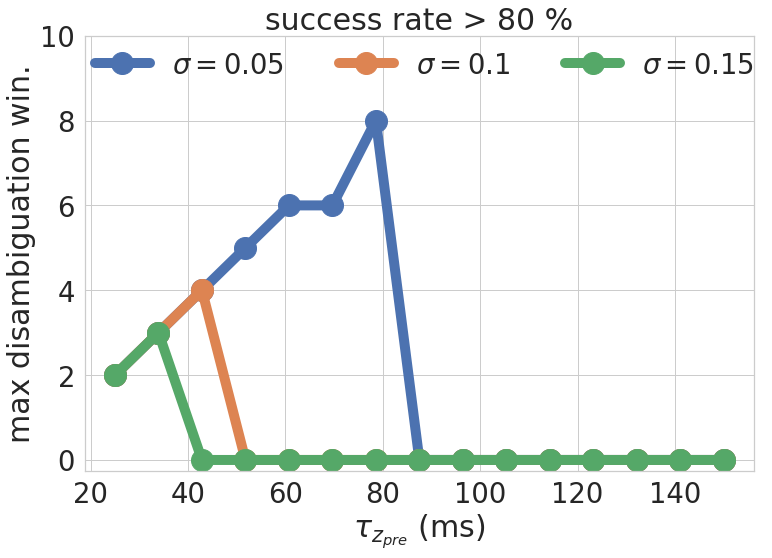

In [116]:
max_seq_array = ampa_array

sns.set(font_scale=2.5)
sns.set_style("whitegrid", {'axes.grid': False})

fig = plt.figure()
ax = fig.add_subplot(111)

for index, max_seq in enumerate(max_seq_array.T):
    label = r'$\sigma = $' + str(sigma_out_set[index])
    ax.plot(tau_z_pre_set_sys * 1000.0, max_seq, 'o-', ms=ms, lw=lw, label=label)
    
ax.set_xlabel(r'$\tau_{z_{pre}}$ (ms)')
ax.set_ylabel('max disambiguation win.')
ax.set_title(r'success rate > 80 %' )

ax.set_ylim([-0.25, 10])

ax.grid()
    
ax.legend(frameon=False, loc=(-0.001, 0.875), ncol=3)

if False:
    directory = '../plot_producers/'
    file_name = 'noise_NMDA' 
    format_string = '.svg'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight', transparent=True)

In [114]:
%%time 
sigma_out = 0.1
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
T_persistence = 0.025
NMDA = True
AMPA = True

sys_number = 20
sigma_out_set = [0.05, 0.1, 0.15]
sigma_out_set = [0.05, 0.15]
n_samples = 500
n_samples = 30
tolerance = 0.8
tau_z_pre_set_sys = np.linspace(0.025, 0.150, num=sys_number)
sequence_overlaps = np.linspace(0.1, 0.8, 8)
max_seq_array = np.ones((sys_number, len(sigma_out_set))) * sequence_overlaps[-1] * 10.0

verbose = True

for tau_index, tau_z_pre in enumerate(tau_z_pre_set_sys):
    print('tau_z_pre', tau_z_pre)
    for sigma_index, sigma_out in enumerate(sigma_out_set):
        if verbose:
            print('sigma out', sigma_out)
        for index, sequence_overlap in enumerate(sequence_overlaps):
            if verbose:
                print('seq. overlap', sequence_overlap)
            aux = calculate_dis_success(representation_overlap=1.0, sequence_overlap=sequence_overlap, minicolumns=minicolumns, 
                                        hypercolumns=hypercolumns, tt=0.100, ipi=0, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,  
                                        sigma_out=sigma_out, T_persistence=T_persistence, n_samples=n_samples, n_cues=3.0, 
                                        NMDA=NMDA, remove=remove, AMPA=AMPA, verbose=False)

            success, manager = aux
            if verbose:
                print('success', np.mean(success))
            if np.mean(success) < tolerance:
                print('filling max seq array', tau_index, sequence_overlap)
                max_seq_array[tau_index, sigma_index] = sequence_overlap*10.0 - 1.0
                print(max_seq_array)

                if verbose:
                    print('Broke')
                    print('******')
                break
    if verbose:
        print('----------')
        
nmda_array_single = np.copy(max_seq_array)

tau_z_pre 0.025
sigma out 0.05
seq. overlap 0.1
success 1.0
seq. overlap 0.2


KeyboardInterrupt: 

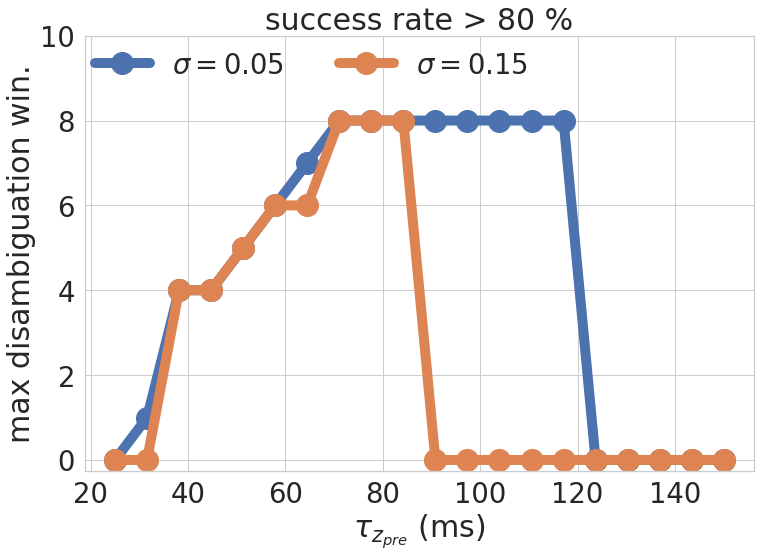

In [106]:
max_seq_array = nmda_array_single

sns.set(font_scale=2.5)
sns.set_style("whitegrid", {'axes.grid': False})

fig = plt.figure()
ax = fig.add_subplot(111)

for index, max_seq in enumerate(max_seq_array.T):
    label = r'$\sigma = $' + str(sigma_out_set[index])
    ax.plot(tau_z_pre_set_sys * 1000.0, max_seq, 'o-', ms=ms, lw=lw, label=label)
    
ax.set_xlabel(r'$\tau_{z_{pre}}$ (ms)')
ax.set_ylabel('max disambiguation win.')
ax.set_title(r'success rate > 80 %' )

ax.set_ylim([-0.25, 10])

ax.grid()
    
ax.legend(frameon=False, loc=(-0.001, 0.875), ncol=3)

if False:
    directory = '../plot_producers/'
    file_name = 'noise_NMDA' 
    format_string = '.svg'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight', transparent=True)

In [112]:
name_to_save = '../pawel_nmda.npy'
np.save(name_to_save, nmda_array_single)
name_to_save = '../pawel_nmda_and_ampa.txt'
np.savetxt(name_to_save, nmda_array_single)
name_to_save = '../pawel_z.txt'
np.savetxt(name_to_save, tau_z_pre_set_sys)